# Cancer diagnosis with adaptive machine learning
##  *A case study based on gene expression data*



Machine learning (ML) approaches are often used to model cancer biomarkers from large-scale transcriptomic data. The adopted ML paradigm learns in isolation, by constraining the learning phase to a single dataset, which often is limited to a small sample size (or number of patient samples), and assumes that trained models do not change over time. However, this is often not the case. Omics data and, in particular, gene expression data can stem from changing input domains (e.g., varying sequencing technologies or sequencing depth and coverage). Moreover, we need to acknowledge that chronic diseases, such as cancer diseases evolve over time (e.g. environmental factors, new habits and diets, etc.), requiring a continuous adaption of previously discovered biomarker models. The accuracy of models trained in such a way starts to decrease as soon as new data is presented. Here we propose a case study aiming at testing a novel paradigm for mining omics-driven biomarker models in cancer research. The new paradigm is based on continual machine learning (CL), which aims to build ML-based solutions that can continuously learn and adapt over an increasing amount of data, while retaining previously learned knowledge. We present a computational framework that implements the CL paradigm to evolve known gene-based biomarker models for the classification of breast cancer subtypes in two large cohort of cancer patient: SCAN-B and The Cancer Genome Atlas (TCGA). We also propose a computational solution that allows biomarker-based classification model to adapt and incorporate newly discovered features/biomarkers. If successful, this project will enhance a new generation of more reliable decision-making tools for cancer precision medicine that can significantly improve outcomes for both clinicians and patients.

In [1]:
# Required to correctly display interactive (dynamic) plots in Jupyter notebooks
%matplotlib notebook
# For Jupyter Lab instead
# %matplotlib ipympl
import seaborn as sns

Set the main folder

In [2]:
import os
os.chdir("/Users/vittfo/Documents/ERC/TEST/FDD-ES/")
print(os.getcwd())

/Users/vittfo/Documents/ERC/TEST/FDD-ES


## 1. Data preparation and exploration
Load gene expression of breast cancer samples from the SCAN-B cohort 

In [74]:
# import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
swdata = pd.read_csv('protein_coding_gene_expression.csv')
if 'Unnamed: 0' in swdata.columns:
    print(swdata['Unnamed: 0'])
swdata = swdata.drop('Unnamed: 0', axis=1, errors='ignore')

0          F1
1          F2
2          F3
3          F4
4          F5
        ...  
2964    F3267
2965    F3268
2966    F3269
2967    F3270
2968    F3272
Name: Unnamed: 0, Length: 2969, dtype: object


In [76]:
print(" \nCheck DataFrame sizes: \n\n", swdata.shape) # check dataset dimensions
print(" \nCount total NaN in a DataFrame : \n\n", swdata.isnull().sum().sum()) # count total NaN in a DataFrame

 
Check DataFrame sizes: 

 (2969, 15953)
 
Count total NaN in a DataFrame : 

 0


In [77]:
# identify genes with mean expression smaller than zero
low_count = []
for i in range(swdata.shape[1]):
    if np.max(swdata.iloc[:,i]) < 0:
        low_count.append(i)
print(len(low_count))

0


Load clinical variables of breast cancer samples from the SCAN-B cohort 

In [78]:
swpheno = pd.read_csv('sw_breast_pheno.csv')
if 'Unnamed: 0' in swpheno.columns:
    print(swpheno['Unnamed: 0'])
swpheno = swpheno.drop('Unnamed: 0', axis=1, errors='ignore')

0          F1
1          F2
2          F3
3          F4
4          F5
        ...  
2964    F3267
2965    F3268
2966    F3269
2967    F3270
2968    F3272
Name: Unnamed: 0, Length: 2969, dtype: object


In [79]:
print(swpheno.shape)
swpheno.head(10)

(2969, 31)


Sample_geo_accession          Sample_status Sample_submission_date  \
0           GSM2528079  Public on Mar 12 2018            Mar 09 2017   
1           GSM2528080  Public on Mar 12 2018            Mar 09 2017   
2           GSM2528081  Public on Mar 12 2018            Mar 09 2017   
3           GSM2528082  Public on Mar 12 2018            Mar 09 2017   
4           GSM2528083  Public on Mar 12 2018            Mar 09 2017   
5           GSM2528084  Public on Mar 12 2018            Mar 09 2017   
6           GSM2528087  Public on Mar 12 2018            Mar 09 2017   
7           GSM2528088  Public on Mar 12 2018            Mar 09 2017   
8           GSM2528089  Public on Mar 12 2018            Mar 09 2017   
9           GSM2528090  Public on Mar 12 2018            Mar 09 2017   

  Sample_last_update_date Sample_type  Sample_channel_count  \
0             Mar 12 2018         SRA                     1   
1             Mar 12 2018         SRA                     1   
2             Mar 12 2018         SRA                     1   
3             Mar 12 2018         SRA                     1   
4             Mar 12 2018         SRA                     1   
5             Mar 12 2018         SRA                     1   
6             Mar 12 2018         SRA                     1   
7             Mar 12 2018         SRA                     1   
8             Mar 12 2018         SRA                     1   
9             Mar 12 2018         SRA                     1   

  Sample_source_name_ch1 Sample_organism_ch1  Age  NodeSize  ...  \
0   Primary breast tumor        Homo sapiens   43       9.0  ...   
1   Primary breast tumor        Homo sapiens   48      14.0  ...   
2   Primary breast tumor        Homo sapiens   69      27.0  ...   
3   Primary breast tumor        Homo sapiens   39      51.0  ...   
4   Primary breast tumor        Homo sapiens   73      60.0  ...   
5   Primary breast tumor        Homo sapiens   40      13.0  ...   
6   Primary breast tumor        Homo sapiens   82      10.0  ...   
7   Primary breast tumor        Homo sapiens   67       6.0  ...   
8   Primary breast tumor        Homo sapiens   71      16.0  ...   
9   Primary breast tumor        Homo sapiens   64      17.0  ...   

                 nhg_pmgc               er_psgc               pgr_psgc  \
0  nhg prediction mgc: G3  er prediction sgc: 0  pgr prediction sgc: 0   
1  nhg prediction mgc: G2  er prediction sgc: 1  pgr prediction sgc: 1   
2  nhg prediction mgc: G3  er prediction sgc: 1  pgr prediction sgc: 1   
3  nhg prediction mgc: G3  er prediction sgc: 1  pgr prediction sgc: 1   
4  nhg prediction mgc: G2  er prediction sgc: 1  pgr prediction sgc: 1   
5  nhg prediction mgc: G3  er prediction sgc: 0  pgr prediction sgc: 1   
6  nhg prediction mgc: G2  er prediction sgc: 0  pgr prediction sgc: 0   
7  nhg prediction mgc: G2  er prediction sgc: 1  pgr prediction sgc: 0   
8  nhg prediction mgc: G2  er prediction sgc: 1  pgr prediction sgc: 1   
9  nhg prediction mgc: G3  er prediction sgc: 1  pgr prediction sgc: 1   

                her2_psgc               ki67_psgc   Pam50 SurvDays  \
0  her2 prediction sgc: 0  ki67 prediction sgc: 1   Basal     2367   
1  her2 prediction sgc: 0  ki67 prediction sgc: 0    LumA     2367   
2  her2 prediction sgc: 0  ki67 prediction sgc: 1    LumB     2168   
3  her2 prediction sgc: 1  ki67 prediction sgc: 1    LumA     2416   
4  her2 prediction sgc: 0  ki67 prediction sgc: 0  Normal     2389   
5  her2 prediction sgc: 0  ki67 prediction sgc: 1   Basal     2373   
6  her2 prediction sgc: 1  ki67 prediction sgc: 0    Her2     2380   
7  her2 prediction sgc: 1  ki67 prediction sgc: 0    LumA     2324   
8  her2 prediction sgc: 0  ki67 prediction sgc: 0    LumA     2367   
9  her2 prediction sgc: 0  ki67 prediction sgc: 1    LumB     1962   

  OverallSurv Endocrine_treat chemo  
0           0             0.0   1.0  
1           0             1.0   1.0  
2           1             1.0   1.0  
3           0             1.

ER/PgR/HER2/Ki67: 0 negative/normal/low, 1 positive/amplified/high

Define histological subtypes

* Luminal A breast cancer is estrogen receptor-positive and progesterone receptor-positive, HER2-negative, and has low levels of the protein Ki-67.
* Luminal B breast cancer is estrogen receptor-positive and HER2-negative, and also has either high levels of Ki-67 (which indicate faster growth of cancer cells) or is progesterone receptor-negative.
* HER2-enriched breast cancer is estrogen receptor-negative and progesterone receptor-negative and HER2-positive.
* Basal-like breast cancer is estrogen receptor-negative, progesterone receptor-negative, and HER2-negative. 

This information is provided by Breastcancer.org. (https://www.breastcancer.org/types/molecular-subtypes)

IHC status 
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4656721/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4127612/

In [80]:
import collections
swpheno['histcl'] = ['NotClear'] * len(swpheno['er_psgc'])
# Define Basal-like
swpheno.loc[((swpheno['er_psgc'] == 'er prediction sgc: 0') & 
             (swpheno['pgr_psgc'] == 'pgr prediction sgc: 0') &
             (swpheno['her2_psgc'] == 'her2 prediction sgc: 0')), 'histcl'] = 'Basal'
# Define Her2
swpheno.loc[((swpheno['er_psgc'] == 'er prediction sgc: 0') & 
             (swpheno['pgr_psgc'] == 'pgr prediction sgc: 0') &
             (swpheno['her2_psgc'] == 'her2 prediction sgc: 1')), 'histcl'] = 'Her2'
# Define Luminal A
swpheno.loc[((swpheno['er_psgc'] == 'er prediction sgc: 1') & 
             (swpheno['pgr_psgc'] == 'pgr prediction sgc: 1') & 
             (swpheno['her2_psgc'] == 'her2 prediction sgc: 0') &
             (swpheno['ki67_psgc'] == 'ki67 prediction sgc: 0')), 'histcl'] = 'LumA'
# Define Luminal B
swpheno.loc[((swpheno['er_psgc'] == 'er prediction sgc: 1') & 
             (swpheno['her2_psgc'] == 'her2 prediction sgc: 0') &
             ((swpheno['pgr_psgc'] == 'pgr prediction sgc: 0') |
              (swpheno['ki67_psgc'] == 'ki67 prediction sgc: 1'))), 'histcl'] = 'LumB'
swpheno.loc[((swpheno['er_psgc'] == 'er prediction sgc: 1') & 
             (swpheno['pgr_psgc'] == 'pgr prediction sgc: 0') &
             (swpheno['her2_psgc'] == 'her2 prediction sgc: 1')), 'histcl'] = 'LumB'
#
print(collections.Counter(swpheno['histcl']))

Counter({'LumB': 1395, 'LumA': 1120, 'Basal': 226, 'NotClear': 147, 'Her2': 81})


In [81]:
print(collections.Counter(swpheno['histcl']))
print(collections.Counter(swpheno['Pam50']))
print(swpheno.groupby(['histcl', 'Pam50']).size())

Counter({'LumB': 1395, 'LumA': 1120, 'Basal': 226, 'NotClear': 147, 'Her2': 81})
Counter({'LumA': 1501, 'LumB': 666, 'Basal': 308, 'Her2': 295, 'Normal': 199})
histcl    Pam50 
Basal     Basal     190
          Her2       29
          LumA        1
          LumB        2
          Normal      4
Her2      Basal       7
          Her2       74
LumA      Basal       2
          Her2        2
          LumA      956
          LumB       47
          Normal    113
LumB      Basal      87
          Her2      134
          LumA      505
          LumB      598
          Normal     71
NotClear  Basal      22
          Her2       56
          LumA       39
          LumB       19
          Normal     11
dtype: int64


Define the dataset for the IHC subtypes

In [82]:
swdata_ihc = swdata[swpheno['histcl'] != 'NotClear']
swpheno_ihc = swpheno[swpheno['histcl'] != 'NotClear']
print(swdata_ihc.shape)
print(swpheno_ihc.shape)

(2822, 15953)
(2822, 32)


Load TCGA breast cancer data

In [83]:
tcga = pd.read_csv('protein_coding_exp_tcga.csv')
tcgap = pd.read_csv('protein_coding_exp_tcga_pheno_2.csv')

In [84]:
#tcga = pd.read_csv('tcga_breast_gdat_0.csv')
#tcgap = pd.read_csv('tcga_breast_pheno_0.csv')

In [85]:
print(tcga.shape)
print(tcgap.shape)

(1071, 16655)
(1071, 29)


In [86]:
if 'Unnamed: 0' in tcga.columns:
    print(tcga['Unnamed: 0'])

0       TCGA.3C.AAAU.01A.11R.A41B.07
1       TCGA.3C.AALI.01A.11R.A41B.07
2       TCGA.3C.AALJ.01A.31R.A41B.07
3       TCGA.3C.AALK.01A.11R.A41B.07
4       TCGA.4H.AAAK.01A.12R.A41B.07
                    ...             
1066    TCGA.WT.AB44.01A.11R.A41B.07
1067    TCGA.XX.A899.01A.11R.A36F.07
1068    TCGA.XX.A89A.01A.11R.A36F.07
1069    TCGA.Z7.A8R5.01A.42R.A41B.07
1070    TCGA.Z7.A8R6.01A.11R.A41B.07
Name: Unnamed: 0, Length: 1071, dtype: object


In [87]:
tcga=tcga.drop('Unnamed: 0', axis=1, errors='ignore')

In [88]:
# count total NaN in a DataFrame
print(" \nCount total NaN in a DataFrame : \n\n", tcga.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 0


In [89]:
tcgap.head()

Unnamed: 0       patient Tumor.Type  \
0  TCGA.3C.AAAU.01A.11R.A41B.07  TCGA-3C-AAAU       BRCA   
1  TCGA.3C.AALI.01A.11R.A41B.07  TCGA-3C-AALI       BRCA   
2  TCGA.3C.AALJ.01A.31R.A41B.07  TCGA-3C-AALJ       BRCA   
3  TCGA.3C.AALK.01A.11R.A41B.07  TCGA-3C-AALK       BRCA   
4  TCGA.4H.AAAK.01A.12R.A41B.07  TCGA-4H-AAAK       BRCA   

  Included_in_previous_marker_papers vital_status  days_to_birth  \
0                                 NO        Alive       -20211.0   
1                                 NO        Alive       -18538.0   
2                                 NO        Alive       -22848.0   
3                                 NO        Alive       -19074.0   
4                                 NO        Alive       -18371.0   

   days_to_death  days_to_last_followup  age_at_initial_pathologic_diagnosis  \
0            NaN                 4047.0                                   55   
1            NaN                 4005.0                                   50   
2            NaN                 1474.0                                   62   
3            NaN                 1448.0                                   52   
4            NaN                  348.0                                   50   

  pathologic_stage  ...  mRNA.Clusters miRNA.Clusters lncRNA.Clusters  \
0              NaN  ...             C1             C3             NaN   
1         Stage_II  ...             C2             C3             NaN   
2         Stage_II  ...             C2             C2             NaN   
3          Stage_I  ...             C2             C2             NaN   
4        Stage_III  ...             C2             C2             NaN   

   Protein.Clusters  PARADIGM.Clusters  Pan.Gyn.Clusters OverallSurv  \
0               NaN                 C5               NaN           0   
1                C2                 C4                C4           0   
2               NaN                 C4               NaN           0   
3                C2                 C6                C4           0   
4                C2                 C6                C1           0   

  er_status_by_ihc pr_status_by_ihc her2_status_by_ihc  
0         Positive         Positive           Negative  
1         Positive         Positive           Positive  
2         Positive         Positive      Indeterminate  
3         Positive         Positive           Positive  
4         Positive         Positive          Equivocal  

[5 rows x 29 columns]

In [90]:
tcgap['histcl'] = ['NotClear'] * len(tcgap['er_status_by_ihc'])
# Define Basal-like
tcgap.loc[((tcgap['er_status_by_ihc'] == 'Negative') & 
           (tcgap['pr_status_by_ihc'] == 'Negative') &
           (tcgap['her2_status_by_ihc'] == 'Negative')), 'histcl'] = 'Basal'
# Define Her2
tcgap.loc[((tcgap['er_status_by_ihc'] == 'Negative') & 
           (tcgap['pr_status_by_ihc'] == 'Negative') &
           (tcgap['her2_status_by_ihc'] == 'Positive')), 'histcl'] = 'Her2'
# Define Luminal A
tcgap.loc[((tcgap['er_status_by_ihc'] == 'Positive') & 
           (tcgap['pr_status_by_ihc'] == 'Positive') &
           (tcgap['her2_status_by_ihc'] == 'Negative')), 'histcl'] = 'LumA'
# Define Luminal B
tcgap.loc[((tcgap['er_status_by_ihc'] == 'Positive') & 
           (tcgap['pr_status_by_ihc'] == 'Negative') &
           (tcgap['her2_status_by_ihc'] == 'Positive')), 'histcl'] = 'LumB'
#

In [91]:
print(collections.Counter(tcgap['histcl']))
print(collections.Counter(tcgap['Pam50']))
print(tcgap.groupby(['histcl', 'Pam50']).size())

Counter({'NotClear': 537, 'LumA': 361, 'Basal': 114, 'Her2': 37, 'LumB': 22})
Counter({'LumA': 555, 'LumB': 207, 'Basal': 187, 'Her2': 82, 'Normal': 40})
histcl    Pam50 
Basal     Basal      98
          Her2        9
          LumA        2
          LumB        1
          Normal      4
Her2      Basal       7
          Her2       29
          Normal      1
LumA      Basal       1
          LumA      268
          LumB       82
          Normal     10
LumB      Basal       1
          Her2        9
          LumA        6
          LumB        6
NotClear  Basal      80
          Her2       35
          LumA      279
          LumB      118
          Normal     25
dtype: int64


In [92]:
tcga_ihc = tcga[tcgap['histcl'] != 'NotClear']
tcgap_ihc = tcgap[tcgap['histcl'] != 'NotClear']
tcga_ihc.index = range(len(tcga_ihc.index))
tcgap_ihc.index = range(len(tcgap_ihc.index))
print(tcga_ihc.shape)
print(tcgap_ihc.shape)

(534, 16654)
(534, 30)


### 1.2 Define the PAM 50 signatures

Define the list of PAM50 genes. This list does not contain 'ORC6L', 'KNTC2', 'CDCA1'.

In [93]:
pam50sig = ["ACTR3B","ANLN","BAG1","BCL2","BIRC5","BLVRA","CCNB1","CCNE1","CDC20","CDC6","CDH3","CENPF","CEP55","CXXC5","EGFR","ERBB2","ESR1","EXO1","FGFR4","FOXA1","FOXC1","GPR160","GRB7","KIF2C","KRT14","KRT17","KRT5","MAPT","MDM2","MELK","MIA","MKI67","MLPH","MMP11","MYBL2","MYC","NAT1","PGR","PHGDH","PTTG1","RRM2","SFRP1","SLC39A6","TMEM45B","TYMS","UBE2C","UBE2T"]

In [94]:
len(pam50sig)

47

### 1.3 Check and convert class labels (breast cancer subtypes)

In [95]:
swpheno['Pam50'].unique()

array(['Basal', 'LumA', 'LumB', 'Normal', 'Her2'], dtype=object)

In [96]:
swpheno_ihc['histcl'].unique()

array(['Basal', 'LumA', 'LumB', 'Her2'], dtype=object)

In [97]:
tcgap['Pam50'].unique()

array(['LumA', 'Her2', 'LumB', 'Normal', 'Basal'], dtype=object)

In [98]:
tcgap_ihc['histcl'].unique()

array(['LumA', 'Basal', 'Her2', 'LumB'], dtype=object)

Barplot showing the number of samples available for each class

<IPython.core.display.Javascript object>


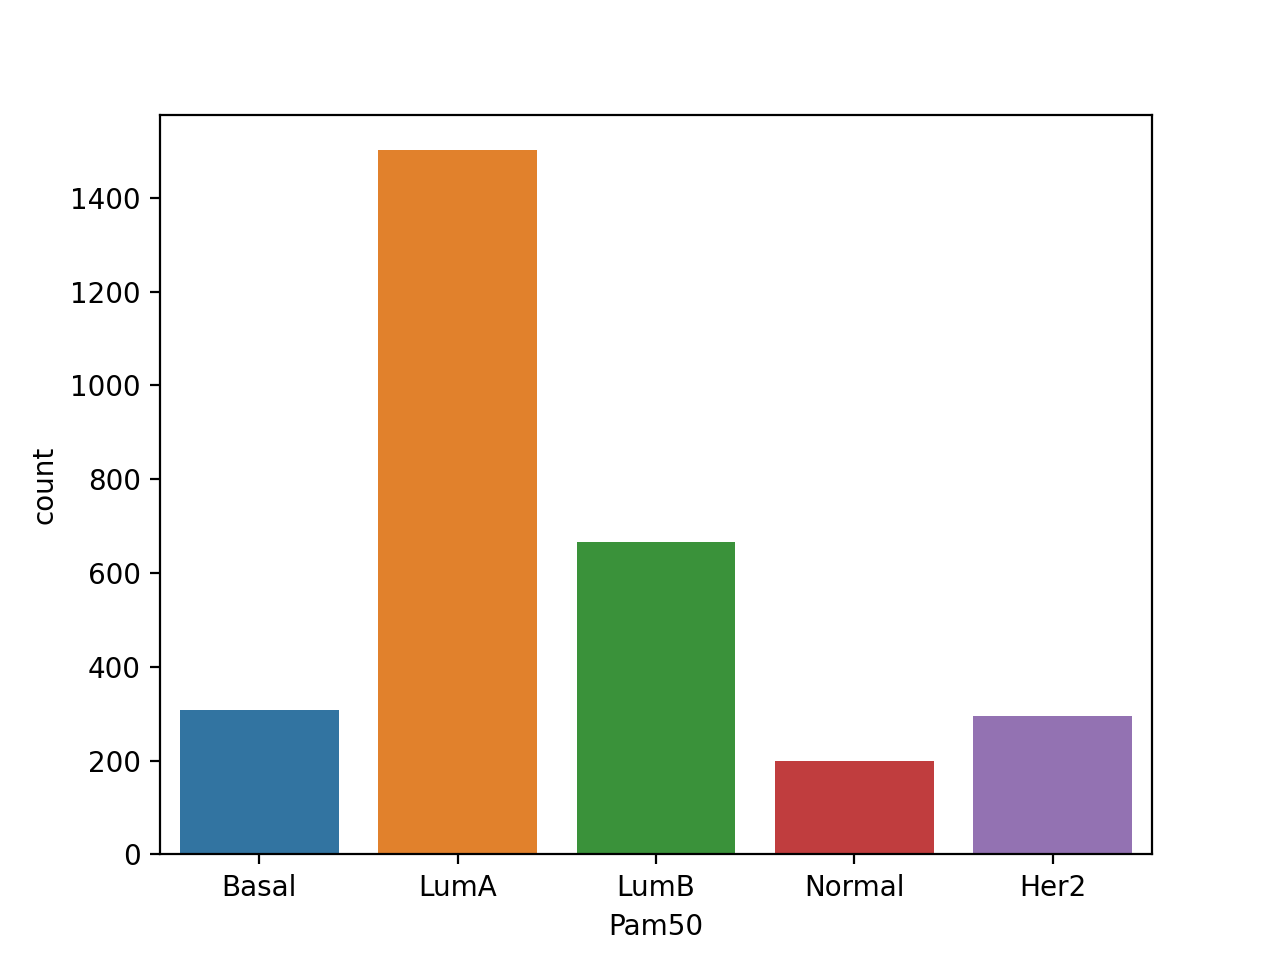

<AxesSubplot:xlabel='Pam50', ylabel='count'>

In [99]:
sns.countplot(x='Pam50', data=swpheno, order = ['Basal', 'LumA', 'LumB', 'Normal', 'Her2'])

<IPython.core.display.Javascript object>


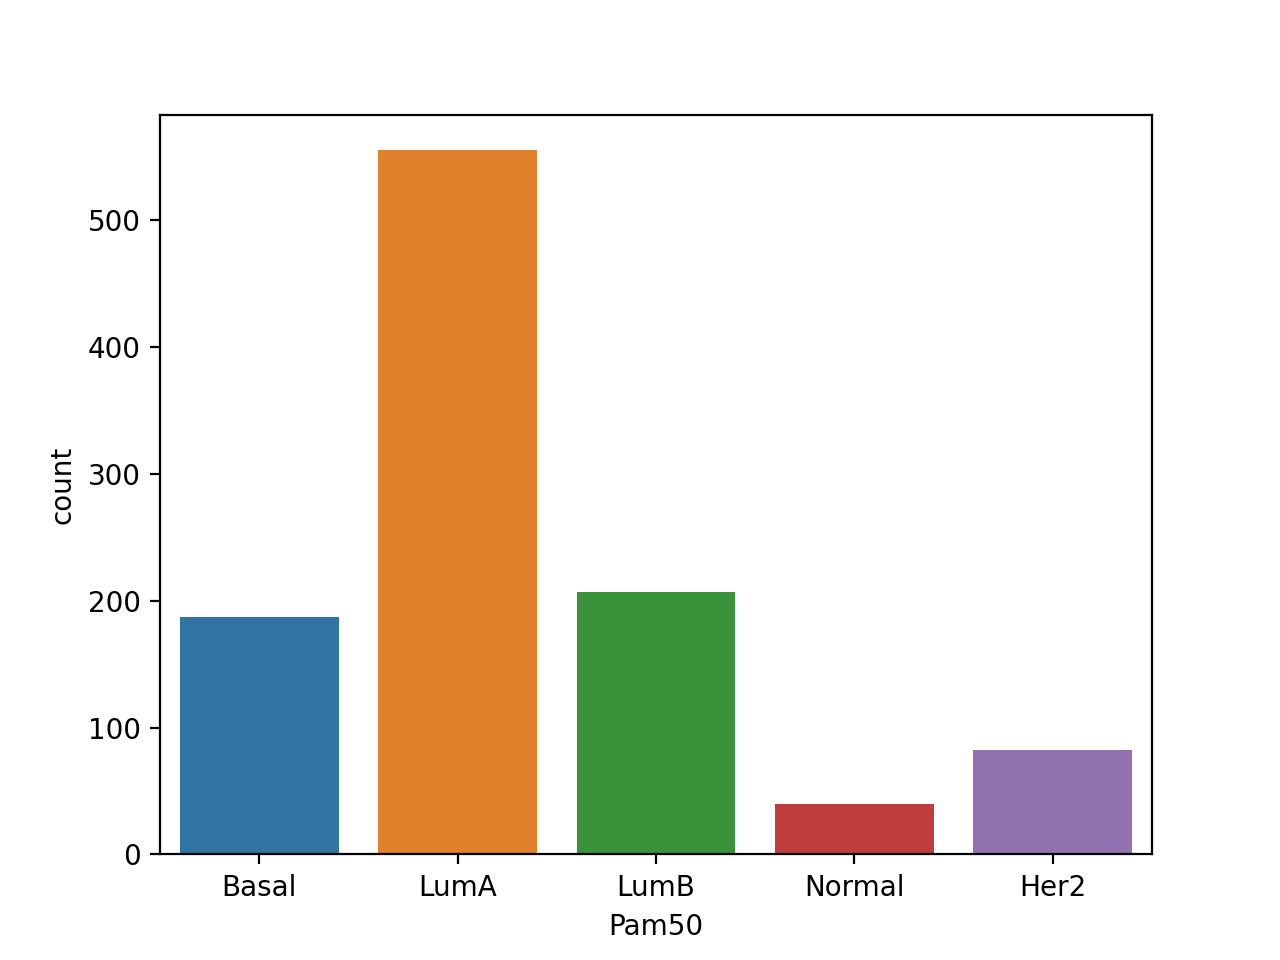

<AxesSubplot:xlabel='Pam50', ylabel='count'>

In [100]:
sns.countplot(x='Pam50', data=tcgap, order = ['Basal', 'LumA', 'LumB', 'Normal', 'Her2'])

In [101]:
pam50 = swpheno['Pam50']
histcl = swpheno_ihc['histcl']

Mapping class labels to indexes for the SCAN-B cohort

In [102]:
class2idx = {
    'LumA':0,
    'LumB':1,
    'Her2':2,
    'Basal':3,
    'Normal':4
}
idx2class = {v: k for k, v in class2idx.items()}

In [103]:
import collections
print(collections.Counter(pam50))

Counter({'LumA': 1501, 'LumB': 666, 'Basal': 308, 'Her2': 295, 'Normal': 199})


In [104]:
print(collections.Counter(histcl))

Counter({'LumB': 1395, 'LumA': 1120, 'Basal': 226, 'Her2': 81})


In [105]:
# replacing labels
pam50.replace(class2idx, inplace=True)
histcl.replace(class2idx, inplace=True)

/Users/vittfo/anaconda3/envs/rivertest/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [106]:
# checking the counts again
print(collections.Counter(pam50))
print(collections.Counter(histcl))

Counter({0: 1501, 1: 666, 3: 308, 2: 295, 4: 199})
Counter({1: 1395, 0: 1120, 3: 226, 2: 81})


Mapping class labels to indexes for the TCGA cohort

In [107]:
pam50t = tcgap['Pam50']
histclt = tcgap_ihc['histcl']

In [108]:
print(collections.Counter(pam50t))
print(collections.Counter(histclt))

Counter({'LumA': 555, 'LumB': 207, 'Basal': 187, 'Her2': 82, 'Normal': 40})
Counter({'LumA': 361, 'Basal': 114, 'Her2': 37, 'LumB': 22})


In [109]:
pam50t.replace(class2idx, inplace=True)
histclt.replace(class2idx, inplace=True)

In [110]:
print(collections.Counter(pam50t))
print(collections.Counter(histclt))

Counter({0: 555, 1: 207, 3: 187, 2: 82, 4: 40})
Counter({0: 361, 3: 114, 2: 37, 1: 22})


In [111]:
common_feats = list(set.intersection(set(swdata.columns), set(tcga.columns)))
len(common_feats)

15449

###  1.5 Data preparation

Remove zero variance features

In [112]:
from sklearn.feature_selection import VarianceThreshold
zv_sel_swdata = VarianceThreshold(0)
zv_sel_swdata_ihc = VarianceThreshold(0)
zv_sel_tcga = VarianceThreshold(0)
zv_sel_tcga_ihc = VarianceThreshold(0)

In [113]:
print(swdata.shape)
print(swdata_ihc.shape)

(2969, 15953)
(2822, 15953)


In [114]:
zv_sel_swdata.fit_transform(swdata)
zv_sel_swdata_ihc.fit_transform(swdata_ihc)
zv_sel_tcga.fit_transform(tcga)
zv_sel_tcga_ihc.fit_transform(tcga_ihc)

array([[1.36537189, 0.        , 4.75100404, ..., 0.86453296, 3.64575675,
        0.        ],
       [4.19541757, 0.        , 4.45598844, ..., 1.05905626, 2.95185304,
        0.        ],
       [3.16096187, 0.        , 5.2150499 , ..., 0.61928561, 1.88128059,
        0.        ],
       ...,
       [3.08005001, 3.75687237, 4.41980912, ..., 0.        , 2.75224436,
        0.        ],
       [3.92216876, 0.        , 4.67912549, ..., 1.16821607, 2.30952553,
        0.        ],
       [3.10393239, 0.        , 5.04240339, ..., 0.74130585, 4.28980075,
        0.        ]])

In [115]:
print(np.sum(zv_sel_swdata.get_support()))
print(np.sum(zv_sel_swdata_ihc.get_support()))
print(np.sum(zv_sel_tcga.get_support()))
print(np.sum(zv_sel_tcga_ihc.get_support()))

15953
15946
16654
16479


In [116]:
swdata_ihc = swdata_ihc[swdata_ihc.columns[zv_sel_swdata_ihc.get_support()]]
tcga_ihc = tcga_ihc[tcga_ihc.columns[zv_sel_tcga_ihc.get_support()]]

In [117]:
print(swdata_ihc.shape)
print(tcga_ihc.shape)

(2822, 15946)
(534, 16479)


Select common features betwee SCAN-B and TCGA

In [118]:
common_feats = list(set.intersection(set(swdata.columns), set(tcga.columns)))
len(common_feats)

15449

#### Define the datasets

In [119]:
biom_list_pam50 = list(set.intersection(set(common_feats), set(pam50sig)))
print(len(biom_list_pam50))

47


In [120]:
X_data = swdata[common_feats]
X_data.shape

(2969, 15449)

In [121]:
X_tcga = tcga[common_feats]
X_tcga.shape

(1071, 15449)

In [122]:
X_data = swdata.loc[pam50[pam50 != 4].index,common_feats]
X_data.index = range(len(X_data.index))
pam50n = pam50[pam50 != 4]
pam50n.index = range(len(X_data.index))
print(X_data.shape)
print(pam50n.shape)

(2770, 15449)
(2770,)


In [123]:
X_tcga = tcga.loc[pam50t[pam50t != 4].index, common_feats]
X_tcga.index = range(len(X_tcga.index))
pam50nt = pam50t[pam50t != 4]
pam50nt.index = range(len(X_tcga.index))
print(X_tcga.shape)
print(pam50nt.shape)

(1031, 15449)
(1031,)


In [124]:
swdata_ihc = swdata[swpheno['histcl'] != 'NotClear']
swpheno_ihc = swpheno[swpheno['histcl'] != 'NotClear']

In [125]:
X_ihc = swdata_ihc[list(set.intersection(set(swdata_ihc.columns),set.intersection(set(common_feats), set(tcga_ihc.columns))))]
X_ihc.index = list(range(X_ihc.shape[0]))
histcl.index = list(range(X_ihc.shape[0]))
X_ihc.shape

(2822, 15374)

In [126]:
swpheno_ihc.index = list(range(swpheno_ihc.shape[0]))

In [127]:
Xt_ihc = tcga_ihc[list(set.intersection(set(swdata_ihc.columns),set.intersection(set(common_feats), set(tcga_ihc.columns))))]
Xt_ihc.shape

(534, 15374)

#### Create a first dataset with the order "SCAN-B, TCGA"

In [128]:
X_tot = pd.concat([X_ihc, Xt_ihc])
X_tot.index = list(range(X_tot.shape[0]))
print(X_tot.shape)

(3356, 15374)


In [129]:
Y_tot = pd.concat([histcl, histclt]) 
print(Y_tot.shape[0])
#Y_tot.reset_index(inplace = True, drop = True)
Y_tot.index = list(range(Y_tot.shape[0]))
print(len(Y_tot))
print(collections.Counter(Y_tot))

3356
3356
Counter({0: 1481, 1: 1417, 3: 340, 2: 118})


#### Create a second test based on the order "TCGA-SCAN-B"

In [130]:
X_tot2 = pd.concat([Xt_ihc, X_ihc])
X_tot2.index = list(range(X_tot2.shape[0]))
print(X_tot2.shape)

(3356, 15374)


In [131]:
Y_tot2 = pd.concat([histclt, histcl]) 
print(Y_tot2.shape[0])
#Y_tot.reset_index(inplace = True, drop = True)
Y_tot2.index = list(range(Y_tot2.shape[0]))
print(len(Y_tot2))
print(collections.Counter(Y_tot2))

3356
3356
Counter({0: 1481, 1: 1417, 3: 340, 2: 118})


### 1.6 Online learning with *river*

Load modules from **sklearn**

In [132]:
import sklearn as sk
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

Load modules from **river**

In [133]:
import random
from river import stream
from river import linear_model
from river import metrics
from river import multiclass
from river import preprocessing
from river import optim
from river.drift import ADWIN
from river.drift import PageHinkley
from river import feature_selection
from river import tree
from river.multiclass import OneVsRestClassifier
from river.utils import dict2numpy
from river import ensemble
from river import neighbors
from river import naive_bayes
import warnings
warnings.filterwarnings('ignore')

Load the module for feature selection **mrmr**

In [136]:
from mrmr import mrmr_classif

In [137]:
X = np.array([[0], [0], [0], [0], [0], [0], [0]])
Y = np.array([1, 1, 1, 2, 2, 2, 2])

model = naive_bayes.GaussianNB()

for x, y in stream.iter_array(X, Y):
    print(x)
    print(type(x))
    print(model.predict_proba_one(x))
    _ = model.learn_one(x, y)

{0: 0}
<class 'dict'>
{}
{0: 0}
<class 'dict'>
{1: 1.0}
{0: 0}
<class 'dict'>
{1: 1.0}
{0: 0}
<class 'dict'>
{1: 1.0}
{0: 0}
<class 'dict'>
{1: 0.7500000000000008, 2: 0.24999999999999994}
{0: 0}
<class 'dict'>
{1: 0.5999999999999991, 2: 0.39999999999999963}
{0: 0}
<class 'dict'>
{1: 0.5000000000000009, 2: 0.5000000000000009}


Define utility functions

In [138]:
dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])

Check the scaling process

In [139]:
len(biom_list_pam50)

47

In [140]:
scaler = preprocessing.StandardScaler()

C = 0
X_scal = np.zeros(shape=(X_tot.shape[0],len(pam50sig)))
for xi, yi in stream.iter_pandas(X_tot):
    xi = dict_filter(xi, pam50sig)
    xi_scaled = scaler.learn_one(xi).transform_one(xi)
    X_scal[C] = dict2numpy(xi_scaled)
    C = C + 1

In [141]:
provola = pd.DataFrame(X_scal)
provola = provola.set_axis(biom_list_pam50, axis=1)
provola.head()

FGFR4      ESR1      CDH3      CDC6     CXXC5       PGR     FOXA1  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  1.000000 -1.000000  1.000000  1.000000 -1.000000  1.000000 -1.000000   
2 -0.343126  1.048983 -0.250263  0.328440  1.140209 -0.902187  1.392565   
3 -0.729439 -1.547975  0.188017  0.667416 -1.374991 -0.933232 -1.328254   
4 -0.244399 -0.354176 -0.213776 -1.003146 -0.312689  1.140637 -0.355747   

       MELK     BIRC5      ANLN  ...      KRT5      GRB7      NAT1       MYC  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1 -1.000000 -1.000000 -1.000000  ...  1.000000 -1.000000 -1.000000 -1.000000   
2  0.049611 -0.309551  0.670914  ...  0.102293  0.792914  1.158658  1.278067   
3 -1.101567 -1.706028 -1.629760  ... -0.929873 -0.268551 -1.490106 -1.539371   
4 -0.476844 -0.597456 -1.020123  ... -0.767948 -0.973509 -0.139450  0.044438   

      KRT17      BCL2     CCNB1     UBE2C    GPR160     KRT14  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1 -1.000000  1.000000  0.000000 -1.000000 -1.000000  1.000000  
2 -1.211141  0.043130  1.414214  1.243135  1.143153  1.334442  
3  0.828701 -0.632537 -0.577350 -1.561303 -1.579428 -1.601896  
4 -0.832303 -0.280429  1.479061 -0.782015 -0.088694  0.693892  

[5 rows x 47 columns]

(3356, 47)


<IPython.core.display.Javascript object>


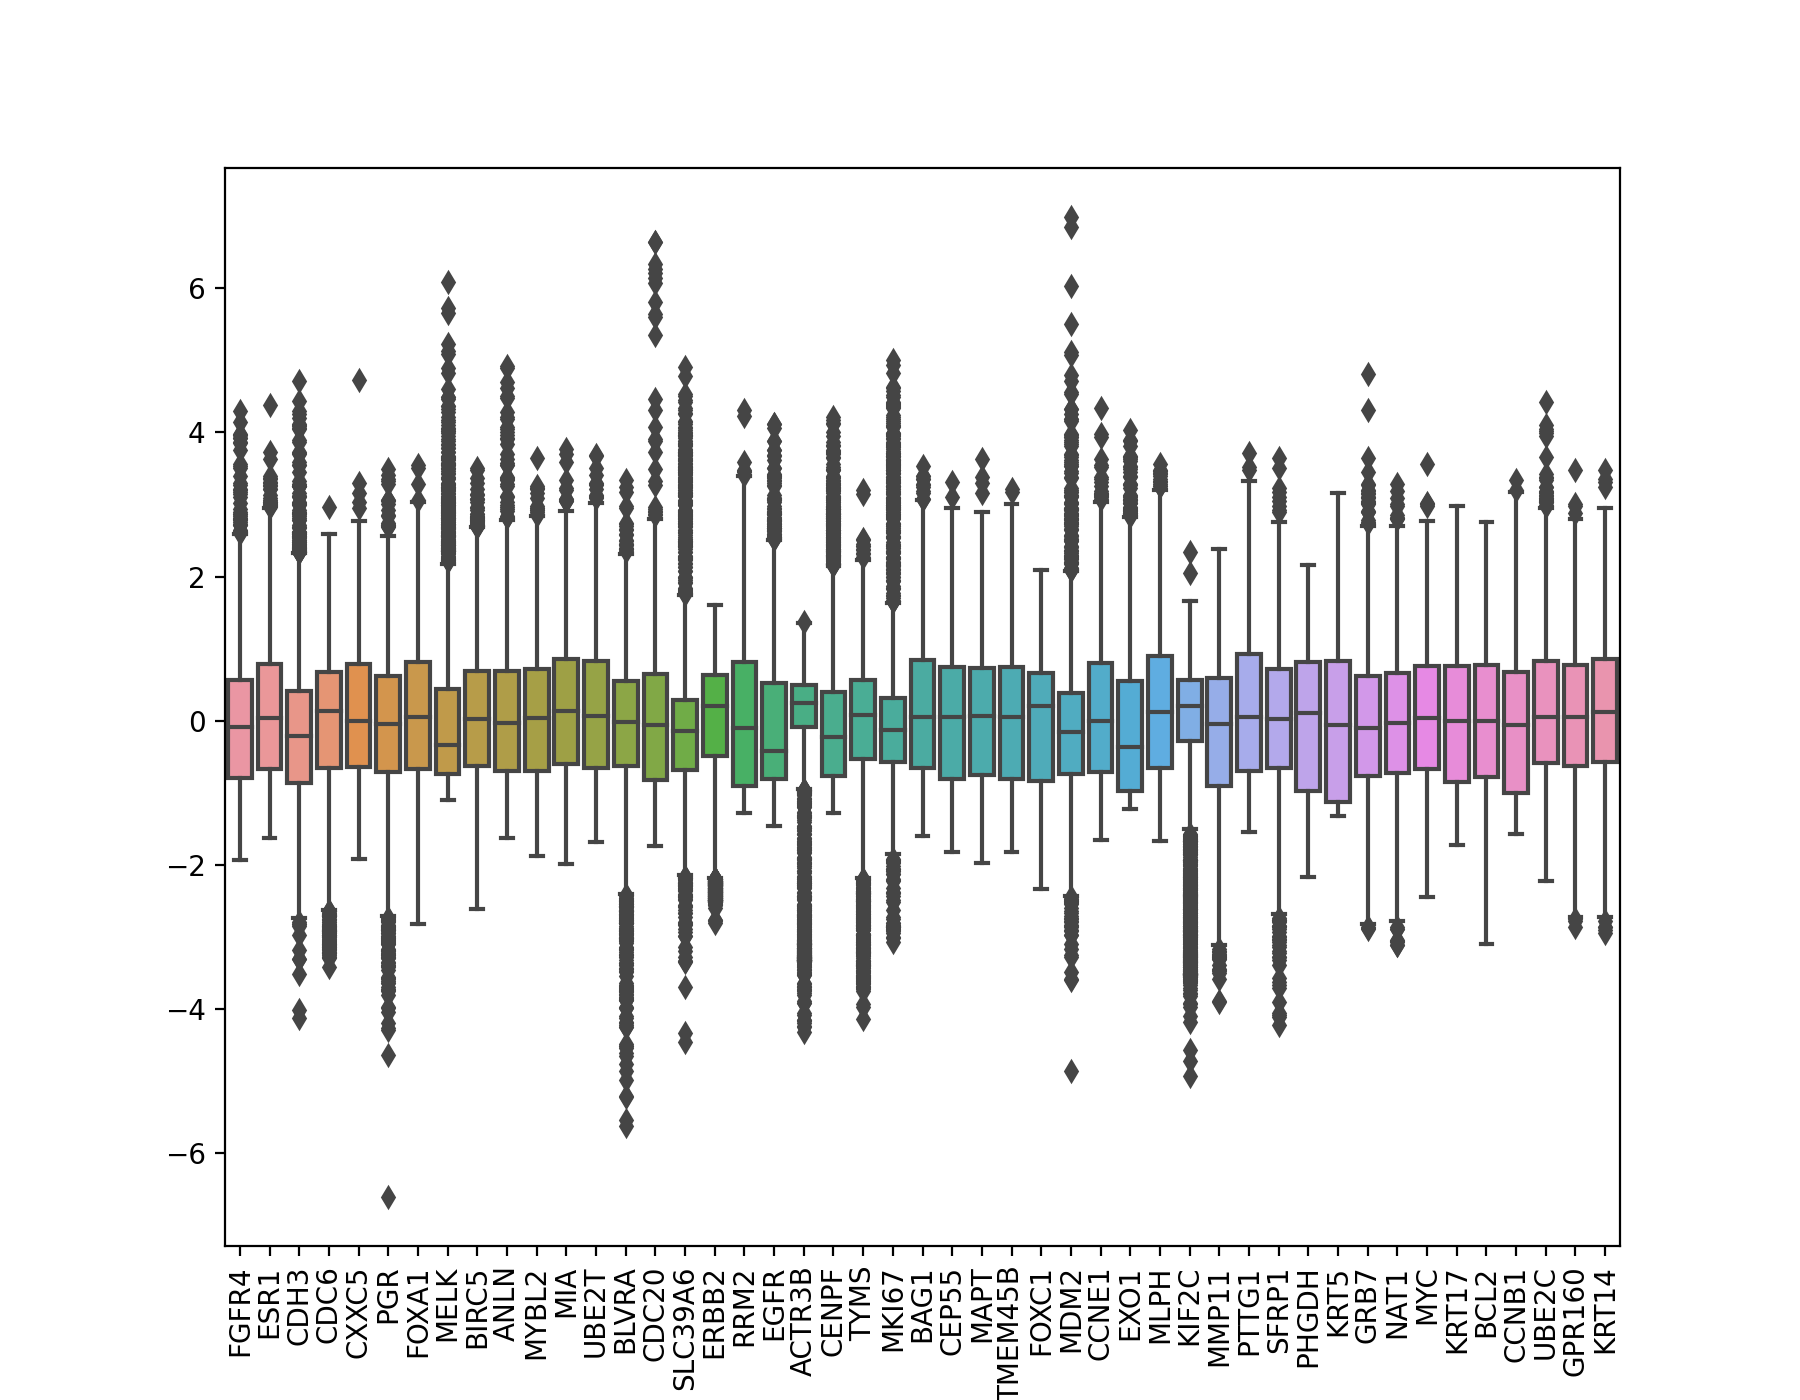

<AxesSubplot:>

In [142]:
print(provola.shape)
from matplotlib import pyplot
fig_dims = (9, 7)
fig, ax = pyplot.subplots(figsize=fig_dims)
ax.tick_params(axis='x', rotation=90)
sns.boxplot(data = provola)

#### Implementing the DFF-ES strategy

In [143]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

np.random.seed(123)

# based on mutual information (univariate/filter method)
mi_selector = SelectKBest(mutual_info_classif, k = 100)

# set the selector
selector = mi_selector

# Make a pipeline for feature selection
ufeat_selection = make_pipeline(StandardScaler(), selector)

In [144]:
def createRiverModel(typem):
    
    if typem == "hat":
        new_model = preprocessing.StandardScaler() 
        new_model |= tree.HoeffdingAdaptiveTreeClassifier(grace_period=100, split_confidence=1e-5,
                                                         leaf_prediction='nb', nb_threshold=10, seed = 0)
    if typem == "eft":    
        new_model = preprocessing.StandardScaler() 
        new_model |= tree.ExtremelyFastDecisionTreeClassifier(grace_period=100, split_confidence=1e-5,
                                                              leaf_prediction='nb', nb_threshold=10,
                                                              min_samples_reevaluate=100)
    if typem == "awbc":    
        new_model = ensemble.ADWINBaggingClassifier(model=(preprocessing.StandardScaler() | 
                                                           tree.HoeffdingTreeClassifier(grace_period=50, 
                                                                                        split_confidence=1e-5,
                                                                                        leaf_prediction='nb', 
                                                                                        nb_threshold=10)),
                                                    n_models=10, seed=0)
    if typem == "arf":
        new_model = preprocessing.StandardScaler() 
        new_model |= ensemble.AdaptiveRandomForestClassifier(n_models=10, seed=0)
    
    if typem == "abc":
        new_model = preprocessing.StandardScaler() 
        new_model |= ensemble.AdaBoostClassifier(model=(tree.HoeffdingTreeClassifier(split_criterion='gini',
                                                                              split_confidence=1e-5,
                                                                              grace_period=2000)),
                                                        n_models=5, seed=0)
    if typem == "nb":
        new_model = preprocessing.StandardScaler() 
        new_model |= naive_bayes.GaussianNB()
        
    return(new_model)

In [145]:
def testRiver(known_biomarkers, X, Y, bufferlen = 200, last_k = 2, typem = "hat", seed=0): 
    
    random.seed(seed)
    
    # Feature sets
    add_value = []
    com_feats = []
    list_bio = []
    currents = []
    
    # statistics
    y_true = []
    y_pred = []
    yk_pred = []
    ye_pred = []
    all_kb = []
    all_val = []
    all_ens = []
    feat_drifts = []
    acc_fdd = []
    
    C = 0 # count patients
    buffer = [] # buffer of collected patient-based gene expression profiles
    if known_biomarkers is None:
        cnt_biomarkers = []
        list_bio.append([])
    else:
        cnt_biomarkers = known_biomarkers
        list_bio.append(known_biomarkers)
    
    # define the initial model
    models = []
    if known_biomarkers is None:
        models.append(naive_bayes.GaussianNB())
    else:
        models.append(createRiverModel(typem))

    # define the metric to be evaluated
    list_metrics = []
    list_metrics.append(metrics.BalancedAccuracy())
    ens_metrics = metrics.BalancedAccuracy()
    
    buffer = [] # buffer of collected patient-based gene expression profiles
    feat_drifts = []

    # start the learning process
    for xi, yi in stream.iter_pandas(X, Y): #data

        buffer.append(C)
        
        if len(buffer) == bufferlen: ################### Start the FDD

            # define the training dataset
            fs_dat = X.iloc[buffer,:]
            fs_y = Y[buffer]
            
            # repeat feature selection
            #fs_dat_sc = StandardScaler().fit_transform(fs_dat)
            #fs_dat = pd.DataFrame(fs_dat_sc, index=fs_dat.index, columns=X.columns) # re-transform to Pandas
            new_biomarkers = mrmr_classif(X=fs_dat, y=fs_y, K=10)

            # check for feature drift detection
            intfeat = list(set.intersection(set(cnt_biomarkers), set(new_biomarkers)))
            test_feat_drift = len(intfeat) == len(new_biomarkers)
                
            # collect statistics
            add_value.append(list(set(new_biomarkers).difference(set(cnt_biomarkers))))
            com_feats.append(intfeat)

            #test_feat_drift = False
            if test_feat_drift == False :
                list_bio.append(new_biomarkers)
                print(f"Feature drift detected at index {C}, intersection: {len(intfeat)}")
                print(f"  - added value:")
                print(list(set(new_biomarkers).difference(set(cnt_biomarkers))))
                print(f"  - common features:")
                print(intfeat)
                print(f"  - tot features:")
                print(len(cnt_biomarkers))
                # update the current biomarker
                cnt_biomarkers = list(set.union(set(cnt_biomarkers), set(new_biomarkers)))
                currents.append(cnt_biomarkers)
                #
                new_model = createRiverModel(typem)
                new_metric = metrics.BalancedAccuracy()
                val_nm = 0
                #
                for xsi, ysi in stream.iter_pandas(fs_dat[new_biomarkers], fs_y): #data
                    ysi_pred = dict2numpy(new_model.predict_proba_one(xsi))
                    new_model.learn_one(xsi, ysi)
                    if len(ysi_pred) == 0:
                        continue
                    val_nm = new_metric.update(ysi, np.argmax(ysi_pred))
                print(val_nm)
                acc_fdd.append(np.round(val_nm.get(),3))
                models.append(new_model)
                list_metrics.append(new_metric)

            # reset the buffer
            buffer = []
        
        vals = []
        preds = []
        val_ens = 0
        avgprob = -1
        for i in range(len(models)):
            
            # select the features corresponding to the current biomarker
            if known_biomarkers is None and i == 0:
                xi_sel = {0: 0}
            else:
                xi_sel = dict_filter(xi, list_bio[i])

            # test the current model on a new "unobserved" sample
            yi_pred = dict2numpy(models[i].predict_proba_one(xi_sel))
            preds.append(yi_pred)
        
            # train the online model with a new sample
            models[i].learn_one(xi_sel, yi)
        
            if len(yi_pred) == 0:
                continue

            list_metrics[i] = list_metrics[i].update(yi, np.argmax(yi_pred))
            vals.append(np.round_(list_metrics[i].get(), 3))
            
        # store all predictions    
        y_true.append(yi) 
        
        if len(preds[0]) > 0:
            y_pred.append([np.argmax(p) for p in preds])
            yk_pred.append(np.argmax(preds[0]))
            all_kb.append(list_metrics[0].get())
            all_val.append(vals)
        else:
            y_pred.append(-1)
            yk_pred.append(-1)
            all_kb.append(-1)
            all_val.append(-1)
            
        if len(vals) == 2:
            avgprob = np.average(np.asarray(np.round_(preds, 3)), axis = 0)
        elif len(vals) > 2:
            if len(vals) > ((last_k) + 1):
                vals2 = vals[1:len(vals)]
                best_k = sorted(range(len(vals2)), key = lambda sub: vals2[sub])[-last_k:]
                #if C%50 == 0:
                #    print(vals2)
                #    print(best_k)
                #    print(len(preds))
                preds_l = [preds[0]]
                [preds_l.append(preds[c+1]) for c in best_k]
                avgprob = np.add.reduce(preds_l) / len(preds_l)
            else:
                #preds = preds[0] + preds[1:len(preds)] #preds = [preds[0], *preds2] 
                avgprob = np.add.reduce(preds) / len(preds)
            # avgprob = np.average(np.asarray(np.round_(preds,3)), axis = 0)
            
            #preds2.append(preds[0])
            #preds = preds2
            
        if not isinstance(avgprob, int) :
            ye_pred.append(np.argmax(avgprob))
            ens_metrics = ens_metrics.update(yi, np.argmax(avgprob))
            val_ens = np.round_(ens_metrics.get(), 3) 
            all_ens.append(val_ens)
        else: # ensemble still not possible
            ye_pred.append(-1)
            all_ens.append(-1)
        
        if C%50 == 0:
            print((tuple(vals),val_ens))  
                 
        C = C + 1
     
    print("Checking")
    print("- predictions:")
    print(len(y_true))
    print(len(yk_pred))
    print(len(ye_pred))
    print(len(acc_fdd))
    print("- metrics:")
    print(len(all_kb))
    print(len(all_ens))
    print(" - markers")
    print(len(currents))
    print(len(add_value))
    print(len(list_bio))
    print(len(com_feats))
    
    return({'biosets': currents, 
            'nbiosets': list_bio,
            'abiosets': add_value,
            'cbiosets': com_feats,            
            'models': models,
            'amodels': acc_fdd,
            'y_true': y_true, 
            'yk_pred': yk_pred, 
            'ye_pred': ye_pred,
            'up_kbmet': all_kb, 
            'al_kbmet': all_val, 
            'up_enmet': all_ens}) 
            
#testRiver(biom_list_pam50, X_ihc, histcl, bufferlen = 500, last_k = 1, seed=0) 
#provola = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_ihc, histcl, bufferlen = 500, last_k = 2, typem = "hat", seed=0) 

In [146]:
#provola['biosets'][len(provola['biosets'])-1]

In [147]:
#provola
#r_ht_pam50_b500_l2 = runFDS(biom_list_pam50, model1, ufeat_selection, X_data, pam50, bufferlen = 500, last_k = 2, seed=0)

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Run tests with different online algorithms

In [88]:
import itertools
from itertools import permutations

buffer_vals = [200, 500]
k_vals = [1, 2, 3]

res_mod_n1 = {}
res_mod_n2 = {}
res_mod_n3 = {}
res_mod_n4 = {}
res_mod_n5 = {}
res_mod_n6 = {}
for (b,k) in itertools.product(buffer_vals, k_vals):
    print(b,k)
    print("Hoeffding Adaptive")
    res_mod_n1[str(b)+"_"+str(k)] = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("ExtremelyFastDecisionTree")
    res_mod_n2[str(b)+"_"+str(k)] = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "eft", seed=0) 
    print("ADWINBaggingClassifier")
    res_mod_n3[str(b)+"_"+str(k)] = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "awbc", seed=0) 
    print("AdaptiveRandomForestClassifier")
    res_mod_n4[str(b)+"_"+str(k)] = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "arf", seed=0) 
    print("AdaBoostClassifier")
    res_mod_n5[str(b)+"_"+str(k)] = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "abc", seed=0) 
    print("GaussianNB")
    res_mod_n6[str(b)+"_"+str(k)] = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "nb", seed=0) 

200 1
Hoeffding Adaptive
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 67.64%
((0.84, 0.675), 0.5)
((0.799, 0.626), 0.469)
((0.827, 0.66), 0.702)
((0.831, 0.635), 0.697)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 64.88%
((0.749, 0.667, 0.653), 0.763)
((0.693, 0.664, 0.658), 0.757)
((0.635, 0.668, 0.581), 0.737)
((0.654, 0.644, 0.574), 0.719)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 70.77%
((0.663, 0.634, 0.568, 0.709), 0.715)
((0.674, 0.634, 0.582, 0.758), 0.747)
((0.689, 0.631, 0.588, 0.775), 0.758)
((0.719, 0.633, 0.592, 0.803), 0.79)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.732, 0.627, 0.599, 0.819, 0.814), 0.803)
((0.748, 0.618, 0.587, 0.83, 0.833), 0.815)
((0.75, 0.614, 0.583, 0.838, 0.846), 0.825)
((0.759, 0.622, 0.589, 0.845, 0.857), 0.833)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.769, 0.62, 0.591, 0.852, 0.868, 0.714), 0.841)
((0.77, 0.62, 0.592, 0.851, 0.862, 0.727), 0.842)
((0.786, 0.614, 0.599, 0.86, 0.873, 0.723), 0.852)
((0.783, 0.616, 0.599, 0.865, 0.879, 0.736), 0.856)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.15s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.78, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.855)
((0.784, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.86)
((0.778, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.862)
((0.783, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.782, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.87)
((0.781, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.874)
((0.788, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.878)
((0.791, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.88)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.794, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.883)
((0.797, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.886)
((0.796, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.887)
((0.801, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.801, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.892)
((0.807, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.895)
((0.81, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.897)
((0.814, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.815, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.897)
((0.817, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.899)
((0.824, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.901)
((0.827, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.902)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.825, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.899)
((0.826, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.899)
((0.828, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.898)
((0.83, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.895)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.833, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.891)
((0.836, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.889)
((0.842, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.891)
((0.845, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.849, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.896)
((0.851, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.896)
((0.853, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.898)
((0.856, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.859, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.901)
((0.856, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.896)
((0.852, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.891)
((0.85, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.884)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.845, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.875)
((0.844, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.867)
((0.837, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.853)
((0.831, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.837)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.831, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.809)
((0.834, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.802)
((0.834, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.802)
((0.835, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.805)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
ExtremelyFastDecisionTree
((), 0)
((0.738,), 0)
((0.795,), 0)
((0.746,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 62.18%
((0.726, 0.62), 0.5)
((0.724, 0.618), 0.649)
((0.773, 0.627), 0.817)
((0.787, 0.645), 0.842)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 63.42%
((0.761, 0.625, 0.65), 0.796)
((0.75, 0.603, 0.671), 0.807)
((0.74, 0.584, 0.604), 0.698)
((0.727, 0.548, 0.608), 0.701)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 48.85%
((0.727, 0.513, 0.609, 0.496), 0.687)
((0.71, 0.483, 0.613, 0.518), 0.681)
((0.711, 0.469, 0.619, 0.514), 0.684)
((0.704, 0.452, 0.606, 0.559), 0.663)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 37.34%
((0.715, 0.452, 0.619, 0.581, 0.371), 0.667)
((0.727, 0.459, 0.619, 0.601, 0.424), 0.678)
((0.723, 0.456, 0.62, 0.615, 0.399), 0.675)
((0.732, 0.455, 0.615, 0.62, 0.406), 0.671)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 52.65%
((0.737, 0.448, 0.612, 0.63, 0.401, 0.54), 0.685)
((0.737, 0.447, 0.588, 0.625, 0.383, 0.555), 0.676)
((0.754, 0.434, 0.579, 0.627, 0.359, 0.468), 0.698)
((0.752, 0.434, 0.575, 0.614, 0.383, 0.461), 0.687)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 54.36%
((0.754, 0.434, 0.573, 0.604, 0.398, 0.477, 0.542), 0.677)
((0.763, 0.44, 0.566, 0.605, 0.403, 0.454, 0.54), 0.688)
((0.773, 0.437, 0.571, 0.589, 0.448, 0.444, 0.54), 0.672)
((0.777, 0.448, 0.566, 0.593, 0.472, 0.455, 0.566), 0.679)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 68.42%
((0.782, 0.453, 0.561, 0.587, 0.504, 0.454, 0.604, 0.665), 0.677)
((0.787, 0.46, 0.558, 0.592, 0.526, 0.463, 0.593, 0.625), 0.674)
((0.793, 0.459, 0.563, 0.609, 0.55, 0.465, 0.598, 0.575), 0.682)
((0.797, 0.462, 0.563, 0.624, 0.571, 0.463, 0.61, 0.504), 0.69)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 60.11%
((0.792, 0.457, 0.573, 0.64, 0.599, 0.456, 0.596, 0.57, 0.59), 0.706)
((0.795, 0.46, 0.571, 0.646, 0.61, 0.464, 0.593, 0.586, 0.598), 0.706)
((0.794, 0.461, 0.567, 0.645, 0.623, 0.464, 0.599, 0.613, 0.596), 0.706)
((0.793, 0.462, 0.573, 0.647, 0.629, 0.466, 0.596, 0.635, 0.615), 0.706)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 44.38%
((0.793, 0.465, 0.568, 0.647, 0.631, 0.468, 0.599, 0.609, 0.614, 0.447), 0.704)
((0.8, 0.465, 0.572, 0.638, 0.621, 0.473, 0.598, 0.617, 0.656, 0.475), 0.708)
((0.802, 0.467, 0.573, 0.637, 0.62, 0.474, 0.599, 0.624, 0.658, 0.513), 0.71)
((0.804, 0.467, 0.569, 0.637, 0.619, 0.476, 0.595, 0.631, 0.671, 0.562), 0.714)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.71%
((0.806, 0.467, 0.566, 0.636, 0.615, 0.47, 0.596, 0.613, 0.671, 0.566, 0.599), 0.715)
((0.809, 0.468, 0.568, 0.641, 0.618, 0.463, 0.603, 0.61, 0.666, 0.596, 0.604), 0.713)
((0.815, 0.462, 0.576, 0.627, 0.607, 0.449, 0.596, 0.589, 0.695, 0.647, 0.593), 0.724)
((0.815, 0.458, 0.573, 0.627, 0.606, 0.445, 0.606, 0.583, 0.698, 0.657, 0.563), 0.724)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 67.04%
((0.815, 0.461, 0.573, 0.632, 0.611, 0.44, 0.608, 0.576, 0.702, 0.644, 0.554, 0.67), 0.725)
((0.817, 0.46, 0.57, 0.636, 0.618, 0.443, 0.617, 0.574, 0.708, 0.654, 0.542, 0.63), 0.728)
((0.817, 0.461, 0.573, 0.643, 0.628, 0.446, 0.621, 0.58, 0.697, 0.656, 0.541, 0.617), 0.726)
((0.818, 0.463, 0.573, 0.65, 0.635, 0.442, 0.628, 0.581, 0.698, 0.658, 0.526, 0.601), 0.728)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 45.21%
((0.821, 0.463, 0.576, 0.658, 0.642, 0.441, 0.637, 0.587, 0.705, 0.649, 0.541, 0.583, 0.453), 0.731)
((0.822, 0.463, 0.576, 0.665, 0.65, 0.441, 0.64, 0.593, 0.706, 0.646, 0.541, 0.606, 0.473), 0.73)
((0.826, 0.464, 0.578, 0.675, 0.664, 0.457, 0.638, 0.612, 0.716, 0.65, 0.531, 0.611, 0.341), 0.737)
((0.829, 0.462, 0.578, 0.683, 0.674, 0.457, 0.635, 0.619, 0.715, 0.638, 0.517, 0.647, 0.4), 0.738)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 47.81%
((0.833, 0.471, 0.579, 0.692, 0.685, 0.465, 0.643, 0.631, 0.709, 0.644, 0.511, 0.67, 0.401, 0.48), 0.737)
((0.835, 0.473, 0.577, 0.697, 0.692, 0.467, 0.652, 0.637, 0.7, 0.646, 0.494, 0.681, 0.423, 0.452), 0.737)
((0.838, 0.478, 0.576, 0.703, 0.697, 0.461, 0.651, 0.643, 0.691, 0.632, 0.482, 0.682, 0.449, 0.435), 0.74)
((0.841, 0.482, 0.574, 0.71, 0.706, 0.466, 0.659, 0.645, 0.691, 0.606, 0.471, 0.699, 0.462, 0.46), 0.747)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 52.78%
((0.844, 0.492, 0.575, 0.715, 0.713, 0.467, 0.668, 0.65, 0.695, 0.608, 0.454, 0.706, 0.479, 0.482, 0.539), 0.751)
((0.841, 0.498, 0.573, 0.718, 0.718, 0.463, 0.674, 0.658, 0.694, 0.585, 0.441, 0.712, 0.484, 0.516, 0.572), 0.754)
((0.838, 0.501, 0.571, 0.709, 0.714, 0.457, 0.683, 0.643, 0.697, 0.581, 0.429, 0.696, 0.496, 0.532, 0.544), 0.751)
((0.832, 0.504, 0.574, 0.698, 0.706, 0.452, 0.682, 0.627, 0.695, 0.574, 0.428, 0.689, 0.5, 0.544, 0.51), 0.744)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 45.48%
((0.822, 0.508, 0.575, 0.68, 0.687, 0.452, 0.681, 0.619, 0.695, 0.585, 0.421, 0.659, 0.496, 0.564, 0.439, 0.456), 0.738)
((0.822, 0.516, 0.566, 0.664, 0.67, 0.444, 0.682, 0.606, 0.698, 0.579, 0.411, 0.648, 0.491, 0.581, 0.403, 0.452), 0.741)
((0.823, 0.519, 0.564, 0.653, 0.658, 0.443, 0.688, 0.607, 0.708, 0.577, 0.405, 0.643, 0.487, 0.592, 0.377, 0.443), 0.745)
((0.82, 0.518, 0.566, 0.637, 0.641, 0.436, 0.689, 0.59, 0.708, 0.584, 0.409, 0.627, 0.471, 0.591, 0.351, 0.425), 0.745)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 39.06%
((0.825, 0.53, 0.571, 0.614, 0.619, 0.425, 0.676, 0.565, 0.705, 0.592, 0.42, 0.592, 0.454, 0.573, 0.32, 0.399, 0.395), 0.746)
((0.827, 0.529, 0.569, 0.603, 0.614, 0.423, 0.683, 0.551, 0.712, 0.594, 0.425, 0.591, 0.45, 0.581, 0.307, 0.416, 0.43), 0.75)
((0.825, 0.522, 0.566, 0.592, 0.609, 0.42, 0.679, 0.537, 0.701, 0.591, 0.427, 0.59, 0.455, 0.595, 0.31, 0.421, 0.477), 0.743)
((0.826, 0.522, 0.563, 0.586, 0.608, 0.426, 0.683, 0.536, 0.707, 0.586, 0.419, 0.596, 0.454, 0.598, 0.31, 0.423, 0.491), 0.749)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
ADWINBaggingClassifier
((), 0)
((0.749,), 0)
((0.837,), 0)
((0.879,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 70.47%
((0.879, 0.703), 0.5)
((0.827, 0.655), 0.594)
((0.852, 0.653), 0.779)
((0.854, 0.624), 0.783)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 65.82%
((0.864, 0.659, 0.661), 0.832)
((0.865, 0.657, 0.665), 0.827)
((0.887, 0.673, 0.636), 0.866)
((0.895, 0.652, 0.624), 0.83)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 60.63%
((0.905, 0.626, 0.607, 0.613), 0.847)
((0.91, 0.615, 0.596, 0.674), 0.863)
((0.911, 0.608, 0.616, 0.714), 0.865)
((0.918, 0.62, 0.6, 0.746), 0.88)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 45.65%
((0.923, 0.617, 0.61, 0.77, 0.457), 0.885)
((0.923, 0.611, 0.597, 0.788, 0.551), 0.891)
((0.926, 0.608, 0.603, 0.801, 0.615), 0.894)
((0.928, 0.619, 0.615, 0.812, 0.655), 0.896)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 66.47%
((0.93, 0.618, 0.607, 0.817, 0.686, 0.683), 0.899)
((0.928, 0.617, 0.61, 0.822, 0.707, 0.72), 0.897)
((0.931, 0.623, 0.611, 0.83, 0.736, 0.734), 0.902)
((0.932, 0.624, 0.609, 0.838, 0.752, 0.74), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.92%
((0.931, 0.625, 0.609, 0.838, 0.757, 0.751, 0.68), 0.902)
((0.931, 0.616, 0.601, 0.842, 0.772, 0.743, 0.691), 0.904)
((0.931, 0.625, 0.599, 0.846, 0.781, 0.76, 0.694), 0.906)
((0.932, 0.624, 0.601, 0.85, 0.79, 0.753, 0.668), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 60.47%
((0.934, 0.627, 0.598, 0.854, 0.8, 0.772, 0.677, 0.591), 0.91)
((0.936, 0.626, 0.6, 0.859, 0.809, 0.784, 0.668, 0.611), 0.912)
((0.938, 0.634, 0.599, 0.863, 0.816, 0.786, 0.652, 0.673), 0.915)
((0.937, 0.633, 0.597, 0.868, 0.824, 0.789, 0.658, 0.681), 0.916)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 70.41%
((0.931, 0.635, 0.607, 0.87, 0.829, 0.802, 0.645, 0.714, 0.705), 0.917)
((0.932, 0.635, 0.605, 0.872, 0.833, 0.804, 0.642, 0.716, 0.754), 0.918)
((0.932, 0.638, 0.602, 0.874, 0.837, 0.805, 0.638, 0.712, 0.789), 0.919)
((0.933, 0.638, 0.61, 0.876, 0.841, 0.812, 0.643, 0.708, 0.806), 0.92)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 48.51%
((0.929, 0.634, 0.613, 0.879, 0.847, 0.816, 0.648, 0.707, 0.797, 0.488), 0.922)
((0.93, 0.637, 0.614, 0.882, 0.853, 0.825, 0.648, 0.731, 0.818, 0.517), 0.924)
((0.931, 0.64, 0.618, 0.884, 0.855, 0.826, 0.654, 0.738, 0.827, 0.554), 0.925)
((0.932, 0.636, 0.616, 0.885, 0.857, 0.83, 0.655, 0.744, 0.836, 0.559), 0.926)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.85%
((0.932, 0.636, 0.617, 0.886, 0.859, 0.831, 0.659, 0.749, 0.843, 0.579, 0.6), 0.925)
((0.932, 0.639, 0.62, 0.88, 0.86, 0.834, 0.66, 0.757, 0.831, 0.58, 0.607), 0.925)
((0.933, 0.64, 0.628, 0.88, 0.856, 0.842, 0.652, 0.768, 0.836, 0.64, 0.597), 0.925)
((0.933, 0.64, 0.631, 0.88, 0.856, 0.841, 0.654, 0.771, 0.838, 0.66, 0.592), 0.925)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 67.41%
((0.934, 0.642, 0.635, 0.876, 0.853, 0.845, 0.654, 0.764, 0.841, 0.66, 0.586, 0.673), 0.926)
((0.934, 0.644, 0.638, 0.876, 0.85, 0.845, 0.655, 0.769, 0.844, 0.679, 0.587, 0.713), 0.926)
((0.935, 0.646, 0.643, 0.872, 0.849, 0.849, 0.656, 0.775, 0.847, 0.698, 0.581, 0.716), 0.925)
((0.935, 0.647, 0.641, 0.873, 0.852, 0.851, 0.656, 0.775, 0.846, 0.702, 0.571, 0.729), 0.926)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 63.04%
((0.936, 0.649, 0.643, 0.875, 0.846, 0.853, 0.658, 0.781, 0.85, 0.699, 0.567, 0.748, 0.632), 0.927)
((0.937, 0.647, 0.643, 0.875, 0.844, 0.854, 0.658, 0.786, 0.853, 0.698, 0.571, 0.751, 0.597), 0.928)
((0.938, 0.644, 0.65, 0.878, 0.848, 0.859, 0.672, 0.8, 0.859, 0.71, 0.586, 0.746, 0.534), 0.929)
((0.939, 0.643, 0.65, 0.88, 0.85, 0.861, 0.67, 0.803, 0.86, 0.705, 0.578, 0.745, 0.547), 0.93)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 69.51%
((0.939, 0.638, 0.66, 0.878, 0.849, 0.865, 0.683, 0.813, 0.856, 0.716, 0.579, 0.751, 0.546, 0.696), 0.931)
((0.94, 0.637, 0.664, 0.879, 0.85, 0.866, 0.68, 0.819, 0.858, 0.723, 0.574, 0.745, 0.562, 0.699), 0.932)
((0.941, 0.636, 0.664, 0.88, 0.852, 0.862, 0.683, 0.815, 0.862, 0.724, 0.565, 0.75, 0.562, 0.717), 0.932)
((0.942, 0.637, 0.671, 0.878, 0.855, 0.865, 0.689, 0.821, 0.859, 0.732, 0.568, 0.764, 0.563, 0.733), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 71.47%
((0.943, 0.634, 0.674, 0.88, 0.857, 0.866, 0.686, 0.819, 0.862, 0.738, 0.571, 0.77, 0.57, 0.74, 0.719), 0.934)
((0.938, 0.636, 0.671, 0.873, 0.854, 0.862, 0.688, 0.818, 0.855, 0.731, 0.57, 0.772, 0.563, 0.749, 0.718), 0.929)
((0.933, 0.639, 0.669, 0.873, 0.852, 0.86, 0.692, 0.816, 0.851, 0.719, 0.569, 0.764, 0.561, 0.762, 0.728), 0.926)
((0.927, 0.636, 0.668, 0.871, 0.847, 0.854, 0.689, 0.804, 0.847, 0.711, 0.568, 0.752, 0.557, 0.768, 0.719), 0.922)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 64.40%
((0.916, 0.637, 0.67, 0.868, 0.844, 0.846, 0.694, 0.8, 0.84, 0.692, 0.565, 0.736, 0.557, 0.767, 0.709, 0.644), 0.917)
((0.915, 0.636, 0.671, 0.869, 0.847, 0.833, 0.697, 0.798, 0.836, 0.676, 0.563, 0.721, 0.557, 0.776, 0.691, 0.674), 0.917)
((0.913, 0.632, 0.667, 0.871, 0.849, 0.819, 0.702, 0.797, 0.841, 0.68, 0.564, 0.707, 0.562, 0.776, 0.647, 0.685), 0.917)
((0.907, 0.621, 0.661, 0.866, 0.846, 0.796, 0.695, 0.774, 0.831, 0.675, 0.562, 0.684, 0.557, 0.763, 0.621, 0.683), 0.912)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 58.28%
((0.906, 0.623, 0.667, 0.868, 0.848, 0.761, 0.702, 0.737, 0.824, 0.68, 0.557, 0.677, 0.556, 0.756, 0.598, 0.689, 0.586), 0.911)
((0.907, 0.615, 0.668, 0.87, 0.851, 0.744, 0.707, 0.725, 0.821, 0.676, 0.562, 0.674, 0.56, 0.756, 0.583, 0.705, 0.657), 0.913)
((0.903, 0.605, 0.664, 0.867, 0.849, 0.742, 0.703, 0.716, 0.809, 0.675, 0.559, 0.669, 0.559, 0.742, 0.552, 0.703, 0.664), 0.909)
((0.902, 0.594, 0.658, 0.867, 0.848, 0.737, 0.701, 0.703, 0.803, 0.669, 0.559, 0.664, 0.562, 0.736, 0.524, 0.705, 0.663), 0.909)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
AdaptiveRandomForestClassifier
((), 0)
((0.489,), 0)
((0.593,), 0)
((0.617,), 0)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 55.37%
((0.63, 0.552), 0.5)
((0.645, 0.529), 0.698)
((0.701, 0.56), 0.808)
((0.712, 0.574), 0.825)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 58.15%
((0.717, 0.613, 0.595), 0.796)
((0.709, 0.612, 0.582), 0.781)
((0.736, 0.61, 0.58), 0.764)
((0.754, 0.619, 0.596), 0.753)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 63.34%
((0.764, 0.623, 0.61, 0.639), 0.77)
((0.788, 0.627, 0.619, 0.647), 0.803)
((0.79, 0.635, 0.626, 0.671), 0.811)
((0.806, 0.637, 0.626, 0.735), 0.829)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 52.73%
((0.809, 0.641, 0.628, 0.758, 0.525), 0.837)
((0.824, 0.647, 0.637, 0.787, 0.554), 0.852)
((0.832, 0.65, 0.639, 0.801, 0.582), 0.86)
((0.837, 0.653, 0.652, 0.798, 0.594), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 52.39%
((0.845, 0.652, 0.651, 0.813, 0.64, 0.56), 0.873)
((0.84, 0.651, 0.655, 0.812, 0.653, 0.587), 0.869)
((0.854, 0.655, 0.667, 0.825, 0.681, 0.614), 0.884)
((0.857, 0.653, 0.665, 0.826, 0.689, 0.619), 0.886)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 52.84%
((0.855, 0.655, 0.664, 0.827, 0.691, 0.624, 0.53), 0.884)
((0.854, 0.659, 0.667, 0.837, 0.688, 0.624, 0.553), 0.881)
((0.861, 0.663, 0.671, 0.835, 0.684, 0.655, 0.581), 0.887)
((0.864, 0.664, 0.671, 0.841, 0.686, 0.658, 0.59), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 53.60%
((0.863, 0.666, 0.681, 0.841, 0.687, 0.662, 0.596, 0.53), 0.887)
((0.866, 0.667, 0.682, 0.845, 0.69, 0.68, 0.607, 0.561), 0.891)
((0.871, 0.669, 0.682, 0.853, 0.691, 0.68, 0.613, 0.565), 0.895)
((0.871, 0.671, 0.685, 0.854, 0.695, 0.688, 0.623, 0.577), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 52.13%
((0.878, 0.671, 0.697, 0.858, 0.692, 0.685, 0.625, 0.57, 0.522), 0.903)
((0.879, 0.673, 0.698, 0.859, 0.695, 0.688, 0.627, 0.566, 0.52), 0.903)
((0.882, 0.673, 0.699, 0.859, 0.694, 0.688, 0.63, 0.573, 0.509), 0.905)
((0.884, 0.673, 0.699, 0.863, 0.695, 0.693, 0.634, 0.579, 0.549), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 49.55%
((0.887, 0.674, 0.7, 0.866, 0.697, 0.691, 0.642, 0.585, 0.548, 0.496), 0.91)
((0.891, 0.676, 0.701, 0.872, 0.705, 0.71, 0.658, 0.61, 0.591, 0.543), 0.913)
((0.892, 0.678, 0.703, 0.873, 0.707, 0.714, 0.664, 0.62, 0.608, 0.574), 0.914)
((0.894, 0.679, 0.703, 0.876, 0.714, 0.714, 0.667, 0.622, 0.63, 0.579), 0.916)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 54.83%
((0.894, 0.679, 0.703, 0.876, 0.715, 0.716, 0.668, 0.629, 0.631, 0.601, 0.55), 0.916)
((0.896, 0.68, 0.707, 0.877, 0.721, 0.713, 0.67, 0.63, 0.629, 0.599, 0.561), 0.917)
((0.901, 0.685, 0.71, 0.884, 0.741, 0.73, 0.671, 0.631, 0.661, 0.604, 0.56), 0.921)
((0.901, 0.686, 0.709, 0.886, 0.745, 0.735, 0.679, 0.632, 0.66, 0.605, 0.56), 0.921)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 47.91%
((0.902, 0.687, 0.71, 0.888, 0.751, 0.735, 0.689, 0.641, 0.666, 0.605, 0.558, 0.479), 0.922)
((0.903, 0.687, 0.71, 0.89, 0.755, 0.738, 0.698, 0.652, 0.673, 0.609, 0.551, 0.527), 0.923)
((0.905, 0.687, 0.714, 0.889, 0.759, 0.735, 0.697, 0.653, 0.664, 0.609, 0.558, 0.518), 0.925)
((0.906, 0.686, 0.715, 0.89, 0.759, 0.735, 0.696, 0.657, 0.671, 0.614, 0.56, 0.538), 0.926)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 42.47%
((0.908, 0.685, 0.715, 0.892, 0.764, 0.736, 0.695, 0.661, 0.675, 0.623, 0.569, 0.562, 0.426), 0.927)
((0.909, 0.688, 0.716, 0.893, 0.769, 0.742, 0.697, 0.664, 0.686, 0.63, 0.581, 0.579, 0.447), 0.928)
((0.909, 0.691, 0.714, 0.899, 0.786, 0.751, 0.719, 0.69, 0.718, 0.633, 0.576, 0.614, 0.459), 0.931)
((0.911, 0.691, 0.715, 0.9, 0.79, 0.756, 0.717, 0.698, 0.728, 0.637, 0.584, 0.628, 0.466), 0.932)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 68.59%
((0.914, 0.702, 0.721, 0.904, 0.796, 0.763, 0.737, 0.711, 0.737, 0.657, 0.591, 0.623, 0.483, 0.687), 0.934)
((0.915, 0.701, 0.724, 0.906, 0.802, 0.77, 0.743, 0.719, 0.742, 0.659, 0.591, 0.628, 0.494, 0.718), 0.936)
((0.916, 0.7, 0.723, 0.907, 0.805, 0.77, 0.742, 0.719, 0.741, 0.662, 0.591, 0.632, 0.492, 0.722), 0.936)
((0.918, 0.7, 0.722, 0.91, 0.812, 0.775, 0.749, 0.721, 0.742, 0.664, 0.597, 0.657, 0.499, 0.747), 0.938)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 51.72%
((0.92, 0.703, 0.722, 0.912, 0.817, 0.773, 0.757, 0.731, 0.745, 0.667, 0.604, 0.673, 0.516, 0.774, 0.531), 0.939)
((0.916, 0.7, 0.722, 0.905, 0.819, 0.773, 0.763, 0.733, 0.746, 0.661, 0.6, 0.674, 0.523, 0.779, 0.555), 0.935)
((0.912, 0.697, 0.723, 0.904, 0.816, 0.772, 0.768, 0.733, 0.751, 0.651, 0.597, 0.692, 0.521, 0.778, 0.607), 0.931)
((0.91, 0.697, 0.722, 0.902, 0.816, 0.771, 0.77, 0.732, 0.753, 0.651, 0.598, 0.701, 0.535, 0.786, 0.634), 0.928)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 45.89%
((0.9, 0.694, 0.721, 0.898, 0.817, 0.767, 0.769, 0.732, 0.751, 0.655, 0.6, 0.698, 0.53, 0.771, 0.645, 0.459), 0.924)
((0.9, 0.696, 0.721, 0.9, 0.82, 0.769, 0.777, 0.738, 0.76, 0.662, 0.609, 0.707, 0.544, 0.785, 0.664, 0.514), 0.925)
((0.901, 0.697, 0.723, 0.901, 0.823, 0.773, 0.782, 0.744, 0.766, 0.667, 0.617, 0.713, 0.551, 0.795, 0.668, 0.52), 0.926)
((0.897, 0.698, 0.72, 0.897, 0.821, 0.77, 0.783, 0.746, 0.767, 0.666, 0.621, 0.713, 0.558, 0.793, 0.685, 0.508), 0.921)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 53.53%
((0.901, 0.71, 0.718, 0.901, 0.83, 0.779, 0.79, 0.763, 0.785, 0.668, 0.616, 0.726, 0.555, 0.812, 0.712, 0.504, 0.537), 0.924)
((0.903, 0.713, 0.719, 0.903, 0.834, 0.784, 0.796, 0.77, 0.793, 0.672, 0.622, 0.737, 0.56, 0.82, 0.719, 0.523, 0.566), 0.925)
((0.901, 0.714, 0.717, 0.901, 0.835, 0.786, 0.797, 0.773, 0.793, 0.675, 0.623, 0.742, 0.565, 0.82, 0.725, 0.522, 0.575), 0.922)
((0.902, 0.714, 0.716, 0.901, 0.837, 0.789, 0.801, 0.779, 0.798, 0.677, 0.626, 0.749, 0.565, 0.822, 0.738, 0.527, 0.596), 0.923)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
AdaBoostClassifier
((), 0)
((0.431,), 0)
((0.526,), 0)
((0.634,), 0)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 53.64%
((0.656, 0.535), 0.5)
((0.649, 0.536), 0.584)
((0.703, 0.59), 0.77)
((0.699, 0.569), 0.757)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 59.66%
((0.706, 0.615, 0.608), 0.726)
((0.714, 0.618, 0.605), 0.73)
((0.744, 0.612, 0.609), 0.762)
((0.766, 0.599, 0.601), 0.748)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 60.22%
((0.793, 0.601, 0.598, 0.606), 0.759)
((0.811, 0.593, 0.622, 0.675), 0.789)
((0.814, 0.589, 0.625, 0.695), 0.789)
((0.838, 0.577, 0.635, 0.723), 0.821)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 68.17%
((0.847, 0.589, 0.641, 0.746, 0.68), 0.831)
((0.855, 0.585, 0.631, 0.766, 0.735), 0.842)
((0.859, 0.585, 0.634, 0.762, 0.758), 0.848)
((0.864, 0.598, 0.647, 0.775, 0.78), 0.854)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 58.23%
((0.871, 0.598, 0.649, 0.787, 0.799, 0.607), 0.861)
((0.871, 0.6, 0.65, 0.787, 0.802, 0.651), 0.86)
((0.882, 0.608, 0.662, 0.806, 0.831, 0.683), 0.871)
((0.884, 0.611, 0.662, 0.811, 0.837, 0.692), 0.874)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 63.78%
((0.883, 0.613, 0.659, 0.811, 0.834, 0.705, 0.636), 0.872)
((0.887, 0.605, 0.65, 0.817, 0.842, 0.703, 0.623), 0.876)
((0.89, 0.615, 0.645, 0.824, 0.847, 0.725, 0.644), 0.88)
((0.892, 0.613, 0.654, 0.827, 0.849, 0.719, 0.632), 0.882)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 58.45%
((0.896, 0.616, 0.654, 0.834, 0.857, 0.741, 0.656, 0.571), 0.887)
((0.898, 0.615, 0.655, 0.84, 0.863, 0.741, 0.651, 0.59), 0.89)
((0.902, 0.619, 0.66, 0.845, 0.869, 0.759, 0.658, 0.653), 0.893)
((0.901, 0.621, 0.656, 0.849, 0.871, 0.756, 0.663, 0.675), 0.895)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 63.28%
((0.905, 0.624, 0.669, 0.854, 0.877, 0.772, 0.669, 0.727, 0.651), 0.898)
((0.906, 0.622, 0.667, 0.856, 0.879, 0.771, 0.67, 0.734, 0.682), 0.899)
((0.905, 0.625, 0.661, 0.856, 0.879, 0.77, 0.667, 0.743, 0.707), 0.9)
((0.907, 0.624, 0.668, 0.858, 0.882, 0.775, 0.665, 0.748, 0.727), 0.902)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 59.15%
((0.908, 0.622, 0.67, 0.862, 0.885, 0.783, 0.683, 0.743, 0.728, 0.593), 0.904)
((0.911, 0.63, 0.672, 0.866, 0.889, 0.794, 0.681, 0.763, 0.753, 0.606), 0.906)
((0.912, 0.631, 0.674, 0.868, 0.89, 0.798, 0.682, 0.77, 0.765, 0.637), 0.907)
((0.914, 0.632, 0.671, 0.869, 0.89, 0.802, 0.683, 0.774, 0.776, 0.633), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 56.32%
((0.913, 0.634, 0.672, 0.87, 0.889, 0.804, 0.683, 0.78, 0.784, 0.642, 0.562), 0.908)
((0.906, 0.633, 0.674, 0.87, 0.89, 0.808, 0.681, 0.785, 0.775, 0.637, 0.578), 0.908)
((0.902, 0.626, 0.681, 0.872, 0.892, 0.817, 0.671, 0.801, 0.798, 0.645, 0.574), 0.911)
((0.902, 0.626, 0.685, 0.874, 0.892, 0.818, 0.667, 0.802, 0.8, 0.664, 0.574), 0.912)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 60.94%
((0.898, 0.625, 0.683, 0.875, 0.894, 0.821, 0.666, 0.793, 0.804, 0.664, 0.567, 0.608), 0.913)
((0.899, 0.626, 0.685, 0.875, 0.893, 0.823, 0.666, 0.795, 0.806, 0.682, 0.568, 0.618), 0.914)
((0.898, 0.623, 0.689, 0.875, 0.895, 0.825, 0.665, 0.798, 0.804, 0.694, 0.565, 0.628), 0.914)
((0.899, 0.621, 0.688, 0.875, 0.895, 0.825, 0.665, 0.799, 0.806, 0.692, 0.555, 0.634), 0.915)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 41.17%
((0.9, 0.618, 0.692, 0.876, 0.895, 0.829, 0.666, 0.804, 0.812, 0.704, 0.544, 0.664, 0.41), 0.916)
((0.902, 0.616, 0.694, 0.878, 0.897, 0.83, 0.667, 0.809, 0.819, 0.71, 0.55, 0.672, 0.408), 0.917)
((0.904, 0.61, 0.697, 0.881, 0.899, 0.836, 0.681, 0.819, 0.826, 0.73, 0.55, 0.696, 0.41), 0.919)
((0.905, 0.605, 0.696, 0.883, 0.9, 0.837, 0.68, 0.822, 0.827, 0.727, 0.55, 0.696, 0.463), 0.919)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 64.32%
((0.908, 0.601, 0.701, 0.884, 0.901, 0.842, 0.693, 0.829, 0.834, 0.741, 0.554, 0.71, 0.477, 0.644), 0.921)
((0.909, 0.601, 0.704, 0.887, 0.89, 0.844, 0.69, 0.834, 0.839, 0.749, 0.55, 0.705, 0.505, 0.655), 0.921)
((0.91, 0.599, 0.701, 0.888, 0.881, 0.84, 0.695, 0.836, 0.834, 0.751, 0.542, 0.709, 0.504, 0.677), 0.921)
((0.909, 0.595, 0.706, 0.89, 0.866, 0.844, 0.69, 0.835, 0.833, 0.739, 0.542, 0.728, 0.509, 0.702), 0.919)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 77.26%
((0.91, 0.594, 0.706, 0.891, 0.857, 0.847, 0.689, 0.838, 0.837, 0.732, 0.546, 0.737, 0.515, 0.704, 0.777), 0.92)
((0.904, 0.584, 0.706, 0.886, 0.849, 0.841, 0.687, 0.836, 0.833, 0.717, 0.541, 0.743, 0.525, 0.72, 0.771), 0.915)
((0.898, 0.579, 0.702, 0.884, 0.85, 0.839, 0.689, 0.833, 0.829, 0.709, 0.539, 0.736, 0.533, 0.733, 0.788), 0.911)
((0.891, 0.576, 0.697, 0.881, 0.846, 0.831, 0.681, 0.825, 0.818, 0.703, 0.54, 0.734, 0.533, 0.743, 0.79), 0.906)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 65.22%
((0.883, 0.576, 0.701, 0.877, 0.843, 0.826, 0.678, 0.818, 0.803, 0.695, 0.54, 0.723, 0.534, 0.747, 0.773, 0.653), 0.901)
((0.882, 0.583, 0.7, 0.877, 0.844, 0.827, 0.676, 0.818, 0.795, 0.696, 0.541, 0.727, 0.542, 0.753, 0.775, 0.69), 0.902)
((0.882, 0.585, 0.696, 0.878, 0.846, 0.826, 0.675, 0.818, 0.791, 0.698, 0.541, 0.723, 0.548, 0.755, 0.779, 0.704), 0.902)
((0.877, 0.586, 0.689, 0.873, 0.842, 0.816, 0.676, 0.813, 0.781, 0.696, 0.539, 0.718, 0.547, 0.744, 0.778, 0.679), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 59.86%
((0.88, 0.584, 0.694, 0.875, 0.846, 0.816, 0.679, 0.812, 0.779, 0.684, 0.536, 0.72, 0.545, 0.753, 0.796, 0.684, 0.601), 0.898)
((0.881, 0.586, 0.692, 0.876, 0.849, 0.817, 0.68, 0.816, 0.772, 0.688, 0.54, 0.727, 0.549, 0.762, 0.807, 0.704, 0.622), 0.9)
((0.879, 0.583, 0.689, 0.873, 0.846, 0.813, 0.683, 0.814, 0.757, 0.68, 0.539, 0.724, 0.549, 0.764, 0.804, 0.705, 0.623), 0.896)
((0.881, 0.586, 0.686, 0.874, 0.847, 0.813, 0.688, 0.817, 0.753, 0.677, 0.538, 0.72, 0.553, 0.766, 0.809, 0.707, 0.626), 0.897)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
GaussianNB
((), 0)
((0.695,), 0)
((0.785,), 0)
((0.831,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 62.93%
((0.828, 0.628), 0.5)
((0.788, 0.609), 0.471)
((0.817, 0.633), 0.669)
((0.819, 0.615), 0.692)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 68.43%
((0.836, 0.647, 0.69), 0.765)
((0.838, 0.644, 0.692), 0.771)
((0.866, 0.661, 0.613), 0.804)
((0.874, 0.64, 0.642), 0.767)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 72.48%
((0.887, 0.64, 0.625, 0.726), 0.787)
((0.893, 0.642, 0.656, 0.77), 0.81)
((0.894, 0.636, 0.666, 0.779), 0.816)
((0.905, 0.626, 0.672, 0.815), 0.836)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 79.75%
((0.909, 0.62, 0.67, 0.828, 0.796), 0.844)
((0.911, 0.613, 0.658, 0.839, 0.819), 0.85)
((0.914, 0.609, 0.653, 0.846, 0.836), 0.855)
((0.916, 0.617, 0.658, 0.852, 0.846), 0.859)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 68.70%
((0.919, 0.606, 0.655, 0.857, 0.86, 0.711), 0.865)
((0.917, 0.606, 0.656, 0.855, 0.853, 0.698), 0.865)
((0.922, 0.603, 0.66, 0.865, 0.87, 0.721), 0.872)
((0.925, 0.604, 0.657, 0.869, 0.875, 0.727), 0.875)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 66.44%
((0.923, 0.604, 0.658, 0.867, 0.87, 0.729, 0.665), 0.873)
((0.924, 0.596, 0.645, 0.869, 0.874, 0.733, 0.674), 0.877)
((0.925, 0.605, 0.649, 0.87, 0.874, 0.752, 0.687), 0.876)
((0.926, 0.603, 0.656, 0.872, 0.876, 0.761, 0.661), 0.877)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 71.38%
((0.928, 0.606, 0.661, 0.877, 0.881, 0.781, 0.672, 0.694), 0.882)
((0.93, 0.605, 0.669, 0.881, 0.885, 0.792, 0.665, 0.729), 0.885)
((0.932, 0.614, 0.67, 0.885, 0.89, 0.806, 0.65, 0.77), 0.888)
((0.932, 0.615, 0.671, 0.886, 0.892, 0.81, 0.653, 0.771), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 75.65%
((0.933, 0.618, 0.682, 0.888, 0.895, 0.82, 0.655, 0.803, 0.769), 0.892)
((0.934, 0.615, 0.68, 0.89, 0.899, 0.822, 0.657, 0.808, 0.79), 0.895)
((0.934, 0.618, 0.675, 0.89, 0.899, 0.818, 0.653, 0.804, 0.796), 0.896)
((0.935, 0.616, 0.675, 0.892, 0.899, 0.825, 0.656, 0.795, 0.804), 0.898)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 62.15%
((0.935, 0.614, 0.677, 0.894, 0.901, 0.829, 0.661, 0.798, 0.789, 0.622), 0.9)
((0.937, 0.617, 0.675, 0.897, 0.904, 0.837, 0.661, 0.813, 0.814, 0.64), 0.903)
((0.938, 0.619, 0.679, 0.899, 0.904, 0.841, 0.669, 0.819, 0.818, 0.644), 0.904)
((0.939, 0.62, 0.678, 0.899, 0.903, 0.844, 0.67, 0.82, 0.824, 0.641), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 57.27%
((0.939, 0.621, 0.679, 0.899, 0.903, 0.846, 0.675, 0.823, 0.83, 0.635, 0.57), 0.904)
((0.939, 0.624, 0.681, 0.899, 0.903, 0.848, 0.674, 0.827, 0.818, 0.638, 0.581), 0.905)
((0.939, 0.626, 0.685, 0.899, 0.904, 0.855, 0.667, 0.838, 0.836, 0.681, 0.61), 0.905)
((0.94, 0.625, 0.688, 0.899, 0.904, 0.857, 0.672, 0.838, 0.835, 0.672, 0.606), 0.905)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.21%
((0.94, 0.627, 0.69, 0.899, 0.906, 0.859, 0.673, 0.828, 0.837, 0.671, 0.613, 0.721), 0.906)
((0.94, 0.631, 0.693, 0.898, 0.905, 0.859, 0.674, 0.83, 0.84, 0.668, 0.611, 0.751), 0.906)
((0.941, 0.632, 0.697, 0.898, 0.906, 0.86, 0.673, 0.831, 0.841, 0.68, 0.607, 0.776), 0.907)
((0.941, 0.632, 0.695, 0.898, 0.906, 0.862, 0.673, 0.831, 0.84, 0.681, 0.596, 0.769), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 54.04%
((0.941, 0.633, 0.692, 0.899, 0.904, 0.864, 0.682, 0.835, 0.845, 0.695, 0.59, 0.781, 0.539), 0.909)
((0.942, 0.632, 0.691, 0.9, 0.906, 0.864, 0.683, 0.839, 0.85, 0.693, 0.594, 0.789, 0.528), 0.91)
((0.942, 0.64, 0.691, 0.902, 0.907, 0.868, 0.696, 0.847, 0.858, 0.714, 0.617, 0.795, 0.579), 0.911)
((0.943, 0.638, 0.691, 0.903, 0.908, 0.87, 0.697, 0.849, 0.86, 0.708, 0.608, 0.785, 0.595), 0.912)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 76.64%
((0.943, 0.637, 0.699, 0.904, 0.908, 0.874, 0.704, 0.854, 0.865, 0.736, 0.605, 0.792, 0.587, 0.767), 0.912)
((0.944, 0.639, 0.702, 0.905, 0.91, 0.877, 0.706, 0.858, 0.869, 0.744, 0.598, 0.797, 0.592, 0.758), 0.913)
((0.945, 0.637, 0.699, 0.906, 0.911, 0.873, 0.711, 0.86, 0.87, 0.74, 0.592, 0.794, 0.586, 0.77), 0.915)
((0.945, 0.637, 0.705, 0.907, 0.912, 0.875, 0.707, 0.858, 0.867, 0.731, 0.593, 0.805, 0.584, 0.781), 0.915)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 78.20%
((0.946, 0.638, 0.705, 0.908, 0.912, 0.877, 0.706, 0.86, 0.869, 0.724, 0.595, 0.813, 0.585, 0.782, 0.788), 0.916)
((0.94, 0.638, 0.703, 0.902, 0.907, 0.873, 0.699, 0.857, 0.864, 0.71, 0.596, 0.81, 0.575, 0.784, 0.778), 0.911)
((0.934, 0.64, 0.699, 0.898, 0.901, 0.87, 0.7, 0.852, 0.858, 0.699, 0.592, 0.799, 0.58, 0.783, 0.786), 0.905)
((0.926, 0.637, 0.694, 0.89, 0.892, 0.862, 0.691, 0.842, 0.847, 0.691, 0.586, 0.781, 0.572, 0.777, 0.771), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 66.23%
((0.917, 0.635, 0.695, 0.883, 0.882, 0.851, 0.689, 0.832, 0.834, 0.685, 0.581, 0.767, 0.572, 0.775, 0.756, 0.662), 0.888)
((0.913, 0.639, 0.69, 0.882, 0.878, 0.849, 0.684, 0.831, 0.824, 0.683, 0.578, 0.77, 0.573, 0.779, 0.769, 0.686), 0.886)
((0.909, 0.641, 0.687, 0.882, 0.876, 0.848, 0.68, 0.83, 0.822, 0.684, 0.578, 0.765, 0.575, 0.787, 0.772, 0.694), 0.884)
((0.901, 0.638, 0.679, 0.876, 0.868, 0.837, 0.673, 0.819, 0.809, 0.681, 0.574, 0.752, 0.571, 0.774, 0.771, 0.694), 0.878)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 63.67%
((0.898, 0.643, 0.682, 0.875, 0.865, 0.836, 0.675, 0.819, 0.806, 0.67, 0.565, 0.752, 0.57, 0.773, 0.786, 0.702, 0.638), 0.876)
((0.896, 0.644, 0.679, 0.875, 0.864, 0.836, 0.673, 0.821, 0.798, 0.671, 0.571, 0.756, 0.574, 0.783, 0.798, 0.719, 0.695), 0.875)
((0.89, 0.643, 0.677, 0.87, 0.858, 0.83, 0.672, 0.816, 0.783, 0.668, 0.567, 0.755, 0.573, 0.777, 0.793, 0.714, 0.691), 0.87)
((0.888, 0.646, 0.674, 0.87, 0.857, 0.829, 0.674, 0.816, 0.777, 0.663, 0.57, 0.754, 0.573, 0.777, 0.798, 0.715, 0.686), 0.87)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
200 2
Hoeffding Adaptive
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 67.64%
((0.84, 0.675), 0.5)
((0.799, 0.626), 0.469)
((0.827, 0.66), 0.702)
((0.831, 0.635), 0.697)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 64.88%
((0.749, 0.667, 0.653), 0.763)
((0.693, 0.664, 0.658), 0.754)
((0.635, 0.668, 0.581), 0.751)
((0.654, 0.644, 0.574), 0.72)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 70.77%
((0.663, 0.634, 0.568, 0.709), 0.689)
((0.674, 0.634, 0.582, 0.758), 0.727)
((0.689, 0.631, 0.588, 0.775), 0.738)
((0.719, 0.633, 0.592, 0.803), 0.775)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.732, 0.627, 0.599, 0.819, 0.814), 0.787)
((0.748, 0.618, 0.587, 0.83, 0.833), 0.8)
((0.75, 0.614, 0.583, 0.838, 0.846), 0.809)
((0.759, 0.622, 0.589, 0.845, 0.857), 0.816)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.769, 0.62, 0.591, 0.852, 0.868, 0.714), 0.825)
((0.77, 0.62, 0.592, 0.851, 0.862, 0.727), 0.825)
((0.786, 0.614, 0.599, 0.86, 0.873, 0.723), 0.837)
((0.783, 0.616, 0.599, 0.865, 0.879, 0.736), 0.84)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.78, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.838)
((0.784, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.844)
((0.778, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.848)
((0.783, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.851)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.782, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.857)
((0.781, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.861)
((0.788, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.866)
((0.791, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.794, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.865)
((0.797, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.868)
((0.796, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.87)
((0.801, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.872)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.801, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.875)
((0.807, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.879)
((0.81, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.881)
((0.814, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.883)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.815, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.884)
((0.817, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.885)
((0.824, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.888)
((0.827, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.825, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.891)
((0.826, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.891)
((0.828, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.893)
((0.83, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.895)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.833, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.896)
((0.836, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.896)
((0.842, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.9)
((0.845, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.901)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.849, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.904)
((0.851, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.906)
((0.853, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.907)
((0.856, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.04s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.859, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.91)
((0.856, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.906)
((0.852, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.9)
((0.85, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.845, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.885)
((0.844, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.885)
((0.837, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.879)
((0.831, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.831, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.859)
((0.834, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.862)
((0.834, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.859)
((0.835, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.86)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
ExtremelyFastDecisionTree
((), 0)
((0.738,), 0)
((0.795,), 0)
((0.746,), 0)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 62.18%
((0.726, 0.62), 0.5)
((0.724, 0.618), 0.649)
((0.773, 0.627), 0.817)
((0.787, 0.645), 0.842)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 63.42%
((0.761, 0.625, 0.65), 0.783)
((0.75, 0.603, 0.671), 0.787)
((0.74, 0.584, 0.604), 0.704)
((0.727, 0.548, 0.608), 0.685)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.32s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 48.85%
((0.727, 0.513, 0.609, 0.496), 0.667)
((0.71, 0.483, 0.613, 0.518), 0.682)
((0.711, 0.469, 0.619, 0.514), 0.684)
((0.704, 0.452, 0.606, 0.559), 0.73)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 37.34%
((0.715, 0.452, 0.619, 0.581, 0.371), 0.75)
((0.727, 0.459, 0.619, 0.601, 0.424), 0.77)
((0.723, 0.456, 0.62, 0.615, 0.399), 0.782)
((0.732, 0.455, 0.615, 0.62, 0.406), 0.79)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 52.65%
((0.737, 0.448, 0.612, 0.63, 0.401, 0.54), 0.798)
((0.737, 0.447, 0.588, 0.625, 0.383, 0.555), 0.791)
((0.754, 0.434, 0.579, 0.627, 0.359, 0.468), 0.805)
((0.752, 0.434, 0.575, 0.614, 0.383, 0.461), 0.799)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 54.36%
((0.754, 0.434, 0.573, 0.604, 0.398, 0.477, 0.542), 0.798)
((0.763, 0.44, 0.566, 0.605, 0.403, 0.454, 0.54), 0.797)
((0.773, 0.437, 0.571, 0.589, 0.448, 0.444, 0.54), 0.796)
((0.777, 0.448, 0.566, 0.593, 0.472, 0.455, 0.566), 0.801)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 68.42%
((0.782, 0.453, 0.561, 0.587, 0.504, 0.454, 0.604, 0.665), 0.803)
((0.787, 0.46, 0.558, 0.592, 0.526, 0.463, 0.593, 0.625), 0.797)
((0.793, 0.459, 0.563, 0.609, 0.55, 0.465, 0.598, 0.575), 0.803)
((0.797, 0.462, 0.563, 0.624, 0.571, 0.463, 0.61, 0.504), 0.81)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 60.11%
((0.792, 0.457, 0.573, 0.64, 0.599, 0.456, 0.596, 0.57, 0.59), 0.81)
((0.795, 0.46, 0.571, 0.646, 0.61, 0.464, 0.593, 0.586, 0.598), 0.813)
((0.794, 0.461, 0.567, 0.645, 0.623, 0.464, 0.599, 0.613, 0.596), 0.817)
((0.793, 0.462, 0.573, 0.647, 0.629, 0.466, 0.596, 0.635, 0.615), 0.82)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 44.38%
((0.793, 0.465, 0.568, 0.647, 0.631, 0.468, 0.599, 0.609, 0.614, 0.447), 0.817)
((0.8, 0.465, 0.572, 0.638, 0.621, 0.473, 0.598, 0.617, 0.656, 0.475), 0.823)
((0.802, 0.467, 0.573, 0.637, 0.62, 0.474, 0.599, 0.624, 0.658, 0.513), 0.826)
((0.804, 0.467, 0.569, 0.637, 0.619, 0.476, 0.595, 0.631, 0.671, 0.562), 0.829)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.71%
((0.806, 0.467, 0.566, 0.636, 0.615, 0.47, 0.596, 0.613, 0.671, 0.566, 0.599), 0.83)
((0.809, 0.468, 0.568, 0.641, 0.618, 0.463, 0.603, 0.61, 0.666, 0.596, 0.604), 0.832)
((0.815, 0.462, 0.576, 0.627, 0.607, 0.449, 0.596, 0.589, 0.695, 0.647, 0.593), 0.837)
((0.815, 0.458, 0.573, 0.627, 0.606, 0.445, 0.606, 0.583, 0.698, 0.657, 0.563), 0.835)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 67.04%
((0.815, 0.461, 0.573, 0.632, 0.611, 0.44, 0.608, 0.576, 0.702, 0.644, 0.554, 0.67), 0.833)
((0.817, 0.46, 0.57, 0.636, 0.618, 0.443, 0.617, 0.574, 0.708, 0.654, 0.542, 0.63), 0.834)
((0.817, 0.461, 0.573, 0.643, 0.628, 0.446, 0.621, 0.58, 0.697, 0.656, 0.541, 0.617), 0.831)
((0.818, 0.463, 0.573, 0.65, 0.635, 0.442, 0.628, 0.581, 0.698, 0.658, 0.526, 0.601), 0.831)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 45.21%
((0.821, 0.463, 0.576, 0.658, 0.642, 0.441, 0.637, 0.587, 0.705, 0.649, 0.541, 0.583, 0.453), 0.832)
((0.822, 0.463, 0.576, 0.665, 0.65, 0.441, 0.64, 0.593, 0.706, 0.646, 0.541, 0.606, 0.473), 0.835)
((0.826, 0.464, 0.578, 0.675, 0.664, 0.457, 0.638, 0.612, 0.716, 0.65, 0.531, 0.611, 0.341), 0.839)
((0.829, 0.462, 0.578, 0.683, 0.674, 0.457, 0.635, 0.619, 0.715, 0.638, 0.517, 0.647, 0.4), 0.843)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 47.81%
((0.833, 0.471, 0.579, 0.692, 0.685, 0.465, 0.643, 0.631, 0.709, 0.644, 0.511, 0.67, 0.401, 0.48), 0.847)
((0.835, 0.473, 0.577, 0.697, 0.692, 0.467, 0.652, 0.637, 0.7, 0.646, 0.494, 0.681, 0.423, 0.452), 0.849)
((0.838, 0.478, 0.576, 0.703, 0.697, 0.461, 0.651, 0.643, 0.691, 0.632, 0.482, 0.682, 0.449, 0.435), 0.851)
((0.841, 0.482, 0.574, 0.71, 0.706, 0.466, 0.659, 0.645, 0.691, 0.606, 0.471, 0.699, 0.462, 0.46), 0.854)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 52.78%
((0.844, 0.492, 0.575, 0.715, 0.713, 0.467, 0.668, 0.65, 0.695, 0.608, 0.454, 0.706, 0.479, 0.482, 0.539), 0.857)
((0.841, 0.498, 0.573, 0.718, 0.718, 0.463, 0.674, 0.658, 0.694, 0.585, 0.441, 0.712, 0.484, 0.516, 0.572), 0.859)
((0.838, 0.501, 0.571, 0.709, 0.714, 0.457, 0.683, 0.643, 0.697, 0.581, 0.429, 0.696, 0.496, 0.532, 0.544), 0.85)
((0.832, 0.504, 0.574, 0.698, 0.706, 0.452, 0.682, 0.627, 0.695, 0.574, 0.428, 0.689, 0.5, 0.544, 0.51), 0.838)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.04s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 45.48%
((0.822, 0.508, 0.575, 0.68, 0.687, 0.452, 0.681, 0.619, 0.695, 0.585, 0.421, 0.659, 0.496, 0.564, 0.439, 0.456), 0.831)
((0.822, 0.516, 0.566, 0.664, 0.67, 0.444, 0.682, 0.606, 0.698, 0.579, 0.411, 0.648, 0.491, 0.581, 0.403, 0.452), 0.832)
((0.823, 0.519, 0.564, 0.653, 0.658, 0.443, 0.688, 0.607, 0.708, 0.577, 0.405, 0.643, 0.487, 0.592, 0.377, 0.443), 0.835)
((0.82, 0.518, 0.566, 0.637, 0.641, 0.436, 0.689, 0.59, 0.708, 0.584, 0.409, 0.627, 0.471, 0.591, 0.351, 0.425), 0.834)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 39.06%
((0.825, 0.53, 0.571, 0.614, 0.619, 0.425, 0.676, 0.565, 0.705, 0.592, 0.42, 0.592, 0.454, 0.573, 0.32, 0.399, 0.395), 0.832)
((0.827, 0.529, 0.569, 0.603, 0.614, 0.423, 0.683, 0.551, 0.712, 0.594, 0.425, 0.591, 0.45, 0.581, 0.307, 0.416, 0.43), 0.836)
((0.825, 0.522, 0.566, 0.592, 0.609, 0.42, 0.679, 0.537, 0.701, 0.591, 0.427, 0.59, 0.455, 0.595, 0.31, 0.421, 0.477), 0.828)
((0.826, 0.522, 0.563, 0.586, 0.608, 0.426, 0.683, 0.536, 0.707, 0.586, 0.419, 0.596, 0.454, 0.598, 0.31, 0.423, 0.491), 0.831)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
ADWINBaggingClassifier
((), 0)
((0.749,), 0)
((0.837,), 0)
((0.879,), 0)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 70.47%
((0.879, 0.703), 0.5)
((0.827, 0.655), 0.594)
((0.852, 0.653), 0.779)
((0.854, 0.624), 0.783)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 65.82%
((0.864, 0.659, 0.661), 0.832)
((0.865, 0.657, 0.665), 0.832)
((0.887, 0.673, 0.636), 0.828)
((0.895, 0.652, 0.624), 0.802)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.15s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 60.63%
((0.905, 0.626, 0.607, 0.613), 0.793)
((0.91, 0.615, 0.596, 0.674), 0.819)
((0.911, 0.608, 0.616, 0.714), 0.821)
((0.918, 0.62, 0.6, 0.746), 0.846)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 45.65%
((0.923, 0.617, 0.61, 0.77, 0.457), 0.854)
((0.923, 0.611, 0.597, 0.788, 0.551), 0.86)
((0.926, 0.608, 0.603, 0.801, 0.615), 0.864)
((0.928, 0.619, 0.615, 0.812, 0.655), 0.867)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 66.47%
((0.93, 0.618, 0.607, 0.817, 0.686, 0.683), 0.875)
((0.928, 0.617, 0.61, 0.822, 0.707, 0.72), 0.873)
((0.931, 0.623, 0.611, 0.83, 0.736, 0.734), 0.882)
((0.932, 0.624, 0.609, 0.838, 0.752, 0.74), 0.884)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.92%
((0.931, 0.625, 0.609, 0.838, 0.757, 0.751, 0.68), 0.882)
((0.931, 0.616, 0.601, 0.842, 0.772, 0.743, 0.691), 0.885)
((0.931, 0.625, 0.599, 0.846, 0.781, 0.76, 0.694), 0.887)
((0.932, 0.624, 0.601, 0.85, 0.79, 0.753, 0.668), 0.889)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 60.47%
((0.934, 0.627, 0.598, 0.854, 0.8, 0.772, 0.677, 0.591), 0.893)
((0.936, 0.626, 0.6, 0.859, 0.809, 0.784, 0.668, 0.611), 0.896)
((0.938, 0.634, 0.599, 0.863, 0.816, 0.786, 0.652, 0.673), 0.899)
((0.937, 0.633, 0.597, 0.868, 0.824, 0.789, 0.658, 0.681), 0.9)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 70.41%
((0.931, 0.635, 0.607, 0.87, 0.829, 0.802, 0.645, 0.714, 0.705), 0.903)
((0.932, 0.635, 0.605, 0.872, 0.833, 0.804, 0.642, 0.716, 0.754), 0.904)
((0.932, 0.638, 0.602, 0.874, 0.837, 0.805, 0.638, 0.712, 0.789), 0.905)
((0.933, 0.638, 0.61, 0.876, 0.841, 0.812, 0.643, 0.708, 0.806), 0.906)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 48.51%
((0.929, 0.634, 0.613, 0.879, 0.847, 0.816, 0.648, 0.707, 0.797, 0.488), 0.908)
((0.93, 0.637, 0.614, 0.882, 0.853, 0.825, 0.648, 0.731, 0.818, 0.517), 0.91)
((0.931, 0.64, 0.618, 0.884, 0.855, 0.826, 0.654, 0.738, 0.827, 0.554), 0.911)
((0.932, 0.636, 0.616, 0.885, 0.857, 0.83, 0.655, 0.744, 0.836, 0.559), 0.912)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.85%
((0.932, 0.636, 0.617, 0.886, 0.859, 0.831, 0.659, 0.749, 0.843, 0.579, 0.6), 0.912)
((0.932, 0.639, 0.62, 0.88, 0.86, 0.834, 0.66, 0.757, 0.831, 0.58, 0.607), 0.912)
((0.933, 0.64, 0.628, 0.88, 0.856, 0.842, 0.652, 0.768, 0.836, 0.64, 0.597), 0.914)
((0.933, 0.64, 0.631, 0.88, 0.856, 0.841, 0.654, 0.771, 0.838, 0.66, 0.592), 0.914)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 67.41%
((0.934, 0.642, 0.635, 0.876, 0.853, 0.845, 0.654, 0.764, 0.841, 0.66, 0.586, 0.673), 0.915)
((0.934, 0.644, 0.638, 0.876, 0.85, 0.845, 0.655, 0.769, 0.844, 0.679, 0.587, 0.713), 0.915)
((0.935, 0.646, 0.643, 0.872, 0.849, 0.849, 0.656, 0.775, 0.847, 0.698, 0.581, 0.716), 0.916)
((0.935, 0.647, 0.641, 0.873, 0.852, 0.851, 0.656, 0.775, 0.846, 0.702, 0.571, 0.729), 0.916)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 63.04%
((0.936, 0.649, 0.643, 0.875, 0.846, 0.853, 0.658, 0.781, 0.85, 0.699, 0.567, 0.748, 0.632), 0.917)
((0.937, 0.647, 0.643, 0.875, 0.844, 0.854, 0.658, 0.786, 0.853, 0.698, 0.571, 0.751, 0.597), 0.918)
((0.938, 0.644, 0.65, 0.878, 0.848, 0.859, 0.672, 0.8, 0.859, 0.71, 0.586, 0.746, 0.534), 0.92)
((0.939, 0.643, 0.65, 0.88, 0.85, 0.861, 0.67, 0.803, 0.86, 0.705, 0.578, 0.745, 0.547), 0.921)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 69.51%
((0.939, 0.638, 0.66, 0.878, 0.849, 0.865, 0.683, 0.813, 0.856, 0.716, 0.579, 0.751, 0.546, 0.696), 0.923)
((0.94, 0.637, 0.664, 0.879, 0.85, 0.866, 0.68, 0.819, 0.858, 0.723, 0.574, 0.745, 0.562, 0.699), 0.924)
((0.941, 0.636, 0.664, 0.88, 0.852, 0.862, 0.683, 0.815, 0.862, 0.724, 0.565, 0.75, 0.562, 0.717), 0.925)
((0.942, 0.637, 0.671, 0.878, 0.855, 0.865, 0.689, 0.821, 0.859, 0.732, 0.568, 0.764, 0.563, 0.733), 0.925)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 71.47%
((0.943, 0.634, 0.674, 0.88, 0.857, 0.866, 0.686, 0.819, 0.862, 0.738, 0.571, 0.77, 0.57, 0.74, 0.719), 0.926)
((0.938, 0.636, 0.671, 0.873, 0.854, 0.862, 0.688, 0.818, 0.855, 0.731, 0.57, 0.772, 0.563, 0.749, 0.718), 0.921)
((0.933, 0.639, 0.669, 0.873, 0.852, 0.86, 0.692, 0.816, 0.851, 0.719, 0.569, 0.764, 0.561, 0.762, 0.728), 0.917)
((0.927, 0.636, 0.668, 0.871, 0.847, 0.854, 0.689, 0.804, 0.847, 0.711, 0.568, 0.752, 0.557, 0.768, 0.719), 0.912)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 64.40%
((0.916, 0.637, 0.67, 0.868, 0.844, 0.846, 0.694, 0.8, 0.84, 0.692, 0.565, 0.736, 0.557, 0.767, 0.709, 0.644), 0.904)
((0.915, 0.636, 0.671, 0.869, 0.847, 0.833, 0.697, 0.798, 0.836, 0.676, 0.563, 0.721, 0.557, 0.776, 0.691, 0.674), 0.904)
((0.913, 0.632, 0.667, 0.871, 0.849, 0.819, 0.702, 0.797, 0.841, 0.68, 0.564, 0.707, 0.562, 0.776, 0.647, 0.685), 0.905)
((0.907, 0.621, 0.661, 0.866, 0.846, 0.796, 0.695, 0.774, 0.831, 0.675, 0.562, 0.684, 0.557, 0.763, 0.621, 0.683), 0.9)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 58.28%
((0.906, 0.623, 0.667, 0.868, 0.848, 0.761, 0.702, 0.737, 0.824, 0.68, 0.557, 0.677, 0.556, 0.756, 0.598, 0.689, 0.586), 0.901)
((0.907, 0.615, 0.668, 0.87, 0.851, 0.744, 0.707, 0.725, 0.821, 0.676, 0.562, 0.674, 0.56, 0.756, 0.583, 0.705, 0.657), 0.903)
((0.903, 0.605, 0.664, 0.867, 0.849, 0.742, 0.703, 0.716, 0.809, 0.675, 0.559, 0.669, 0.559, 0.742, 0.552, 0.703, 0.664), 0.899)
((0.902, 0.594, 0.658, 0.867, 0.848, 0.737, 0.701, 0.703, 0.803, 0.669, 0.559, 0.664, 0.562, 0.736, 0.524, 0.705, 0.663), 0.9)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
AdaptiveRandomForestClassifier
((), 0)
((0.489,), 0)
((0.593,), 0)
((0.617,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 55.37%
((0.63, 0.552), 0.5)
((0.645, 0.529), 0.698)
((0.701, 0.56), 0.808)
((0.712, 0.574), 0.825)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 58.15%
((0.717, 0.613, 0.595), 0.796)
((0.709, 0.612, 0.582), 0.781)
((0.736, 0.61, 0.58), 0.722)
((0.754, 0.619, 0.596), 0.717)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 63.34%
((0.764, 0.623, 0.61, 0.639), 0.714)
((0.788, 0.627, 0.619, 0.647), 0.735)
((0.79, 0.635, 0.626, 0.671), 0.742)
((0.806, 0.637, 0.626, 0.735), 0.779)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 52.73%
((0.809, 0.641, 0.628, 0.758, 0.525), 0.79)
((0.824, 0.647, 0.637, 0.787, 0.554), 0.81)
((0.832, 0.65, 0.639, 0.801, 0.582), 0.82)
((0.837, 0.653, 0.652, 0.798, 0.594), 0.828)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 52.39%
((0.845, 0.652, 0.651, 0.813, 0.64, 0.56), 0.839)
((0.84, 0.651, 0.655, 0.812, 0.653, 0.587), 0.835)
((0.854, 0.655, 0.667, 0.825, 0.681, 0.614), 0.854)
((0.857, 0.653, 0.665, 0.826, 0.689, 0.619), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 52.84%
((0.855, 0.655, 0.664, 0.827, 0.691, 0.624, 0.53), 0.853)
((0.854, 0.659, 0.667, 0.837, 0.688, 0.624, 0.553), 0.851)
((0.861, 0.663, 0.671, 0.835, 0.684, 0.655, 0.581), 0.859)
((0.864, 0.664, 0.671, 0.841, 0.686, 0.658, 0.59), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 53.60%
((0.863, 0.666, 0.681, 0.841, 0.687, 0.662, 0.596, 0.53), 0.854)
((0.866, 0.667, 0.682, 0.845, 0.69, 0.68, 0.607, 0.561), 0.858)
((0.871, 0.669, 0.682, 0.853, 0.691, 0.68, 0.613, 0.565), 0.864)
((0.871, 0.671, 0.685, 0.854, 0.695, 0.688, 0.623, 0.577), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 52.13%
((0.878, 0.671, 0.697, 0.858, 0.692, 0.685, 0.625, 0.57, 0.522), 0.875)
((0.879, 0.673, 0.698, 0.859, 0.695, 0.688, 0.627, 0.566, 0.52), 0.876)
((0.882, 0.673, 0.699, 0.859, 0.694, 0.688, 0.63, 0.573, 0.509), 0.878)
((0.884, 0.673, 0.699, 0.863, 0.695, 0.693, 0.634, 0.579, 0.549), 0.881)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 49.55%
((0.887, 0.674, 0.7, 0.866, 0.697, 0.691, 0.642, 0.585, 0.548, 0.496), 0.885)
((0.891, 0.676, 0.701, 0.872, 0.705, 0.71, 0.658, 0.61, 0.591, 0.543), 0.889)
((0.892, 0.678, 0.703, 0.873, 0.707, 0.714, 0.664, 0.62, 0.608, 0.574), 0.89)
((0.894, 0.679, 0.703, 0.876, 0.714, 0.714, 0.667, 0.622, 0.63, 0.579), 0.892)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 54.83%
((0.894, 0.679, 0.703, 0.876, 0.715, 0.716, 0.668, 0.629, 0.631, 0.601, 0.55), 0.893)
((0.896, 0.68, 0.707, 0.877, 0.721, 0.713, 0.67, 0.63, 0.629, 0.599, 0.561), 0.894)
((0.901, 0.685, 0.71, 0.884, 0.741, 0.73, 0.671, 0.631, 0.661, 0.604, 0.56), 0.9)
((0.901, 0.686, 0.709, 0.886, 0.745, 0.735, 0.679, 0.632, 0.66, 0.605, 0.56), 0.9)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 47.91%
((0.902, 0.687, 0.71, 0.888, 0.751, 0.735, 0.689, 0.641, 0.666, 0.605, 0.558, 0.479), 0.902)
((0.903, 0.687, 0.71, 0.89, 0.755, 0.738, 0.698, 0.652, 0.673, 0.609, 0.551, 0.527), 0.903)
((0.905, 0.687, 0.714, 0.889, 0.759, 0.735, 0.697, 0.653, 0.664, 0.609, 0.558, 0.518), 0.904)
((0.906, 0.686, 0.715, 0.89, 0.759, 0.735, 0.696, 0.657, 0.671, 0.614, 0.56, 0.538), 0.905)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 42.47%
((0.908, 0.685, 0.715, 0.892, 0.764, 0.736, 0.695, 0.661, 0.675, 0.623, 0.569, 0.562, 0.426), 0.906)
((0.909, 0.688, 0.716, 0.893, 0.769, 0.742, 0.697, 0.664, 0.686, 0.63, 0.581, 0.579, 0.447), 0.908)
((0.909, 0.691, 0.714, 0.899, 0.786, 0.751, 0.719, 0.69, 0.718, 0.633, 0.576, 0.614, 0.459), 0.912)
((0.911, 0.691, 0.715, 0.9, 0.79, 0.756, 0.717, 0.698, 0.728, 0.637, 0.584, 0.628, 0.466), 0.914)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 68.59%
((0.914, 0.702, 0.721, 0.904, 0.796, 0.763, 0.737, 0.711, 0.737, 0.657, 0.591, 0.623, 0.483, 0.687), 0.917)
((0.915, 0.701, 0.724, 0.906, 0.802, 0.77, 0.743, 0.719, 0.742, 0.659, 0.591, 0.628, 0.494, 0.718), 0.919)
((0.916, 0.7, 0.723, 0.907, 0.805, 0.77, 0.742, 0.719, 0.741, 0.662, 0.591, 0.632, 0.492, 0.722), 0.92)
((0.918, 0.7, 0.722, 0.91, 0.812, 0.775, 0.749, 0.721, 0.742, 0.664, 0.597, 0.657, 0.499, 0.747), 0.922)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 51.72%
((0.92, 0.703, 0.722, 0.912, 0.817, 0.773, 0.757, 0.731, 0.745, 0.667, 0.604, 0.673, 0.516, 0.774, 0.531), 0.923)
((0.916, 0.7, 0.722, 0.905, 0.819, 0.773, 0.763, 0.733, 0.746, 0.661, 0.6, 0.674, 0.523, 0.779, 0.555), 0.92)
((0.912, 0.697, 0.723, 0.904, 0.816, 0.772, 0.768, 0.733, 0.751, 0.651, 0.597, 0.692, 0.521, 0.778, 0.607), 0.916)
((0.91, 0.697, 0.722, 0.902, 0.816, 0.771, 0.77, 0.732, 0.753, 0.651, 0.598, 0.701, 0.535, 0.786, 0.634), 0.914)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 45.89%
((0.9, 0.694, 0.721, 0.898, 0.817, 0.767, 0.769, 0.732, 0.751, 0.655, 0.6, 0.698, 0.53, 0.771, 0.645, 0.459), 0.911)
((0.9, 0.696, 0.721, 0.9, 0.82, 0.769, 0.777, 0.738, 0.76, 0.662, 0.609, 0.707, 0.544, 0.785, 0.664, 0.514), 0.912)
((0.901, 0.697, 0.723, 0.901, 0.823, 0.773, 0.782, 0.744, 0.766, 0.667, 0.617, 0.713, 0.551, 0.795, 0.668, 0.52), 0.913)
((0.897, 0.698, 0.72, 0.897, 0.821, 0.77, 0.783, 0.746, 0.767, 0.666, 0.621, 0.713, 0.558, 0.793, 0.685, 0.508), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 53.53%
((0.901, 0.71, 0.718, 0.901, 0.83, 0.779, 0.79, 0.763, 0.785, 0.668, 0.616, 0.726, 0.555, 0.812, 0.712, 0.504, 0.537), 0.912)
((0.903, 0.713, 0.719, 0.903, 0.834, 0.784, 0.796, 0.77, 0.793, 0.672, 0.622, 0.737, 0.56, 0.82, 0.719, 0.523, 0.566), 0.913)
((0.901, 0.714, 0.717, 0.901, 0.835, 0.786, 0.797, 0.773, 0.793, 0.675, 0.623, 0.742, 0.565, 0.82, 0.725, 0.522, 0.575), 0.911)
((0.902, 0.714, 0.716, 0.901, 0.837, 0.789, 0.801, 0.779, 0.798, 0.677, 0.626, 0.749, 0.565, 0.822, 0.738, 0.527, 0.596), 0.912)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
AdaBoostClassifier
((), 0)
((0.431,), 0)
((0.526,), 0)
((0.634,), 0)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 53.64%
((0.656, 0.535), 0.5)
((0.649, 0.536), 0.584)
((0.703, 0.59), 0.77)
((0.699, 0.569), 0.757)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 59.66%
((0.706, 0.615, 0.608), 0.726)
((0.714, 0.618, 0.605), 0.736)
((0.744, 0.612, 0.609), 0.729)
((0.766, 0.599, 0.601), 0.718)


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.41s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 60.22%
((0.793, 0.601, 0.598, 0.606), 0.725)
((0.811, 0.593, 0.622, 0.675), 0.761)
((0.814, 0.589, 0.625, 0.695), 0.763)
((0.838, 0.577, 0.635, 0.723), 0.801)


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.48s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 68.17%
((0.847, 0.589, 0.641, 0.746, 0.68), 0.815)
((0.855, 0.585, 0.631, 0.766, 0.735), 0.828)
((0.859, 0.585, 0.634, 0.762, 0.758), 0.834)
((0.864, 0.598, 0.647, 0.775, 0.78), 0.84)


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.41s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 58.23%
((0.871, 0.598, 0.649, 0.787, 0.799, 0.607), 0.849)
((0.871, 0.6, 0.65, 0.787, 0.802, 0.651), 0.849)
((0.882, 0.608, 0.662, 0.806, 0.831, 0.683), 0.862)
((0.884, 0.611, 0.662, 0.811, 0.837, 0.692), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.62s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 63.78%
((0.883, 0.613, 0.659, 0.811, 0.834, 0.705, 0.636), 0.863)
((0.887, 0.605, 0.65, 0.817, 0.842, 0.703, 0.623), 0.868)
((0.89, 0.615, 0.645, 0.824, 0.847, 0.725, 0.644), 0.871)
((0.892, 0.613, 0.654, 0.827, 0.849, 0.719, 0.632), 0.873)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 58.45%
((0.896, 0.616, 0.654, 0.834, 0.857, 0.741, 0.656, 0.571), 0.878)
((0.898, 0.615, 0.655, 0.84, 0.863, 0.741, 0.651, 0.59), 0.882)
((0.902, 0.619, 0.66, 0.845, 0.869, 0.759, 0.658, 0.653), 0.886)
((0.901, 0.621, 0.656, 0.849, 0.871, 0.756, 0.663, 0.675), 0.888)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 63.28%
((0.905, 0.624, 0.669, 0.854, 0.877, 0.772, 0.669, 0.727, 0.651), 0.891)
((0.906, 0.622, 0.667, 0.856, 0.879, 0.771, 0.67, 0.734, 0.682), 0.892)
((0.905, 0.625, 0.661, 0.856, 0.879, 0.77, 0.667, 0.743, 0.707), 0.893)
((0.907, 0.624, 0.668, 0.858, 0.882, 0.775, 0.665, 0.748, 0.727), 0.894)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 59.15%
((0.908, 0.622, 0.67, 0.862, 0.885, 0.783, 0.683, 0.743, 0.728, 0.593), 0.897)
((0.911, 0.63, 0.672, 0.866, 0.889, 0.794, 0.681, 0.763, 0.753, 0.606), 0.899)
((0.912, 0.631, 0.674, 0.868, 0.89, 0.798, 0.682, 0.77, 0.765, 0.637), 0.9)
((0.914, 0.632, 0.671, 0.869, 0.89, 0.802, 0.683, 0.774, 0.776, 0.633), 0.902)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 56.32%
((0.913, 0.634, 0.672, 0.87, 0.889, 0.804, 0.683, 0.78, 0.784, 0.642, 0.562), 0.902)
((0.906, 0.633, 0.674, 0.87, 0.89, 0.808, 0.681, 0.785, 0.775, 0.637, 0.578), 0.902)
((0.902, 0.626, 0.681, 0.872, 0.892, 0.817, 0.671, 0.801, 0.798, 0.645, 0.574), 0.905)
((0.902, 0.626, 0.685, 0.874, 0.892, 0.818, 0.667, 0.802, 0.8, 0.664, 0.574), 0.906)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 60.94%
((0.898, 0.625, 0.683, 0.875, 0.894, 0.821, 0.666, 0.793, 0.804, 0.664, 0.567, 0.608), 0.907)
((0.899, 0.626, 0.685, 0.875, 0.893, 0.823, 0.666, 0.795, 0.806, 0.682, 0.568, 0.618), 0.907)
((0.898, 0.623, 0.689, 0.875, 0.895, 0.825, 0.665, 0.798, 0.804, 0.694, 0.565, 0.628), 0.906)
((0.899, 0.621, 0.688, 0.875, 0.895, 0.825, 0.665, 0.799, 0.806, 0.692, 0.555, 0.634), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 41.17%
((0.9, 0.618, 0.692, 0.876, 0.895, 0.829, 0.666, 0.804, 0.812, 0.704, 0.544, 0.664, 0.41), 0.908)
((0.902, 0.616, 0.694, 0.878, 0.897, 0.83, 0.667, 0.809, 0.819, 0.71, 0.55, 0.672, 0.408), 0.909)
((0.904, 0.61, 0.697, 0.881, 0.899, 0.836, 0.681, 0.819, 0.826, 0.73, 0.55, 0.696, 0.41), 0.911)
((0.905, 0.605, 0.696, 0.883, 0.9, 0.837, 0.68, 0.822, 0.827, 0.727, 0.55, 0.696, 0.463), 0.912)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 64.32%
((0.908, 0.601, 0.701, 0.884, 0.901, 0.842, 0.693, 0.829, 0.834, 0.741, 0.554, 0.71, 0.477, 0.644), 0.914)
((0.909, 0.601, 0.704, 0.887, 0.89, 0.844, 0.69, 0.834, 0.839, 0.749, 0.55, 0.705, 0.505, 0.655), 0.915)
((0.91, 0.599, 0.701, 0.888, 0.881, 0.84, 0.695, 0.836, 0.834, 0.751, 0.542, 0.709, 0.504, 0.677), 0.916)
((0.909, 0.595, 0.706, 0.89, 0.866, 0.844, 0.69, 0.835, 0.833, 0.739, 0.542, 0.728, 0.509, 0.702), 0.915)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 77.26%
((0.91, 0.594, 0.706, 0.891, 0.857, 0.847, 0.689, 0.838, 0.837, 0.732, 0.546, 0.737, 0.515, 0.704, 0.777), 0.908)
((0.904, 0.584, 0.706, 0.886, 0.849, 0.841, 0.687, 0.836, 0.833, 0.717, 0.541, 0.743, 0.525, 0.72, 0.771), 0.902)
((0.898, 0.579, 0.702, 0.884, 0.85, 0.839, 0.689, 0.833, 0.829, 0.709, 0.539, 0.736, 0.533, 0.733, 0.788), 0.899)
((0.891, 0.576, 0.697, 0.881, 0.846, 0.831, 0.681, 0.825, 0.818, 0.703, 0.54, 0.734, 0.533, 0.743, 0.79), 0.896)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 65.22%
((0.883, 0.576, 0.701, 0.877, 0.843, 0.826, 0.678, 0.818, 0.803, 0.695, 0.54, 0.723, 0.534, 0.747, 0.773, 0.653), 0.891)
((0.882, 0.583, 0.7, 0.877, 0.844, 0.827, 0.676, 0.818, 0.795, 0.696, 0.541, 0.727, 0.542, 0.753, 0.775, 0.69), 0.891)
((0.882, 0.585, 0.696, 0.878, 0.846, 0.826, 0.675, 0.818, 0.791, 0.698, 0.541, 0.723, 0.548, 0.755, 0.779, 0.704), 0.892)
((0.877, 0.586, 0.689, 0.873, 0.842, 0.816, 0.676, 0.813, 0.781, 0.696, 0.539, 0.718, 0.547, 0.744, 0.778, 0.679), 0.887)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 59.86%
((0.88, 0.584, 0.694, 0.875, 0.846, 0.816, 0.679, 0.812, 0.779, 0.684, 0.536, 0.72, 0.545, 0.753, 0.796, 0.684, 0.601), 0.889)
((0.881, 0.586, 0.692, 0.876, 0.849, 0.817, 0.68, 0.816, 0.772, 0.688, 0.54, 0.727, 0.549, 0.762, 0.807, 0.704, 0.622), 0.89)
((0.879, 0.583, 0.689, 0.873, 0.846, 0.813, 0.683, 0.814, 0.757, 0.68, 0.539, 0.724, 0.549, 0.764, 0.804, 0.705, 0.623), 0.886)
((0.881, 0.586, 0.686, 0.874, 0.847, 0.813, 0.688, 0.817, 0.753, 0.677, 0.538, 0.72, 0.553, 0.766, 0.809, 0.707, 0.626), 0.888)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
GaussianNB
((), 0)
((0.695,), 0)
((0.785,), 0)
((0.831,), 0)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 62.93%
((0.828, 0.628), 0.5)
((0.788, 0.609), 0.471)
((0.817, 0.633), 0.669)
((0.819, 0.615), 0.692)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 68.43%
((0.836, 0.647, 0.69), 0.765)
((0.838, 0.644, 0.692), 0.772)
((0.866, 0.661, 0.613), 0.77)
((0.874, 0.64, 0.642), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 72.48%
((0.887, 0.64, 0.625, 0.726), 0.776)
((0.893, 0.642, 0.656, 0.77), 0.8)
((0.894, 0.636, 0.666, 0.779), 0.806)
((0.905, 0.626, 0.672, 0.815), 0.827)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 79.75%
((0.909, 0.62, 0.67, 0.828, 0.796), 0.84)
((0.911, 0.613, 0.658, 0.839, 0.819), 0.847)
((0.914, 0.609, 0.653, 0.846, 0.836), 0.852)
((0.916, 0.617, 0.658, 0.852, 0.846), 0.856)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 68.70%
((0.919, 0.606, 0.655, 0.857, 0.86, 0.711), 0.862)
((0.917, 0.606, 0.656, 0.855, 0.853, 0.698), 0.862)
((0.922, 0.603, 0.66, 0.865, 0.87, 0.721), 0.869)
((0.925, 0.604, 0.657, 0.869, 0.875, 0.727), 0.873)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 66.44%
((0.923, 0.604, 0.658, 0.867, 0.87, 0.729, 0.665), 0.87)
((0.924, 0.596, 0.645, 0.869, 0.874, 0.733, 0.674), 0.874)
((0.925, 0.605, 0.649, 0.87, 0.874, 0.752, 0.687), 0.875)
((0.926, 0.603, 0.656, 0.872, 0.876, 0.761, 0.661), 0.877)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 71.38%
((0.928, 0.606, 0.661, 0.877, 0.881, 0.781, 0.672, 0.694), 0.882)
((0.93, 0.605, 0.669, 0.881, 0.885, 0.792, 0.665, 0.729), 0.885)
((0.932, 0.614, 0.67, 0.885, 0.89, 0.806, 0.65, 0.77), 0.888)
((0.932, 0.615, 0.671, 0.886, 0.892, 0.81, 0.653, 0.771), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 75.65%
((0.933, 0.618, 0.682, 0.888, 0.895, 0.82, 0.655, 0.803, 0.769), 0.892)
((0.934, 0.615, 0.68, 0.89, 0.899, 0.822, 0.657, 0.808, 0.79), 0.895)
((0.934, 0.618, 0.675, 0.89, 0.899, 0.818, 0.653, 0.804, 0.796), 0.895)
((0.935, 0.616, 0.675, 0.892, 0.899, 0.825, 0.656, 0.795, 0.804), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 62.15%
((0.935, 0.614, 0.677, 0.894, 0.901, 0.829, 0.661, 0.798, 0.789, 0.622), 0.898)
((0.937, 0.617, 0.675, 0.897, 0.904, 0.837, 0.661, 0.813, 0.814, 0.64), 0.901)
((0.938, 0.619, 0.679, 0.899, 0.904, 0.841, 0.669, 0.819, 0.818, 0.644), 0.902)
((0.939, 0.62, 0.678, 0.899, 0.903, 0.844, 0.67, 0.82, 0.824, 0.641), 0.903)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.32s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 57.27%
((0.939, 0.621, 0.679, 0.899, 0.903, 0.846, 0.675, 0.823, 0.83, 0.635, 0.57), 0.903)
((0.939, 0.624, 0.681, 0.899, 0.903, 0.848, 0.674, 0.827, 0.818, 0.638, 0.581), 0.903)
((0.939, 0.626, 0.685, 0.899, 0.904, 0.855, 0.667, 0.838, 0.836, 0.681, 0.61), 0.904)
((0.94, 0.625, 0.688, 0.899, 0.904, 0.857, 0.672, 0.838, 0.835, 0.672, 0.606), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.21%
((0.94, 0.627, 0.69, 0.899, 0.906, 0.859, 0.673, 0.828, 0.837, 0.671, 0.613, 0.721), 0.906)
((0.94, 0.631, 0.693, 0.898, 0.905, 0.859, 0.674, 0.83, 0.84, 0.668, 0.611, 0.751), 0.905)
((0.941, 0.632, 0.697, 0.898, 0.906, 0.86, 0.673, 0.831, 0.841, 0.68, 0.607, 0.776), 0.906)
((0.941, 0.632, 0.695, 0.898, 0.906, 0.862, 0.673, 0.831, 0.84, 0.681, 0.596, 0.769), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 54.04%
((0.941, 0.633, 0.692, 0.899, 0.904, 0.864, 0.682, 0.835, 0.845, 0.695, 0.59, 0.781, 0.539), 0.907)
((0.942, 0.632, 0.691, 0.9, 0.906, 0.864, 0.683, 0.839, 0.85, 0.693, 0.594, 0.789, 0.528), 0.908)
((0.942, 0.64, 0.691, 0.902, 0.907, 0.868, 0.696, 0.847, 0.858, 0.714, 0.617, 0.795, 0.579), 0.91)
((0.943, 0.638, 0.691, 0.903, 0.908, 0.87, 0.697, 0.849, 0.86, 0.708, 0.608, 0.785, 0.595), 0.911)


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.47s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 76.64%
((0.943, 0.637, 0.699, 0.904, 0.908, 0.874, 0.704, 0.854, 0.865, 0.736, 0.605, 0.792, 0.587, 0.767), 0.912)
((0.944, 0.639, 0.702, 0.905, 0.91, 0.877, 0.706, 0.858, 0.869, 0.744, 0.598, 0.797, 0.592, 0.758), 0.913)
((0.945, 0.637, 0.699, 0.906, 0.911, 0.873, 0.711, 0.86, 0.87, 0.74, 0.592, 0.794, 0.586, 0.77), 0.914)
((0.945, 0.637, 0.705, 0.907, 0.912, 0.875, 0.707, 0.858, 0.867, 0.731, 0.593, 0.805, 0.584, 0.781), 0.915)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 78.20%
((0.946, 0.638, 0.705, 0.908, 0.912, 0.877, 0.706, 0.86, 0.869, 0.724, 0.595, 0.813, 0.585, 0.782, 0.788), 0.916)
((0.94, 0.638, 0.703, 0.902, 0.907, 0.873, 0.699, 0.857, 0.864, 0.71, 0.596, 0.81, 0.575, 0.784, 0.778), 0.91)
((0.934, 0.64, 0.699, 0.898, 0.901, 0.87, 0.7, 0.852, 0.858, 0.699, 0.592, 0.799, 0.58, 0.783, 0.786), 0.905)
((0.926, 0.637, 0.694, 0.89, 0.892, 0.862, 0.691, 0.842, 0.847, 0.691, 0.586, 0.781, 0.572, 0.777, 0.771), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 66.23%
((0.917, 0.635, 0.695, 0.883, 0.882, 0.851, 0.689, 0.832, 0.834, 0.685, 0.581, 0.767, 0.572, 0.775, 0.756, 0.662), 0.889)
((0.913, 0.639, 0.69, 0.882, 0.878, 0.849, 0.684, 0.831, 0.824, 0.683, 0.578, 0.77, 0.573, 0.779, 0.769, 0.686), 0.885)
((0.909, 0.641, 0.687, 0.882, 0.876, 0.848, 0.68, 0.83, 0.822, 0.684, 0.578, 0.765, 0.575, 0.787, 0.772, 0.694), 0.883)
((0.901, 0.638, 0.679, 0.876, 0.868, 0.837, 0.673, 0.819, 0.809, 0.681, 0.574, 0.752, 0.571, 0.774, 0.771, 0.694), 0.875)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 63.67%
((0.898, 0.643, 0.682, 0.875, 0.865, 0.836, 0.675, 0.819, 0.806, 0.67, 0.565, 0.752, 0.57, 0.773, 0.786, 0.702, 0.638), 0.873)
((0.896, 0.644, 0.679, 0.875, 0.864, 0.836, 0.673, 0.821, 0.798, 0.671, 0.571, 0.756, 0.574, 0.783, 0.798, 0.719, 0.695), 0.872)
((0.89, 0.643, 0.677, 0.87, 0.858, 0.83, 0.672, 0.816, 0.783, 0.668, 0.567, 0.755, 0.573, 0.777, 0.793, 0.714, 0.691), 0.867)
((0.888, 0.646, 0.674, 0.87, 0.857, 0.829, 0.674, 0.816, 0.777, 0.663, 0.57, 0.754, 0.573, 0.777, 0.798, 0.715, 0.686), 0.866)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
200 3
Hoeffding Adaptive
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.20s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 67.64%
((0.84, 0.675), 0.5)
((0.799, 0.626), 0.469)
((0.827, 0.66), 0.702)
((0.831, 0.635), 0.697)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 64.88%
((0.749, 0.667, 0.653), 0.763)
((0.693, 0.664, 0.658), 0.754)
((0.635, 0.668, 0.581), 0.751)
((0.654, 0.644, 0.574), 0.72)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 70.77%
((0.663, 0.634, 0.568, 0.709), 0.689)
((0.674, 0.634, 0.582, 0.758), 0.721)
((0.689, 0.631, 0.588, 0.775), 0.733)
((0.719, 0.633, 0.592, 0.803), 0.769)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.732, 0.627, 0.599, 0.819, 0.814), 0.783)
((0.748, 0.618, 0.587, 0.83, 0.833), 0.798)
((0.75, 0.614, 0.583, 0.838, 0.846), 0.806)
((0.759, 0.622, 0.589, 0.845, 0.857), 0.812)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.769, 0.62, 0.591, 0.852, 0.868, 0.714), 0.82)
((0.77, 0.62, 0.592, 0.851, 0.862, 0.727), 0.82)
((0.786, 0.614, 0.599, 0.86, 0.873, 0.723), 0.832)
((0.783, 0.616, 0.599, 0.865, 0.879, 0.736), 0.836)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.78, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.835)
((0.784, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.842)
((0.778, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.845)
((0.783, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.848)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.782, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.854)
((0.781, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.858)
((0.788, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.863)
((0.791, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.794, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.867)
((0.797, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.87)
((0.796, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.873)
((0.801, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.877)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.801, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.88)
((0.807, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.883)
((0.81, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.886)
((0.814, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.887)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.815, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.888)
((0.817, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.889)
((0.824, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.892)
((0.827, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.825, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.894)
((0.826, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.895)
((0.828, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.897)
((0.83, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.833, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.899)
((0.836, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.899)
((0.842, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.902)
((0.845, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.903)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.849, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.905)
((0.851, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.907)
((0.853, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.908)
((0.856, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.909)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.20s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.859, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.91)
((0.856, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.906)
((0.852, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.9)
((0.85, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.845, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.885)
((0.844, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.885)
((0.837, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.883)
((0.831, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.871)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.831, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.861)
((0.834, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.863)
((0.834, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.86)
((0.835, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.856)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
ExtremelyFastDecisionTree
((), 0)
((0.738,), 0)
((0.795,), 0)
((0.746,), 0)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 62.18%
((0.726, 0.62), 0.5)
((0.724, 0.618), 0.649)
((0.773, 0.627), 0.817)
((0.787, 0.645), 0.842)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 63.42%
((0.761, 0.625, 0.65), 0.783)
((0.75, 0.603, 0.671), 0.787)
((0.74, 0.584, 0.604), 0.704)
((0.727, 0.548, 0.608), 0.685)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 48.85%
((0.727, 0.513, 0.609, 0.496), 0.668)
((0.71, 0.483, 0.613, 0.518), 0.661)
((0.711, 0.469, 0.619, 0.514), 0.669)
((0.704, 0.452, 0.606, 0.559), 0.684)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 37.34%
((0.715, 0.452, 0.619, 0.581, 0.371), 0.701)
((0.727, 0.459, 0.619, 0.601, 0.424), 0.709)
((0.723, 0.456, 0.62, 0.615, 0.399), 0.704)
((0.732, 0.455, 0.615, 0.62, 0.406), 0.696)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 52.65%
((0.737, 0.448, 0.612, 0.63, 0.401, 0.54), 0.695)
((0.737, 0.447, 0.588, 0.625, 0.383, 0.555), 0.691)
((0.754, 0.434, 0.579, 0.627, 0.359, 0.468), 0.716)
((0.752, 0.434, 0.575, 0.614, 0.383, 0.461), 0.712)


100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 54.36%
((0.754, 0.434, 0.573, 0.604, 0.398, 0.477, 0.542), 0.713)
((0.763, 0.44, 0.566, 0.605, 0.403, 0.454, 0.54), 0.717)
((0.773, 0.437, 0.571, 0.589, 0.448, 0.444, 0.54), 0.724)
((0.777, 0.448, 0.566, 0.593, 0.472, 0.455, 0.566), 0.73)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 68.42%
((0.782, 0.453, 0.561, 0.587, 0.504, 0.454, 0.604, 0.665), 0.731)
((0.787, 0.46, 0.558, 0.592, 0.526, 0.463, 0.593, 0.625), 0.729)
((0.793, 0.459, 0.563, 0.609, 0.55, 0.465, 0.598, 0.575), 0.737)
((0.797, 0.462, 0.563, 0.624, 0.571, 0.463, 0.61, 0.504), 0.744)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.32s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 60.11%
((0.792, 0.457, 0.573, 0.64, 0.599, 0.456, 0.596, 0.57, 0.59), 0.758)
((0.795, 0.46, 0.571, 0.646, 0.61, 0.464, 0.593, 0.586, 0.598), 0.761)
((0.794, 0.461, 0.567, 0.645, 0.623, 0.464, 0.599, 0.613, 0.596), 0.767)
((0.793, 0.462, 0.573, 0.647, 0.629, 0.466, 0.596, 0.635, 0.615), 0.773)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 44.38%
((0.793, 0.465, 0.568, 0.647, 0.631, 0.468, 0.599, 0.609, 0.614, 0.447), 0.775)
((0.8, 0.465, 0.572, 0.638, 0.621, 0.473, 0.598, 0.617, 0.656, 0.475), 0.772)
((0.802, 0.467, 0.573, 0.637, 0.62, 0.474, 0.599, 0.624, 0.658, 0.513), 0.773)
((0.804, 0.467, 0.569, 0.637, 0.619, 0.476, 0.595, 0.631, 0.671, 0.562), 0.777)


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.42s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.71%
((0.806, 0.467, 0.566, 0.636, 0.615, 0.47, 0.596, 0.613, 0.671, 0.566, 0.599), 0.77)
((0.809, 0.468, 0.568, 0.641, 0.618, 0.463, 0.603, 0.61, 0.666, 0.596, 0.604), 0.774)
((0.815, 0.462, 0.576, 0.627, 0.607, 0.449, 0.596, 0.589, 0.695, 0.647, 0.593), 0.782)
((0.815, 0.458, 0.573, 0.627, 0.606, 0.445, 0.606, 0.583, 0.698, 0.657, 0.563), 0.782)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 67.04%
((0.815, 0.461, 0.573, 0.632, 0.611, 0.44, 0.608, 0.576, 0.702, 0.644, 0.554, 0.67), 0.782)
((0.817, 0.46, 0.57, 0.636, 0.618, 0.443, 0.617, 0.574, 0.708, 0.654, 0.542, 0.63), 0.784)
((0.817, 0.461, 0.573, 0.643, 0.628, 0.446, 0.621, 0.58, 0.697, 0.656, 0.541, 0.617), 0.785)
((0.818, 0.463, 0.573, 0.65, 0.635, 0.442, 0.628, 0.581, 0.698, 0.658, 0.526, 0.601), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 45.21%
((0.821, 0.463, 0.576, 0.658, 0.642, 0.441, 0.637, 0.587, 0.705, 0.649, 0.541, 0.583, 0.453), 0.788)
((0.822, 0.463, 0.576, 0.665, 0.65, 0.441, 0.64, 0.593, 0.706, 0.646, 0.541, 0.606, 0.473), 0.789)
((0.826, 0.464, 0.578, 0.675, 0.664, 0.457, 0.638, 0.612, 0.716, 0.65, 0.531, 0.611, 0.341), 0.797)
((0.829, 0.462, 0.578, 0.683, 0.674, 0.457, 0.635, 0.619, 0.715, 0.638, 0.517, 0.647, 0.4), 0.802)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 47.81%
((0.833, 0.471, 0.579, 0.692, 0.685, 0.465, 0.643, 0.631, 0.709, 0.644, 0.511, 0.67, 0.401, 0.48), 0.808)
((0.835, 0.473, 0.577, 0.697, 0.692, 0.467, 0.652, 0.637, 0.7, 0.646, 0.494, 0.681, 0.423, 0.452), 0.811)
((0.838, 0.478, 0.576, 0.703, 0.697, 0.461, 0.651, 0.643, 0.691, 0.632, 0.482, 0.682, 0.449, 0.435), 0.813)
((0.841, 0.482, 0.574, 0.71, 0.706, 0.466, 0.659, 0.645, 0.691, 0.606, 0.471, 0.699, 0.462, 0.46), 0.818)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 52.78%
((0.844, 0.492, 0.575, 0.715, 0.713, 0.467, 0.668, 0.65, 0.695, 0.608, 0.454, 0.706, 0.479, 0.482, 0.539), 0.821)
((0.841, 0.498, 0.573, 0.718, 0.718, 0.463, 0.674, 0.658, 0.694, 0.585, 0.441, 0.712, 0.484, 0.516, 0.572), 0.826)
((0.838, 0.501, 0.571, 0.709, 0.714, 0.457, 0.683, 0.643, 0.697, 0.581, 0.429, 0.696, 0.496, 0.532, 0.544), 0.821)
((0.832, 0.504, 0.574, 0.698, 0.706, 0.452, 0.682, 0.627, 0.695, 0.574, 0.428, 0.689, 0.5, 0.544, 0.51), 0.814)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 45.48%
((0.822, 0.508, 0.575, 0.68, 0.687, 0.452, 0.681, 0.619, 0.695, 0.585, 0.421, 0.659, 0.496, 0.564, 0.439, 0.456), 0.803)
((0.822, 0.516, 0.566, 0.664, 0.67, 0.444, 0.682, 0.606, 0.698, 0.579, 0.411, 0.648, 0.491, 0.581, 0.403, 0.452), 0.804)
((0.823, 0.519, 0.564, 0.653, 0.658, 0.443, 0.688, 0.607, 0.708, 0.577, 0.405, 0.643, 0.487, 0.592, 0.377, 0.443), 0.808)
((0.82, 0.518, 0.566, 0.637, 0.641, 0.436, 0.689, 0.59, 0.708, 0.584, 0.409, 0.627, 0.471, 0.591, 0.351, 0.425), 0.806)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 39.06%
((0.825, 0.53, 0.571, 0.614, 0.619, 0.425, 0.676, 0.565, 0.705, 0.592, 0.42, 0.592, 0.454, 0.573, 0.32, 0.399, 0.395), 0.802)
((0.827, 0.529, 0.569, 0.603, 0.614, 0.423, 0.683, 0.551, 0.712, 0.594, 0.425, 0.591, 0.45, 0.581, 0.307, 0.416, 0.43), 0.806)
((0.825, 0.522, 0.566, 0.592, 0.609, 0.42, 0.679, 0.537, 0.701, 0.591, 0.427, 0.59, 0.455, 0.595, 0.31, 0.421, 0.477), 0.8)
((0.826, 0.522, 0.563, 0.586, 0.608, 0.426, 0.683, 0.536, 0.707, 0.586, 0.419, 0.596, 0.454, 0.598, 0.31, 0.423, 0.491), 0.804)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
ADWINBaggingClassifier
((), 0)
((0.749,), 0)
((0.837,), 0)
((0.879,), 0)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 70.47%
((0.879, 0.703), 0.5)
((0.827, 0.655), 0.594)
((0.852, 0.653), 0.779)
((0.854, 0.624), 0.783)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 65.82%
((0.864, 0.659, 0.661), 0.832)
((0.865, 0.657, 0.665), 0.832)
((0.887, 0.673, 0.636), 0.828)
((0.895, 0.652, 0.624), 0.802)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 60.63%
((0.905, 0.626, 0.607, 0.613), 0.793)
((0.91, 0.615, 0.596, 0.674), 0.816)
((0.911, 0.608, 0.616, 0.714), 0.82)
((0.918, 0.62, 0.6, 0.746), 0.827)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 45.65%
((0.923, 0.617, 0.61, 0.77, 0.457), 0.837)
((0.923, 0.611, 0.597, 0.788, 0.551), 0.845)
((0.926, 0.608, 0.603, 0.801, 0.615), 0.851)
((0.928, 0.619, 0.615, 0.812, 0.655), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 66.47%
((0.93, 0.618, 0.607, 0.817, 0.686, 0.683), 0.863)
((0.928, 0.617, 0.61, 0.822, 0.707, 0.72), 0.86)
((0.931, 0.623, 0.611, 0.83, 0.736, 0.734), 0.871)
((0.932, 0.624, 0.609, 0.838, 0.752, 0.74), 0.872)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.92%
((0.931, 0.625, 0.609, 0.838, 0.757, 0.751, 0.68), 0.87)
((0.931, 0.616, 0.601, 0.842, 0.772, 0.743, 0.691), 0.874)
((0.931, 0.625, 0.599, 0.846, 0.781, 0.76, 0.694), 0.876)
((0.932, 0.624, 0.601, 0.85, 0.79, 0.753, 0.668), 0.879)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 60.47%
((0.934, 0.627, 0.598, 0.854, 0.8, 0.772, 0.677, 0.591), 0.884)
((0.936, 0.626, 0.6, 0.859, 0.809, 0.784, 0.668, 0.611), 0.887)
((0.938, 0.634, 0.599, 0.863, 0.816, 0.786, 0.652, 0.673), 0.891)
((0.937, 0.633, 0.597, 0.868, 0.824, 0.789, 0.658, 0.681), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 70.41%
((0.931, 0.635, 0.607, 0.87, 0.829, 0.802, 0.645, 0.714, 0.705), 0.896)
((0.932, 0.635, 0.605, 0.872, 0.833, 0.804, 0.642, 0.716, 0.754), 0.898)
((0.932, 0.638, 0.602, 0.874, 0.837, 0.805, 0.638, 0.712, 0.789), 0.899)
((0.933, 0.638, 0.61, 0.876, 0.841, 0.812, 0.643, 0.708, 0.806), 0.9)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 48.51%
((0.929, 0.634, 0.613, 0.879, 0.847, 0.816, 0.648, 0.707, 0.797, 0.488), 0.902)
((0.93, 0.637, 0.614, 0.882, 0.853, 0.825, 0.648, 0.731, 0.818, 0.517), 0.905)
((0.931, 0.64, 0.618, 0.884, 0.855, 0.826, 0.654, 0.738, 0.827, 0.554), 0.906)
((0.932, 0.636, 0.616, 0.885, 0.857, 0.83, 0.655, 0.744, 0.836, 0.559), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.85%
((0.932, 0.636, 0.617, 0.886, 0.859, 0.831, 0.659, 0.749, 0.843, 0.579, 0.6), 0.907)
((0.932, 0.639, 0.62, 0.88, 0.86, 0.834, 0.66, 0.757, 0.831, 0.58, 0.607), 0.908)
((0.933, 0.64, 0.628, 0.88, 0.856, 0.842, 0.652, 0.768, 0.836, 0.64, 0.597), 0.91)
((0.933, 0.64, 0.631, 0.88, 0.856, 0.841, 0.654, 0.771, 0.838, 0.66, 0.592), 0.91)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 67.41%
((0.934, 0.642, 0.635, 0.876, 0.853, 0.845, 0.654, 0.764, 0.841, 0.66, 0.586, 0.673), 0.91)
((0.934, 0.644, 0.638, 0.876, 0.85, 0.845, 0.655, 0.769, 0.844, 0.679, 0.587, 0.713), 0.91)
((0.935, 0.646, 0.643, 0.872, 0.849, 0.849, 0.656, 0.775, 0.847, 0.698, 0.581, 0.716), 0.912)
((0.935, 0.647, 0.641, 0.873, 0.852, 0.851, 0.656, 0.775, 0.846, 0.702, 0.571, 0.729), 0.912)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 63.04%
((0.936, 0.649, 0.643, 0.875, 0.846, 0.853, 0.658, 0.781, 0.85, 0.699, 0.567, 0.748, 0.632), 0.913)
((0.937, 0.647, 0.643, 0.875, 0.844, 0.854, 0.658, 0.786, 0.853, 0.698, 0.571, 0.751, 0.597), 0.914)
((0.938, 0.644, 0.65, 0.878, 0.848, 0.859, 0.672, 0.8, 0.859, 0.71, 0.586, 0.746, 0.534), 0.916)
((0.939, 0.643, 0.65, 0.88, 0.85, 0.861, 0.67, 0.803, 0.86, 0.705, 0.578, 0.745, 0.547), 0.917)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 69.51%
((0.939, 0.638, 0.66, 0.878, 0.849, 0.865, 0.683, 0.813, 0.856, 0.716, 0.579, 0.751, 0.546, 0.696), 0.918)
((0.94, 0.637, 0.664, 0.879, 0.85, 0.866, 0.68, 0.819, 0.858, 0.723, 0.574, 0.745, 0.562, 0.699), 0.92)
((0.941, 0.636, 0.664, 0.88, 0.852, 0.862, 0.683, 0.815, 0.862, 0.724, 0.565, 0.75, 0.562, 0.717), 0.921)
((0.942, 0.637, 0.671, 0.878, 0.855, 0.865, 0.689, 0.821, 0.859, 0.732, 0.568, 0.764, 0.563, 0.733), 0.921)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 71.47%
((0.943, 0.634, 0.674, 0.88, 0.857, 0.866, 0.686, 0.819, 0.862, 0.738, 0.571, 0.77, 0.57, 0.74, 0.719), 0.922)
((0.938, 0.636, 0.671, 0.873, 0.854, 0.862, 0.688, 0.818, 0.855, 0.731, 0.57, 0.772, 0.563, 0.749, 0.718), 0.917)
((0.933, 0.639, 0.669, 0.873, 0.852, 0.86, 0.692, 0.816, 0.851, 0.719, 0.569, 0.764, 0.561, 0.762, 0.728), 0.913)
((0.927, 0.636, 0.668, 0.871, 0.847, 0.854, 0.689, 0.804, 0.847, 0.711, 0.568, 0.752, 0.557, 0.768, 0.719), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.40s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 64.40%
((0.916, 0.637, 0.67, 0.868, 0.844, 0.846, 0.694, 0.8, 0.84, 0.692, 0.565, 0.736, 0.557, 0.767, 0.709, 0.644), 0.903)
((0.915, 0.636, 0.671, 0.869, 0.847, 0.833, 0.697, 0.798, 0.836, 0.676, 0.563, 0.721, 0.557, 0.776, 0.691, 0.674), 0.903)
((0.913, 0.632, 0.667, 0.871, 0.849, 0.819, 0.702, 0.797, 0.841, 0.68, 0.564, 0.707, 0.562, 0.776, 0.647, 0.685), 0.904)
((0.907, 0.621, 0.661, 0.866, 0.846, 0.796, 0.695, 0.774, 0.831, 0.675, 0.562, 0.684, 0.557, 0.763, 0.621, 0.683), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 58.28%
((0.906, 0.623, 0.667, 0.868, 0.848, 0.761, 0.702, 0.737, 0.824, 0.68, 0.557, 0.677, 0.556, 0.756, 0.598, 0.689, 0.586), 0.9)
((0.907, 0.615, 0.668, 0.87, 0.851, 0.744, 0.707, 0.725, 0.821, 0.676, 0.562, 0.674, 0.56, 0.756, 0.583, 0.705, 0.657), 0.901)
((0.903, 0.605, 0.664, 0.867, 0.849, 0.742, 0.703, 0.716, 0.809, 0.675, 0.559, 0.669, 0.559, 0.742, 0.552, 0.703, 0.664), 0.897)
((0.902, 0.594, 0.658, 0.867, 0.848, 0.737, 0.701, 0.703, 0.803, 0.669, 0.559, 0.664, 0.562, 0.736, 0.524, 0.705, 0.663), 0.899)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
AdaptiveRandomForestClassifier
((), 0)
((0.489,), 0)
((0.593,), 0)
((0.617,), 0)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 55.37%
((0.63, 0.552), 0.5)
((0.645, 0.529), 0.698)
((0.701, 0.56), 0.808)
((0.712, 0.574), 0.825)


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.46s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 58.15%
((0.717, 0.613, 0.595), 0.796)
((0.709, 0.612, 0.582), 0.781)
((0.736, 0.61, 0.58), 0.722)
((0.754, 0.619, 0.596), 0.717)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 63.34%
((0.764, 0.623, 0.61, 0.639), 0.714)
((0.788, 0.627, 0.619, 0.647), 0.735)
((0.79, 0.635, 0.626, 0.671), 0.742)
((0.806, 0.637, 0.626, 0.735), 0.729)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 52.73%
((0.809, 0.641, 0.628, 0.758, 0.525), 0.727)
((0.824, 0.647, 0.637, 0.787, 0.554), 0.741)
((0.832, 0.65, 0.639, 0.801, 0.582), 0.742)
((0.837, 0.653, 0.652, 0.798, 0.594), 0.753)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 52.39%
((0.845, 0.652, 0.651, 0.813, 0.64, 0.56), 0.771)
((0.84, 0.651, 0.655, 0.812, 0.653, 0.587), 0.769)
((0.854, 0.655, 0.667, 0.825, 0.681, 0.614), 0.79)
((0.857, 0.653, 0.665, 0.826, 0.689, 0.619), 0.791)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 52.84%
((0.855, 0.655, 0.664, 0.827, 0.691, 0.624, 0.53), 0.788)
((0.854, 0.659, 0.667, 0.837, 0.688, 0.624, 0.553), 0.791)
((0.861, 0.663, 0.671, 0.835, 0.684, 0.655, 0.581), 0.803)
((0.864, 0.664, 0.671, 0.841, 0.686, 0.658, 0.59), 0.809)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 53.60%
((0.863, 0.666, 0.681, 0.841, 0.687, 0.662, 0.596, 0.53), 0.811)
((0.866, 0.667, 0.682, 0.845, 0.69, 0.68, 0.607, 0.561), 0.809)
((0.871, 0.669, 0.682, 0.853, 0.691, 0.68, 0.613, 0.565), 0.818)
((0.871, 0.671, 0.685, 0.854, 0.695, 0.688, 0.623, 0.577), 0.82)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 52.13%
((0.878, 0.671, 0.697, 0.858, 0.692, 0.685, 0.625, 0.57, 0.522), 0.828)
((0.879, 0.673, 0.698, 0.859, 0.695, 0.688, 0.627, 0.566, 0.52), 0.828)
((0.882, 0.673, 0.699, 0.859, 0.694, 0.688, 0.63, 0.573, 0.509), 0.832)
((0.884, 0.673, 0.699, 0.863, 0.695, 0.693, 0.634, 0.579, 0.549), 0.836)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 49.55%
((0.887, 0.674, 0.7, 0.866, 0.697, 0.691, 0.642, 0.585, 0.548, 0.496), 0.84)
((0.891, 0.676, 0.701, 0.872, 0.705, 0.71, 0.658, 0.61, 0.591, 0.543), 0.846)
((0.892, 0.678, 0.703, 0.873, 0.707, 0.714, 0.664, 0.62, 0.608, 0.574), 0.847)
((0.894, 0.679, 0.703, 0.876, 0.714, 0.714, 0.667, 0.622, 0.63, 0.579), 0.851)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 54.83%
((0.894, 0.679, 0.703, 0.876, 0.715, 0.716, 0.668, 0.629, 0.631, 0.601, 0.55), 0.851)
((0.896, 0.68, 0.707, 0.877, 0.721, 0.713, 0.67, 0.63, 0.629, 0.599, 0.561), 0.854)
((0.901, 0.685, 0.71, 0.884, 0.741, 0.73, 0.671, 0.631, 0.661, 0.604, 0.56), 0.863)
((0.901, 0.686, 0.709, 0.886, 0.745, 0.735, 0.679, 0.632, 0.66, 0.605, 0.56), 0.864)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 47.91%
((0.902, 0.687, 0.71, 0.888, 0.751, 0.735, 0.689, 0.641, 0.666, 0.605, 0.558, 0.479), 0.866)
((0.903, 0.687, 0.71, 0.89, 0.755, 0.738, 0.698, 0.652, 0.673, 0.609, 0.551, 0.527), 0.868)
((0.905, 0.687, 0.714, 0.889, 0.759, 0.735, 0.697, 0.653, 0.664, 0.609, 0.558, 0.518), 0.869)
((0.906, 0.686, 0.715, 0.89, 0.759, 0.735, 0.696, 0.657, 0.671, 0.614, 0.56, 0.538), 0.87)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 42.47%
((0.908, 0.685, 0.715, 0.892, 0.764, 0.736, 0.695, 0.661, 0.675, 0.623, 0.569, 0.562, 0.426), 0.872)
((0.909, 0.688, 0.716, 0.893, 0.769, 0.742, 0.697, 0.664, 0.686, 0.63, 0.581, 0.579, 0.447), 0.874)
((0.909, 0.691, 0.714, 0.899, 0.786, 0.751, 0.719, 0.69, 0.718, 0.633, 0.576, 0.614, 0.459), 0.882)
((0.911, 0.691, 0.715, 0.9, 0.79, 0.756, 0.717, 0.698, 0.728, 0.637, 0.584, 0.628, 0.466), 0.883)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 68.59%
((0.914, 0.702, 0.721, 0.904, 0.796, 0.763, 0.737, 0.711, 0.737, 0.657, 0.591, 0.623, 0.483, 0.687), 0.888)
((0.915, 0.701, 0.724, 0.906, 0.802, 0.77, 0.743, 0.719, 0.742, 0.659, 0.591, 0.628, 0.494, 0.718), 0.891)
((0.916, 0.7, 0.723, 0.907, 0.805, 0.77, 0.742, 0.719, 0.741, 0.662, 0.591, 0.632, 0.492, 0.722), 0.892)
((0.918, 0.7, 0.722, 0.91, 0.812, 0.775, 0.749, 0.721, 0.742, 0.664, 0.597, 0.657, 0.499, 0.747), 0.896)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.15s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 51.72%
((0.92, 0.703, 0.722, 0.912, 0.817, 0.773, 0.757, 0.731, 0.745, 0.667, 0.604, 0.673, 0.516, 0.774, 0.531), 0.898)
((0.916, 0.7, 0.722, 0.905, 0.819, 0.773, 0.763, 0.733, 0.746, 0.661, 0.6, 0.674, 0.523, 0.779, 0.555), 0.896)
((0.912, 0.697, 0.723, 0.904, 0.816, 0.772, 0.768, 0.733, 0.751, 0.651, 0.597, 0.692, 0.521, 0.778, 0.607), 0.893)
((0.91, 0.697, 0.722, 0.902, 0.816, 0.771, 0.77, 0.732, 0.753, 0.651, 0.598, 0.701, 0.535, 0.786, 0.634), 0.891)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 45.89%
((0.9, 0.694, 0.721, 0.898, 0.817, 0.767, 0.769, 0.732, 0.751, 0.655, 0.6, 0.698, 0.53, 0.771, 0.645, 0.459), 0.89)
((0.9, 0.696, 0.721, 0.9, 0.82, 0.769, 0.777, 0.738, 0.76, 0.662, 0.609, 0.707, 0.544, 0.785, 0.664, 0.514), 0.891)
((0.901, 0.697, 0.723, 0.901, 0.823, 0.773, 0.782, 0.744, 0.766, 0.667, 0.617, 0.713, 0.551, 0.795, 0.668, 0.52), 0.893)
((0.897, 0.698, 0.72, 0.897, 0.821, 0.77, 0.783, 0.746, 0.767, 0.666, 0.621, 0.713, 0.558, 0.793, 0.685, 0.508), 0.889)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.20s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 53.53%
((0.901, 0.71, 0.718, 0.901, 0.83, 0.779, 0.79, 0.763, 0.785, 0.668, 0.616, 0.726, 0.555, 0.812, 0.712, 0.504, 0.537), 0.894)
((0.903, 0.713, 0.719, 0.903, 0.834, 0.784, 0.796, 0.77, 0.793, 0.672, 0.622, 0.737, 0.56, 0.82, 0.719, 0.523, 0.566), 0.896)
((0.901, 0.714, 0.717, 0.901, 0.835, 0.786, 0.797, 0.773, 0.793, 0.675, 0.623, 0.742, 0.565, 0.82, 0.725, 0.522, 0.575), 0.894)
((0.902, 0.714, 0.716, 0.901, 0.837, 0.789, 0.801, 0.779, 0.798, 0.677, 0.626, 0.749, 0.565, 0.822, 0.738, 0.527, 0.596), 0.895)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
AdaBoostClassifier
((), 0)
((0.431,), 0)
((0.526,), 0)
((0.634,), 0)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 53.64%
((0.656, 0.535), 0.5)
((0.649, 0.536), 0.584)
((0.703, 0.59), 0.77)
((0.699, 0.569), 0.757)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 59.66%
((0.706, 0.615, 0.608), 0.726)
((0.714, 0.618, 0.605), 0.736)
((0.744, 0.612, 0.609), 0.729)
((0.766, 0.599, 0.601), 0.718)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 60.22%
((0.793, 0.601, 0.598, 0.606), 0.725)
((0.811, 0.593, 0.622, 0.675), 0.759)
((0.814, 0.589, 0.625, 0.695), 0.765)
((0.838, 0.577, 0.635, 0.723), 0.781)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 68.17%
((0.847, 0.589, 0.641, 0.746, 0.68), 0.795)
((0.855, 0.585, 0.631, 0.766, 0.735), 0.811)
((0.859, 0.585, 0.634, 0.762, 0.758), 0.819)
((0.864, 0.598, 0.647, 0.775, 0.78), 0.826)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 58.23%
((0.871, 0.598, 0.649, 0.787, 0.799, 0.607), 0.834)
((0.871, 0.6, 0.65, 0.787, 0.802, 0.651), 0.834)
((0.882, 0.608, 0.662, 0.806, 0.831, 0.683), 0.849)
((0.884, 0.611, 0.662, 0.811, 0.837, 0.692), 0.851)


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 63.78%
((0.883, 0.613, 0.659, 0.811, 0.834, 0.705, 0.636), 0.85)
((0.887, 0.605, 0.65, 0.817, 0.842, 0.703, 0.623), 0.855)
((0.89, 0.615, 0.645, 0.824, 0.847, 0.725, 0.644), 0.856)
((0.892, 0.613, 0.654, 0.827, 0.849, 0.719, 0.632), 0.859)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.36s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 58.45%
((0.896, 0.616, 0.654, 0.834, 0.857, 0.741, 0.656, 0.571), 0.865)
((0.898, 0.615, 0.655, 0.84, 0.863, 0.741, 0.651, 0.59), 0.869)
((0.902, 0.619, 0.66, 0.845, 0.869, 0.759, 0.658, 0.653), 0.873)
((0.901, 0.621, 0.656, 0.849, 0.871, 0.756, 0.663, 0.675), 0.875)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 63.28%
((0.905, 0.624, 0.669, 0.854, 0.877, 0.772, 0.669, 0.727, 0.651), 0.879)
((0.906, 0.622, 0.667, 0.856, 0.879, 0.771, 0.67, 0.734, 0.682), 0.881)
((0.905, 0.625, 0.661, 0.856, 0.879, 0.77, 0.667, 0.743, 0.707), 0.882)
((0.907, 0.624, 0.668, 0.858, 0.882, 0.775, 0.665, 0.748, 0.727), 0.884)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 59.15%
((0.908, 0.622, 0.67, 0.862, 0.885, 0.783, 0.683, 0.743, 0.728, 0.593), 0.887)
((0.911, 0.63, 0.672, 0.866, 0.889, 0.794, 0.681, 0.763, 0.753, 0.606), 0.89)
((0.912, 0.631, 0.674, 0.868, 0.89, 0.798, 0.682, 0.77, 0.765, 0.637), 0.891)
((0.914, 0.632, 0.671, 0.869, 0.89, 0.802, 0.683, 0.774, 0.776, 0.633), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.20s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 56.32%
((0.913, 0.634, 0.672, 0.87, 0.889, 0.804, 0.683, 0.78, 0.784, 0.642, 0.562), 0.893)
((0.906, 0.633, 0.674, 0.87, 0.89, 0.808, 0.681, 0.785, 0.775, 0.637, 0.578), 0.893)
((0.902, 0.626, 0.681, 0.872, 0.892, 0.817, 0.671, 0.801, 0.798, 0.645, 0.574), 0.897)
((0.902, 0.626, 0.685, 0.874, 0.892, 0.818, 0.667, 0.802, 0.8, 0.664, 0.574), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 60.94%
((0.898, 0.625, 0.683, 0.875, 0.894, 0.821, 0.666, 0.793, 0.804, 0.664, 0.567, 0.608), 0.897)
((0.899, 0.626, 0.685, 0.875, 0.893, 0.823, 0.666, 0.795, 0.806, 0.682, 0.568, 0.618), 0.898)
((0.898, 0.623, 0.689, 0.875, 0.895, 0.825, 0.665, 0.798, 0.804, 0.694, 0.565, 0.628), 0.898)
((0.899, 0.621, 0.688, 0.875, 0.895, 0.825, 0.665, 0.799, 0.806, 0.692, 0.555, 0.634), 0.898)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 41.17%
((0.9, 0.618, 0.692, 0.876, 0.895, 0.829, 0.666, 0.804, 0.812, 0.704, 0.544, 0.664, 0.41), 0.899)
((0.902, 0.616, 0.694, 0.878, 0.897, 0.83, 0.667, 0.809, 0.819, 0.71, 0.55, 0.672, 0.408), 0.9)
((0.904, 0.61, 0.697, 0.881, 0.899, 0.836, 0.681, 0.819, 0.826, 0.73, 0.55, 0.696, 0.41), 0.903)
((0.905, 0.605, 0.696, 0.883, 0.9, 0.837, 0.68, 0.822, 0.827, 0.727, 0.55, 0.696, 0.463), 0.905)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 64.32%
((0.908, 0.601, 0.701, 0.884, 0.901, 0.842, 0.693, 0.829, 0.834, 0.741, 0.554, 0.71, 0.477, 0.644), 0.907)
((0.909, 0.601, 0.704, 0.887, 0.89, 0.844, 0.69, 0.834, 0.839, 0.749, 0.55, 0.705, 0.505, 0.655), 0.908)
((0.91, 0.599, 0.701, 0.888, 0.881, 0.84, 0.695, 0.836, 0.834, 0.751, 0.542, 0.709, 0.504, 0.677), 0.909)
((0.909, 0.595, 0.706, 0.89, 0.866, 0.844, 0.69, 0.835, 0.833, 0.739, 0.542, 0.728, 0.509, 0.702), 0.911)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 77.26%
((0.91, 0.594, 0.706, 0.891, 0.857, 0.847, 0.689, 0.838, 0.837, 0.732, 0.546, 0.737, 0.515, 0.704, 0.777), 0.913)
((0.904, 0.584, 0.706, 0.886, 0.849, 0.841, 0.687, 0.836, 0.833, 0.717, 0.541, 0.743, 0.525, 0.72, 0.771), 0.908)
((0.898, 0.579, 0.702, 0.884, 0.85, 0.839, 0.689, 0.833, 0.829, 0.709, 0.539, 0.736, 0.533, 0.733, 0.788), 0.904)
((0.891, 0.576, 0.697, 0.881, 0.846, 0.831, 0.681, 0.825, 0.818, 0.703, 0.54, 0.734, 0.533, 0.743, 0.79), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 65.22%
((0.883, 0.576, 0.701, 0.877, 0.843, 0.826, 0.678, 0.818, 0.803, 0.695, 0.54, 0.723, 0.534, 0.747, 0.773, 0.653), 0.892)
((0.882, 0.583, 0.7, 0.877, 0.844, 0.827, 0.676, 0.818, 0.795, 0.696, 0.541, 0.727, 0.542, 0.753, 0.775, 0.69), 0.891)
((0.882, 0.585, 0.696, 0.878, 0.846, 0.826, 0.675, 0.818, 0.791, 0.698, 0.541, 0.723, 0.548, 0.755, 0.779, 0.704), 0.892)
((0.877, 0.586, 0.689, 0.873, 0.842, 0.816, 0.676, 0.813, 0.781, 0.696, 0.539, 0.718, 0.547, 0.744, 0.778, 0.679), 0.887)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.20s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 59.86%
((0.88, 0.584, 0.694, 0.875, 0.846, 0.816, 0.679, 0.812, 0.779, 0.684, 0.536, 0.72, 0.545, 0.753, 0.796, 0.684, 0.601), 0.888)
((0.881, 0.586, 0.692, 0.876, 0.849, 0.817, 0.68, 0.816, 0.772, 0.688, 0.54, 0.727, 0.549, 0.762, 0.807, 0.704, 0.622), 0.89)
((0.879, 0.583, 0.689, 0.873, 0.846, 0.813, 0.683, 0.814, 0.757, 0.68, 0.539, 0.724, 0.549, 0.764, 0.804, 0.705, 0.623), 0.887)
((0.881, 0.586, 0.686, 0.874, 0.847, 0.813, 0.688, 0.817, 0.753, 0.677, 0.538, 0.72, 0.553, 0.766, 0.809, 0.707, 0.626), 0.888)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
GaussianNB
((), 0)
((0.695,), 0)
((0.785,), 0)
((0.831,), 0)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['FOXA1', 'GSDMC', 'ARIH2', 'FA2H', 'HMX1', 'UGT1A7', 'ULBP3', 'PPP1R14C']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 62.93%
((0.828, 0.628), 0.5)
((0.788, 0.609), 0.471)
((0.817, 0.633), 0.669)
((0.819, 0.615), 0.692)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['COQ5', 'CEP55', 'CEACAM7', 'TSHR', 'OR7A5', 'NUSAP1', 'LHX8', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 68.43%
((0.836, 0.647, 0.69), 0.765)
((0.838, 0.644, 0.692), 0.772)
((0.866, 0.661, 0.613), 0.77)
((0.874, 0.64, 0.642), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'GATA3', 'PGAP3', 'CCNA2', 'RPL23', 'CA12', 'PSMC3IP']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 72.48%
((0.887, 0.64, 0.625, 0.726), 0.776)
((0.893, 0.642, 0.656, 0.77), 0.793)
((0.894, 0.636, 0.666, 0.779), 0.8)
((0.905, 0.626, 0.672, 0.815), 0.82)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['RAD51B', 'KIFC1', 'TOP2A', 'CYTL1', 'AGR3']
  - common features:
['GATA3', 'PGAP3', 'ESR1', 'MKI67', 'ERBB2']
  - tot features:
26
BalancedAccuracy: 79.75%
((0.909, 0.62, 0.67, 0.828, 0.796), 0.831)
((0.911, 0.613, 0.658, 0.839, 0.819), 0.839)
((0.914, 0.609, 0.653, 0.846, 0.836), 0.844)
((0.916, 0.617, 0.658, 0.852, 0.846), 0.848)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['NDC80', 'LOXL4', 'BUB1', 'QPCTL', 'COL24A1', 'ENPP3']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
31
BalancedAccuracy: 68.70%
((0.919, 0.606, 0.655, 0.857, 0.86, 0.711), 0.854)
((0.917, 0.606, 0.656, 0.855, 0.853, 0.698), 0.853)
((0.922, 0.603, 0.66, 0.865, 0.87, 0.721), 0.861)
((0.925, 0.604, 0.657, 0.869, 0.875, 0.727), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['CGB5', 'SPDEF', 'MLPH', 'PROKR1', 'ZNF648', 'TCAP', 'ABCA9']
  - common features:
['FOXA1', 'ESR1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 66.44%
((0.923, 0.604, 0.658, 0.867, 0.87, 0.729, 0.665), 0.864)
((0.924, 0.596, 0.645, 0.869, 0.874, 0.733, 0.674), 0.867)
((0.925, 0.605, 0.649, 0.87, 0.874, 0.752, 0.687), 0.869)
((0.926, 0.603, 0.656, 0.872, 0.876, 0.761, 0.661), 0.872)


100%|███████████████████████████████████████████| 10/10 [00:28<00:00,  2.83s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['FOXM1', 'TPX2', 'CLCN4', 'FGG', 'DTX2', 'MELK', 'A2ML1']
  - common features:
['ESR1', 'MKI67', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 71.38%
((0.928, 0.606, 0.661, 0.877, 0.881, 0.781, 0.672, 0.694), 0.876)
((0.93, 0.605, 0.669, 0.881, 0.885, 0.792, 0.665, 0.729), 0.88)
((0.932, 0.614, 0.67, 0.885, 0.89, 0.806, 0.65, 0.77), 0.884)
((0.932, 0.615, 0.671, 0.886, 0.892, 0.81, 0.653, 0.771), 0.886)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'TMEM200C', 'LIPC', 'CPNE9', 'NKAPL']
  - common features:
['ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1']
  - tot features:
51
BalancedAccuracy: 75.65%
((0.933, 0.618, 0.682, 0.888, 0.895, 0.82, 0.655, 0.803, 0.769), 0.888)
((0.934, 0.615, 0.68, 0.89, 0.899, 0.822, 0.657, 0.808, 0.79), 0.89)
((0.934, 0.618, 0.675, 0.89, 0.899, 0.818, 0.653, 0.804, 0.796), 0.892)
((0.935, 0.616, 0.675, 0.892, 0.899, 0.825, 0.656, 0.795, 0.804), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYT6', 'MAGED2', 'SYPL2', 'KIF11', 'CDCA5', 'SCN11A', 'ROS1']
  - common features:
['ESR1', 'MKI67', 'GATA3']
  - tot features:
56
BalancedAccuracy: 62.15%
((0.935, 0.614, 0.677, 0.894, 0.901, 0.829, 0.661, 0.798, 0.789, 0.622), 0.895)
((0.937, 0.617, 0.675, 0.897, 0.904, 0.837, 0.661, 0.813, 0.814, 0.64), 0.898)
((0.938, 0.619, 0.679, 0.899, 0.904, 0.841, 0.669, 0.819, 0.818, 0.644), 0.9)
((0.939, 0.62, 0.678, 0.899, 0.903, 0.844, 0.67, 0.82, 0.824, 0.641), 0.901)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['UGT8', 'GABRQ', 'CHRNA3', 'PELO', 'XAGE5', 'CENPA', 'CT83', 'HEPHL1']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 57.27%
((0.939, 0.621, 0.679, 0.899, 0.903, 0.846, 0.675, 0.823, 0.83, 0.635, 0.57), 0.901)
((0.939, 0.624, 0.681, 0.899, 0.903, 0.848, 0.674, 0.827, 0.818, 0.638, 0.581), 0.901)
((0.939, 0.626, 0.685, 0.899, 0.904, 0.855, 0.667, 0.838, 0.836, 0.681, 0.61), 0.903)
((0.94, 0.625, 0.688, 0.899, 0.904, 0.857, 0.672, 0.838, 0.835, 0.672, 0.606), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['BPI', 'TMEM217', 'KCP', 'LEMD1', 'CCNT1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.21%
((0.94, 0.627, 0.69, 0.899, 0.906, 0.859, 0.673, 0.828, 0.837, 0.671, 0.613, 0.721), 0.905)
((0.94, 0.631, 0.693, 0.898, 0.905, 0.859, 0.674, 0.83, 0.84, 0.668, 0.611, 0.751), 0.905)
((0.941, 0.632, 0.697, 0.898, 0.906, 0.86, 0.673, 0.831, 0.841, 0.68, 0.607, 0.776), 0.906)
((0.941, 0.632, 0.695, 0.898, 0.906, 0.862, 0.673, 0.831, 0.84, 0.681, 0.596, 0.769), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.08s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['PSMD5', 'KCNG1', 'LRRC3C', 'PLCE1', 'HJURP', 'IFT27', 'ATP10B']
  - common features:
['UGT1A7', 'MKI67', 'KIFC1']
  - tot features:
76
BalancedAccuracy: 54.04%
((0.941, 0.633, 0.692, 0.899, 0.904, 0.864, 0.682, 0.835, 0.845, 0.695, 0.59, 0.781, 0.539), 0.907)
((0.942, 0.632, 0.691, 0.9, 0.906, 0.864, 0.683, 0.839, 0.85, 0.693, 0.594, 0.789, 0.528), 0.908)
((0.942, 0.64, 0.691, 0.902, 0.907, 0.868, 0.696, 0.847, 0.858, 0.714, 0.617, 0.795, 0.579), 0.91)
((0.943, 0.638, 0.691, 0.903, 0.908, 0.87, 0.697, 0.849, 0.86, 0.708, 0.608, 0.785, 0.595), 0.911)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.15s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['NEUROD2', 'ARID3A', 'ROPN1']
  - common features:
['FOXA1', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'FGG', 'TCAP']
  - tot features:
83
BalancedAccuracy: 76.64%
((0.943, 0.637, 0.699, 0.904, 0.908, 0.874, 0.704, 0.854, 0.865, 0.736, 0.605, 0.792, 0.587, 0.767), 0.911)
((0.944, 0.639, 0.702, 0.905, 0.91, 0.877, 0.706, 0.858, 0.869, 0.744, 0.598, 0.797, 0.592, 0.758), 0.913)
((0.945, 0.637, 0.699, 0.906, 0.911, 0.873, 0.711, 0.86, 0.87, 0.74, 0.592, 0.794, 0.586, 0.77), 0.914)
((0.945, 0.637, 0.705, 0.907, 0.912, 0.875, 0.707, 0.858, 0.867, 0.731, 0.593, 0.805, 0.584, 0.781), 0.915)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['PAAF1', 'SOX11', 'KIF20A', 'NEK3']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'MKI67', 'ERBB2', 'KIFC1']
  - tot features:
86
BalancedAccuracy: 78.20%
((0.946, 0.638, 0.705, 0.908, 0.912, 0.877, 0.706, 0.86, 0.869, 0.724, 0.595, 0.813, 0.585, 0.782, 0.788), 0.916)
((0.94, 0.638, 0.703, 0.902, 0.907, 0.873, 0.699, 0.857, 0.864, 0.71, 0.596, 0.81, 0.575, 0.784, 0.778), 0.91)
((0.934, 0.64, 0.699, 0.898, 0.901, 0.87, 0.7, 0.852, 0.858, 0.699, 0.592, 0.799, 0.58, 0.783, 0.786), 0.905)
((0.926, 0.637, 0.694, 0.89, 0.892, 0.862, 0.691, 0.842, 0.847, 0.691, 0.586, 0.781, 0.572, 0.777, 0.771), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.15s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['THSD4', 'CDK12', 'WAPL', 'MIEN1']
  - common features:
['FOXA1', 'MLPH', 'GATA3', 'ESR1', 'CA12', 'AGR3']
  - tot features:
90
BalancedAccuracy: 66.23%
((0.917, 0.635, 0.695, 0.883, 0.882, 0.851, 0.689, 0.832, 0.834, 0.685, 0.581, 0.767, 0.572, 0.775, 0.756, 0.662), 0.889)
((0.913, 0.639, 0.69, 0.882, 0.878, 0.849, 0.684, 0.831, 0.824, 0.683, 0.578, 0.77, 0.573, 0.779, 0.769, 0.686), 0.886)
((0.909, 0.641, 0.687, 0.882, 0.876, 0.848, 0.68, 0.83, 0.822, 0.684, 0.578, 0.765, 0.575, 0.787, 0.772, 0.694), 0.883)
((0.901, 0.638, 0.679, 0.876, 0.868, 0.837, 0.673, 0.819, 0.809, 0.681, 0.574, 0.752, 0.571, 0.774, 0.771, 0.694), 0.876)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'OR4D10', 'MED9', 'PCSK2']
  - common features:
['MLPH', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
94
BalancedAccuracy: 63.67%
((0.898, 0.643, 0.682, 0.875, 0.865, 0.836, 0.675, 0.819, 0.806, 0.67, 0.565, 0.752, 0.57, 0.773, 0.786, 0.702, 0.638), 0.874)
((0.896, 0.644, 0.679, 0.875, 0.864, 0.836, 0.673, 0.821, 0.798, 0.671, 0.571, 0.756, 0.574, 0.783, 0.798, 0.719, 0.695), 0.872)
((0.89, 0.643, 0.677, 0.87, 0.858, 0.83, 0.672, 0.816, 0.783, 0.668, 0.567, 0.755, 0.573, 0.777, 0.793, 0.714, 0.691), 0.867)
((0.888, 0.646, 0.674, 0.87, 0.857, 0.829, 0.674, 0.816, 0.777, 0.663, 0.57, 0.754, 0.573, 0.777, 0.798, 0.715, 0.686), 0.866)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
500 1
Hoeffding Adaptive
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)
((0.84,), 0)
((0.799,), 0)
((0.827,), 0)
((0.831,), 0)
((0.749,), 0)
((0.693,), 0)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.05s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.42%
((0.635, 0.865), 1.0)
((0.654, 0.845), 0.656)
((0.663, 0.852), 0.839)
((0.674, 0.858), 0.872)
((0.689, 0.859), 0.88)
((0.719, 0.869), 0.899)
((0.732, 0.874), 0.909)
((0.748, 0.877), 0.917)
((0.75, 0.879), 0.922)
((0.759, 0.872), 0.928)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 86.59%
((0.769, 0.874, 0.867), 0.931)
((0.77, 0.872, 0.87), 0.924)
((0.786, 0.88, 0.878), 0.93)
((0.783, 0.881, 0.884), 0.928)
((0.78, 0.88, 0.887), 0.928)
((0.784, 0.879, 0.887), 0.929)
((0.778, 0.856, 0.888), 0.928)
((0.783, 0.849, 0.89), 0.929)
((0.782, 0.835, 0.894), 0.932)
((0.781, 0.831, 0.897), 0.925)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.788, 0.834, 0.901, 0.772), 0.929)
((0.791, 0.833, 0.905, 0.784), 0.928)
((0.794, 0.837, 0.903, 0.799), 0.926)
((0.797, 0.836, 0.904, 0.799), 0.929)
((0.796, 0.828, 0.906, 0.806), 0.929)
((0.801, 0.817, 0.909, 0.813), 0.931)
((0.801, 0.802, 0.91, 0.82), 0.933)
((0.807, 0.785, 0.912, 0.829), 0.935)
((0.81, 0.776, 0.914, 0.834), 0.936)
((0.814, 0.769, 0.914, 0.835), 0.938)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.815, 0.771, 0.914, 0.839, 0.598), 0.936)
((0.817, 0.769, 0.915, 0.841, 0.604), 0.936)
((0.824, 0.764, 0.915, 0.848, 0.612), 0.938)
((0.827, 0.764, 0.916, 0.848, 0.628), 0.939)
((0.825, 0.762, 0.912, 0.85, 0.633), 0.934)
((0.826, 0.765, 0.898, 0.851, 0.635), 0.931)
((0.828, 0.768, 0.884, 0.852, 0.635), 0.929)
((0.83, 0.769, 0.87, 0.855, 0.642), 0.923)
((0.833, 0.771, 0.858, 0.855, 0.645), 0.916)
((0.836, 0.774, 0.848, 0.859, 0.66), 0.916)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.842, 0.781, 0.84, 0.863, 0.681, 0.815), 0.918)
((0.845, 0.784, 0.839, 0.866, 0.694, 0.826), 0.92)
((0.849, 0.789, 0.84, 0.87, 0.703, 0.828), 0.922)
((0.851, 0.793, 0.839, 0.873, 0.709, 0.838), 0.923)
((0.853, 0.794, 0.837, 0.874, 0.71, 0.843), 0.923)
((0.856, 0.794, 0.838, 0.871, 0.719, 0.843), 0.924)
((0.859, 0.794, 0.839, 0.872, 0.723, 0.846), 0.925)
((0.856, 0.794, 0.829, 0.863, 0.716, 0.84), 0.916)
((0.852, 0.794, 0.813, 0.86, 0.718, 0.833), 0.912)
((0.85, 0.79, 0.795, 0.851, 0.714, 0.819), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.845, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.898)
((0.844, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.883)
((0.837, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.87)
((0.831, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.86)
((0.831, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.863)
((0.834, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.866)
((0.834, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.865)
((0.835, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.866)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
ExtremelyFastDecisionTree
((), 0)
((0.738,), 0)
((0.795,), 0)
((0.746,), 0)
((0.726,), 0)
((0.724,), 0)
((0.773,), 0)
((0.787,), 0)
((0.761,), 0)
((0.75,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 55.20%
((0.74, 0.551), 0.25)
((0.727, 0.518), 0.315)
((0.727, 0.482), 0.397)
((0.71, 0.468), 0.452)
((0.711, 0.455), 0.415)
((0.704, 0.429), 0.422)
((0.715, 0.43), 0.448)
((0.727, 0.432), 0.467)
((0.723, 0.434), 0.48)
((0.732, 0.437), 0.495)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 30.19%
((0.737, 0.43, 0.31), 0.498)
((0.737, 0.429, 0.322), 0.492)
((0.754, 0.424, 0.372), 0.499)
((0.752, 0.421, 0.391), 0.495)
((0.754, 0.418, 0.403), 0.492)
((0.763, 0.422, 0.399), 0.499)
((0.773, 0.415, 0.368), 0.49)
((0.777, 0.42, 0.371), 0.495)
((0.782, 0.435, 0.373), 0.52)
((0.787, 0.444, 0.371), 0.532)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 45.21%
((0.793, 0.456, 0.368, 0.443), 0.553)
((0.797, 0.455, 0.362, 0.478), 0.566)
((0.792, 0.454, 0.385, 0.521), 0.59)
((0.795, 0.458, 0.389, 0.537), 0.596)
((0.794, 0.46, 0.403, 0.564), 0.607)
((0.793, 0.459, 0.416, 0.586), 0.619)
((0.793, 0.462, 0.416, 0.612), 0.626)
((0.8, 0.465, 0.405, 0.632), 0.639)
((0.802, 0.464, 0.403, 0.642), 0.644)
((0.804, 0.465, 0.4, 0.652), 0.651)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 57.14%
((0.806, 0.467, 0.399, 0.66, 0.57), 0.657)
((0.809, 0.468, 0.399, 0.666, 0.557), 0.663)
((0.815, 0.463, 0.386, 0.676, 0.585), 0.677)
((0.815, 0.462, 0.387, 0.673, 0.58), 0.68)
((0.815, 0.464, 0.391, 0.673, 0.566), 0.682)
((0.817, 0.464, 0.398, 0.673, 0.576), 0.686)
((0.817, 0.466, 0.407, 0.675, 0.571), 0.691)
((0.818, 0.468, 0.414, 0.679, 0.575), 0.695)
((0.821, 0.467, 0.422, 0.681, 0.58), 0.697)
((0.822, 0.462, 0.431, 0.682, 0.586), 0.701)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 56.05%
((0.826, 0.458, 0.445, 0.664, 0.604, 0.562), 0.701)
((0.829, 0.457, 0.454, 0.653, 0.599, 0.585), 0.698)
((0.833, 0.454, 0.464, 0.636, 0.579, 0.594), 0.687)
((0.835, 0.454, 0.469, 0.631, 0.573, 0.59), 0.687)
((0.838, 0.457, 0.473, 0.634, 0.575, 0.587), 0.688)
((0.841, 0.454, 0.482, 0.631, 0.578, 0.585), 0.686)
((0.844, 0.454, 0.487, 0.627, 0.586, 0.59), 0.687)
((0.841, 0.451, 0.491, 0.63, 0.583, 0.582), 0.689)
((0.838, 0.447, 0.491, 0.618, 0.567, 0.553), 0.684)
((0.832, 0.442, 0.488, 0.606, 0.56, 0.548), 0.677)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 56.95%
((0.822, 0.445, 0.474, 0.596, 0.573, 0.538, 0.569), 0.674)
((0.822, 0.444, 0.458, 0.587, 0.585, 0.533, 0.573), 0.664)
((0.823, 0.443, 0.448, 0.577, 0.595, 0.538, 0.563), 0.669)
((0.82, 0.44, 0.437, 0.56, 0.595, 0.524, 0.56), 0.672)
((0.825, 0.449, 0.42, 0.553, 0.602, 0.496, 0.561), 0.68)
((0.827, 0.453, 0.413, 0.544, 0.602, 0.485, 0.578), 0.682)
((0.825, 0.455, 0.408, 0.537, 0.59, 0.475, 0.575), 0.674)
((0.826, 0.46, 0.407, 0.539, 0.595, 0.474, 0.576), 0.68)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
ADWINBaggingClassifier
((), 0)
((0.749,), 0)
((0.837,), 0)
((0.879,), 0)
((0.879,), 0)
((0.827,), 0)
((0.852,), 0)
((0.854,), 0)
((0.864,), 0)
((0.865,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 82.99%
((0.887, 0.83), 1.0)
((0.895, 0.817), 0.948)
((0.905, 0.831), 0.943)
((0.91, 0.841), 0.945)
((0.911, 0.842), 0.942)
((0.918, 0.844), 0.912)
((0.923, 0.851), 0.92)
((0.923, 0.856), 0.923)
((0.926, 0.86), 0.926)
((0.928, 0.855), 0.927)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 85.58%
((0.93, 0.861, 0.857), 0.931)
((0.928, 0.862, 0.861), 0.926)
((0.931, 0.869, 0.869), 0.93)
((0.932, 0.869, 0.871), 0.932)
((0.931, 0.868, 0.874), 0.933)
((0.931, 0.871, 0.865), 0.932)
((0.931, 0.872, 0.864), 0.933)
((0.932, 0.868, 0.857), 0.935)
((0.934, 0.863, 0.864), 0.937)
((0.936, 0.858, 0.86), 0.931)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 78.19%
((0.938, 0.863, 0.866, 0.786), 0.934)
((0.937, 0.862, 0.868, 0.8), 0.932)
((0.931, 0.865, 0.869, 0.811), 0.931)
((0.932, 0.864, 0.87, 0.813), 0.931)
((0.932, 0.866, 0.873, 0.819), 0.931)
((0.933, 0.869, 0.877, 0.826), 0.932)
((0.929, 0.867, 0.881, 0.82), 0.934)
((0.93, 0.87, 0.884, 0.818), 0.936)
((0.931, 0.871, 0.887, 0.823), 0.936)
((0.932, 0.872, 0.887, 0.814), 0.937)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 72.09%
((0.932, 0.872, 0.888, 0.817, 0.72), 0.936)
((0.932, 0.873, 0.888, 0.812, 0.714), 0.936)
((0.933, 0.877, 0.89, 0.814, 0.748), 0.937)
((0.933, 0.877, 0.89, 0.816, 0.756), 0.938)
((0.934, 0.878, 0.887, 0.819, 0.751), 0.939)
((0.934, 0.878, 0.887, 0.821, 0.756), 0.938)
((0.935, 0.879, 0.889, 0.823, 0.764), 0.939)
((0.935, 0.879, 0.889, 0.823, 0.769), 0.939)
((0.936, 0.879, 0.891, 0.825, 0.778), 0.94)
((0.937, 0.88, 0.892, 0.829, 0.786), 0.94)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 78.76%
((0.938, 0.884, 0.895, 0.837, 0.801, 0.788), 0.942)
((0.939, 0.885, 0.897, 0.841, 0.806, 0.798), 0.942)
((0.939, 0.888, 0.899, 0.846, 0.817, 0.815), 0.943)
((0.94, 0.89, 0.899, 0.847, 0.823, 0.82), 0.944)
((0.941, 0.889, 0.896, 0.844, 0.827, 0.818), 0.944)
((0.942, 0.887, 0.898, 0.842, 0.834, 0.82), 0.945)
((0.943, 0.889, 0.899, 0.841, 0.837, 0.827), 0.946)
((0.938, 0.885, 0.895, 0.839, 0.832, 0.824), 0.94)
((0.933, 0.883, 0.891, 0.838, 0.835, 0.823), 0.934)
((0.927, 0.877, 0.884, 0.831, 0.834, 0.812), 0.926)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 76.65%
((0.916, 0.873, 0.871, 0.823, 0.828, 0.799, 0.767), 0.915)
((0.915, 0.873, 0.858, 0.827, 0.83, 0.799, 0.779), 0.914)
((0.913, 0.871, 0.839, 0.83, 0.831, 0.798, 0.791), 0.914)
((0.907, 0.864, 0.817, 0.827, 0.82, 0.779, 0.786), 0.908)
((0.906, 0.863, 0.785, 0.824, 0.818, 0.74, 0.795), 0.906)
((0.907, 0.864, 0.776, 0.829, 0.823, 0.726, 0.803), 0.907)
((0.903, 0.861, 0.763, 0.827, 0.815, 0.701, 0.798), 0.902)
((0.902, 0.859, 0.749, 0.828, 0.817, 0.675, 0.804), 0.902)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
AdaptiveRandomForestClassifier
((), 0)
((0.489,), 0)
((0.593,), 0)
((0.617,), 0)
((0.63,), 0)
((0.645,), 0)
((0.701,), 0)
((0.712,), 0)
((0.717,), 0)
((0.709,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 61.88%
((0.736, 0.619), 1.0)
((0.754, 0.626), 0.688)
((0.764, 0.633), 0.788)
((0.788, 0.639), 0.861)
((0.79, 0.644), 0.859)
((0.806, 0.647), 0.815)
((0.809, 0.654), 0.828)
((0.824, 0.669), 0.854)
((0.832, 0.673), 0.866)
((0.837, 0.675), 0.873)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 65.02%
((0.845, 0.684, 0.662), 0.884)
((0.84, 0.688, 0.668), 0.886)
((0.854, 0.713, 0.701), 0.904)
((0.857, 0.713, 0.7), 0.906)
((0.855, 0.715, 0.7), 0.902)
((0.854, 0.714, 0.705), 0.898)
((0.861, 0.714, 0.722), 0.904)
((0.864, 0.721, 0.731), 0.907)
((0.863, 0.72, 0.737), 0.903)
((0.866, 0.721, 0.736), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 63.36%
((0.871, 0.727, 0.749, 0.632), 0.911)
((0.871, 0.727, 0.751, 0.642), 0.91)
((0.878, 0.725, 0.767, 0.658), 0.917)
((0.879, 0.724, 0.77, 0.658), 0.918)
((0.882, 0.728, 0.775, 0.678), 0.919)
((0.884, 0.729, 0.783, 0.689), 0.922)
((0.887, 0.73, 0.789, 0.689), 0.924)
((0.891, 0.735, 0.798, 0.702), 0.928)
((0.892, 0.737, 0.801, 0.707), 0.928)
((0.894, 0.741, 0.805, 0.707), 0.93)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 65.17%
((0.894, 0.741, 0.808, 0.711, 0.652), 0.93)
((0.896, 0.746, 0.81, 0.711, 0.648), 0.931)
((0.901, 0.76, 0.819, 0.714, 0.714), 0.936)
((0.901, 0.764, 0.821, 0.721, 0.725), 0.935)
((0.902, 0.769, 0.822, 0.729, 0.74), 0.936)
((0.903, 0.772, 0.825, 0.736, 0.732), 0.937)
((0.905, 0.776, 0.825, 0.745, 0.742), 0.939)
((0.906, 0.777, 0.828, 0.745, 0.746), 0.939)
((0.908, 0.776, 0.832, 0.743, 0.759), 0.94)
((0.909, 0.776, 0.833, 0.75, 0.77), 0.941)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 64.84%
((0.909, 0.789, 0.837, 0.767, 0.788, 0.648), 0.94)
((0.911, 0.793, 0.839, 0.773, 0.794, 0.644), 0.941)
((0.914, 0.802, 0.845, 0.786, 0.811, 0.657), 0.943)
((0.915, 0.807, 0.847, 0.789, 0.817, 0.663), 0.944)
((0.916, 0.804, 0.846, 0.788, 0.815, 0.667), 0.945)
((0.918, 0.807, 0.847, 0.787, 0.825, 0.676), 0.946)
((0.92, 0.811, 0.85, 0.794, 0.832, 0.687), 0.948)
((0.916, 0.816, 0.845, 0.797, 0.826, 0.689), 0.942)
((0.912, 0.814, 0.846, 0.795, 0.828, 0.699), 0.937)
((0.91, 0.814, 0.844, 0.791, 0.827, 0.699), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 72.22%
((0.9, 0.813, 0.843, 0.787, 0.823, 0.696, 0.723), 0.923)
((0.9, 0.814, 0.847, 0.791, 0.829, 0.711, 0.726), 0.925)
((0.901, 0.814, 0.85, 0.796, 0.834, 0.718, 0.731), 0.926)
((0.897, 0.813, 0.847, 0.792, 0.832, 0.718, 0.722), 0.921)
((0.901, 0.824, 0.853, 0.798, 0.844, 0.735, 0.738), 0.923)
((0.903, 0.827, 0.857, 0.803, 0.849, 0.746, 0.75), 0.925)
((0.901, 0.827, 0.852, 0.8, 0.847, 0.751, 0.756), 0.922)
((0.902, 0.83, 0.853, 0.803, 0.85, 0.76, 0.757), 0.922)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
AdaBoostClassifier
((), 0)
((0.431,), 0)
((0.526,), 0)
((0.634,), 0)
((0.656,), 0)
((0.649,), 0)
((0.703,), 0)
((0.699,), 0)
((0.706,), 0)
((0.714,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 68.57%
((0.744, 0.686), 1.0)
((0.766, 0.687), 0.688)
((0.793, 0.698), 0.854)
((0.811, 0.709), 0.892)
((0.814, 0.712), 0.887)
((0.838, 0.712), 0.881)
((0.847, 0.726), 0.894)
((0.855, 0.742), 0.901)
((0.859, 0.748), 0.904)
((0.864, 0.746), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 78.36%
((0.871, 0.759, 0.789), 0.913)
((0.871, 0.759, 0.789), 0.909)
((0.882, 0.78, 0.812), 0.917)
((0.884, 0.782, 0.819), 0.921)
((0.883, 0.78, 0.822), 0.921)
((0.887, 0.789, 0.829), 0.92)
((0.89, 0.795, 0.832), 0.921)
((0.892, 0.799, 0.835), 0.922)
((0.896, 0.807, 0.843), 0.925)
((0.898, 0.805, 0.839), 0.928)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 69.13%
((0.902, 0.811, 0.847, 0.685), 0.931)
((0.901, 0.811, 0.849, 0.697), 0.929)
((0.905, 0.818, 0.852, 0.732), 0.928)
((0.906, 0.819, 0.854, 0.731), 0.928)
((0.905, 0.82, 0.855, 0.741), 0.927)
((0.907, 0.824, 0.858, 0.752), 0.928)
((0.908, 0.825, 0.862, 0.761), 0.929)
((0.911, 0.825, 0.866, 0.776), 0.931)
((0.912, 0.826, 0.869, 0.781), 0.933)
((0.914, 0.828, 0.87, 0.783), 0.934)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 74.53%
((0.913, 0.828, 0.871, 0.788, 0.744), 0.934)
((0.906, 0.831, 0.871, 0.793, 0.736), 0.934)
((0.902, 0.836, 0.876, 0.806, 0.744), 0.936)
((0.902, 0.837, 0.876, 0.807, 0.748), 0.935)
((0.898, 0.839, 0.872, 0.811, 0.746), 0.928)
((0.899, 0.841, 0.873, 0.812, 0.74), 0.928)
((0.898, 0.843, 0.875, 0.814, 0.748), 0.929)
((0.899, 0.843, 0.876, 0.814, 0.75), 0.93)
((0.9, 0.844, 0.877, 0.816, 0.76), 0.931)
((0.902, 0.846, 0.879, 0.82, 0.769), 0.931)


100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 72.26%
((0.904, 0.852, 0.884, 0.83, 0.795, 0.723), 0.933)
((0.905, 0.853, 0.885, 0.832, 0.8, 0.743), 0.935)
((0.908, 0.858, 0.888, 0.833, 0.814, 0.769), 0.936)
((0.909, 0.86, 0.89, 0.838, 0.822, 0.783), 0.937)
((0.91, 0.86, 0.89, 0.839, 0.818, 0.791), 0.938)
((0.909, 0.86, 0.892, 0.839, 0.827, 0.796), 0.939)
((0.91, 0.858, 0.893, 0.841, 0.832, 0.804), 0.939)
((0.904, 0.857, 0.889, 0.838, 0.824, 0.805), 0.933)
((0.898, 0.854, 0.885, 0.837, 0.823, 0.805), 0.927)
((0.891, 0.854, 0.883, 0.828, 0.814, 0.793), 0.92)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 75.61%
((0.883, 0.851, 0.872, 0.823, 0.804, 0.782, 0.756), 0.91)
((0.882, 0.853, 0.871, 0.824, 0.804, 0.783, 0.77), 0.91)
((0.882, 0.854, 0.872, 0.823, 0.804, 0.787, 0.772), 0.91)
((0.877, 0.846, 0.862, 0.818, 0.794, 0.785, 0.754), 0.905)
((0.88, 0.851, 0.854, 0.816, 0.797, 0.79, 0.766), 0.904)
((0.881, 0.853, 0.856, 0.818, 0.8, 0.798, 0.775), 0.906)
((0.879, 0.85, 0.848, 0.813, 0.795, 0.794, 0.774), 0.902)
((0.881, 0.847, 0.849, 0.813, 0.798, 0.798, 0.779), 0.904)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
GaussianNB
((), 0)
((0.695,), 0)
((0.785,), 0)
((0.831,), 0)
((0.828,), 0)
((0.788,), 0)
((0.817,), 0)
((0.819,), 0)
((0.836,), 0)
((0.838,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.11%
((0.866, 0.862), 1.0)
((0.874, 0.842), 0.948)
((0.887, 0.85), 0.926)
((0.893, 0.856), 0.922)
((0.894, 0.855), 0.924)
((0.905, 0.854), 0.921)
((0.909, 0.859), 0.93)
((0.911, 0.863), 0.928)
((0.914, 0.866), 0.929)
((0.916, 0.859), 0.931)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 86.63%
((0.919, 0.862, 0.869), 0.929)
((0.917, 0.86, 0.869), 0.926)
((0.922, 0.87, 0.88), 0.928)
((0.925, 0.87, 0.884), 0.931)
((0.923, 0.869, 0.885), 0.932)
((0.924, 0.872, 0.886), 0.932)
((0.925, 0.872, 0.887), 0.928)
((0.926, 0.875, 0.889), 0.929)
((0.928, 0.879, 0.893), 0.931)
((0.93, 0.882, 0.897), 0.934)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 78.44%
((0.932, 0.885, 0.901, 0.791), 0.937)
((0.932, 0.884, 0.903, 0.8), 0.938)
((0.933, 0.885, 0.903, 0.816), 0.935)
((0.934, 0.886, 0.904, 0.815), 0.937)
((0.934, 0.888, 0.906, 0.82), 0.937)
((0.935, 0.89, 0.908, 0.827), 0.938)
((0.935, 0.89, 0.91, 0.831), 0.938)
((0.937, 0.887, 0.912, 0.841), 0.939)
((0.938, 0.889, 0.914, 0.844), 0.941)
((0.939, 0.889, 0.914, 0.846), 0.942)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 73.74%
((0.939, 0.889, 0.914, 0.849, 0.736), 0.941)
((0.939, 0.89, 0.914, 0.851, 0.73), 0.942)
((0.939, 0.892, 0.915, 0.859, 0.722), 0.941)
((0.94, 0.892, 0.916, 0.858, 0.73), 0.942)
((0.94, 0.893, 0.917, 0.86, 0.729), 0.942)
((0.94, 0.893, 0.917, 0.86, 0.726), 0.942)
((0.941, 0.894, 0.916, 0.86, 0.722), 0.941)
((0.941, 0.895, 0.916, 0.86, 0.725), 0.941)
((0.941, 0.894, 0.916, 0.861, 0.724), 0.941)
((0.942, 0.895, 0.917, 0.864, 0.736), 0.942)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 83.07%
((0.942, 0.898, 0.919, 0.869, 0.769, 0.831), 0.942)
((0.943, 0.899, 0.92, 0.87, 0.777, 0.842), 0.942)
((0.943, 0.9, 0.92, 0.874, 0.788, 0.855), 0.942)
((0.944, 0.902, 0.922, 0.876, 0.79, 0.863), 0.943)
((0.945, 0.901, 0.921, 0.877, 0.788, 0.867), 0.944)
((0.945, 0.902, 0.922, 0.874, 0.793, 0.864), 0.943)
((0.946, 0.9, 0.922, 0.876, 0.793, 0.867), 0.944)
((0.94, 0.896, 0.917, 0.871, 0.778, 0.861), 0.937)
((0.934, 0.893, 0.912, 0.868, 0.778, 0.852), 0.93)
((0.926, 0.886, 0.903, 0.859, 0.771, 0.836), 0.921)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 77.75%
((0.917, 0.878, 0.893, 0.851, 0.763, 0.819, 0.778), 0.91)
((0.913, 0.875, 0.891, 0.85, 0.76, 0.818, 0.786), 0.906)
((0.909, 0.873, 0.888, 0.849, 0.761, 0.818, 0.796), 0.902)
((0.901, 0.865, 0.877, 0.842, 0.754, 0.81, 0.79), 0.891)
((0.898, 0.865, 0.875, 0.839, 0.759, 0.811, 0.8), 0.887)
((0.896, 0.864, 0.874, 0.839, 0.762, 0.814, 0.807), 0.885)
((0.89, 0.858, 0.867, 0.833, 0.759, 0.806, 0.802), 0.878)
((0.888, 0.856, 0.866, 0.832, 0.76, 0.808, 0.806), 0.877)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
500 2
Hoeffding Adaptive
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)
((0.84,), 0)
((0.799,), 0)
((0.827,), 0)
((0.831,), 0)
((0.749,), 0)
((0.693,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.42%
((0.635, 0.865), 1.0)
((0.654, 0.845), 0.656)
((0.663, 0.852), 0.839)
((0.674, 0.858), 0.872)
((0.689, 0.859), 0.88)
((0.719, 0.869), 0.899)
((0.732, 0.874), 0.909)
((0.748, 0.877), 0.917)
((0.75, 0.879), 0.922)
((0.759, 0.872), 0.928)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 86.59%
((0.769, 0.874, 0.867), 0.931)
((0.77, 0.872, 0.87), 0.93)
((0.786, 0.88, 0.878), 0.935)
((0.783, 0.881, 0.884), 0.937)
((0.78, 0.88, 0.887), 0.937)
((0.784, 0.879, 0.887), 0.936)
((0.778, 0.856, 0.888), 0.932)
((0.783, 0.849, 0.89), 0.934)
((0.782, 0.835, 0.894), 0.925)
((0.781, 0.831, 0.897), 0.918)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.788, 0.834, 0.901, 0.772), 0.922)
((0.791, 0.833, 0.905, 0.784), 0.921)
((0.794, 0.837, 0.903, 0.799), 0.923)
((0.797, 0.836, 0.904, 0.799), 0.925)
((0.796, 0.828, 0.906, 0.806), 0.926)
((0.801, 0.817, 0.909, 0.813), 0.928)
((0.801, 0.802, 0.91, 0.82), 0.929)
((0.807, 0.785, 0.912, 0.829), 0.931)
((0.81, 0.776, 0.914, 0.834), 0.933)
((0.814, 0.769, 0.914, 0.835), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.815, 0.771, 0.914, 0.839, 0.598), 0.932)
((0.817, 0.769, 0.915, 0.841, 0.604), 0.933)
((0.824, 0.764, 0.915, 0.848, 0.612), 0.935)
((0.827, 0.764, 0.916, 0.848, 0.628), 0.936)
((0.825, 0.762, 0.912, 0.85, 0.633), 0.936)
((0.826, 0.765, 0.898, 0.851, 0.635), 0.934)
((0.828, 0.768, 0.884, 0.852, 0.635), 0.935)
((0.83, 0.769, 0.87, 0.855, 0.642), 0.936)
((0.833, 0.771, 0.858, 0.855, 0.645), 0.936)
((0.836, 0.774, 0.848, 0.859, 0.66), 0.937)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.842, 0.781, 0.84, 0.863, 0.681, 0.815), 0.938)
((0.845, 0.784, 0.839, 0.866, 0.694, 0.826), 0.939)
((0.849, 0.789, 0.84, 0.87, 0.703, 0.828), 0.941)
((0.851, 0.793, 0.839, 0.873, 0.709, 0.838), 0.94)
((0.853, 0.794, 0.837, 0.874, 0.71, 0.843), 0.941)
((0.856, 0.794, 0.838, 0.871, 0.719, 0.843), 0.938)
((0.859, 0.794, 0.839, 0.872, 0.723, 0.846), 0.938)
((0.856, 0.794, 0.829, 0.863, 0.716, 0.84), 0.932)
((0.852, 0.794, 0.813, 0.86, 0.718, 0.833), 0.928)
((0.85, 0.79, 0.795, 0.851, 0.714, 0.819), 0.92)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.845, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.913)
((0.844, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.912)
((0.837, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.909)
((0.831, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.905)
((0.831, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.905)
((0.834, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.906)
((0.834, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.903)
((0.835, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.902)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
ExtremelyFastDecisionTree
((), 0)
((0.738,), 0)
((0.795,), 0)
((0.746,), 0)
((0.726,), 0)
((0.724,), 0)
((0.773,), 0)
((0.787,), 0)
((0.761,), 0)
((0.75,), 0)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 55.20%
((0.74, 0.551), 0.25)
((0.727, 0.518), 0.315)
((0.727, 0.482), 0.397)
((0.71, 0.468), 0.452)
((0.711, 0.455), 0.415)
((0.704, 0.429), 0.422)
((0.715, 0.43), 0.448)
((0.727, 0.432), 0.467)
((0.723, 0.434), 0.48)
((0.732, 0.437), 0.495)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 30.19%
((0.737, 0.43, 0.31), 0.512)
((0.737, 0.429, 0.322), 0.519)
((0.754, 0.424, 0.372), 0.577)
((0.752, 0.421, 0.391), 0.577)
((0.754, 0.418, 0.403), 0.582)
((0.763, 0.422, 0.399), 0.604)
((0.773, 0.415, 0.368), 0.583)
((0.777, 0.42, 0.371), 0.596)
((0.782, 0.435, 0.373), 0.612)
((0.787, 0.444, 0.371), 0.618)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 45.21%
((0.793, 0.456, 0.368, 0.443), 0.629)
((0.797, 0.455, 0.362, 0.478), 0.633)
((0.792, 0.454, 0.385, 0.521), 0.644)
((0.795, 0.458, 0.389, 0.537), 0.649)
((0.794, 0.46, 0.403, 0.564), 0.652)
((0.793, 0.459, 0.416, 0.586), 0.654)
((0.793, 0.462, 0.416, 0.612), 0.66)
((0.8, 0.465, 0.405, 0.632), 0.671)
((0.802, 0.464, 0.403, 0.642), 0.674)
((0.804, 0.465, 0.4, 0.652), 0.68)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 57.14%
((0.806, 0.467, 0.399, 0.66, 0.57), 0.684)
((0.809, 0.468, 0.399, 0.666, 0.557), 0.687)
((0.815, 0.463, 0.386, 0.676, 0.585), 0.696)
((0.815, 0.462, 0.387, 0.673, 0.58), 0.695)
((0.815, 0.464, 0.391, 0.673, 0.566), 0.696)
((0.817, 0.464, 0.398, 0.673, 0.576), 0.7)
((0.817, 0.466, 0.407, 0.675, 0.571), 0.703)
((0.818, 0.468, 0.414, 0.679, 0.575), 0.709)
((0.821, 0.467, 0.422, 0.681, 0.58), 0.714)
((0.822, 0.462, 0.431, 0.682, 0.586), 0.717)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 56.05%
((0.826, 0.458, 0.445, 0.664, 0.604, 0.562), 0.726)
((0.829, 0.457, 0.454, 0.653, 0.599, 0.585), 0.73)
((0.833, 0.454, 0.464, 0.636, 0.579, 0.594), 0.737)
((0.835, 0.454, 0.469, 0.631, 0.573, 0.59), 0.74)
((0.838, 0.457, 0.473, 0.634, 0.575, 0.587), 0.74)
((0.841, 0.454, 0.482, 0.631, 0.578, 0.585), 0.743)
((0.844, 0.454, 0.487, 0.627, 0.586, 0.59), 0.748)
((0.841, 0.451, 0.491, 0.63, 0.583, 0.582), 0.747)
((0.838, 0.447, 0.491, 0.618, 0.567, 0.553), 0.744)
((0.832, 0.442, 0.488, 0.606, 0.56, 0.548), 0.736)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 56.95%
((0.822, 0.445, 0.474, 0.596, 0.573, 0.538, 0.569), 0.732)
((0.822, 0.444, 0.458, 0.587, 0.585, 0.533, 0.573), 0.736)
((0.823, 0.443, 0.448, 0.577, 0.595, 0.538, 0.563), 0.739)
((0.82, 0.44, 0.437, 0.56, 0.595, 0.524, 0.56), 0.735)
((0.825, 0.449, 0.42, 0.553, 0.602, 0.496, 0.561), 0.743)
((0.827, 0.453, 0.413, 0.544, 0.602, 0.485, 0.578), 0.747)
((0.825, 0.455, 0.408, 0.537, 0.59, 0.475, 0.575), 0.745)
((0.826, 0.46, 0.407, 0.539, 0.595, 0.474, 0.576), 0.748)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
ADWINBaggingClassifier
((), 0)
((0.749,), 0)
((0.837,), 0)
((0.879,), 0)
((0.879,), 0)
((0.827,), 0)
((0.852,), 0)
((0.854,), 0)
((0.864,), 0)
((0.865,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 82.99%
((0.887, 0.83), 1.0)
((0.895, 0.817), 0.948)
((0.905, 0.831), 0.943)
((0.91, 0.841), 0.945)
((0.911, 0.842), 0.942)
((0.918, 0.844), 0.912)
((0.923, 0.851), 0.92)
((0.923, 0.856), 0.923)
((0.926, 0.86), 0.926)
((0.928, 0.855), 0.927)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 85.58%
((0.93, 0.861, 0.857), 0.931)
((0.928, 0.862, 0.861), 0.927)
((0.931, 0.869, 0.869), 0.932)
((0.932, 0.869, 0.871), 0.935)
((0.931, 0.868, 0.874), 0.935)
((0.931, 0.871, 0.865), 0.933)
((0.931, 0.872, 0.864), 0.93)
((0.932, 0.868, 0.857), 0.93)
((0.934, 0.863, 0.864), 0.933)
((0.936, 0.858, 0.86), 0.926)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 78.19%
((0.938, 0.863, 0.866, 0.786), 0.928)
((0.937, 0.862, 0.868, 0.8), 0.927)
((0.931, 0.865, 0.869, 0.811), 0.925)
((0.932, 0.864, 0.87, 0.813), 0.925)
((0.932, 0.866, 0.873, 0.819), 0.926)
((0.933, 0.869, 0.877, 0.826), 0.928)
((0.929, 0.867, 0.881, 0.82), 0.929)
((0.93, 0.87, 0.884, 0.818), 0.931)
((0.931, 0.871, 0.887, 0.823), 0.932)
((0.932, 0.872, 0.887, 0.814), 0.932)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 72.09%
((0.932, 0.872, 0.888, 0.817, 0.72), 0.932)
((0.932, 0.873, 0.888, 0.812, 0.714), 0.932)
((0.933, 0.877, 0.89, 0.814, 0.748), 0.933)
((0.933, 0.877, 0.89, 0.816, 0.756), 0.934)
((0.934, 0.878, 0.887, 0.819, 0.751), 0.934)
((0.934, 0.878, 0.887, 0.821, 0.756), 0.933)
((0.935, 0.879, 0.889, 0.823, 0.764), 0.934)
((0.935, 0.879, 0.889, 0.823, 0.769), 0.935)
((0.936, 0.879, 0.891, 0.825, 0.778), 0.935)
((0.937, 0.88, 0.892, 0.829, 0.786), 0.936)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 78.76%
((0.938, 0.884, 0.895, 0.837, 0.801, 0.788), 0.937)
((0.939, 0.885, 0.897, 0.841, 0.806, 0.798), 0.937)
((0.939, 0.888, 0.899, 0.846, 0.817, 0.815), 0.938)
((0.94, 0.89, 0.899, 0.847, 0.823, 0.82), 0.939)
((0.941, 0.889, 0.896, 0.844, 0.827, 0.818), 0.94)
((0.942, 0.887, 0.898, 0.842, 0.834, 0.82), 0.94)
((0.943, 0.889, 0.899, 0.841, 0.837, 0.827), 0.94)
((0.938, 0.885, 0.895, 0.839, 0.832, 0.824), 0.934)
((0.933, 0.883, 0.891, 0.838, 0.835, 0.823), 0.929)
((0.927, 0.877, 0.884, 0.831, 0.834, 0.812), 0.921)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 76.65%
((0.916, 0.873, 0.871, 0.823, 0.828, 0.799, 0.767), 0.91)
((0.915, 0.873, 0.858, 0.827, 0.83, 0.799, 0.779), 0.908)
((0.913, 0.871, 0.839, 0.83, 0.831, 0.798, 0.791), 0.904)
((0.907, 0.864, 0.817, 0.827, 0.82, 0.779, 0.786), 0.898)
((0.906, 0.863, 0.785, 0.824, 0.818, 0.74, 0.795), 0.895)
((0.907, 0.864, 0.776, 0.829, 0.823, 0.726, 0.803), 0.897)
((0.903, 0.861, 0.763, 0.827, 0.815, 0.701, 0.798), 0.893)
((0.902, 0.859, 0.749, 0.828, 0.817, 0.675, 0.804), 0.893)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
AdaptiveRandomForestClassifier
((), 0)
((0.489,), 0)
((0.593,), 0)
((0.617,), 0)
((0.63,), 0)
((0.645,), 0)
((0.701,), 0)
((0.712,), 0)
((0.717,), 0)
((0.709,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 61.88%
((0.736, 0.619), 1.0)
((0.754, 0.626), 0.688)
((0.764, 0.633), 0.788)
((0.788, 0.639), 0.861)
((0.79, 0.644), 0.859)
((0.806, 0.647), 0.815)
((0.809, 0.654), 0.828)
((0.824, 0.669), 0.854)
((0.832, 0.673), 0.866)
((0.837, 0.675), 0.873)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 65.02%
((0.845, 0.684, 0.662), 0.884)
((0.84, 0.688, 0.668), 0.877)
((0.854, 0.713, 0.701), 0.895)
((0.857, 0.713, 0.7), 0.893)
((0.855, 0.715, 0.7), 0.894)
((0.854, 0.714, 0.705), 0.89)
((0.861, 0.714, 0.722), 0.897)
((0.864, 0.721, 0.731), 0.9)
((0.863, 0.72, 0.737), 0.897)
((0.866, 0.721, 0.736), 0.892)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 63.36%
((0.871, 0.727, 0.749, 0.632), 0.897)
((0.871, 0.727, 0.751, 0.642), 0.896)
((0.878, 0.725, 0.767, 0.658), 0.904)
((0.879, 0.724, 0.77, 0.658), 0.905)
((0.882, 0.728, 0.775, 0.678), 0.907)
((0.884, 0.729, 0.783, 0.689), 0.911)
((0.887, 0.73, 0.789, 0.689), 0.913)
((0.891, 0.735, 0.798, 0.702), 0.917)
((0.892, 0.737, 0.801, 0.707), 0.918)
((0.894, 0.741, 0.805, 0.707), 0.92)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 65.17%
((0.894, 0.741, 0.808, 0.711, 0.652), 0.921)
((0.896, 0.746, 0.81, 0.711, 0.648), 0.923)
((0.901, 0.76, 0.819, 0.714, 0.714), 0.927)
((0.901, 0.764, 0.821, 0.721, 0.725), 0.929)
((0.902, 0.769, 0.822, 0.729, 0.74), 0.93)
((0.903, 0.772, 0.825, 0.736, 0.732), 0.931)
((0.905, 0.776, 0.825, 0.745, 0.742), 0.932)
((0.906, 0.777, 0.828, 0.745, 0.746), 0.933)
((0.908, 0.776, 0.832, 0.743, 0.759), 0.934)
((0.909, 0.776, 0.833, 0.75, 0.77), 0.935)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 64.84%
((0.909, 0.789, 0.837, 0.767, 0.788, 0.648), 0.939)
((0.911, 0.793, 0.839, 0.773, 0.794, 0.644), 0.94)
((0.914, 0.802, 0.845, 0.786, 0.811, 0.657), 0.942)
((0.915, 0.807, 0.847, 0.789, 0.817, 0.663), 0.942)
((0.916, 0.804, 0.846, 0.788, 0.815, 0.667), 0.943)
((0.918, 0.807, 0.847, 0.787, 0.825, 0.676), 0.944)
((0.92, 0.811, 0.85, 0.794, 0.832, 0.687), 0.945)
((0.916, 0.816, 0.845, 0.797, 0.826, 0.689), 0.94)
((0.912, 0.814, 0.846, 0.795, 0.828, 0.699), 0.936)
((0.91, 0.814, 0.844, 0.791, 0.827, 0.699), 0.932)


100%|███████████████████████████████████████████| 10/10 [00:42<00:00,  4.29s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 72.22%
((0.9, 0.813, 0.843, 0.787, 0.823, 0.696, 0.723), 0.924)
((0.9, 0.814, 0.847, 0.791, 0.829, 0.711, 0.726), 0.926)
((0.901, 0.814, 0.85, 0.796, 0.834, 0.718, 0.731), 0.927)
((0.897, 0.813, 0.847, 0.792, 0.832, 0.718, 0.722), 0.921)
((0.901, 0.824, 0.853, 0.798, 0.844, 0.735, 0.738), 0.924)
((0.903, 0.827, 0.857, 0.803, 0.849, 0.746, 0.75), 0.925)
((0.901, 0.827, 0.852, 0.8, 0.847, 0.751, 0.756), 0.922)
((0.902, 0.83, 0.853, 0.803, 0.85, 0.76, 0.757), 0.923)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
AdaBoostClassifier
((), 0)
((0.431,), 0)
((0.526,), 0)
((0.634,), 0)
((0.656,), 0)
((0.649,), 0)
((0.703,), 0)
((0.699,), 0)
((0.706,), 0)
((0.714,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 68.57%
((0.744, 0.686), 1.0)
((0.766, 0.687), 0.688)
((0.793, 0.698), 0.854)
((0.811, 0.709), 0.892)
((0.814, 0.712), 0.887)
((0.838, 0.712), 0.881)
((0.847, 0.726), 0.894)
((0.855, 0.742), 0.901)
((0.859, 0.748), 0.904)
((0.864, 0.746), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 78.36%
((0.871, 0.759, 0.789), 0.913)
((0.871, 0.759, 0.789), 0.911)
((0.882, 0.78, 0.812), 0.919)
((0.884, 0.782, 0.819), 0.923)
((0.883, 0.78, 0.822), 0.918)
((0.887, 0.789, 0.829), 0.919)
((0.89, 0.795, 0.832), 0.919)
((0.892, 0.799, 0.835), 0.921)
((0.896, 0.807, 0.843), 0.924)
((0.898, 0.805, 0.839), 0.927)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 69.13%
((0.902, 0.811, 0.847, 0.685), 0.929)
((0.901, 0.811, 0.849, 0.697), 0.927)
((0.905, 0.818, 0.852, 0.732), 0.925)
((0.906, 0.819, 0.854, 0.731), 0.925)
((0.905, 0.82, 0.855, 0.741), 0.926)
((0.907, 0.824, 0.858, 0.752), 0.927)
((0.908, 0.825, 0.862, 0.761), 0.929)
((0.911, 0.825, 0.866, 0.776), 0.931)
((0.912, 0.826, 0.869, 0.781), 0.932)
((0.914, 0.828, 0.87, 0.783), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 74.53%
((0.913, 0.828, 0.871, 0.788, 0.744), 0.932)
((0.906, 0.831, 0.871, 0.793, 0.736), 0.932)
((0.902, 0.836, 0.876, 0.806, 0.744), 0.933)
((0.902, 0.837, 0.876, 0.807, 0.748), 0.933)
((0.898, 0.839, 0.872, 0.811, 0.746), 0.933)
((0.899, 0.841, 0.873, 0.812, 0.74), 0.933)
((0.898, 0.843, 0.875, 0.814, 0.748), 0.934)
((0.899, 0.843, 0.876, 0.814, 0.75), 0.935)
((0.9, 0.844, 0.877, 0.816, 0.76), 0.935)
((0.902, 0.846, 0.879, 0.82, 0.769), 0.936)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 72.26%
((0.904, 0.852, 0.884, 0.83, 0.795, 0.723), 0.937)
((0.905, 0.853, 0.885, 0.832, 0.8, 0.743), 0.938)
((0.908, 0.858, 0.888, 0.833, 0.814, 0.769), 0.939)
((0.909, 0.86, 0.89, 0.838, 0.822, 0.783), 0.94)
((0.91, 0.86, 0.89, 0.839, 0.818, 0.791), 0.94)
((0.909, 0.86, 0.892, 0.839, 0.827, 0.796), 0.94)
((0.91, 0.858, 0.893, 0.841, 0.832, 0.804), 0.94)
((0.904, 0.857, 0.889, 0.838, 0.824, 0.805), 0.934)
((0.898, 0.854, 0.885, 0.837, 0.823, 0.805), 0.929)
((0.891, 0.854, 0.883, 0.828, 0.814, 0.793), 0.923)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 75.61%
((0.883, 0.851, 0.872, 0.823, 0.804, 0.782, 0.756), 0.913)
((0.882, 0.853, 0.871, 0.824, 0.804, 0.783, 0.77), 0.914)
((0.882, 0.854, 0.872, 0.823, 0.804, 0.787, 0.772), 0.914)
((0.877, 0.846, 0.862, 0.818, 0.794, 0.785, 0.754), 0.909)
((0.88, 0.851, 0.854, 0.816, 0.797, 0.79, 0.766), 0.909)
((0.881, 0.853, 0.856, 0.818, 0.8, 0.798, 0.775), 0.911)
((0.879, 0.85, 0.848, 0.813, 0.795, 0.794, 0.774), 0.906)
((0.881, 0.847, 0.849, 0.813, 0.798, 0.798, 0.779), 0.907)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
GaussianNB
((), 0)
((0.695,), 0)
((0.785,), 0)
((0.831,), 0)
((0.828,), 0)
((0.788,), 0)
((0.817,), 0)
((0.819,), 0)
((0.836,), 0)
((0.838,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.11%
((0.866, 0.862), 1.0)
((0.874, 0.842), 0.948)
((0.887, 0.85), 0.926)
((0.893, 0.856), 0.922)
((0.894, 0.855), 0.924)
((0.905, 0.854), 0.921)
((0.909, 0.859), 0.93)
((0.911, 0.863), 0.928)
((0.914, 0.866), 0.929)
((0.916, 0.859), 0.931)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 86.63%
((0.919, 0.862, 0.869), 0.929)
((0.917, 0.86, 0.869), 0.927)
((0.922, 0.87, 0.88), 0.93)
((0.925, 0.87, 0.884), 0.933)
((0.923, 0.869, 0.885), 0.93)
((0.924, 0.872, 0.886), 0.929)
((0.925, 0.872, 0.887), 0.927)
((0.926, 0.875, 0.889), 0.928)
((0.928, 0.879, 0.893), 0.931)
((0.93, 0.882, 0.897), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 78.44%
((0.932, 0.885, 0.901, 0.791), 0.936)
((0.932, 0.884, 0.903, 0.8), 0.937)
((0.933, 0.885, 0.903, 0.816), 0.932)
((0.934, 0.886, 0.904, 0.815), 0.934)
((0.934, 0.888, 0.906, 0.82), 0.935)
((0.935, 0.89, 0.908, 0.827), 0.937)
((0.935, 0.89, 0.91, 0.831), 0.938)
((0.937, 0.887, 0.912, 0.841), 0.939)
((0.938, 0.889, 0.914, 0.844), 0.94)
((0.939, 0.889, 0.914, 0.846), 0.94)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 73.74%
((0.939, 0.889, 0.914, 0.849, 0.736), 0.939)
((0.939, 0.89, 0.914, 0.851, 0.73), 0.939)
((0.939, 0.892, 0.915, 0.859, 0.722), 0.939)
((0.94, 0.892, 0.916, 0.858, 0.73), 0.94)
((0.94, 0.893, 0.917, 0.86, 0.729), 0.94)
((0.94, 0.893, 0.917, 0.86, 0.726), 0.94)
((0.941, 0.894, 0.916, 0.86, 0.722), 0.941)
((0.941, 0.895, 0.916, 0.86, 0.725), 0.941)
((0.941, 0.894, 0.916, 0.861, 0.724), 0.941)
((0.942, 0.895, 0.917, 0.864, 0.736), 0.941)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 83.07%
((0.942, 0.898, 0.919, 0.869, 0.769, 0.831), 0.942)
((0.943, 0.899, 0.92, 0.87, 0.777, 0.842), 0.942)
((0.943, 0.9, 0.92, 0.874, 0.788, 0.855), 0.942)
((0.944, 0.902, 0.922, 0.876, 0.79, 0.863), 0.943)
((0.945, 0.901, 0.921, 0.877, 0.788, 0.867), 0.942)
((0.945, 0.902, 0.922, 0.874, 0.793, 0.864), 0.942)
((0.946, 0.9, 0.922, 0.876, 0.793, 0.867), 0.942)
((0.94, 0.896, 0.917, 0.871, 0.778, 0.861), 0.936)
((0.934, 0.893, 0.912, 0.868, 0.778, 0.852), 0.93)
((0.926, 0.886, 0.903, 0.859, 0.771, 0.836), 0.92)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 77.75%
((0.917, 0.878, 0.893, 0.851, 0.763, 0.819, 0.778), 0.91)
((0.913, 0.875, 0.891, 0.85, 0.76, 0.818, 0.786), 0.906)
((0.909, 0.873, 0.888, 0.849, 0.761, 0.818, 0.796), 0.903)
((0.901, 0.865, 0.877, 0.842, 0.754, 0.81, 0.79), 0.894)
((0.898, 0.865, 0.875, 0.839, 0.759, 0.811, 0.8), 0.891)
((0.896, 0.864, 0.874, 0.839, 0.762, 0.814, 0.807), 0.889)
((0.89, 0.858, 0.867, 0.833, 0.759, 0.806, 0.802), 0.882)
((0.888, 0.856, 0.866, 0.832, 0.76, 0.808, 0.806), 0.881)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
500 3
Hoeffding Adaptive
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)
((0.84,), 0)
((0.799,), 0)
((0.827,), 0)
((0.831,), 0)
((0.749,), 0)
((0.693,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.42%
((0.635, 0.865), 1.0)
((0.654, 0.845), 0.656)
((0.663, 0.852), 0.839)
((0.674, 0.858), 0.872)
((0.689, 0.859), 0.88)
((0.719, 0.869), 0.899)
((0.732, 0.874), 0.909)
((0.748, 0.877), 0.917)
((0.75, 0.879), 0.922)
((0.759, 0.872), 0.928)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 86.59%
((0.769, 0.874, 0.867), 0.931)
((0.77, 0.872, 0.87), 0.93)
((0.786, 0.88, 0.878), 0.935)
((0.783, 0.881, 0.884), 0.937)
((0.78, 0.88, 0.887), 0.937)
((0.784, 0.879, 0.887), 0.936)
((0.778, 0.856, 0.888), 0.932)
((0.783, 0.849, 0.89), 0.934)
((0.782, 0.835, 0.894), 0.925)
((0.781, 0.831, 0.897), 0.918)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.788, 0.834, 0.901, 0.772), 0.922)
((0.791, 0.833, 0.905, 0.784), 0.921)
((0.794, 0.837, 0.903, 0.799), 0.921)
((0.797, 0.836, 0.904, 0.799), 0.922)
((0.796, 0.828, 0.906, 0.806), 0.924)
((0.801, 0.817, 0.909, 0.813), 0.926)
((0.801, 0.802, 0.91, 0.82), 0.928)
((0.807, 0.785, 0.912, 0.829), 0.93)
((0.81, 0.776, 0.914, 0.834), 0.932)
((0.814, 0.769, 0.914, 0.835), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.815, 0.771, 0.914, 0.839, 0.598), 0.932)
((0.817, 0.769, 0.915, 0.841, 0.604), 0.934)
((0.824, 0.764, 0.915, 0.848, 0.612), 0.935)
((0.827, 0.764, 0.916, 0.848, 0.628), 0.935)
((0.825, 0.762, 0.912, 0.85, 0.633), 0.935)
((0.826, 0.765, 0.898, 0.851, 0.635), 0.935)
((0.828, 0.768, 0.884, 0.852, 0.635), 0.936)
((0.83, 0.769, 0.87, 0.855, 0.642), 0.936)
((0.833, 0.771, 0.858, 0.855, 0.645), 0.934)
((0.836, 0.774, 0.848, 0.859, 0.66), 0.935)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.842, 0.781, 0.84, 0.863, 0.681, 0.815), 0.937)
((0.845, 0.784, 0.839, 0.866, 0.694, 0.826), 0.938)
((0.849, 0.789, 0.84, 0.87, 0.703, 0.828), 0.939)
((0.851, 0.793, 0.839, 0.873, 0.709, 0.838), 0.94)
((0.853, 0.794, 0.837, 0.874, 0.71, 0.843), 0.939)
((0.856, 0.794, 0.838, 0.871, 0.719, 0.843), 0.94)
((0.859, 0.794, 0.839, 0.872, 0.723, 0.846), 0.941)
((0.856, 0.794, 0.829, 0.863, 0.716, 0.84), 0.937)
((0.852, 0.794, 0.813, 0.86, 0.718, 0.833), 0.932)
((0.85, 0.79, 0.795, 0.851, 0.714, 0.819), 0.925)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.845, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.917)
((0.844, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.916)
((0.837, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.916)
((0.831, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.91)
((0.831, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.91)
((0.834, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.911)
((0.834, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.908)
((0.835, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.908)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
ExtremelyFastDecisionTree
((), 0)
((0.738,), 0)
((0.795,), 0)
((0.746,), 0)
((0.726,), 0)
((0.724,), 0)
((0.773,), 0)
((0.787,), 0)
((0.761,), 0)
((0.75,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 55.20%
((0.74, 0.551), 0.25)
((0.727, 0.518), 0.315)
((0.727, 0.482), 0.397)
((0.71, 0.468), 0.452)
((0.711, 0.455), 0.415)
((0.704, 0.429), 0.422)
((0.715, 0.43), 0.448)
((0.727, 0.432), 0.467)
((0.723, 0.434), 0.48)
((0.732, 0.437), 0.495)


100%|██████████████████████████████████████████| 10/10 [29:59<00:00, 179.93s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 30.19%
((0.737, 0.43, 0.31), 0.512)
((0.737, 0.429, 0.322), 0.519)
((0.754, 0.424, 0.372), 0.577)
((0.752, 0.421, 0.391), 0.577)
((0.754, 0.418, 0.403), 0.582)
((0.763, 0.422, 0.399), 0.604)
((0.773, 0.415, 0.368), 0.583)
((0.777, 0.42, 0.371), 0.596)
((0.782, 0.435, 0.373), 0.612)
((0.787, 0.444, 0.371), 0.618)


100%|██████████████████████████████████████████| 10/10 [24:32<00:00, 147.30s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 45.21%
((0.793, 0.456, 0.368, 0.443), 0.621)
((0.797, 0.455, 0.362, 0.478), 0.624)
((0.792, 0.454, 0.385, 0.521), 0.644)
((0.795, 0.458, 0.389, 0.537), 0.65)
((0.794, 0.46, 0.403, 0.564), 0.661)
((0.793, 0.459, 0.416, 0.586), 0.67)
((0.793, 0.462, 0.416, 0.612), 0.673)
((0.8, 0.465, 0.405, 0.632), 0.684)
((0.802, 0.464, 0.403, 0.642), 0.686)
((0.804, 0.465, 0.4, 0.652), 0.693)


100%|████████████████████████████████████████| 10/10 [1:01:12<00:00, 367.29s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 57.14%
((0.806, 0.467, 0.399, 0.66, 0.57), 0.697)
((0.809, 0.468, 0.399, 0.666, 0.557), 0.7)
((0.815, 0.463, 0.386, 0.676, 0.585), 0.71)
((0.815, 0.462, 0.387, 0.673, 0.58), 0.711)
((0.815, 0.464, 0.391, 0.673, 0.566), 0.713)
((0.817, 0.464, 0.398, 0.673, 0.576), 0.717)
((0.817, 0.466, 0.407, 0.675, 0.571), 0.719)
((0.818, 0.468, 0.414, 0.679, 0.575), 0.724)
((0.821, 0.467, 0.422, 0.681, 0.58), 0.727)
((0.822, 0.462, 0.431, 0.682, 0.586), 0.725)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 56.05%
((0.826, 0.458, 0.445, 0.664, 0.604, 0.562), 0.733)
((0.829, 0.457, 0.454, 0.653, 0.599, 0.585), 0.738)
((0.833, 0.454, 0.464, 0.636, 0.579, 0.594), 0.744)
((0.835, 0.454, 0.469, 0.631, 0.573, 0.59), 0.749)
((0.838, 0.457, 0.473, 0.634, 0.575, 0.587), 0.749)
((0.841, 0.454, 0.482, 0.631, 0.578, 0.585), 0.751)
((0.844, 0.454, 0.487, 0.627, 0.586, 0.59), 0.756)
((0.841, 0.451, 0.491, 0.63, 0.583, 0.582), 0.751)
((0.838, 0.447, 0.491, 0.618, 0.567, 0.553), 0.736)
((0.832, 0.442, 0.488, 0.606, 0.56, 0.548), 0.731)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 56.95%
((0.822, 0.445, 0.474, 0.596, 0.573, 0.538, 0.569), 0.731)
((0.822, 0.444, 0.458, 0.587, 0.585, 0.533, 0.573), 0.734)
((0.823, 0.443, 0.448, 0.577, 0.595, 0.538, 0.563), 0.736)
((0.82, 0.44, 0.437, 0.56, 0.595, 0.524, 0.56), 0.734)
((0.825, 0.449, 0.42, 0.553, 0.602, 0.496, 0.561), 0.739)
((0.827, 0.453, 0.413, 0.544, 0.602, 0.485, 0.578), 0.742)
((0.825, 0.455, 0.408, 0.537, 0.59, 0.475, 0.575), 0.737)
((0.826, 0.46, 0.407, 0.539, 0.595, 0.474, 0.576), 0.738)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
ADWINBaggingClassifier
((), 0)
((0.749,), 0)
((0.837,), 0)
((0.879,), 0)
((0.879,), 0)
((0.827,), 0)
((0.852,), 0)
((0.854,), 0)
((0.864,), 0)
((0.865,), 0)


100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.20s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 82.99%
((0.887, 0.83), 1.0)
((0.895, 0.817), 0.948)
((0.905, 0.831), 0.943)
((0.91, 0.841), 0.945)
((0.911, 0.842), 0.942)
((0.918, 0.844), 0.912)
((0.923, 0.851), 0.92)
((0.923, 0.856), 0.923)
((0.926, 0.86), 0.926)
((0.928, 0.855), 0.927)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 85.58%
((0.93, 0.861, 0.857), 0.931)
((0.928, 0.862, 0.861), 0.927)
((0.931, 0.869, 0.869), 0.932)
((0.932, 0.869, 0.871), 0.935)
((0.931, 0.868, 0.874), 0.935)
((0.931, 0.871, 0.865), 0.933)
((0.931, 0.872, 0.864), 0.93)
((0.932, 0.868, 0.857), 0.93)
((0.934, 0.863, 0.864), 0.933)
((0.936, 0.858, 0.86), 0.926)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 78.19%
((0.938, 0.863, 0.866, 0.786), 0.928)
((0.937, 0.862, 0.868, 0.8), 0.927)
((0.931, 0.865, 0.869, 0.811), 0.925)
((0.932, 0.864, 0.87, 0.813), 0.925)
((0.932, 0.866, 0.873, 0.819), 0.926)
((0.933, 0.869, 0.877, 0.826), 0.928)
((0.929, 0.867, 0.881, 0.82), 0.929)
((0.93, 0.87, 0.884, 0.818), 0.931)
((0.931, 0.871, 0.887, 0.823), 0.932)
((0.932, 0.872, 0.887, 0.814), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 72.09%
((0.932, 0.872, 0.888, 0.817, 0.72), 0.932)
((0.932, 0.873, 0.888, 0.812, 0.714), 0.932)
((0.933, 0.877, 0.89, 0.814, 0.748), 0.933)
((0.933, 0.877, 0.89, 0.816, 0.756), 0.932)
((0.934, 0.878, 0.887, 0.819, 0.751), 0.933)
((0.934, 0.878, 0.887, 0.821, 0.756), 0.932)
((0.935, 0.879, 0.889, 0.823, 0.764), 0.933)
((0.935, 0.879, 0.889, 0.823, 0.769), 0.933)
((0.936, 0.879, 0.891, 0.825, 0.778), 0.933)
((0.937, 0.88, 0.892, 0.829, 0.786), 0.934)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 78.76%
((0.938, 0.884, 0.895, 0.837, 0.801, 0.788), 0.935)
((0.939, 0.885, 0.897, 0.841, 0.806, 0.798), 0.936)
((0.939, 0.888, 0.899, 0.846, 0.817, 0.815), 0.936)
((0.94, 0.89, 0.899, 0.847, 0.823, 0.82), 0.937)
((0.941, 0.889, 0.896, 0.844, 0.827, 0.818), 0.938)
((0.942, 0.887, 0.898, 0.842, 0.834, 0.82), 0.938)
((0.943, 0.889, 0.899, 0.841, 0.837, 0.827), 0.938)
((0.938, 0.885, 0.895, 0.839, 0.832, 0.824), 0.932)
((0.933, 0.883, 0.891, 0.838, 0.835, 0.823), 0.927)
((0.927, 0.877, 0.884, 0.831, 0.834, 0.812), 0.921)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 76.65%
((0.916, 0.873, 0.871, 0.823, 0.828, 0.799, 0.767), 0.911)
((0.915, 0.873, 0.858, 0.827, 0.83, 0.799, 0.779), 0.911)
((0.913, 0.871, 0.839, 0.83, 0.831, 0.798, 0.791), 0.911)
((0.907, 0.864, 0.817, 0.827, 0.82, 0.779, 0.786), 0.904)
((0.906, 0.863, 0.785, 0.824, 0.818, 0.74, 0.795), 0.902)
((0.907, 0.864, 0.776, 0.829, 0.823, 0.726, 0.803), 0.904)
((0.903, 0.861, 0.763, 0.827, 0.815, 0.701, 0.798), 0.899)
((0.902, 0.859, 0.749, 0.828, 0.817, 0.675, 0.804), 0.9)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
AdaptiveRandomForestClassifier
((), 0)
((0.489,), 0)
((0.593,), 0)
((0.617,), 0)
((0.63,), 0)
((0.645,), 0)
((0.701,), 0)
((0.712,), 0)
((0.717,), 0)
((0.709,), 0)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 61.88%
((0.736, 0.619), 1.0)
((0.754, 0.626), 0.688)
((0.764, 0.633), 0.788)
((0.788, 0.639), 0.861)
((0.79, 0.644), 0.859)
((0.806, 0.647), 0.815)
((0.809, 0.654), 0.828)
((0.824, 0.669), 0.854)
((0.832, 0.673), 0.866)
((0.837, 0.675), 0.873)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 65.02%
((0.845, 0.684, 0.662), 0.884)
((0.84, 0.688, 0.668), 0.877)
((0.854, 0.713, 0.701), 0.895)
((0.857, 0.713, 0.7), 0.893)
((0.855, 0.715, 0.7), 0.894)
((0.854, 0.714, 0.705), 0.89)
((0.861, 0.714, 0.722), 0.897)
((0.864, 0.721, 0.731), 0.9)
((0.863, 0.72, 0.737), 0.897)
((0.866, 0.721, 0.736), 0.892)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 63.36%
((0.871, 0.727, 0.749, 0.632), 0.897)
((0.871, 0.727, 0.751, 0.642), 0.896)
((0.878, 0.725, 0.767, 0.658), 0.904)
((0.879, 0.724, 0.77, 0.658), 0.905)
((0.882, 0.728, 0.775, 0.678), 0.907)
((0.884, 0.729, 0.783, 0.689), 0.911)
((0.887, 0.73, 0.789, 0.689), 0.907)
((0.891, 0.735, 0.798, 0.702), 0.911)
((0.892, 0.737, 0.801, 0.707), 0.912)
((0.894, 0.741, 0.805, 0.707), 0.914)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 65.17%
((0.894, 0.741, 0.808, 0.711, 0.652), 0.915)
((0.896, 0.746, 0.81, 0.711, 0.648), 0.916)
((0.901, 0.76, 0.819, 0.714, 0.714), 0.921)
((0.901, 0.764, 0.821, 0.721, 0.725), 0.921)
((0.902, 0.769, 0.822, 0.729, 0.74), 0.923)
((0.903, 0.772, 0.825, 0.736, 0.732), 0.924)
((0.905, 0.776, 0.825, 0.745, 0.742), 0.926)
((0.906, 0.777, 0.828, 0.745, 0.746), 0.927)
((0.908, 0.776, 0.832, 0.743, 0.759), 0.928)
((0.909, 0.776, 0.833, 0.75, 0.77), 0.929)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 64.84%
((0.909, 0.789, 0.837, 0.767, 0.788, 0.648), 0.933)
((0.911, 0.793, 0.839, 0.773, 0.794, 0.644), 0.934)
((0.914, 0.802, 0.845, 0.786, 0.811, 0.657), 0.937)
((0.915, 0.807, 0.847, 0.789, 0.817, 0.663), 0.938)
((0.916, 0.804, 0.846, 0.788, 0.815, 0.667), 0.939)
((0.918, 0.807, 0.847, 0.787, 0.825, 0.676), 0.94)
((0.92, 0.811, 0.85, 0.794, 0.832, 0.687), 0.942)
((0.916, 0.816, 0.845, 0.797, 0.826, 0.689), 0.937)
((0.912, 0.814, 0.846, 0.795, 0.828, 0.699), 0.932)
((0.91, 0.814, 0.844, 0.791, 0.827, 0.699), 0.929)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 72.22%
((0.9, 0.813, 0.843, 0.787, 0.823, 0.696, 0.723), 0.921)
((0.9, 0.814, 0.847, 0.791, 0.829, 0.711, 0.726), 0.923)
((0.901, 0.814, 0.85, 0.796, 0.834, 0.718, 0.731), 0.925)
((0.897, 0.813, 0.847, 0.792, 0.832, 0.718, 0.722), 0.919)
((0.901, 0.824, 0.853, 0.798, 0.844, 0.735, 0.738), 0.922)
((0.903, 0.827, 0.857, 0.803, 0.849, 0.746, 0.75), 0.923)
((0.901, 0.827, 0.852, 0.8, 0.847, 0.751, 0.756), 0.92)
((0.902, 0.83, 0.853, 0.803, 0.85, 0.76, 0.757), 0.921)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
AdaBoostClassifier
((), 0)
((0.431,), 0)
((0.526,), 0)
((0.634,), 0)
((0.656,), 0)
((0.649,), 0)
((0.703,), 0)
((0.699,), 0)
((0.706,), 0)
((0.714,), 0)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 68.57%
((0.744, 0.686), 1.0)
((0.766, 0.687), 0.688)
((0.793, 0.698), 0.854)
((0.811, 0.709), 0.892)
((0.814, 0.712), 0.887)
((0.838, 0.712), 0.881)
((0.847, 0.726), 0.894)
((0.855, 0.742), 0.901)
((0.859, 0.748), 0.904)
((0.864, 0.746), 0.907)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 78.36%
((0.871, 0.759, 0.789), 0.913)
((0.871, 0.759, 0.789), 0.911)
((0.882, 0.78, 0.812), 0.919)
((0.884, 0.782, 0.819), 0.923)
((0.883, 0.78, 0.822), 0.918)
((0.887, 0.789, 0.829), 0.919)
((0.89, 0.795, 0.832), 0.919)
((0.892, 0.799, 0.835), 0.921)
((0.896, 0.807, 0.843), 0.924)
((0.898, 0.805, 0.839), 0.927)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 69.13%
((0.902, 0.811, 0.847, 0.685), 0.929)
((0.901, 0.811, 0.849, 0.697), 0.927)
((0.905, 0.818, 0.852, 0.732), 0.925)
((0.906, 0.819, 0.854, 0.731), 0.926)
((0.905, 0.82, 0.855, 0.741), 0.925)
((0.907, 0.824, 0.858, 0.752), 0.927)
((0.908, 0.825, 0.862, 0.761), 0.928)
((0.911, 0.825, 0.866, 0.776), 0.93)
((0.912, 0.826, 0.869, 0.781), 0.931)
((0.914, 0.828, 0.87, 0.783), 0.931)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 74.53%
((0.913, 0.828, 0.871, 0.788, 0.744), 0.931)
((0.906, 0.831, 0.871, 0.793, 0.736), 0.931)
((0.902, 0.836, 0.876, 0.806, 0.744), 0.932)
((0.902, 0.837, 0.876, 0.807, 0.748), 0.931)
((0.898, 0.839, 0.872, 0.811, 0.746), 0.932)
((0.899, 0.841, 0.873, 0.812, 0.74), 0.931)
((0.898, 0.843, 0.875, 0.814, 0.748), 0.932)
((0.899, 0.843, 0.876, 0.814, 0.75), 0.932)
((0.9, 0.844, 0.877, 0.816, 0.76), 0.93)
((0.902, 0.846, 0.879, 0.82, 0.769), 0.931)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 72.26%
((0.904, 0.852, 0.884, 0.83, 0.795, 0.723), 0.932)
((0.905, 0.853, 0.885, 0.832, 0.8, 0.743), 0.933)
((0.908, 0.858, 0.888, 0.833, 0.814, 0.769), 0.935)
((0.909, 0.86, 0.89, 0.838, 0.822, 0.783), 0.936)
((0.91, 0.86, 0.89, 0.839, 0.818, 0.791), 0.935)
((0.909, 0.86, 0.892, 0.839, 0.827, 0.796), 0.932)
((0.91, 0.858, 0.893, 0.841, 0.832, 0.804), 0.932)
((0.904, 0.857, 0.889, 0.838, 0.824, 0.805), 0.926)
((0.898, 0.854, 0.885, 0.837, 0.823, 0.805), 0.922)
((0.891, 0.854, 0.883, 0.828, 0.814, 0.793), 0.913)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 75.61%
((0.883, 0.851, 0.872, 0.823, 0.804, 0.782, 0.756), 0.906)
((0.882, 0.853, 0.871, 0.824, 0.804, 0.783, 0.77), 0.906)
((0.882, 0.854, 0.872, 0.823, 0.804, 0.787, 0.772), 0.906)
((0.877, 0.846, 0.862, 0.818, 0.794, 0.785, 0.754), 0.901)
((0.88, 0.851, 0.854, 0.816, 0.797, 0.79, 0.766), 0.9)
((0.881, 0.853, 0.856, 0.818, 0.8, 0.798, 0.775), 0.902)
((0.879, 0.85, 0.848, 0.813, 0.795, 0.794, 0.774), 0.896)
((0.881, 0.847, 0.849, 0.813, 0.798, 0.798, 0.779), 0.897)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
GaussianNB
((), 0)
((0.695,), 0)
((0.785,), 0)
((0.831,), 0)
((0.828,), 0)
((0.788,), 0)
((0.817,), 0)
((0.819,), 0)
((0.836,), 0)
((0.838,), 0)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['FOXA1', 'GATA3', 'PGAP3', 'BUB1', 'TSHR', 'NUSAP1', 'TMEM204', 'AGR3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.11%
((0.866, 0.862), 1.0)
((0.874, 0.842), 0.948)
((0.887, 0.85), 0.926)
((0.893, 0.856), 0.922)
((0.894, 0.855), 0.924)
((0.905, 0.854), 0.921)
((0.909, 0.859), 0.93)
((0.911, 0.863), 0.928)
((0.914, 0.866), 0.929)
((0.916, 0.859), 0.931)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['CEP55', 'CCNA2', 'ELMO3', 'FOXC1', 'RPL19', 'ENPP3']
  - common features:
['ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
11
BalancedAccuracy: 86.63%
((0.919, 0.862, 0.869), 0.929)
((0.917, 0.86, 0.869), 0.927)
((0.922, 0.87, 0.88), 0.93)
((0.925, 0.87, 0.884), 0.933)
((0.923, 0.869, 0.885), 0.93)
((0.924, 0.872, 0.886), 0.929)
((0.925, 0.872, 0.887), 0.927)
((0.926, 0.875, 0.889), 0.928)
((0.928, 0.879, 0.893), 0.931)
((0.93, 0.882, 0.897), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['FOXM1', 'TPX2', 'SEMA3F', 'USP48', 'SHC3']
  - common features:
['FOXA1', 'PGAP3', 'ESR1', 'BUB1', 'MKI67']
  - tot features:
17
BalancedAccuracy: 78.44%
((0.932, 0.885, 0.901, 0.791), 0.936)
((0.932, 0.884, 0.903, 0.8), 0.937)
((0.933, 0.885, 0.903, 0.816), 0.934)
((0.934, 0.886, 0.904, 0.815), 0.935)
((0.934, 0.888, 0.906, 0.82), 0.935)
((0.935, 0.89, 0.908, 0.827), 0.937)
((0.935, 0.89, 0.91, 0.831), 0.938)
((0.937, 0.887, 0.912, 0.841), 0.94)
((0.938, 0.889, 0.914, 0.844), 0.941)
((0.939, 0.889, 0.914, 0.846), 0.941)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['PRR13', 'AOC2', 'C1orf127', 'KIFC1', 'GABRA4', 'TTLL6']
  - common features:
['ESR1', 'MKI67', 'ERBB2', 'CEP55']
  - tot features:
22
BalancedAccuracy: 73.74%
((0.939, 0.889, 0.914, 0.849, 0.736), 0.941)
((0.939, 0.89, 0.914, 0.851, 0.73), 0.941)
((0.939, 0.892, 0.915, 0.859, 0.722), 0.941)
((0.94, 0.892, 0.916, 0.858, 0.73), 0.941)
((0.94, 0.893, 0.917, 0.86, 0.729), 0.941)
((0.94, 0.893, 0.917, 0.86, 0.726), 0.941)
((0.941, 0.894, 0.916, 0.86, 0.722), 0.939)
((0.941, 0.895, 0.916, 0.86, 0.725), 0.94)
((0.941, 0.894, 0.916, 0.861, 0.724), 0.939)
((0.942, 0.895, 0.917, 0.864, 0.736), 0.94)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['HORMAD1', 'CCNB2', 'DDC', 'GFM1']
  - common features:
['PGAP3', 'CEP55', 'ESR1', 'BUB1', 'MKI67', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 83.07%
((0.942, 0.898, 0.919, 0.869, 0.769, 0.831), 0.94)
((0.943, 0.899, 0.92, 0.87, 0.777, 0.842), 0.94)
((0.943, 0.9, 0.92, 0.874, 0.788, 0.855), 0.941)
((0.944, 0.902, 0.922, 0.876, 0.79, 0.863), 0.942)
((0.945, 0.901, 0.921, 0.877, 0.788, 0.867), 0.941)
((0.945, 0.902, 0.922, 0.874, 0.793, 0.864), 0.941)
((0.946, 0.9, 0.922, 0.876, 0.793, 0.867), 0.941)
((0.94, 0.896, 0.917, 0.871, 0.778, 0.861), 0.935)
((0.934, 0.893, 0.912, 0.868, 0.778, 0.852), 0.929)
((0.926, 0.886, 0.903, 0.859, 0.771, 0.836), 0.919)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['CA12', 'ALG3', 'PSAT1', 'UHRF1']
  - common features:
['FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'ERBB2', 'AGR3']
  - tot features:
32
BalancedAccuracy: 77.75%
((0.917, 0.878, 0.893, 0.851, 0.763, 0.819, 0.778), 0.909)
((0.913, 0.875, 0.891, 0.85, 0.76, 0.818, 0.786), 0.905)
((0.909, 0.873, 0.888, 0.849, 0.761, 0.818, 0.796), 0.902)
((0.901, 0.865, 0.877, 0.842, 0.754, 0.81, 0.79), 0.893)
((0.898, 0.865, 0.875, 0.839, 0.759, 0.811, 0.8), 0.89)
((0.896, 0.864, 0.874, 0.839, 0.762, 0.814, 0.807), 0.888)
((0.89, 0.858, 0.867, 0.833, 0.759, 0.806, 0.802), 0.882)
((0.888, 0.856, 0.866, 0.832, 0.76, 0.808, 0.806), 0.88)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6


#### Run tests with different knonw biomarkers

In [149]:
endopred = ["BIRC5","RBBP8","UBE2C","IL6ST","AZGP1","DHCR7","MGP","STC2","CALM2","OAZ1","RPL37A"]
oncopedsig = ["MKI67","AURKA","BIRC5","CCNB1","MYBL2","MMP11","GRB7","ERBB2","ESR1","PGR","BCL2","SCUBE2","GSTM1","CD68","BAG1","ACTB","GAPDH","RPLP0","GUSB","TFRC"]
genM1 = ["KITLG","RAB11B","CAMP","CDC7","MAZ","TSPAN12","FKBP10","PHLDA1","STOM","FASN","TIE1","NKG7","SBNO2","NUMA1","INSIG1","PLSCR4","TAT","HNRNPU","SPON1","ARFRP1","STEAP4","GRB14","ADCY2","EDN2","IL1R2","LAMP1","CDH5","MSX2","RNF19A","FKBP5","CXCL13","NF2","RAC2","PSCA","DSC3","SNAP23","CUEDC1","CD72","DSG1","ADRM1","LDLR","POLD1","IKBKB","SOX30","PTGS2","MARK2"]

In [150]:
print(len(endopred))
print(len(oncopedsig))

11
20


In [151]:
import itertools
from itertools import permutations

buffer_vals = [200, 500]
k_vals = [1, 2, 3]

#### Using Hoeffding Adaptive Tree Classifier
res_mod_b0 = {}
res_mod_b1 = {}
res_mod_b2 = {}
res_mod_b3 = {}
res_mod_b4 = {}
for (b,k) in itertools.product(buffer_vals, k_vals):
    print(b,k)
    print("emptybiomarker")
    res_mod_b0[str(b)+"_"+str(k)] = testRiver(None, X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("Standard biomarkers")
    res_mod_b1[str(b)+"_"+str(k)] = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("Pam50 biomarkers")
    res_mod_b2[str(b)+"_"+str(k)] = testRiver(biom_list_pam50, X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("Endopred")
    res_mod_b3[str(b)+"_"+str(k)] = testRiver(endopred, X_tot, Y_tot, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("oncopedsig")
    res_mod_b4[str(b)+"_"+str(k)] = testRiver(oncopedsig, X_tot, Y_tot, bufferlen = b,
                                             last_k = k, typem = "hat", seed=0) 

200 1
emptybiomarker
((), 0)
((0.25,), 0)
((0.24,), 0)
((0.252,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['PPP1R14C', 'ESR1', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'MKI67', 'GSDMC', 'HMX1']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 67.64%
((0.228, 0.675), 0.5)
((0.234, 0.626), 0.438)
((0.245, 0.66), 0.653)
((0.246, 0.635), 0.62)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
10
BalancedAccuracy: 64.88%
((0.25, 0.667, 0.653), 0.701)
((0.25, 0.664, 0.658), 0.705)
((0.252, 0.668, 0.581), 0.689)
((0.251, 0.644, 0.574), 0.649)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 599, intersection: 2
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'ERBB2', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
18
BalancedAccuracy: 70.77%
((0.251, 0.634, 0.568, 0.709), 0.603)
((0.254, 0.634, 0.582, 0.758), 0.653)
((0.252, 0.631, 0.588, 0.775), 0.666)
((0.254, 0.633, 0.592, 0.803), 0.709)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.254, 0.627, 0.599, 0.819, 0.814), 0.727)
((0.253, 0.618, 0.587, 0.83, 0.833), 0.744)
((0.253, 0.614, 0.583, 0.838, 0.846), 0.755)
((0.251, 0.622, 0.589, 0.845, 0.857), 0.763)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.251, 0.62, 0.591, 0.852, 0.868, 0.714), 0.775)
((0.251, 0.62, 0.592, 0.851, 0.862, 0.727), 0.775)
((0.25, 0.614, 0.599, 0.86, 0.873, 0.723), 0.787)
((0.249, 0.616, 0.599, 0.865, 0.879, 0.736), 0.793)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.249, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.793)
((0.25, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.801)
((0.249, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.804)
((0.25, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.808)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.25, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.815)
((0.25, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.82)
((0.249, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.826)
((0.249, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.829)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.249, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.835)
((0.25, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.839)
((0.25, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.841)
((0.25, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.843)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.25, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.847)
((0.25, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.851)
((0.25, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.853)
((0.25, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.854)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.25, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.855)
((0.25, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.856)
((0.25, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.859)
((0.25, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.86)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.25, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.862)
((0.25, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.849)
((0.25, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.839)
((0.25, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.835)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.25, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.83)
((0.25, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.827)
((0.25, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.83)
((0.25, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.831)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.25, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.834)
((0.25, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.837)
((0.25, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.834)
((0.25, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.837)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.25, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.839)
((0.25, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.833)
((0.25, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.831)
((0.25, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.825)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.25, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.814)
((0.249, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.806)
((0.249, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.792)
((0.249, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.774)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.249, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.745)
((0.248, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.733)
((0.254, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.734)
((0.258, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.739)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Standard biomarkers
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 67.64%
((0.84, 0.675), 0.5)
((0.799, 0.626), 0.469)
((0.827, 0.66), 0.702)
((0.831, 0.635), 0.697)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 64.88%
((0.749, 0.667, 0.653), 0.763)
((0.693, 0.664, 0.658), 0.757)
((0.635, 0.668, 0.581), 0.737)
((0.654, 0.644, 0.574), 0.719)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
19
BalancedAccuracy: 70.77%
((0.663, 0.634, 0.568, 0.709), 0.715)
((0.674, 0.634, 0.582, 0.758), 0.747)
((0.689, 0.631, 0.588, 0.775), 0.758)
((0.719, 0.633, 0.592, 0.803), 0.79)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.732, 0.627, 0.599, 0.819, 0.814), 0.803)
((0.748, 0.618, 0.587, 0.83, 0.833), 0.815)
((0.75, 0.614, 0.583, 0.838, 0.846), 0.825)
((0.759, 0.622, 0.589, 0.845, 0.857), 0.833)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.769, 0.62, 0.591, 0.852, 0.868, 0.714), 0.841)
((0.77, 0.62, 0.592, 0.851, 0.862, 0.727), 0.842)
((0.786, 0.614, 0.599, 0.86, 0.873, 0.723), 0.852)
((0.783, 0.616, 0.599, 0.865, 0.879, 0.736), 0.856)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.78, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.855)
((0.784, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.86)
((0.778, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.862)
((0.783, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.782, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.87)
((0.781, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.874)
((0.788, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.878)
((0.791, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.88)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.794, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.883)
((0.797, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.886)
((0.796, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.887)
((0.801, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.801, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.892)
((0.807, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.895)
((0.81, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.897)
((0.814, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.815, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.897)
((0.817, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.899)
((0.824, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.901)
((0.827, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.902)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.825, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.899)
((0.826, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.899)
((0.828, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.898)
((0.83, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.895)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.833, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.891)
((0.836, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.889)
((0.842, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.891)
((0.845, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.849, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.896)
((0.851, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.896)
((0.853, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.898)
((0.856, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.859, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.901)
((0.856, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.896)
((0.852, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.891)
((0.85, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.884)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.845, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.875)
((0.844, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.867)
((0.837, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.853)
((0.831, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.837)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.831, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.809)
((0.834, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.802)
((0.834, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.802)
((0.835, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.805)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Pam50 biomarkers
((), 0)
((0.507,), 0)
((0.613,), 0)
((0.636,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 199, intersection: 3
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
47
BalancedAccuracy: 67.64%
((0.655, 0.675), 1.0)
((0.645, 0.626), 0.513)
((0.693, 0.66), 0.743)
((0.701, 0.635), 0.769)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 399, intersection: 3
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['CEP55', 'ESR1', 'MKI67']
  - tot features:
54
BalancedAccuracy: 64.88%
((0.733, 0.667, 0.653), 0.832)
((0.738, 0.664, 0.658), 0.834)
((0.771, 0.668, 0.581), 0.86)
((0.759, 0.644, 0.574), 0.826)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
61
BalancedAccuracy: 70.77%
((0.782, 0.634, 0.568, 0.709), 0.846)
((0.797, 0.634, 0.582, 0.758), 0.857)
((0.8, 0.631, 0.588, 0.775), 0.858)
((0.814, 0.633, 0.592, 0.803), 0.87)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
68
BalancedAccuracy: 81.53%
((0.822, 0.627, 0.599, 0.819, 0.814), 0.876)
((0.829, 0.618, 0.587, 0.83, 0.833), 0.88)
((0.821, 0.614, 0.583, 0.838, 0.846), 0.884)
((0.825, 0.622, 0.589, 0.845, 0.857), 0.885)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
73
BalancedAccuracy: 70.68%
((0.831, 0.62, 0.591, 0.852, 0.868, 0.714), 0.887)
((0.828, 0.62, 0.592, 0.851, 0.862, 0.727), 0.885)
((0.839, 0.614, 0.599, 0.86, 0.873, 0.723), 0.89)
((0.84, 0.616, 0.599, 0.865, 0.879, 0.736), 0.892)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1199, intersection: 4
  - added value:
['ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'MKI67']
  - tot features:
79
BalancedAccuracy: 67.25%
((0.839, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.89)
((0.842, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.892)
((0.842, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.89)
((0.845, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.892)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1399, intersection: 4
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MELK', 'MKI67']
  - tot features:
85
BalancedAccuracy: 67.31%
((0.849, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.894)
((0.846, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.897)
((0.826, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.898)
((0.805, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.878)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 70.76%
((0.783, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.868)
((0.771, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.86)
((0.764, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.856)
((0.758, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.859)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 50.73%
((0.759, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.862)
((0.761, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.865)
((0.759, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.867)
((0.76, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.87)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
103
BalancedAccuracy: 69.18%
((0.751, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.865)
((0.744, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.855)
((0.743, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.85)
((0.736, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.849)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
111
BalancedAccuracy: 72.47%
((0.735, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.85)
((0.736, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.848)
((0.739, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.844)
((0.741, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.843)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
116
BalancedAccuracy: 56.69%
((0.745, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.84)
((0.749, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.842)
((0.753, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.841)
((0.755, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.842)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
123
BalancedAccuracy: 73.00%
((0.761, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.845)
((0.764, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.846)
((0.762, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.843)
((0.763, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.842)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
126
BalancedAccuracy: 79.14%
((0.766, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.844)
((0.763, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.841)
((0.763, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.839)
((0.76, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.833)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
130
BalancedAccuracy: 63.61%
((0.756, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.825)
((0.744, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.811)
((0.73, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.795)
((0.714, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.777)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
134
BalancedAccuracy: 58.59%
((0.689, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.746)
((0.676, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.732)
((0.66, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.714)
((0.646, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.698)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Endopred
((), 0)
((0.269,), 0)
((0.388,), 0)
((0.509,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['PPP1R14C', 'ESR1', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'MKI67', 'HMX1', 'GSDMC']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 67.64%
((0.546, 0.675), 0.5)
((0.577, 0.626), 0.471)
((0.596, 0.66), 0.698)
((0.608, 0.635), 0.656)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
21
BalancedAccuracy: 64.88%
((0.605, 0.667, 0.653), 0.738)
((0.601, 0.664, 0.658), 0.745)
((0.632, 0.668, 0.581), 0.738)
((0.636, 0.644, 0.574), 0.718)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 599, intersection: 2
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'ERBB2', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
29
BalancedAccuracy: 70.77%
((0.651, 0.634, 0.568, 0.709), 0.696)
((0.653, 0.634, 0.582, 0.758), 0.731)
((0.652, 0.631, 0.588, 0.775), 0.74)
((0.666, 0.633, 0.592, 0.803), 0.772)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
37
BalancedAccuracy: 81.53%
((0.676, 0.627, 0.599, 0.819, 0.814), 0.785)
((0.689, 0.618, 0.587, 0.83, 0.833), 0.796)
((0.699, 0.614, 0.583, 0.838, 0.846), 0.804)
((0.703, 0.622, 0.589, 0.845, 0.857), 0.809)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
42
BalancedAccuracy: 70.68%
((0.704, 0.62, 0.591, 0.852, 0.868, 0.714), 0.815)
((0.712, 0.62, 0.592, 0.851, 0.862, 0.727), 0.816)
((0.71, 0.614, 0.599, 0.86, 0.873, 0.723), 0.825)
((0.713, 0.616, 0.599, 0.865, 0.879, 0.736), 0.828)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
48
BalancedAccuracy: 67.25%
((0.712, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.826)
((0.711, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.831)
((0.704, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.831)
((0.709, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.835)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
55
BalancedAccuracy: 67.31%
((0.714, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.84)
((0.719, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.844)
((0.713, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.849)
((0.714, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.852)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
62
BalancedAccuracy: 70.76%
((0.714, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.857)
((0.713, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.86)
((0.713, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.862)
((0.712, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 50.73%
((0.709, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.865)
((0.709, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.869)
((0.708, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.87)
((0.706, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.87)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
74
BalancedAccuracy: 69.18%
((0.705, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.871)
((0.707, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.872)
((0.716, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.873)
((0.719, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.874)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
82
BalancedAccuracy: 72.47%
((0.72, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.875)
((0.722, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.872)
((0.725, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.867)
((0.725, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
87
BalancedAccuracy: 56.69%
((0.725, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.862)
((0.727, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.86)
((0.726, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.862)
((0.727, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.864)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
94
BalancedAccuracy: 73.00%
((0.731, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.866)
((0.734, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.868)
((0.732, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.865)
((0.733, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.867)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
97
BalancedAccuracy: 79.14%
((0.736, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.868)
((0.731, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.858)
((0.727, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.852)
((0.722, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.847)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
101
BalancedAccuracy: 63.61%
((0.715, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.838)
((0.713, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.837)
((0.713, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.832)
((0.707, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.819)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
105
BalancedAccuracy: 58.59%
((0.709, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.795)
((0.708, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.79)
((0.709, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.79)
((0.707, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.794)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
oncopedsig
((), 0)
((0.527,), 0)
((0.692,), 0)
((0.698,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 67.64%
((0.73, 0.675), 0.5)
((0.707, 0.626), 0.49)
((0.735, 0.66), 0.725)
((0.747, 0.635), 0.75)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 64.88%
((0.777, 0.667, 0.653), 0.812)
((0.776, 0.664, 0.658), 0.816)
((0.806, 0.668, 0.581), 0.858)
((0.817, 0.644, 0.574), 0.827)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
36
BalancedAccuracy: 70.77%
((0.83, 0.634, 0.568, 0.709), 0.842)
((0.835, 0.634, 0.582, 0.758), 0.853)
((0.834, 0.631, 0.588, 0.775), 0.855)
((0.844, 0.633, 0.592, 0.803), 0.87)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 81.53%
((0.851, 0.627, 0.599, 0.819, 0.814), 0.876)
((0.855, 0.618, 0.587, 0.83, 0.833), 0.881)
((0.858, 0.614, 0.583, 0.838, 0.846), 0.884)
((0.861, 0.622, 0.589, 0.845, 0.857), 0.886)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.30s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
48
BalancedAccuracy: 70.68%
((0.864, 0.62, 0.591, 0.852, 0.868, 0.714), 0.888)
((0.863, 0.62, 0.592, 0.851, 0.862, 0.727), 0.885)
((0.869, 0.614, 0.599, 0.86, 0.873, 0.723), 0.89)
((0.871, 0.616, 0.599, 0.865, 0.879, 0.736), 0.891)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
54
BalancedAccuracy: 67.25%
((0.869, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.888)
((0.872, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.89)
((0.873, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.888)
((0.875, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
61
BalancedAccuracy: 67.31%
((0.878, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.893)
((0.881, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.896)
((0.859, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.898)
((0.84, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.885)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
68
BalancedAccuracy: 70.76%
((0.816, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.88)
((0.805, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.875)
((0.797, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.871)
((0.795, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.873)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
73
BalancedAccuracy: 50.73%
((0.795, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.875)
((0.796, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.879)
((0.794, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.88)
((0.794, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.883)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
80
BalancedAccuracy: 69.18%
((0.786, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.878)
((0.773, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.87)
((0.77, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.865)
((0.763, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.864)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
88
BalancedAccuracy: 72.47%
((0.765, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.866)
((0.765, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.862)
((0.768, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.857)
((0.772, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
93
BalancedAccuracy: 56.69%
((0.775, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.85)
((0.779, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.852)
((0.781, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.855)
((0.783, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.857)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
100
BalancedAccuracy: 73.00%
((0.784, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.859)
((0.787, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.861)
((0.79, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.863)
((0.79, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
103
BalancedAccuracy: 79.14%
((0.792, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.867)
((0.786, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.86)
((0.787, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.859)
((0.78, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.852)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
107
BalancedAccuracy: 63.61%
((0.757, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.83)
((0.736, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.809)
((0.722, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.792)
((0.706, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.774)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
111
BalancedAccuracy: 58.59%
((0.686, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.75)
((0.679, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.741)
((0.669, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.729)
((0.659, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.718)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
200 2
emptybiomarker
((), 0)
((0.25,), 0)
((0.24,), 0)
((0.252,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['PPP1R14C', 'ESR1', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'MKI67', 'GSDMC', 'HMX1']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 67.64%
((0.228, 0.675), 0.5)
((0.234, 0.626), 0.438)
((0.245, 0.66), 0.653)
((0.246, 0.635), 0.62)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
10
BalancedAccuracy: 64.88%
((0.25, 0.667, 0.653), 0.687)
((0.25, 0.664, 0.658), 0.681)
((0.252, 0.668, 0.581), 0.599)
((0.251, 0.644, 0.574), 0.576)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 599, intersection: 2
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'ERBB2', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
18
BalancedAccuracy: 70.77%
((0.251, 0.634, 0.568, 0.709), 0.558)
((0.254, 0.634, 0.582, 0.758), 0.591)
((0.252, 0.631, 0.588, 0.775), 0.604)
((0.254, 0.633, 0.592, 0.803), 0.626)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.254, 0.627, 0.599, 0.819, 0.814), 0.649)
((0.253, 0.618, 0.587, 0.83, 0.833), 0.673)
((0.253, 0.614, 0.583, 0.838, 0.846), 0.688)
((0.251, 0.622, 0.589, 0.845, 0.857), 0.699)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.251, 0.62, 0.591, 0.852, 0.868, 0.714), 0.716)
((0.251, 0.62, 0.592, 0.851, 0.862, 0.727), 0.72)
((0.25, 0.614, 0.599, 0.86, 0.873, 0.723), 0.741)
((0.249, 0.616, 0.599, 0.865, 0.879, 0.736), 0.747)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.249, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.747)
((0.25, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.758)
((0.249, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.763)
((0.25, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.769)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.25, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.778)
((0.25, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.784)
((0.249, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.785)
((0.249, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.778)


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.249, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.774)
((0.25, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.778)
((0.25, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.782)
((0.25, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.25, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.791)
((0.25, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.797)
((0.25, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.8)
((0.25, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.803)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.25, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.804)
((0.25, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.807)
((0.25, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.814)
((0.25, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.816)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.25, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.818)
((0.25, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.817)
((0.25, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.82)
((0.25, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.821)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.25, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.824)
((0.25, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.825)
((0.25, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.826)
((0.25, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.827)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.25, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.832)
((0.25, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.835)
((0.25, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.834)
((0.25, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.837)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.25, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.84)
((0.25, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.832)
((0.25, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.816)
((0.25, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.811)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.25, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.801)
((0.249, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.798)
((0.249, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.782)
((0.249, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.764)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.249, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.741)
((0.248, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.733)
((0.254, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.732)
((0.258, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.733)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Standard biomarkers
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 67.64%
((0.84, 0.675), 0.5)
((0.799, 0.626), 0.469)
((0.827, 0.66), 0.702)
((0.831, 0.635), 0.697)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 64.88%
((0.749, 0.667, 0.653), 0.763)
((0.693, 0.664, 0.658), 0.754)
((0.635, 0.668, 0.581), 0.751)
((0.654, 0.644, 0.574), 0.72)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
19
BalancedAccuracy: 70.77%
((0.663, 0.634, 0.568, 0.709), 0.689)
((0.674, 0.634, 0.582, 0.758), 0.727)
((0.689, 0.631, 0.588, 0.775), 0.738)
((0.719, 0.633, 0.592, 0.803), 0.775)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.732, 0.627, 0.599, 0.819, 0.814), 0.787)
((0.748, 0.618, 0.587, 0.83, 0.833), 0.8)
((0.75, 0.614, 0.583, 0.838, 0.846), 0.809)
((0.759, 0.622, 0.589, 0.845, 0.857), 0.816)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.769, 0.62, 0.591, 0.852, 0.868, 0.714), 0.825)
((0.77, 0.62, 0.592, 0.851, 0.862, 0.727), 0.825)
((0.786, 0.614, 0.599, 0.86, 0.873, 0.723), 0.837)
((0.783, 0.616, 0.599, 0.865, 0.879, 0.736), 0.84)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.78, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.838)
((0.784, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.844)
((0.778, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.848)
((0.783, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.851)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.782, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.857)
((0.781, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.861)
((0.788, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.866)
((0.791, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.794, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.865)
((0.797, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.868)
((0.796, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.87)
((0.801, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.872)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.801, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.875)
((0.807, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.879)
((0.81, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.881)
((0.814, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.883)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.815, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.884)
((0.817, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.885)
((0.824, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.888)
((0.827, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.825, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.891)
((0.826, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.891)
((0.828, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.893)
((0.83, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.895)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.833, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.896)
((0.836, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.896)
((0.842, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.9)
((0.845, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.901)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.849, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.904)
((0.851, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.906)
((0.853, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.907)
((0.856, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.859, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.91)
((0.856, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.906)
((0.852, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.9)
((0.85, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.845, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.885)
((0.844, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.885)
((0.837, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.879)
((0.831, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.831, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.859)
((0.834, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.862)
((0.834, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.859)
((0.835, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.86)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Pam50 biomarkers
((), 0)
((0.507,), 0)
((0.613,), 0)
((0.636,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 199, intersection: 3
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
47
BalancedAccuracy: 67.64%
((0.655, 0.675), 1.0)
((0.645, 0.626), 0.513)
((0.693, 0.66), 0.743)
((0.701, 0.635), 0.769)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 399, intersection: 3
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['CEP55', 'ESR1', 'MKI67']
  - tot features:
54
BalancedAccuracy: 64.88%
((0.733, 0.667, 0.653), 0.832)
((0.738, 0.664, 0.658), 0.828)
((0.771, 0.668, 0.581), 0.812)
((0.759, 0.644, 0.574), 0.778)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
61
BalancedAccuracy: 70.77%
((0.782, 0.634, 0.568, 0.709), 0.795)
((0.797, 0.634, 0.582, 0.758), 0.815)
((0.8, 0.631, 0.588, 0.775), 0.82)
((0.814, 0.633, 0.592, 0.803), 0.835)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
68
BalancedAccuracy: 81.53%
((0.822, 0.627, 0.599, 0.819, 0.814), 0.843)
((0.829, 0.618, 0.587, 0.83, 0.833), 0.851)
((0.821, 0.614, 0.583, 0.838, 0.846), 0.856)
((0.825, 0.622, 0.589, 0.845, 0.857), 0.86)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
73
BalancedAccuracy: 70.68%
((0.831, 0.62, 0.591, 0.852, 0.868, 0.714), 0.865)
((0.828, 0.62, 0.592, 0.851, 0.862, 0.727), 0.864)
((0.839, 0.614, 0.599, 0.86, 0.873, 0.723), 0.871)
((0.84, 0.616, 0.599, 0.865, 0.879, 0.736), 0.873)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1199, intersection: 4
  - added value:
['ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'MKI67']
  - tot features:
79
BalancedAccuracy: 67.25%
((0.839, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.871)
((0.842, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.874)
((0.842, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.872)
((0.845, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.875)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1399, intersection: 4
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MELK', 'MKI67']
  - tot features:
85
BalancedAccuracy: 67.31%
((0.849, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.878)
((0.846, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.881)
((0.826, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.882)
((0.805, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.872)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 70.76%
((0.783, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.862)
((0.771, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.858)
((0.764, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.854)
((0.758, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 50.73%
((0.759, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.858)
((0.761, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.862)
((0.759, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.864)
((0.76, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
103
BalancedAccuracy: 69.18%
((0.751, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.867)
((0.744, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.869)
((0.743, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.871)
((0.736, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.871)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
111
BalancedAccuracy: 72.47%
((0.735, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.872)
((0.736, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.872)
((0.739, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.874)
((0.741, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.876)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
116
BalancedAccuracy: 56.69%
((0.745, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.878)
((0.749, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.879)
((0.753, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.878)
((0.755, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.878)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
123
BalancedAccuracy: 73.00%
((0.761, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.88)
((0.764, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.882)
((0.762, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.879)
((0.763, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.881)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
126
BalancedAccuracy: 79.14%
((0.766, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.882)
((0.763, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.879)
((0.763, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.875)
((0.76, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.868)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
130
BalancedAccuracy: 63.61%
((0.756, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.861)
((0.744, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.852)
((0.73, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.835)
((0.714, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.816)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
134
BalancedAccuracy: 58.59%
((0.689, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.785)
((0.676, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.77)
((0.66, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.763)
((0.646, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.758)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Endopred
((), 0)
((0.269,), 0)
((0.388,), 0)
((0.509,), 0)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['PPP1R14C', 'ESR1', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'MKI67', 'HMX1', 'GSDMC']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 67.64%
((0.546, 0.675), 0.5)
((0.577, 0.626), 0.471)
((0.596, 0.66), 0.698)
((0.608, 0.635), 0.656)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
21
BalancedAccuracy: 64.88%
((0.605, 0.667, 0.653), 0.738)
((0.601, 0.664, 0.658), 0.753)
((0.632, 0.668, 0.581), 0.705)
((0.636, 0.644, 0.574), 0.689)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 599, intersection: 2
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'ERBB2', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
29
BalancedAccuracy: 70.77%
((0.651, 0.634, 0.568, 0.709), 0.695)
((0.653, 0.634, 0.582, 0.758), 0.724)
((0.652, 0.631, 0.588, 0.775), 0.726)
((0.666, 0.633, 0.592, 0.803), 0.763)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
37
BalancedAccuracy: 81.53%
((0.676, 0.627, 0.599, 0.819, 0.814), 0.774)
((0.689, 0.618, 0.587, 0.83, 0.833), 0.788)
((0.699, 0.614, 0.583, 0.838, 0.846), 0.795)
((0.703, 0.622, 0.589, 0.845, 0.857), 0.802)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
42
BalancedAccuracy: 70.68%
((0.704, 0.62, 0.591, 0.852, 0.868, 0.714), 0.811)
((0.712, 0.62, 0.592, 0.851, 0.862, 0.727), 0.812)
((0.71, 0.614, 0.599, 0.86, 0.873, 0.723), 0.823)
((0.713, 0.616, 0.599, 0.865, 0.879, 0.736), 0.826)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
48
BalancedAccuracy: 67.25%
((0.712, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.826)
((0.711, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.832)
((0.704, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.833)
((0.709, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.836)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
55
BalancedAccuracy: 67.31%
((0.714, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.842)
((0.719, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.847)
((0.713, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.844)
((0.714, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.845)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
62
BalancedAccuracy: 70.76%
((0.714, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.851)
((0.713, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.854)
((0.713, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.856)
((0.712, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.858)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 50.73%
((0.709, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.861)
((0.709, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.865)
((0.708, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.866)
((0.706, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.867)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
74
BalancedAccuracy: 69.18%
((0.705, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.867)
((0.707, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.869)
((0.716, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.873)
((0.719, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.874)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
82
BalancedAccuracy: 72.47%
((0.72, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.875)
((0.722, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.875)
((0.725, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.876)
((0.725, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.877)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
87
BalancedAccuracy: 56.69%
((0.725, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.877)
((0.727, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.878)
((0.726, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.881)
((0.727, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.881)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
94
BalancedAccuracy: 73.00%
((0.731, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.883)
((0.734, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.885)
((0.732, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.886)
((0.733, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.887)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
97
BalancedAccuracy: 79.14%
((0.736, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.889)
((0.731, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.881)
((0.727, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.875)
((0.722, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
101
BalancedAccuracy: 63.61%
((0.715, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.858)
((0.713, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.859)
((0.713, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.859)
((0.707, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.847)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
105
BalancedAccuracy: 58.59%
((0.709, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.838)
((0.708, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.84)
((0.709, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.839)
((0.707, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.837)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
oncopedsig
((), 0)
((0.527,), 0)
((0.692,), 0)
((0.698,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 67.64%
((0.73, 0.675), 0.5)
((0.707, 0.626), 0.49)
((0.735, 0.66), 0.725)
((0.747, 0.635), 0.75)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 64.88%
((0.777, 0.667, 0.653), 0.812)
((0.776, 0.664, 0.658), 0.802)
((0.806, 0.668, 0.581), 0.79)
((0.817, 0.644, 0.574), 0.765)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
36
BalancedAccuracy: 70.77%
((0.83, 0.634, 0.568, 0.709), 0.782)
((0.835, 0.634, 0.582, 0.758), 0.799)
((0.834, 0.631, 0.588, 0.775), 0.8)
((0.844, 0.633, 0.592, 0.803), 0.822)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 81.53%
((0.851, 0.627, 0.599, 0.819, 0.814), 0.831)
((0.855, 0.618, 0.587, 0.83, 0.833), 0.839)
((0.858, 0.614, 0.583, 0.838, 0.846), 0.846)
((0.861, 0.622, 0.589, 0.845, 0.857), 0.849)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
48
BalancedAccuracy: 70.68%
((0.864, 0.62, 0.591, 0.852, 0.868, 0.714), 0.853)
((0.863, 0.62, 0.592, 0.851, 0.862, 0.727), 0.852)
((0.869, 0.614, 0.599, 0.86, 0.873, 0.723), 0.86)
((0.871, 0.616, 0.599, 0.865, 0.879, 0.736), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
54
BalancedAccuracy: 67.25%
((0.869, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.861)
((0.872, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.865)
((0.873, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.867)
((0.875, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.87)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
61
BalancedAccuracy: 67.31%
((0.878, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.873)
((0.881, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.877)
((0.859, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.878)
((0.84, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.872)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
68
BalancedAccuracy: 70.76%
((0.816, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.862)
((0.805, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.858)
((0.797, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.854)
((0.795, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
73
BalancedAccuracy: 50.73%
((0.795, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.858)
((0.796, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.862)
((0.794, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.864)
((0.794, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
80
BalancedAccuracy: 69.18%
((0.786, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.868)
((0.773, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.869)
((0.77, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.872)
((0.763, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.871)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
88
BalancedAccuracy: 72.47%
((0.765, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.873)
((0.765, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.873)
((0.768, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.875)
((0.772, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.877)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
93
BalancedAccuracy: 56.69%
((0.775, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.878)
((0.779, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.88)
((0.781, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.879)
((0.783, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.88)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
100
BalancedAccuracy: 73.00%
((0.784, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.882)
((0.787, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.884)
((0.79, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.885)
((0.79, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.887)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
103
BalancedAccuracy: 79.14%
((0.792, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.888)
((0.786, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.884)
((0.787, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.883)
((0.78, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.875)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
107
BalancedAccuracy: 63.61%
((0.757, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.863)
((0.736, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.855)
((0.722, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.843)
((0.706, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.823)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
111
BalancedAccuracy: 58.59%
((0.686, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.797)
((0.679, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.788)
((0.669, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.784)
((0.659, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.778)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
200 3
emptybiomarker
((), 0)
((0.25,), 0)
((0.24,), 0)
((0.252,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['PPP1R14C', 'ESR1', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'MKI67', 'GSDMC', 'HMX1']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 67.64%
((0.228, 0.675), 0.5)
((0.234, 0.626), 0.438)
((0.245, 0.66), 0.653)
((0.246, 0.635), 0.62)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
10
BalancedAccuracy: 64.88%
((0.25, 0.667, 0.653), 0.687)
((0.25, 0.664, 0.658), 0.681)
((0.252, 0.668, 0.581), 0.599)
((0.251, 0.644, 0.574), 0.576)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 599, intersection: 2
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'ERBB2', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
18
BalancedAccuracy: 70.77%
((0.251, 0.634, 0.568, 0.709), 0.558)
((0.254, 0.634, 0.582, 0.758), 0.602)
((0.252, 0.631, 0.588, 0.775), 0.616)
((0.254, 0.633, 0.592, 0.803), 0.649)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.254, 0.627, 0.599, 0.819, 0.814), 0.654)
((0.253, 0.618, 0.587, 0.83, 0.833), 0.678)
((0.253, 0.614, 0.583, 0.838, 0.846), 0.693)
((0.251, 0.622, 0.589, 0.845, 0.857), 0.704)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.251, 0.62, 0.591, 0.852, 0.868, 0.714), 0.719)
((0.251, 0.62, 0.592, 0.851, 0.862, 0.727), 0.721)
((0.25, 0.614, 0.599, 0.86, 0.873, 0.723), 0.742)
((0.249, 0.616, 0.599, 0.865, 0.879, 0.736), 0.748)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.249, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.748)
((0.25, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.758)
((0.249, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.767)
((0.25, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.773)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.25, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.782)
((0.25, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.788)
((0.249, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.795)
((0.249, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.794)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.249, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.801)
((0.25, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.804)
((0.25, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.808)
((0.25, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.812)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.25, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.816)
((0.25, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.822)
((0.25, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.825)
((0.25, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.827)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.25, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.829)
((0.25, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.831)
((0.25, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.836)
((0.25, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.836)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.25, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.838)
((0.25, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.84)
((0.25, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.842)
((0.25, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.842)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.25, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.842)
((0.25, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.842)
((0.25, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.846)
((0.25, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.847)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.25, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.851)
((0.25, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.853)
((0.25, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.854)
((0.25, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.856)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.25, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.858)
((0.25, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.856)
((0.25, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.851)
((0.25, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.844)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.25, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.836)
((0.249, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.834)
((0.249, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.832)
((0.249, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.82)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.249, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.81)
((0.248, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.812)
((0.254, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.808)
((0.258, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.804)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Standard biomarkers
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 67.64%
((0.84, 0.675), 0.5)
((0.799, 0.626), 0.469)
((0.827, 0.66), 0.702)
((0.831, 0.635), 0.697)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
11
BalancedAccuracy: 64.88%
((0.749, 0.667, 0.653), 0.763)
((0.693, 0.664, 0.658), 0.754)
((0.635, 0.668, 0.581), 0.751)
((0.654, 0.644, 0.574), 0.72)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
19
BalancedAccuracy: 70.77%
((0.663, 0.634, 0.568, 0.709), 0.689)
((0.674, 0.634, 0.582, 0.758), 0.721)
((0.689, 0.631, 0.588, 0.775), 0.733)
((0.719, 0.633, 0.592, 0.803), 0.769)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
26
BalancedAccuracy: 81.53%
((0.732, 0.627, 0.599, 0.819, 0.814), 0.783)
((0.748, 0.618, 0.587, 0.83, 0.833), 0.798)
((0.75, 0.614, 0.583, 0.838, 0.846), 0.806)
((0.759, 0.622, 0.589, 0.845, 0.857), 0.812)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
31
BalancedAccuracy: 70.68%
((0.769, 0.62, 0.591, 0.852, 0.868, 0.714), 0.82)
((0.77, 0.62, 0.592, 0.851, 0.862, 0.727), 0.82)
((0.786, 0.614, 0.599, 0.86, 0.873, 0.723), 0.832)
((0.783, 0.616, 0.599, 0.865, 0.879, 0.736), 0.836)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 67.25%
((0.78, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.835)
((0.784, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.842)
((0.778, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.845)
((0.783, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.848)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.36s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
44
BalancedAccuracy: 67.31%
((0.782, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.854)
((0.781, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.858)
((0.788, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.863)
((0.791, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
51
BalancedAccuracy: 70.76%
((0.794, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.867)
((0.797, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.87)
((0.796, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.873)
((0.801, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.877)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
56
BalancedAccuracy: 50.73%
((0.801, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.88)
((0.807, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.883)
((0.81, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.886)
((0.814, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.887)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
63
BalancedAccuracy: 69.18%
((0.815, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.888)
((0.817, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.889)
((0.824, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.892)
((0.827, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
71
BalancedAccuracy: 72.47%
((0.825, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.894)
((0.826, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.895)
((0.828, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.897)
((0.83, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
76
BalancedAccuracy: 56.69%
((0.833, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.899)
((0.836, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.899)
((0.842, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.902)
((0.845, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.903)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
83
BalancedAccuracy: 73.00%
((0.849, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.905)
((0.851, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.907)
((0.853, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.908)
((0.856, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.909)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
86
BalancedAccuracy: 79.14%
((0.859, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.91)
((0.856, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.906)
((0.852, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.9)
((0.85, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.893)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
90
BalancedAccuracy: 63.61%
((0.845, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.885)
((0.844, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.885)
((0.837, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.883)
((0.831, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.871)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
94
BalancedAccuracy: 58.59%
((0.831, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.861)
((0.834, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.863)
((0.834, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.86)
((0.835, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.856)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Pam50 biomarkers
((), 0)
((0.507,), 0)
((0.613,), 0)
((0.636,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 199, intersection: 3
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
47
BalancedAccuracy: 67.64%
((0.655, 0.675), 1.0)
((0.645, 0.626), 0.513)
((0.693, 0.66), 0.743)
((0.701, 0.635), 0.769)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 399, intersection: 3
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['CEP55', 'ESR1', 'MKI67']
  - tot features:
54
BalancedAccuracy: 64.88%
((0.733, 0.667, 0.653), 0.832)
((0.738, 0.664, 0.658), 0.828)
((0.771, 0.668, 0.581), 0.812)
((0.759, 0.644, 0.574), 0.778)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
61
BalancedAccuracy: 70.77%
((0.782, 0.634, 0.568, 0.709), 0.795)
((0.797, 0.634, 0.582, 0.758), 0.815)
((0.8, 0.631, 0.588, 0.775), 0.82)
((0.814, 0.633, 0.592, 0.803), 0.834)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
68
BalancedAccuracy: 81.53%
((0.822, 0.627, 0.599, 0.819, 0.814), 0.843)
((0.829, 0.618, 0.587, 0.83, 0.833), 0.85)
((0.821, 0.614, 0.583, 0.838, 0.846), 0.855)
((0.825, 0.622, 0.589, 0.845, 0.857), 0.858)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
73
BalancedAccuracy: 70.68%
((0.831, 0.62, 0.591, 0.852, 0.868, 0.714), 0.863)
((0.828, 0.62, 0.592, 0.851, 0.862, 0.727), 0.861)
((0.839, 0.614, 0.599, 0.86, 0.873, 0.723), 0.868)
((0.84, 0.616, 0.599, 0.865, 0.879, 0.736), 0.87)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1199, intersection: 4
  - added value:
['ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'MKI67']
  - tot features:
79
BalancedAccuracy: 67.25%
((0.839, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.868)
((0.842, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.872)
((0.842, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.871)
((0.845, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.873)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


Feature drift detected at index 1399, intersection: 4
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MELK', 'MKI67']
  - tot features:
85
BalancedAccuracy: 67.31%
((0.849, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.877)
((0.846, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.881)
((0.826, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.884)
((0.805, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.88)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 70.76%
((0.783, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.877)
((0.771, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.878)
((0.764, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.88)
((0.758, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.882)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 50.73%
((0.759, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.885)
((0.761, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.888)
((0.759, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.89)
((0.76, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.891)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
103
BalancedAccuracy: 69.18%
((0.751, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.892)
((0.744, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.892)
((0.743, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.895)
((0.736, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.894)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
111
BalancedAccuracy: 72.47%
((0.735, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.895)
((0.736, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.896)
((0.739, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.897)
((0.741, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.898)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
116
BalancedAccuracy: 56.69%
((0.745, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.899)
((0.749, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.9)
((0.753, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.903)
((0.755, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.902)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
123
BalancedAccuracy: 73.00%
((0.761, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.904)
((0.764, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.905)
((0.762, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.905)
((0.763, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.906)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
126
BalancedAccuracy: 79.14%
((0.766, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.907)
((0.763, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.902)
((0.763, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.899)
((0.76, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.891)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
130
BalancedAccuracy: 63.61%
((0.756, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.881)
((0.744, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.875)
((0.73, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.858)
((0.714, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.841)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
134
BalancedAccuracy: 58.59%
((0.689, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.818)
((0.676, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.817)
((0.66, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.806)
((0.646, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.799)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Endopred
((), 0)
((0.269,), 0)
((0.388,), 0)
((0.509,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['PPP1R14C', 'ESR1', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'MKI67', 'HMX1', 'GSDMC']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 67.64%
((0.546, 0.675), 0.5)
((0.577, 0.626), 0.471)
((0.596, 0.66), 0.698)
((0.608, 0.635), 0.656)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
21
BalancedAccuracy: 64.88%
((0.605, 0.667, 0.653), 0.738)
((0.601, 0.664, 0.658), 0.753)
((0.632, 0.668, 0.581), 0.705)
((0.636, 0.644, 0.574), 0.689)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


Feature drift detected at index 599, intersection: 2
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'ERBB2', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
29
BalancedAccuracy: 70.77%
((0.651, 0.634, 0.568, 0.709), 0.695)
((0.653, 0.634, 0.582, 0.758), 0.726)
((0.652, 0.631, 0.588, 0.775), 0.729)
((0.666, 0.633, 0.592, 0.803), 0.747)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
37
BalancedAccuracy: 81.53%
((0.676, 0.627, 0.599, 0.819, 0.814), 0.747)
((0.689, 0.618, 0.587, 0.83, 0.833), 0.76)
((0.699, 0.614, 0.583, 0.838, 0.846), 0.769)
((0.703, 0.622, 0.589, 0.845, 0.857), 0.777)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
42
BalancedAccuracy: 70.68%
((0.704, 0.62, 0.591, 0.852, 0.868, 0.714), 0.786)
((0.712, 0.62, 0.592, 0.851, 0.862, 0.727), 0.787)
((0.71, 0.614, 0.599, 0.86, 0.873, 0.723), 0.802)
((0.713, 0.616, 0.599, 0.865, 0.879, 0.736), 0.806)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
48
BalancedAccuracy: 67.25%
((0.712, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.805)
((0.711, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.812)
((0.704, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.814)
((0.709, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.818)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
55
BalancedAccuracy: 67.31%
((0.714, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.825)
((0.719, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.83)
((0.713, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.836)
((0.714, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.838)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
62
BalancedAccuracy: 70.76%
((0.714, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.845)
((0.713, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.847)
((0.713, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.85)
((0.712, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.853)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 50.73%
((0.709, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.856)
((0.709, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.86)
((0.708, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.862)
((0.706, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
74
BalancedAccuracy: 69.18%
((0.705, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.863)
((0.707, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.865)
((0.716, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.868)
((0.719, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.87)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
82
BalancedAccuracy: 72.47%
((0.72, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.871)
((0.722, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.872)
((0.725, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.874)
((0.725, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.874)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
87
BalancedAccuracy: 56.69%
((0.725, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.874)
((0.727, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.874)
((0.726, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.878)
((0.727, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.878)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
94
BalancedAccuracy: 73.00%
((0.731, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.88)
((0.734, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.883)
((0.732, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.883)
((0.733, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.884)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
97
BalancedAccuracy: 79.14%
((0.736, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.885)
((0.731, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.882)
((0.727, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.878)
((0.722, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.872)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
101
BalancedAccuracy: 63.61%
((0.715, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.864)
((0.713, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.864)
((0.713, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.862)
((0.707, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.851)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
105
BalancedAccuracy: 58.59%
((0.709, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.846)
((0.708, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.848)
((0.709, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.844)
((0.707, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.841)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
oncopedsig
((), 0)
((0.527,), 0)
((0.692,), 0)
((0.698,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 199, intersection: 2
  - added value:
['PPP1R14C', 'ARIH2', 'FA2H', 'FOXA1', 'ULBP3', 'UGT1A7', 'HMX1', 'GSDMC']
  - common features:
['ESR1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 67.64%
((0.73, 0.675), 0.5)
((0.707, 0.626), 0.49)
((0.735, 0.66), 0.725)
((0.747, 0.635), 0.75)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 399, intersection: 2
  - added value:
['OR7A5', 'TSHR', 'LHX8', 'CEACAM7', 'CEP55', 'NUSAP1', 'COQ5', 'SLC6A16']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 64.88%
((0.777, 0.667, 0.653), 0.812)
((0.776, 0.664, 0.658), 0.802)
((0.806, 0.668, 0.581), 0.79)
((0.817, 0.644, 0.574), 0.765)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


Feature drift detected at index 599, intersection: 3
  - added value:
['BAHCC1', 'PGAP3', 'CA12', 'CCNA2', 'RPL23', 'PSMC3IP', 'GATA3']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
36
BalancedAccuracy: 70.77%
((0.83, 0.634, 0.568, 0.709), 0.782)
((0.835, 0.634, 0.582, 0.758), 0.801)
((0.834, 0.631, 0.588, 0.775), 0.803)
((0.844, 0.633, 0.592, 0.803), 0.823)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 799, intersection: 5
  - added value:
['CYTL1', 'KIFC1', 'RAD51B', 'TOP2A', 'AGR3']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 81.53%
((0.851, 0.627, 0.599, 0.819, 0.814), 0.834)
((0.855, 0.618, 0.587, 0.83, 0.833), 0.842)
((0.858, 0.614, 0.583, 0.838, 0.846), 0.848)
((0.861, 0.622, 0.589, 0.845, 0.857), 0.851)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['QPCTL', 'COL24A1', 'BUB1', 'ENPP3', 'LOXL4', 'NDC80']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
48
BalancedAccuracy: 70.68%
((0.864, 0.62, 0.591, 0.852, 0.868, 0.714), 0.854)
((0.863, 0.62, 0.592, 0.851, 0.862, 0.727), 0.854)
((0.869, 0.614, 0.599, 0.86, 0.873, 0.723), 0.861)
((0.871, 0.616, 0.599, 0.865, 0.879, 0.736), 0.864)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['MLPH', 'ZNF648', 'PROKR1', 'SPDEF', 'ABCA9', 'TCAP', 'CGB5']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
54
BalancedAccuracy: 67.25%
((0.869, 0.616, 0.601, 0.865, 0.875, 0.746, 0.674), 0.863)
((0.872, 0.615, 0.593, 0.867, 0.879, 0.739, 0.636), 0.866)
((0.873, 0.624, 0.589, 0.869, 0.878, 0.756, 0.662), 0.868)
((0.875, 0.62, 0.599, 0.871, 0.88, 0.765, 0.637), 0.871)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1399, intersection: 3
  - added value:
['A2ML1', 'DTX2', 'TPX2', 'MELK', 'CLCN4', 'FOXM1', 'FGG']
  - common features:
['ESR1', 'ERBB2', 'MKI67']
  - tot features:
61
BalancedAccuracy: 67.31%
((0.878, 0.622, 0.6, 0.875, 0.884, 0.781, 0.65, 0.66), 0.875)
((0.881, 0.621, 0.611, 0.879, 0.888, 0.779, 0.644, 0.701), 0.878)
((0.859, 0.618, 0.618, 0.865, 0.893, 0.792, 0.649, 0.749), 0.882)
((0.84, 0.613, 0.621, 0.847, 0.895, 0.795, 0.655, 0.746), 0.882)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 1599, intersection: 5
  - added value:
['EREG', 'CPNE9', 'LIPC', 'TMEM200C', 'NKAPL']
  - common features:
['ESR1', 'KIFC1', 'TPX2', 'MKI67', 'ERBB2']
  - tot features:
68
BalancedAccuracy: 70.76%
((0.816, 0.608, 0.633, 0.827, 0.898, 0.803, 0.626, 0.784, 0.69), 0.884)
((0.805, 0.61, 0.631, 0.822, 0.901, 0.807, 0.629, 0.79, 0.714), 0.886)
((0.797, 0.612, 0.627, 0.813, 0.902, 0.804, 0.627, 0.793, 0.707), 0.887)
((0.795, 0.613, 0.629, 0.798, 0.902, 0.811, 0.632, 0.784, 0.722), 0.889)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 1799, intersection: 3
  - added value:
['SYPL2', 'ROS1', 'MAGED2', 'SYT6', 'SCN11A', 'KIF11', 'CDCA5']
  - common features:
['ESR1', 'GATA3', 'MKI67']
  - tot features:
73
BalancedAccuracy: 50.73%
((0.795, 0.617, 0.633, 0.778, 0.904, 0.817, 0.638, 0.788, 0.72, 0.51), 0.892)
((0.796, 0.617, 0.635, 0.756, 0.906, 0.825, 0.639, 0.803, 0.757, 0.535), 0.895)
((0.794, 0.618, 0.639, 0.747, 0.907, 0.83, 0.645, 0.808, 0.762, 0.566), 0.897)
((0.794, 0.62, 0.637, 0.738, 0.906, 0.833, 0.647, 0.812, 0.768, 0.571), 0.898)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['CHRNA3', 'UGT8', 'PELO', 'CT83', 'CENPA', 'HEPHL1', 'GABRQ', 'XAGE5']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
80
BalancedAccuracy: 69.18%
((0.786, 0.619, 0.639, 0.724, 0.906, 0.835, 0.649, 0.814, 0.773, 0.589, 0.693), 0.898)
((0.773, 0.612, 0.642, 0.713, 0.906, 0.838, 0.65, 0.819, 0.766, 0.59, 0.68), 0.899)
((0.77, 0.603, 0.648, 0.691, 0.907, 0.844, 0.644, 0.794, 0.794, 0.605, 0.666), 0.901)
((0.763, 0.597, 0.652, 0.682, 0.907, 0.843, 0.644, 0.773, 0.795, 0.623, 0.652), 0.9)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2199, intersection: 5
  - added value:
['KCP', 'TMEM217', 'LEMD1', 'CCNT1', 'BPI']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'NUSAP1']
  - tot features:
88
BalancedAccuracy: 72.47%
((0.765, 0.598, 0.65, 0.673, 0.908, 0.846, 0.645, 0.755, 0.8, 0.626, 0.642, 0.724), 0.901)
((0.765, 0.599, 0.652, 0.665, 0.891, 0.846, 0.646, 0.743, 0.803, 0.628, 0.638, 0.753), 0.902)
((0.768, 0.6, 0.657, 0.66, 0.878, 0.85, 0.647, 0.733, 0.792, 0.64, 0.63, 0.746), 0.903)
((0.772, 0.605, 0.657, 0.66, 0.871, 0.852, 0.647, 0.716, 0.779, 0.642, 0.619, 0.751), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 2399, intersection: 3
  - added value:
['IFT27', 'KCNG1', 'PLCE1', 'HJURP', 'LRRC3C', 'ATP10B', 'PSMD5']
  - common features:
['KIFC1', 'UGT1A7', 'MKI67']
  - tot features:
93
BalancedAccuracy: 56.69%
((0.775, 0.608, 0.657, 0.66, 0.863, 0.855, 0.649, 0.697, 0.765, 0.633, 0.612, 0.767, 0.569), 0.905)
((0.779, 0.609, 0.657, 0.661, 0.851, 0.856, 0.651, 0.679, 0.763, 0.631, 0.613, 0.766, 0.556), 0.906)
((0.781, 0.604, 0.651, 0.666, 0.843, 0.859, 0.654, 0.653, 0.769, 0.615, 0.618, 0.77, 0.528), 0.908)
((0.783, 0.603, 0.651, 0.666, 0.838, 0.862, 0.657, 0.638, 0.762, 0.602, 0.608, 0.764, 0.551), 0.909)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2599, intersection: 7
  - added value:
['ARID3A', 'NEUROD2', 'ROPN1']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'FGG', 'ERBB2', 'TCAP']
  - tot features:
100
BalancedAccuracy: 73.00%
((0.784, 0.601, 0.66, 0.671, 0.836, 0.865, 0.661, 0.621, 0.757, 0.626, 0.604, 0.771, 0.547, 0.731), 0.91)
((0.787, 0.608, 0.664, 0.671, 0.835, 0.868, 0.659, 0.612, 0.755, 0.63, 0.597, 0.767, 0.557, 0.728), 0.912)
((0.79, 0.61, 0.662, 0.672, 0.832, 0.864, 0.665, 0.608, 0.752, 0.618, 0.587, 0.766, 0.55, 0.743), 0.912)
((0.79, 0.613, 0.669, 0.674, 0.829, 0.866, 0.662, 0.594, 0.745, 0.625, 0.588, 0.779, 0.55, 0.756), 0.913)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 2799, intersection: 6
  - added value:
['NEK3', 'PAAF1', 'SOX11', 'KIF20A']
  - common features:
['ESR1', 'KIFC1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
103
BalancedAccuracy: 79.14%
((0.792, 0.615, 0.666, 0.675, 0.827, 0.869, 0.662, 0.585, 0.744, 0.625, 0.589, 0.789, 0.555, 0.762, 0.796), 0.914)
((0.786, 0.616, 0.666, 0.677, 0.813, 0.861, 0.661, 0.578, 0.739, 0.625, 0.58, 0.789, 0.547, 0.766, 0.777), 0.909)
((0.787, 0.605, 0.663, 0.675, 0.79, 0.858, 0.664, 0.576, 0.744, 0.615, 0.575, 0.775, 0.544, 0.768, 0.78), 0.906)
((0.78, 0.6, 0.66, 0.661, 0.771, 0.85, 0.655, 0.56, 0.741, 0.615, 0.576, 0.764, 0.538, 0.764, 0.763), 0.898)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['MIEN1', 'WAPL', 'CDK12', 'THSD4']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'AGR3', 'CA12', 'GATA3']
  - tot features:
107
BalancedAccuracy: 63.61%
((0.757, 0.588, 0.655, 0.641, 0.743, 0.839, 0.654, 0.551, 0.733, 0.597, 0.568, 0.748, 0.538, 0.761, 0.745, 0.637), 0.886)
((0.736, 0.588, 0.647, 0.626, 0.737, 0.828, 0.657, 0.559, 0.727, 0.591, 0.565, 0.724, 0.537, 0.763, 0.744, 0.668), 0.88)
((0.722, 0.582, 0.644, 0.618, 0.736, 0.811, 0.654, 0.558, 0.733, 0.578, 0.563, 0.716, 0.542, 0.766, 0.69, 0.68), 0.875)
((0.706, 0.577, 0.635, 0.61, 0.729, 0.788, 0.649, 0.554, 0.725, 0.577, 0.559, 0.685, 0.539, 0.739, 0.645, 0.654), 0.861)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 3199, intersection: 6
  - added value:
['TBC1D9', 'PCSK2', 'OR4D10', 'MED9']
  - common features:
['ESR1', 'MLPH', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
111
BalancedAccuracy: 58.59%
((0.686, 0.574, 0.636, 0.612, 0.733, 0.754, 0.64, 0.548, 0.725, 0.585, 0.552, 0.649, 0.533, 0.69, 0.578, 0.677, 0.589), 0.849)
((0.679, 0.575, 0.636, 0.622, 0.739, 0.737, 0.648, 0.55, 0.733, 0.586, 0.557, 0.651, 0.538, 0.691, 0.545, 0.687, 0.616), 0.851)
((0.669, 0.575, 0.63, 0.627, 0.74, 0.72, 0.648, 0.535, 0.727, 0.585, 0.554, 0.638, 0.536, 0.678, 0.516, 0.683, 0.623), 0.841)
((0.659, 0.576, 0.631, 0.636, 0.746, 0.712, 0.651, 0.523, 0.716, 0.592, 0.557, 0.633, 0.538, 0.674, 0.487, 0.686, 0.63), 0.836)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
500 1
emptybiomarker
((), 0)
((0.25,), 0)
((0.24,), 0)
((0.252,), 0)
((0.228,), 0)
((0.234,), 0)
((0.245,), 0)
((0.246,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'TSHR', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 86.42%
((0.252, 0.865), 1.0)
((0.251, 0.845), 0.644)
((0.251, 0.852), 0.807)
((0.254, 0.858), 0.843)
((0.252, 0.859), 0.851)
((0.254, 0.869), 0.847)
((0.254, 0.874), 0.861)
((0.253, 0.877), 0.869)
((0.253, 0.879), 0.874)
((0.251, 0.872), 0.861)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1', 'ERBB2']
  - common features:
['ESR1', 'BUB1', 'MKI67']
  - tot features:
10
BalancedAccuracy: 86.59%
((0.251, 0.874, 0.867), 0.866)
((0.251, 0.872, 0.87), 0.863)
((0.25, 0.88, 0.878), 0.877)
((0.249, 0.881, 0.884), 0.88)
((0.249, 0.88, 0.887), 0.882)
((0.25, 0.879, 0.887), 0.884)
((0.249, 0.856, 0.888), 0.883)
((0.25, 0.849, 0.89), 0.886)
((0.25, 0.835, 0.894), 0.891)
((0.25, 0.831, 0.897), 0.895)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.249, 0.834, 0.901, 0.772), 0.9)
((0.249, 0.833, 0.905, 0.784), 0.902)
((0.249, 0.837, 0.903, 0.799), 0.902)
((0.25, 0.836, 0.904, 0.799), 0.903)
((0.25, 0.828, 0.906, 0.806), 0.905)
((0.25, 0.817, 0.909, 0.813), 0.907)
((0.25, 0.802, 0.91, 0.82), 0.909)
((0.25, 0.785, 0.912, 0.829), 0.911)
((0.25, 0.776, 0.914, 0.834), 0.912)
((0.25, 0.769, 0.914, 0.835), 0.913)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.25, 0.771, 0.914, 0.839, 0.598), 0.913)
((0.25, 0.769, 0.915, 0.841, 0.604), 0.913)
((0.25, 0.764, 0.915, 0.848, 0.612), 0.915)
((0.25, 0.764, 0.916, 0.848, 0.628), 0.916)
((0.25, 0.762, 0.912, 0.85, 0.633), 0.903)
((0.25, 0.765, 0.898, 0.851, 0.635), 0.884)
((0.25, 0.768, 0.884, 0.852, 0.635), 0.87)
((0.25, 0.769, 0.87, 0.855, 0.642), 0.857)
((0.25, 0.771, 0.858, 0.855, 0.645), 0.846)
((0.25, 0.774, 0.848, 0.859, 0.66), 0.847)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.25, 0.781, 0.84, 0.863, 0.681, 0.815), 0.851)
((0.25, 0.784, 0.839, 0.866, 0.694, 0.826), 0.852)
((0.25, 0.789, 0.84, 0.87, 0.703, 0.828), 0.856)
((0.25, 0.793, 0.839, 0.873, 0.709, 0.838), 0.858)
((0.25, 0.794, 0.837, 0.874, 0.71, 0.843), 0.859)
((0.25, 0.794, 0.838, 0.871, 0.719, 0.843), 0.858)
((0.25, 0.794, 0.839, 0.872, 0.723, 0.846), 0.859)
((0.25, 0.794, 0.829, 0.863, 0.716, 0.84), 0.852)
((0.25, 0.794, 0.813, 0.86, 0.718, 0.833), 0.849)
((0.25, 0.79, 0.795, 0.851, 0.714, 0.819), 0.842)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.25, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.833)
((0.249, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.812)
((0.249, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.8)
((0.249, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.79)
((0.249, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.793)
((0.248, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.796)
((0.254, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.795)
((0.258, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.798)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Standard biomarkers
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)
((0.84,), 0)
((0.799,), 0)
((0.827,), 0)
((0.831,), 0)
((0.749,), 0)
((0.693,), 0)


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['TSHR', 'FOXA1', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.42%
((0.635, 0.865), 1.0)
((0.654, 0.845), 0.656)
((0.663, 0.852), 0.839)
((0.674, 0.858), 0.872)
((0.689, 0.859), 0.88)
((0.719, 0.869), 0.899)
((0.732, 0.874), 0.909)
((0.748, 0.877), 0.917)
((0.75, 0.879), 0.922)
((0.759, 0.872), 0.928)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1']
  - common features:
['ESR1', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
11
BalancedAccuracy: 86.59%
((0.769, 0.874, 0.867), 0.931)
((0.77, 0.872, 0.87), 0.924)
((0.786, 0.88, 0.878), 0.93)
((0.783, 0.881, 0.884), 0.928)
((0.78, 0.88, 0.887), 0.928)
((0.784, 0.879, 0.887), 0.929)
((0.778, 0.856, 0.888), 0.928)
((0.783, 0.849, 0.89), 0.929)
((0.782, 0.835, 0.894), 0.932)
((0.781, 0.831, 0.897), 0.925)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.788, 0.834, 0.901, 0.772), 0.929)
((0.791, 0.833, 0.905, 0.784), 0.928)
((0.794, 0.837, 0.903, 0.799), 0.926)
((0.797, 0.836, 0.904, 0.799), 0.929)
((0.796, 0.828, 0.906, 0.806), 0.929)
((0.801, 0.817, 0.909, 0.813), 0.931)
((0.801, 0.802, 0.91, 0.82), 0.933)
((0.807, 0.785, 0.912, 0.829), 0.935)
((0.81, 0.776, 0.914, 0.834), 0.936)
((0.814, 0.769, 0.914, 0.835), 0.938)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.815, 0.771, 0.914, 0.839, 0.598), 0.936)
((0.817, 0.769, 0.915, 0.841, 0.604), 0.936)
((0.824, 0.764, 0.915, 0.848, 0.612), 0.938)
((0.827, 0.764, 0.916, 0.848, 0.628), 0.939)
((0.825, 0.762, 0.912, 0.85, 0.633), 0.934)
((0.826, 0.765, 0.898, 0.851, 0.635), 0.931)
((0.828, 0.768, 0.884, 0.852, 0.635), 0.929)
((0.83, 0.769, 0.87, 0.855, 0.642), 0.923)
((0.833, 0.771, 0.858, 0.855, 0.645), 0.916)
((0.836, 0.774, 0.848, 0.859, 0.66), 0.916)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.842, 0.781, 0.84, 0.863, 0.681, 0.815), 0.918)
((0.845, 0.784, 0.839, 0.866, 0.694, 0.826), 0.92)
((0.849, 0.789, 0.84, 0.87, 0.703, 0.828), 0.922)
((0.851, 0.793, 0.839, 0.873, 0.709, 0.838), 0.923)
((0.853, 0.794, 0.837, 0.874, 0.71, 0.843), 0.923)
((0.856, 0.794, 0.838, 0.871, 0.719, 0.843), 0.924)
((0.859, 0.794, 0.839, 0.872, 0.723, 0.846), 0.925)
((0.856, 0.794, 0.829, 0.863, 0.716, 0.84), 0.916)
((0.852, 0.794, 0.813, 0.86, 0.718, 0.833), 0.912)
((0.85, 0.79, 0.795, 0.851, 0.714, 0.819), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.845, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.898)
((0.844, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.883)
((0.837, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.87)
((0.831, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.86)
((0.831, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.863)
((0.834, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.866)
((0.834, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.865)
((0.835, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.866)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Pam50 biomarkers
((), 0)
((0.507,), 0)
((0.613,), 0)
((0.636,), 0)
((0.655,), 0)
((0.645,), 0)
((0.693,), 0)
((0.701,), 0)
((0.733,), 0)
((0.738,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 499, intersection: 3
  - added value:
['TSHR', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
47
BalancedAccuracy: 86.42%
((0.771, 0.865), 1.0)
((0.759, 0.845), 0.644)
((0.782, 0.852), 0.834)
((0.797, 0.858), 0.868)
((0.8, 0.859), 0.87)
((0.814, 0.869), 0.887)
((0.822, 0.874), 0.897)
((0.829, 0.877), 0.899)
((0.821, 0.879), 0.896)
((0.825, 0.872), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 6
  - added value:
['CCNA2', 'ENPP3', 'ELMO3', 'RPL19']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'BUB1', 'FOXC1', 'ERBB2']
  - tot features:
54
BalancedAccuracy: 86.59%
((0.831, 0.874, 0.867), 0.902)
((0.828, 0.872, 0.87), 0.898)
((0.839, 0.88, 0.878), 0.904)
((0.84, 0.881, 0.884), 0.907)
((0.839, 0.88, 0.887), 0.904)
((0.842, 0.879, 0.887), 0.907)
((0.842, 0.856, 0.888), 0.901)
((0.845, 0.849, 0.89), 0.903)
((0.849, 0.835, 0.894), 0.906)
((0.846, 0.831, 0.897), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
58
BalancedAccuracy: 76.60%
((0.826, 0.834, 0.901, 0.772), 0.903)
((0.805, 0.833, 0.905, 0.784), 0.881)
((0.783, 0.837, 0.903, 0.799), 0.877)
((0.771, 0.836, 0.904, 0.799), 0.866)
((0.764, 0.828, 0.906, 0.806), 0.863)
((0.758, 0.817, 0.909, 0.813), 0.861)
((0.759, 0.802, 0.91, 0.82), 0.865)
((0.761, 0.785, 0.912, 0.829), 0.869)
((0.759, 0.776, 0.914, 0.834), 0.872)
((0.76, 0.769, 0.914, 0.835), 0.875)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.84%
((0.751, 0.771, 0.914, 0.839, 0.598), 0.869)
((0.744, 0.769, 0.915, 0.841, 0.604), 0.857)
((0.743, 0.764, 0.915, 0.848, 0.612), 0.852)
((0.736, 0.764, 0.916, 0.848, 0.628), 0.854)
((0.735, 0.762, 0.912, 0.85, 0.633), 0.848)
((0.736, 0.765, 0.898, 0.851, 0.635), 0.838)
((0.739, 0.768, 0.884, 0.852, 0.635), 0.833)
((0.741, 0.769, 0.87, 0.855, 0.642), 0.825)
((0.745, 0.771, 0.858, 0.855, 0.645), 0.821)
((0.749, 0.774, 0.848, 0.859, 0.66), 0.824)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
69
BalancedAccuracy: 81.46%
((0.753, 0.781, 0.84, 0.863, 0.681, 0.815), 0.824)
((0.755, 0.784, 0.839, 0.866, 0.694, 0.826), 0.826)
((0.761, 0.789, 0.84, 0.87, 0.703, 0.828), 0.83)
((0.764, 0.793, 0.839, 0.873, 0.709, 0.838), 0.833)
((0.762, 0.794, 0.837, 0.874, 0.71, 0.843), 0.83)
((0.763, 0.794, 0.838, 0.871, 0.719, 0.843), 0.829)
((0.766, 0.794, 0.839, 0.872, 0.723, 0.846), 0.831)
((0.763, 0.794, 0.829, 0.863, 0.716, 0.84), 0.825)
((0.763, 0.794, 0.813, 0.86, 0.718, 0.833), 0.823)
((0.76, 0.79, 0.795, 0.851, 0.714, 0.819), 0.816)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
73
BalancedAccuracy: 76.45%
((0.756, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.809)
((0.744, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.785)
((0.73, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.767)
((0.714, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.754)
((0.689, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.754)
((0.676, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.751)
((0.66, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.73)
((0.646, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.712)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Endopred
((), 0)
((0.269,), 0)
((0.388,), 0)
((0.509,), 0)
((0.546,), 0)
((0.577,), 0)
((0.596,), 0)
((0.608,), 0)
((0.605,), 0)
((0.601,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'TSHR', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 86.42%
((0.632, 0.865), 1.0)
((0.636, 0.845), 0.686)
((0.651, 0.852), 0.854)
((0.653, 0.858), 0.871)
((0.652, 0.859), 0.869)
((0.666, 0.869), 0.888)
((0.676, 0.874), 0.898)
((0.689, 0.877), 0.895)
((0.699, 0.879), 0.897)
((0.703, 0.872), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1', 'ERBB2']
  - common features:
['ESR1', 'BUB1', 'MKI67']
  - tot features:
21
BalancedAccuracy: 86.59%
((0.704, 0.874, 0.867), 0.9)
((0.712, 0.872, 0.87), 0.897)
((0.71, 0.88, 0.878), 0.904)
((0.713, 0.881, 0.884), 0.907)
((0.712, 0.88, 0.887), 0.906)
((0.711, 0.879, 0.887), 0.907)
((0.704, 0.856, 0.888), 0.904)
((0.709, 0.849, 0.89), 0.906)
((0.714, 0.835, 0.894), 0.91)
((0.719, 0.831, 0.897), 0.913)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
28
BalancedAccuracy: 76.60%
((0.713, 0.834, 0.901, 0.772), 0.915)
((0.714, 0.833, 0.905, 0.784), 0.916)
((0.714, 0.837, 0.903, 0.799), 0.914)
((0.713, 0.836, 0.904, 0.799), 0.916)
((0.713, 0.828, 0.906, 0.806), 0.917)
((0.712, 0.817, 0.909, 0.813), 0.919)
((0.709, 0.802, 0.91, 0.82), 0.919)
((0.709, 0.785, 0.912, 0.829), 0.92)
((0.708, 0.776, 0.914, 0.834), 0.922)
((0.706, 0.769, 0.914, 0.835), 0.922)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
33
BalancedAccuracy: 59.84%
((0.705, 0.771, 0.914, 0.839, 0.598), 0.921)
((0.707, 0.769, 0.915, 0.841, 0.604), 0.921)
((0.716, 0.764, 0.915, 0.848, 0.612), 0.921)
((0.719, 0.764, 0.916, 0.848, 0.628), 0.921)
((0.72, 0.762, 0.912, 0.85, 0.633), 0.919)
((0.722, 0.765, 0.898, 0.851, 0.635), 0.912)
((0.725, 0.768, 0.884, 0.852, 0.635), 0.902)
((0.725, 0.769, 0.87, 0.855, 0.642), 0.892)
((0.725, 0.771, 0.858, 0.855, 0.645), 0.883)
((0.727, 0.774, 0.848, 0.859, 0.66), 0.885)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
39
BalancedAccuracy: 81.46%
((0.726, 0.781, 0.84, 0.863, 0.681, 0.815), 0.886)
((0.727, 0.784, 0.839, 0.866, 0.694, 0.826), 0.887)
((0.731, 0.789, 0.84, 0.87, 0.703, 0.828), 0.889)
((0.734, 0.793, 0.839, 0.873, 0.709, 0.838), 0.891)
((0.732, 0.794, 0.837, 0.874, 0.71, 0.843), 0.892)
((0.733, 0.794, 0.838, 0.871, 0.719, 0.843), 0.889)
((0.736, 0.794, 0.839, 0.872, 0.723, 0.846), 0.889)
((0.731, 0.794, 0.829, 0.863, 0.716, 0.84), 0.877)
((0.727, 0.794, 0.813, 0.86, 0.718, 0.833), 0.871)
((0.722, 0.79, 0.795, 0.851, 0.714, 0.819), 0.864)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 76.45%
((0.715, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.855)
((0.713, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.847)
((0.713, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.842)
((0.707, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.832)
((0.709, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.833)
((0.708, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.835)
((0.709, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.833)
((0.707, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.833)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
oncopedsig
((), 0)
((0.527,), 0)
((0.692,), 0)
((0.698,), 0)
((0.73,), 0)
((0.707,), 0)
((0.735,), 0)
((0.747,), 0)
((0.777,), 0)
((0.776,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['TSHR', 'FOXA1', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 86.42%
((0.806, 0.865), 1.0)
((0.817, 0.845), 0.686)
((0.83, 0.852), 0.843)
((0.835, 0.858), 0.866)
((0.834, 0.859), 0.868)
((0.844, 0.869), 0.889)
((0.851, 0.874), 0.898)
((0.855, 0.877), 0.899)
((0.858, 0.879), 0.902)
((0.861, 0.872), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1']
  - common features:
['ESR1', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
28
BalancedAccuracy: 86.59%
((0.864, 0.874, 0.867), 0.905)
((0.863, 0.872, 0.87), 0.901)
((0.869, 0.88, 0.878), 0.907)
((0.871, 0.881, 0.884), 0.909)
((0.869, 0.88, 0.887), 0.909)
((0.872, 0.879, 0.887), 0.911)
((0.873, 0.856, 0.888), 0.91)
((0.875, 0.849, 0.89), 0.912)
((0.878, 0.835, 0.894), 0.916)
((0.881, 0.831, 0.897), 0.919)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
34
BalancedAccuracy: 76.60%
((0.859, 0.834, 0.901, 0.772), 0.922)
((0.84, 0.833, 0.905, 0.784), 0.905)
((0.816, 0.837, 0.903, 0.799), 0.899)
((0.805, 0.836, 0.904, 0.799), 0.894)
((0.797, 0.828, 0.906, 0.806), 0.89)
((0.795, 0.817, 0.909, 0.813), 0.894)
((0.795, 0.802, 0.91, 0.82), 0.896)
((0.796, 0.785, 0.912, 0.829), 0.899)
((0.794, 0.776, 0.914, 0.834), 0.902)
((0.794, 0.769, 0.914, 0.835), 0.905)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
39
BalancedAccuracy: 59.84%
((0.786, 0.771, 0.914, 0.839, 0.598), 0.899)
((0.773, 0.769, 0.915, 0.841, 0.604), 0.892)
((0.77, 0.764, 0.915, 0.848, 0.612), 0.888)
((0.763, 0.764, 0.916, 0.848, 0.628), 0.889)
((0.765, 0.762, 0.912, 0.85, 0.633), 0.888)
((0.765, 0.765, 0.898, 0.851, 0.635), 0.877)
((0.768, 0.768, 0.884, 0.852, 0.635), 0.869)
((0.772, 0.769, 0.87, 0.855, 0.642), 0.86)
((0.775, 0.771, 0.858, 0.855, 0.645), 0.855)
((0.779, 0.774, 0.848, 0.859, 0.66), 0.857)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
45
BalancedAccuracy: 81.46%
((0.781, 0.781, 0.84, 0.863, 0.681, 0.815), 0.86)
((0.783, 0.784, 0.839, 0.866, 0.694, 0.826), 0.863)
((0.784, 0.789, 0.84, 0.87, 0.703, 0.828), 0.865)
((0.787, 0.793, 0.839, 0.873, 0.709, 0.838), 0.868)
((0.79, 0.794, 0.837, 0.874, 0.71, 0.843), 0.868)
((0.79, 0.794, 0.838, 0.871, 0.719, 0.843), 0.866)
((0.792, 0.794, 0.839, 0.872, 0.723, 0.846), 0.867)
((0.786, 0.794, 0.829, 0.863, 0.716, 0.84), 0.857)
((0.787, 0.794, 0.813, 0.86, 0.718, 0.833), 0.855)
((0.78, 0.79, 0.795, 0.851, 0.714, 0.819), 0.847)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
49
BalancedAccuracy: 76.45%
((0.757, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.826)
((0.736, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.8)
((0.722, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.782)
((0.706, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.763)
((0.686, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.747)
((0.679, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.745)
((0.669, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.738)
((0.659, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.729)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
500 2
emptybiomarker
((), 0)
((0.25,), 0)
((0.24,), 0)
((0.252,), 0)
((0.228,), 0)
((0.234,), 0)
((0.245,), 0)
((0.246,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'TSHR', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 86.42%
((0.252, 0.865), 1.0)
((0.251, 0.845), 0.644)
((0.251, 0.852), 0.807)
((0.254, 0.858), 0.843)
((0.252, 0.859), 0.851)
((0.254, 0.869), 0.847)
((0.254, 0.874), 0.861)
((0.253, 0.877), 0.869)
((0.253, 0.879), 0.874)
((0.251, 0.872), 0.861)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1', 'ERBB2']
  - common features:
['ESR1', 'BUB1', 'MKI67']
  - tot features:
10
BalancedAccuracy: 86.59%
((0.251, 0.874, 0.867), 0.866)
((0.251, 0.872, 0.87), 0.866)
((0.25, 0.88, 0.878), 0.877)
((0.249, 0.881, 0.884), 0.881)
((0.249, 0.88, 0.887), 0.882)
((0.25, 0.879, 0.887), 0.886)
((0.249, 0.856, 0.888), 0.878)
((0.25, 0.849, 0.89), 0.874)
((0.25, 0.835, 0.894), 0.859)
((0.25, 0.831, 0.897), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.249, 0.834, 0.901, 0.772), 0.863)
((0.249, 0.833, 0.905, 0.784), 0.866)
((0.249, 0.837, 0.903, 0.799), 0.87)
((0.25, 0.836, 0.904, 0.799), 0.872)
((0.25, 0.828, 0.906, 0.806), 0.875)
((0.25, 0.817, 0.909, 0.813), 0.877)
((0.25, 0.802, 0.91, 0.82), 0.877)
((0.25, 0.785, 0.912, 0.829), 0.882)
((0.25, 0.776, 0.914, 0.834), 0.883)
((0.25, 0.769, 0.914, 0.835), 0.884)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.25, 0.771, 0.914, 0.839, 0.598), 0.884)
((0.25, 0.769, 0.915, 0.841, 0.604), 0.885)
((0.25, 0.764, 0.915, 0.848, 0.612), 0.89)
((0.25, 0.764, 0.916, 0.848, 0.628), 0.89)
((0.25, 0.762, 0.912, 0.85, 0.633), 0.889)
((0.25, 0.765, 0.898, 0.851, 0.635), 0.887)
((0.25, 0.768, 0.884, 0.852, 0.635), 0.878)
((0.25, 0.769, 0.87, 0.855, 0.642), 0.878)
((0.25, 0.771, 0.858, 0.855, 0.645), 0.878)
((0.25, 0.774, 0.848, 0.859, 0.66), 0.879)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.25, 0.781, 0.84, 0.863, 0.681, 0.815), 0.875)
((0.25, 0.784, 0.839, 0.866, 0.694, 0.826), 0.876)
((0.25, 0.789, 0.84, 0.87, 0.703, 0.828), 0.879)
((0.25, 0.793, 0.839, 0.873, 0.709, 0.838), 0.88)
((0.25, 0.794, 0.837, 0.874, 0.71, 0.843), 0.882)
((0.25, 0.794, 0.838, 0.871, 0.719, 0.843), 0.881)
((0.25, 0.794, 0.839, 0.872, 0.723, 0.846), 0.882)
((0.25, 0.794, 0.829, 0.863, 0.716, 0.84), 0.875)
((0.25, 0.794, 0.813, 0.86, 0.718, 0.833), 0.872)
((0.25, 0.79, 0.795, 0.851, 0.714, 0.819), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.25, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.854)
((0.249, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.832)
((0.249, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.821)
((0.249, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.812)
((0.249, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.816)
((0.248, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.819)
((0.254, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.814)
((0.258, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.812)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Standard biomarkers
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)
((0.84,), 0)
((0.799,), 0)
((0.827,), 0)
((0.831,), 0)
((0.749,), 0)
((0.693,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['TSHR', 'FOXA1', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.42%
((0.635, 0.865), 1.0)
((0.654, 0.845), 0.656)
((0.663, 0.852), 0.839)
((0.674, 0.858), 0.872)
((0.689, 0.859), 0.88)
((0.719, 0.869), 0.899)
((0.732, 0.874), 0.909)
((0.748, 0.877), 0.917)
((0.75, 0.879), 0.922)
((0.759, 0.872), 0.928)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1']
  - common features:
['ESR1', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
11
BalancedAccuracy: 86.59%
((0.769, 0.874, 0.867), 0.931)
((0.77, 0.872, 0.87), 0.93)
((0.786, 0.88, 0.878), 0.935)
((0.783, 0.881, 0.884), 0.937)
((0.78, 0.88, 0.887), 0.937)
((0.784, 0.879, 0.887), 0.936)
((0.778, 0.856, 0.888), 0.932)
((0.783, 0.849, 0.89), 0.934)
((0.782, 0.835, 0.894), 0.925)
((0.781, 0.831, 0.897), 0.918)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.788, 0.834, 0.901, 0.772), 0.922)
((0.791, 0.833, 0.905, 0.784), 0.921)
((0.794, 0.837, 0.903, 0.799), 0.923)
((0.797, 0.836, 0.904, 0.799), 0.925)
((0.796, 0.828, 0.906, 0.806), 0.926)
((0.801, 0.817, 0.909, 0.813), 0.928)
((0.801, 0.802, 0.91, 0.82), 0.929)
((0.807, 0.785, 0.912, 0.829), 0.931)
((0.81, 0.776, 0.914, 0.834), 0.933)
((0.814, 0.769, 0.914, 0.835), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.815, 0.771, 0.914, 0.839, 0.598), 0.932)
((0.817, 0.769, 0.915, 0.841, 0.604), 0.933)
((0.824, 0.764, 0.915, 0.848, 0.612), 0.935)
((0.827, 0.764, 0.916, 0.848, 0.628), 0.936)
((0.825, 0.762, 0.912, 0.85, 0.633), 0.936)
((0.826, 0.765, 0.898, 0.851, 0.635), 0.934)
((0.828, 0.768, 0.884, 0.852, 0.635), 0.935)
((0.83, 0.769, 0.87, 0.855, 0.642), 0.936)
((0.833, 0.771, 0.858, 0.855, 0.645), 0.936)
((0.836, 0.774, 0.848, 0.859, 0.66), 0.937)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.842, 0.781, 0.84, 0.863, 0.681, 0.815), 0.938)
((0.845, 0.784, 0.839, 0.866, 0.694, 0.826), 0.939)
((0.849, 0.789, 0.84, 0.87, 0.703, 0.828), 0.941)
((0.851, 0.793, 0.839, 0.873, 0.709, 0.838), 0.94)
((0.853, 0.794, 0.837, 0.874, 0.71, 0.843), 0.941)
((0.856, 0.794, 0.838, 0.871, 0.719, 0.843), 0.938)
((0.859, 0.794, 0.839, 0.872, 0.723, 0.846), 0.938)
((0.856, 0.794, 0.829, 0.863, 0.716, 0.84), 0.932)
((0.852, 0.794, 0.813, 0.86, 0.718, 0.833), 0.928)
((0.85, 0.79, 0.795, 0.851, 0.714, 0.819), 0.92)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.845, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.913)
((0.844, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.912)
((0.837, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.909)
((0.831, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.905)
((0.831, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.905)
((0.834, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.906)
((0.834, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.903)
((0.835, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.902)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Pam50 biomarkers
((), 0)
((0.507,), 0)
((0.613,), 0)
((0.636,), 0)
((0.655,), 0)
((0.645,), 0)
((0.693,), 0)
((0.701,), 0)
((0.733,), 0)
((0.738,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Feature drift detected at index 499, intersection: 3
  - added value:
['TSHR', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
47
BalancedAccuracy: 86.42%
((0.771, 0.865), 1.0)
((0.759, 0.845), 0.644)
((0.782, 0.852), 0.834)
((0.797, 0.858), 0.868)
((0.8, 0.859), 0.87)
((0.814, 0.869), 0.887)
((0.822, 0.874), 0.897)
((0.829, 0.877), 0.899)
((0.821, 0.879), 0.896)
((0.825, 0.872), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Feature drift detected at index 999, intersection: 6
  - added value:
['CCNA2', 'ENPP3', 'ELMO3', 'RPL19']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'BUB1', 'FOXC1', 'ERBB2']
  - tot features:
54
BalancedAccuracy: 86.59%
((0.831, 0.874, 0.867), 0.902)
((0.828, 0.872, 0.87), 0.899)
((0.839, 0.88, 0.878), 0.905)
((0.84, 0.881, 0.884), 0.906)
((0.839, 0.88, 0.887), 0.907)
((0.842, 0.879, 0.887), 0.908)
((0.842, 0.856, 0.888), 0.902)
((0.845, 0.849, 0.89), 0.904)
((0.849, 0.835, 0.894), 0.908)
((0.846, 0.831, 0.897), 0.902)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
58
BalancedAccuracy: 76.60%
((0.826, 0.834, 0.901, 0.772), 0.905)
((0.805, 0.833, 0.905, 0.784), 0.903)
((0.783, 0.837, 0.903, 0.799), 0.905)
((0.771, 0.836, 0.904, 0.799), 0.902)
((0.764, 0.828, 0.906, 0.806), 0.897)
((0.758, 0.817, 0.909, 0.813), 0.891)
((0.759, 0.802, 0.91, 0.82), 0.892)
((0.761, 0.785, 0.912, 0.829), 0.896)
((0.759, 0.776, 0.914, 0.834), 0.898)
((0.76, 0.769, 0.914, 0.835), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.84%
((0.751, 0.771, 0.914, 0.839, 0.598), 0.9)
((0.744, 0.769, 0.915, 0.841, 0.604), 0.901)
((0.743, 0.764, 0.915, 0.848, 0.612), 0.903)
((0.736, 0.764, 0.916, 0.848, 0.628), 0.902)
((0.735, 0.762, 0.912, 0.85, 0.633), 0.902)
((0.736, 0.765, 0.898, 0.851, 0.635), 0.901)
((0.739, 0.768, 0.884, 0.852, 0.635), 0.901)
((0.741, 0.769, 0.87, 0.855, 0.642), 0.902)
((0.745, 0.771, 0.858, 0.855, 0.645), 0.903)
((0.749, 0.774, 0.848, 0.859, 0.66), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
69
BalancedAccuracy: 81.46%
((0.753, 0.781, 0.84, 0.863, 0.681, 0.815), 0.901)
((0.755, 0.784, 0.839, 0.866, 0.694, 0.826), 0.901)
((0.761, 0.789, 0.84, 0.87, 0.703, 0.828), 0.902)
((0.764, 0.793, 0.839, 0.873, 0.709, 0.838), 0.902)
((0.762, 0.794, 0.837, 0.874, 0.71, 0.843), 0.902)
((0.763, 0.794, 0.838, 0.871, 0.719, 0.843), 0.899)
((0.766, 0.794, 0.839, 0.872, 0.723, 0.846), 0.9)
((0.763, 0.794, 0.829, 0.863, 0.716, 0.84), 0.892)
((0.763, 0.794, 0.813, 0.86, 0.718, 0.833), 0.888)
((0.76, 0.79, 0.795, 0.851, 0.714, 0.819), 0.88)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
73
BalancedAccuracy: 76.45%
((0.756, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.873)
((0.744, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.861)
((0.73, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.846)
((0.714, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.837)
((0.689, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.837)
((0.676, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.84)
((0.66, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.83)
((0.646, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.824)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Endopred
((), 0)
((0.269,), 0)
((0.388,), 0)
((0.509,), 0)
((0.546,), 0)
((0.577,), 0)
((0.596,), 0)
((0.608,), 0)
((0.605,), 0)
((0.601,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'TSHR', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 86.42%
((0.632, 0.865), 1.0)
((0.636, 0.845), 0.686)
((0.651, 0.852), 0.854)
((0.653, 0.858), 0.871)
((0.652, 0.859), 0.869)
((0.666, 0.869), 0.888)
((0.676, 0.874), 0.898)
((0.689, 0.877), 0.895)
((0.699, 0.879), 0.897)
((0.703, 0.872), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1', 'ERBB2']
  - common features:
['ESR1', 'BUB1', 'MKI67']
  - tot features:
21
BalancedAccuracy: 86.59%
((0.704, 0.874, 0.867), 0.9)
((0.712, 0.872, 0.87), 0.898)
((0.71, 0.88, 0.878), 0.903)
((0.713, 0.881, 0.884), 0.905)
((0.712, 0.88, 0.887), 0.902)
((0.711, 0.879, 0.887), 0.903)
((0.704, 0.856, 0.888), 0.897)
((0.709, 0.849, 0.89), 0.889)
((0.714, 0.835, 0.894), 0.894)
((0.719, 0.831, 0.897), 0.888)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
28
BalancedAccuracy: 76.60%
((0.713, 0.834, 0.901, 0.772), 0.893)
((0.714, 0.833, 0.905, 0.784), 0.895)
((0.714, 0.837, 0.903, 0.799), 0.898)
((0.713, 0.836, 0.904, 0.799), 0.9)
((0.713, 0.828, 0.906, 0.806), 0.902)
((0.712, 0.817, 0.909, 0.813), 0.904)
((0.709, 0.802, 0.91, 0.82), 0.905)
((0.709, 0.785, 0.912, 0.829), 0.907)
((0.708, 0.776, 0.914, 0.834), 0.908)
((0.706, 0.769, 0.914, 0.835), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
33
BalancedAccuracy: 59.84%
((0.705, 0.771, 0.914, 0.839, 0.598), 0.908)
((0.707, 0.769, 0.915, 0.841, 0.604), 0.908)
((0.716, 0.764, 0.915, 0.848, 0.612), 0.909)
((0.719, 0.764, 0.916, 0.848, 0.628), 0.91)
((0.72, 0.762, 0.912, 0.85, 0.633), 0.91)
((0.722, 0.765, 0.898, 0.851, 0.635), 0.909)
((0.725, 0.768, 0.884, 0.852, 0.635), 0.909)
((0.725, 0.769, 0.87, 0.855, 0.642), 0.909)
((0.725, 0.771, 0.858, 0.855, 0.645), 0.908)
((0.727, 0.774, 0.848, 0.859, 0.66), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
39
BalancedAccuracy: 81.46%
((0.726, 0.781, 0.84, 0.863, 0.681, 0.815), 0.905)
((0.727, 0.784, 0.839, 0.866, 0.694, 0.826), 0.904)
((0.731, 0.789, 0.84, 0.87, 0.703, 0.828), 0.906)
((0.734, 0.793, 0.839, 0.873, 0.709, 0.838), 0.907)
((0.732, 0.794, 0.837, 0.874, 0.71, 0.843), 0.906)
((0.733, 0.794, 0.838, 0.871, 0.719, 0.843), 0.904)
((0.736, 0.794, 0.839, 0.872, 0.723, 0.846), 0.904)
((0.731, 0.794, 0.829, 0.863, 0.716, 0.84), 0.896)
((0.727, 0.794, 0.813, 0.86, 0.718, 0.833), 0.892)
((0.722, 0.79, 0.795, 0.851, 0.714, 0.819), 0.885)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 76.45%
((0.715, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.873)
((0.713, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.873)
((0.713, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.873)
((0.707, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.868)
((0.709, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.867)
((0.708, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.869)
((0.709, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.864)
((0.707, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.864)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
oncopedsig
((), 0)
((0.527,), 0)
((0.692,), 0)
((0.698,), 0)
((0.73,), 0)
((0.707,), 0)
((0.735,), 0)
((0.747,), 0)
((0.777,), 0)
((0.776,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['TSHR', 'FOXA1', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 86.42%
((0.806, 0.865), 1.0)
((0.817, 0.845), 0.686)
((0.83, 0.852), 0.843)
((0.835, 0.858), 0.866)
((0.834, 0.859), 0.868)
((0.844, 0.869), 0.889)
((0.851, 0.874), 0.898)
((0.855, 0.877), 0.899)
((0.858, 0.879), 0.902)
((0.861, 0.872), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1']
  - common features:
['ESR1', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
28
BalancedAccuracy: 86.59%
((0.864, 0.874, 0.867), 0.905)
((0.863, 0.872, 0.87), 0.901)
((0.869, 0.88, 0.878), 0.907)
((0.871, 0.881, 0.884), 0.908)
((0.869, 0.88, 0.887), 0.906)
((0.872, 0.879, 0.887), 0.907)
((0.873, 0.856, 0.888), 0.906)
((0.875, 0.849, 0.89), 0.908)
((0.878, 0.835, 0.894), 0.912)
((0.881, 0.831, 0.897), 0.916)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
34
BalancedAccuracy: 76.60%
((0.859, 0.834, 0.901, 0.772), 0.918)
((0.84, 0.833, 0.905, 0.784), 0.918)
((0.816, 0.837, 0.903, 0.799), 0.919)
((0.805, 0.836, 0.904, 0.799), 0.915)
((0.797, 0.828, 0.906, 0.806), 0.91)
((0.795, 0.817, 0.909, 0.813), 0.903)
((0.795, 0.802, 0.91, 0.82), 0.904)
((0.796, 0.785, 0.912, 0.829), 0.907)
((0.794, 0.776, 0.914, 0.834), 0.909)
((0.794, 0.769, 0.914, 0.835), 0.91)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
39
BalancedAccuracy: 59.84%
((0.786, 0.771, 0.914, 0.839, 0.598), 0.911)
((0.773, 0.769, 0.915, 0.841, 0.604), 0.912)
((0.77, 0.764, 0.915, 0.848, 0.612), 0.913)
((0.763, 0.764, 0.916, 0.848, 0.628), 0.912)
((0.765, 0.762, 0.912, 0.85, 0.633), 0.912)
((0.765, 0.765, 0.898, 0.851, 0.635), 0.91)
((0.768, 0.768, 0.884, 0.852, 0.635), 0.912)
((0.772, 0.769, 0.87, 0.855, 0.642), 0.913)
((0.775, 0.771, 0.858, 0.855, 0.645), 0.913)
((0.779, 0.774, 0.848, 0.859, 0.66), 0.914)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
45
BalancedAccuracy: 81.46%
((0.781, 0.781, 0.84, 0.863, 0.681, 0.815), 0.911)
((0.783, 0.784, 0.839, 0.866, 0.694, 0.826), 0.912)
((0.784, 0.789, 0.84, 0.87, 0.703, 0.828), 0.913)
((0.787, 0.793, 0.839, 0.873, 0.709, 0.838), 0.914)
((0.79, 0.794, 0.837, 0.874, 0.71, 0.843), 0.915)
((0.79, 0.794, 0.838, 0.871, 0.719, 0.843), 0.912)
((0.792, 0.794, 0.839, 0.872, 0.723, 0.846), 0.912)
((0.786, 0.794, 0.829, 0.863, 0.716, 0.84), 0.904)
((0.787, 0.794, 0.813, 0.86, 0.718, 0.833), 0.9)
((0.78, 0.79, 0.795, 0.851, 0.714, 0.819), 0.892)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
49
BalancedAccuracy: 76.45%
((0.757, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.875)
((0.736, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.852)
((0.722, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.837)
((0.706, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.825)
((0.686, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.826)
((0.679, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.83)
((0.669, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.822)
((0.659, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.82)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
500 3
emptybiomarker
((), 0)
((0.25,), 0)
((0.24,), 0)
((0.252,), 0)
((0.228,), 0)
((0.234,), 0)
((0.245,), 0)
((0.246,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'TSHR', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 86.42%
((0.252, 0.865), 1.0)
((0.251, 0.845), 0.644)
((0.251, 0.852), 0.807)
((0.254, 0.858), 0.843)
((0.252, 0.859), 0.851)
((0.254, 0.869), 0.847)
((0.254, 0.874), 0.861)
((0.253, 0.877), 0.869)
((0.253, 0.879), 0.874)
((0.251, 0.872), 0.861)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1', 'ERBB2']
  - common features:
['ESR1', 'BUB1', 'MKI67']
  - tot features:
10
BalancedAccuracy: 86.59%
((0.251, 0.874, 0.867), 0.866)
((0.251, 0.872, 0.87), 0.866)
((0.25, 0.88, 0.878), 0.877)
((0.249, 0.881, 0.884), 0.881)
((0.249, 0.88, 0.887), 0.882)
((0.25, 0.879, 0.887), 0.886)
((0.249, 0.856, 0.888), 0.878)
((0.25, 0.849, 0.89), 0.874)
((0.25, 0.835, 0.894), 0.859)
((0.25, 0.831, 0.897), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.249, 0.834, 0.901, 0.772), 0.863)
((0.249, 0.833, 0.905, 0.784), 0.862)
((0.249, 0.837, 0.903, 0.799), 0.867)
((0.25, 0.836, 0.904, 0.799), 0.869)
((0.25, 0.828, 0.906, 0.806), 0.869)
((0.25, 0.817, 0.909, 0.813), 0.871)
((0.25, 0.802, 0.91, 0.82), 0.872)
((0.25, 0.785, 0.912, 0.829), 0.877)
((0.25, 0.776, 0.914, 0.834), 0.878)
((0.25, 0.769, 0.914, 0.835), 0.88)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.25, 0.771, 0.914, 0.839, 0.598), 0.88)
((0.25, 0.769, 0.915, 0.841, 0.604), 0.883)
((0.25, 0.764, 0.915, 0.848, 0.612), 0.887)
((0.25, 0.764, 0.916, 0.848, 0.628), 0.887)
((0.25, 0.762, 0.912, 0.85, 0.633), 0.887)
((0.25, 0.765, 0.898, 0.851, 0.635), 0.887)
((0.25, 0.768, 0.884, 0.852, 0.635), 0.889)
((0.25, 0.769, 0.87, 0.855, 0.642), 0.889)
((0.25, 0.771, 0.858, 0.855, 0.645), 0.888)
((0.25, 0.774, 0.848, 0.859, 0.66), 0.89)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.25, 0.781, 0.84, 0.863, 0.681, 0.815), 0.894)
((0.25, 0.784, 0.839, 0.866, 0.694, 0.826), 0.895)
((0.25, 0.789, 0.84, 0.87, 0.703, 0.828), 0.898)
((0.25, 0.793, 0.839, 0.873, 0.709, 0.838), 0.9)
((0.25, 0.794, 0.837, 0.874, 0.71, 0.843), 0.9)
((0.25, 0.794, 0.838, 0.871, 0.719, 0.843), 0.898)
((0.25, 0.794, 0.839, 0.872, 0.723, 0.846), 0.899)
((0.25, 0.794, 0.829, 0.863, 0.716, 0.84), 0.892)
((0.25, 0.794, 0.813, 0.86, 0.718, 0.833), 0.888)
((0.25, 0.79, 0.795, 0.851, 0.714, 0.819), 0.882)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.25, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.872)
((0.249, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.866)
((0.249, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.867)
((0.249, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.863)
((0.249, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.864)
((0.248, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.866)
((0.254, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.859)
((0.258, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.851)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Standard biomarkers
((), 0)
((0.689,), 0)
((0.784,), 0)
((0.828,), 0)
((0.84,), 0)
((0.799,), 0)
((0.827,), 0)
((0.831,), 0)
((0.749,), 0)
((0.693,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['TSHR', 'FOXA1', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
3
BalancedAccuracy: 86.42%
((0.635, 0.865), 1.0)
((0.654, 0.845), 0.656)
((0.663, 0.852), 0.839)
((0.674, 0.858), 0.872)
((0.689, 0.859), 0.88)
((0.719, 0.869), 0.899)
((0.732, 0.874), 0.909)
((0.748, 0.877), 0.917)
((0.75, 0.879), 0.922)
((0.759, 0.872), 0.928)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1']
  - common features:
['ESR1', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
11
BalancedAccuracy: 86.59%
((0.769, 0.874, 0.867), 0.931)
((0.77, 0.872, 0.87), 0.93)
((0.786, 0.88, 0.878), 0.935)
((0.783, 0.881, 0.884), 0.937)
((0.78, 0.88, 0.887), 0.937)
((0.784, 0.879, 0.887), 0.936)
((0.778, 0.856, 0.888), 0.932)
((0.783, 0.849, 0.89), 0.934)
((0.782, 0.835, 0.894), 0.925)
((0.781, 0.831, 0.897), 0.918)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
17
BalancedAccuracy: 76.60%
((0.788, 0.834, 0.901, 0.772), 0.922)
((0.791, 0.833, 0.905, 0.784), 0.921)
((0.794, 0.837, 0.903, 0.799), 0.921)
((0.797, 0.836, 0.904, 0.799), 0.922)
((0.796, 0.828, 0.906, 0.806), 0.924)
((0.801, 0.817, 0.909, 0.813), 0.926)
((0.801, 0.802, 0.91, 0.82), 0.928)
((0.807, 0.785, 0.912, 0.829), 0.93)
((0.81, 0.776, 0.914, 0.834), 0.932)
((0.814, 0.769, 0.914, 0.835), 0.933)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
22
BalancedAccuracy: 59.84%
((0.815, 0.771, 0.914, 0.839, 0.598), 0.932)
((0.817, 0.769, 0.915, 0.841, 0.604), 0.934)
((0.824, 0.764, 0.915, 0.848, 0.612), 0.935)
((0.827, 0.764, 0.916, 0.848, 0.628), 0.935)
((0.825, 0.762, 0.912, 0.85, 0.633), 0.935)
((0.826, 0.765, 0.898, 0.851, 0.635), 0.935)
((0.828, 0.768, 0.884, 0.852, 0.635), 0.936)
((0.83, 0.769, 0.87, 0.855, 0.642), 0.936)
((0.833, 0.771, 0.858, 0.855, 0.645), 0.934)
((0.836, 0.774, 0.848, 0.859, 0.66), 0.935)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
28
BalancedAccuracy: 81.46%
((0.842, 0.781, 0.84, 0.863, 0.681, 0.815), 0.937)
((0.845, 0.784, 0.839, 0.866, 0.694, 0.826), 0.938)
((0.849, 0.789, 0.84, 0.87, 0.703, 0.828), 0.939)
((0.851, 0.793, 0.839, 0.873, 0.709, 0.838), 0.94)
((0.853, 0.794, 0.837, 0.874, 0.71, 0.843), 0.939)
((0.856, 0.794, 0.838, 0.871, 0.719, 0.843), 0.94)
((0.859, 0.794, 0.839, 0.872, 0.723, 0.846), 0.941)
((0.856, 0.794, 0.829, 0.863, 0.716, 0.84), 0.937)
((0.852, 0.794, 0.813, 0.86, 0.718, 0.833), 0.932)
((0.85, 0.79, 0.795, 0.851, 0.714, 0.819), 0.925)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
32
BalancedAccuracy: 76.45%
((0.845, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.917)
((0.844, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.916)
((0.837, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.916)
((0.831, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.91)
((0.831, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.91)
((0.834, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.911)
((0.834, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.908)
((0.835, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.908)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Pam50 biomarkers
((), 0)
((0.507,), 0)
((0.613,), 0)
((0.636,), 0)
((0.655,), 0)
((0.645,), 0)
((0.693,), 0)
((0.701,), 0)
((0.733,), 0)
((0.738,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 499, intersection: 3
  - added value:
['TSHR', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'FOXA1', 'MKI67']
  - tot features:
47
BalancedAccuracy: 86.42%
((0.771, 0.865), 1.0)
((0.759, 0.845), 0.644)
((0.782, 0.852), 0.834)
((0.797, 0.858), 0.868)
((0.8, 0.859), 0.87)
((0.814, 0.869), 0.887)
((0.822, 0.874), 0.897)
((0.829, 0.877), 0.899)
((0.821, 0.879), 0.896)
((0.825, 0.872), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 999, intersection: 6
  - added value:
['CCNA2', 'ENPP3', 'ELMO3', 'RPL19']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'BUB1', 'FOXC1', 'ERBB2']
  - tot features:
54
BalancedAccuracy: 86.59%
((0.831, 0.874, 0.867), 0.902)
((0.828, 0.872, 0.87), 0.899)
((0.839, 0.88, 0.878), 0.905)
((0.84, 0.881, 0.884), 0.906)
((0.839, 0.88, 0.887), 0.907)
((0.842, 0.879, 0.887), 0.908)
((0.842, 0.856, 0.888), 0.902)
((0.845, 0.849, 0.89), 0.904)
((0.849, 0.835, 0.894), 0.908)
((0.846, 0.831, 0.897), 0.902)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
58
BalancedAccuracy: 76.60%
((0.826, 0.834, 0.901, 0.772), 0.905)
((0.805, 0.833, 0.905, 0.784), 0.905)
((0.783, 0.837, 0.903, 0.799), 0.905)
((0.771, 0.836, 0.904, 0.799), 0.905)
((0.764, 0.828, 0.906, 0.806), 0.907)
((0.758, 0.817, 0.909, 0.813), 0.91)
((0.759, 0.802, 0.91, 0.82), 0.912)
((0.761, 0.785, 0.912, 0.829), 0.914)
((0.759, 0.776, 0.914, 0.834), 0.916)
((0.76, 0.769, 0.914, 0.835), 0.918)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
63
BalancedAccuracy: 59.84%
((0.751, 0.771, 0.914, 0.839, 0.598), 0.918)
((0.744, 0.769, 0.915, 0.841, 0.604), 0.919)
((0.743, 0.764, 0.915, 0.848, 0.612), 0.921)
((0.736, 0.764, 0.916, 0.848, 0.628), 0.92)
((0.735, 0.762, 0.912, 0.85, 0.633), 0.92)
((0.736, 0.765, 0.898, 0.851, 0.635), 0.92)
((0.739, 0.768, 0.884, 0.852, 0.635), 0.921)
((0.741, 0.769, 0.87, 0.855, 0.642), 0.921)
((0.745, 0.771, 0.858, 0.855, 0.645), 0.92)
((0.749, 0.774, 0.848, 0.859, 0.66), 0.921)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
69
BalancedAccuracy: 81.46%
((0.753, 0.781, 0.84, 0.863, 0.681, 0.815), 0.922)
((0.755, 0.784, 0.839, 0.866, 0.694, 0.826), 0.923)
((0.761, 0.789, 0.84, 0.87, 0.703, 0.828), 0.924)
((0.764, 0.793, 0.839, 0.873, 0.709, 0.838), 0.925)
((0.762, 0.794, 0.837, 0.874, 0.71, 0.843), 0.925)
((0.763, 0.794, 0.838, 0.871, 0.719, 0.843), 0.921)
((0.766, 0.794, 0.839, 0.872, 0.723, 0.846), 0.922)
((0.763, 0.794, 0.829, 0.863, 0.716, 0.84), 0.913)
((0.763, 0.794, 0.813, 0.86, 0.718, 0.833), 0.909)
((0.76, 0.79, 0.795, 0.851, 0.714, 0.819), 0.9)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
73
BalancedAccuracy: 76.45%
((0.756, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.892)
((0.744, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.878)
((0.73, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.874)
((0.714, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.869)
((0.689, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.869)
((0.676, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.872)
((0.66, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.866)
((0.646, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.858)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Endopred
((), 0)
((0.269,), 0)
((0.388,), 0)
((0.509,), 0)
((0.546,), 0)
((0.577,), 0)
((0.596,), 0)
((0.608,), 0)
((0.605,), 0)
((0.601,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'TSHR', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 86.42%
((0.632, 0.865), 1.0)
((0.636, 0.845), 0.686)
((0.651, 0.852), 0.854)
((0.653, 0.858), 0.871)
((0.652, 0.859), 0.869)
((0.666, 0.869), 0.888)
((0.676, 0.874), 0.898)
((0.689, 0.877), 0.895)
((0.699, 0.879), 0.897)
((0.703, 0.872), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1', 'ERBB2']
  - common features:
['ESR1', 'BUB1', 'MKI67']
  - tot features:
21
BalancedAccuracy: 86.59%
((0.704, 0.874, 0.867), 0.9)
((0.712, 0.872, 0.87), 0.898)
((0.71, 0.88, 0.878), 0.903)
((0.713, 0.881, 0.884), 0.905)
((0.712, 0.88, 0.887), 0.902)
((0.711, 0.879, 0.887), 0.903)
((0.704, 0.856, 0.888), 0.897)
((0.709, 0.849, 0.89), 0.889)
((0.714, 0.835, 0.894), 0.894)
((0.719, 0.831, 0.897), 0.888)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
28
BalancedAccuracy: 76.60%
((0.713, 0.834, 0.901, 0.772), 0.893)
((0.714, 0.833, 0.905, 0.784), 0.896)
((0.714, 0.837, 0.903, 0.799), 0.897)
((0.713, 0.836, 0.904, 0.799), 0.899)
((0.713, 0.828, 0.906, 0.806), 0.901)
((0.712, 0.817, 0.909, 0.813), 0.904)
((0.709, 0.802, 0.91, 0.82), 0.903)
((0.709, 0.785, 0.912, 0.829), 0.906)
((0.708, 0.776, 0.914, 0.834), 0.907)
((0.706, 0.769, 0.914, 0.835), 0.909)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
33
BalancedAccuracy: 59.84%
((0.705, 0.771, 0.914, 0.839, 0.598), 0.909)
((0.707, 0.769, 0.915, 0.841, 0.604), 0.91)
((0.716, 0.764, 0.915, 0.848, 0.612), 0.912)
((0.719, 0.764, 0.916, 0.848, 0.628), 0.911)
((0.72, 0.762, 0.912, 0.85, 0.633), 0.912)
((0.722, 0.765, 0.898, 0.851, 0.635), 0.91)
((0.725, 0.768, 0.884, 0.852, 0.635), 0.912)
((0.725, 0.769, 0.87, 0.855, 0.642), 0.912)
((0.725, 0.771, 0.858, 0.855, 0.645), 0.91)
((0.727, 0.774, 0.848, 0.859, 0.66), 0.911)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
39
BalancedAccuracy: 81.46%
((0.726, 0.781, 0.84, 0.863, 0.681, 0.815), 0.913)
((0.727, 0.784, 0.839, 0.866, 0.694, 0.826), 0.914)
((0.731, 0.789, 0.84, 0.87, 0.703, 0.828), 0.916)
((0.734, 0.793, 0.839, 0.873, 0.709, 0.838), 0.918)
((0.732, 0.794, 0.837, 0.874, 0.71, 0.843), 0.917)
((0.733, 0.794, 0.838, 0.871, 0.719, 0.843), 0.914)
((0.736, 0.794, 0.839, 0.872, 0.723, 0.846), 0.915)
((0.731, 0.794, 0.829, 0.863, 0.716, 0.84), 0.907)
((0.727, 0.794, 0.813, 0.86, 0.718, 0.833), 0.903)
((0.722, 0.79, 0.795, 0.851, 0.714, 0.819), 0.895)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 76.45%
((0.715, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.883)
((0.713, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.881)
((0.713, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.883)
((0.707, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.878)
((0.709, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.878)
((0.708, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.88)
((0.709, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.875)
((0.707, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.874)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
oncopedsig
((), 0)
((0.527,), 0)
((0.692,), 0)
((0.698,), 0)
((0.73,), 0)
((0.707,), 0)
((0.735,), 0)
((0.747,), 0)
((0.777,), 0)
((0.776,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['TSHR', 'FOXA1', 'PGAP3', 'BUB1', 'NUSAP1', 'AGR3', 'TMEM204', 'GATA3']
  - common features:
['ESR1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 86.42%
((0.806, 0.865), 1.0)
((0.817, 0.845), 0.686)
((0.83, 0.852), 0.843)
((0.835, 0.858), 0.866)
((0.834, 0.859), 0.868)
((0.844, 0.869), 0.889)
((0.851, 0.874), 0.898)
((0.855, 0.877), 0.899)
((0.858, 0.879), 0.902)
((0.861, 0.872), 0.904)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 999, intersection: 4
  - added value:
['RPL19', 'CEP55', 'CCNA2', 'ENPP3', 'ELMO3', 'FOXC1']
  - common features:
['ESR1', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
28
BalancedAccuracy: 86.59%
((0.864, 0.874, 0.867), 0.905)
((0.863, 0.872, 0.87), 0.901)
((0.869, 0.88, 0.878), 0.907)
((0.871, 0.881, 0.884), 0.908)
((0.869, 0.88, 0.887), 0.906)
((0.872, 0.879, 0.887), 0.907)
((0.873, 0.856, 0.888), 0.906)
((0.875, 0.849, 0.89), 0.908)
((0.878, 0.835, 0.894), 0.912)
((0.881, 0.831, 0.897), 0.916)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['SEMA3F', 'SHC3', 'TPX2', 'USP48', 'FOXM1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1']
  - tot features:
34
BalancedAccuracy: 76.60%
((0.859, 0.834, 0.901, 0.772), 0.918)
((0.84, 0.833, 0.905, 0.784), 0.919)
((0.816, 0.837, 0.903, 0.799), 0.918)
((0.805, 0.836, 0.904, 0.799), 0.918)
((0.797, 0.828, 0.906, 0.806), 0.92)
((0.795, 0.817, 0.909, 0.813), 0.923)
((0.795, 0.802, 0.91, 0.82), 0.924)
((0.796, 0.785, 0.912, 0.829), 0.926)
((0.794, 0.776, 0.914, 0.834), 0.927)
((0.794, 0.769, 0.914, 0.835), 0.929)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 1999, intersection: 4
  - added value:
['KIFC1', 'PRR13', 'TTLL6', 'AOC2', 'C1orf127', 'GABRA4']
  - common features:
['CEP55', 'ESR1', 'ERBB2', 'MKI67']
  - tot features:
39
BalancedAccuracy: 59.84%
((0.786, 0.771, 0.914, 0.839, 0.598), 0.929)
((0.773, 0.769, 0.915, 0.841, 0.604), 0.93)
((0.77, 0.764, 0.915, 0.848, 0.612), 0.931)
((0.763, 0.764, 0.916, 0.848, 0.628), 0.93)
((0.765, 0.762, 0.912, 0.85, 0.633), 0.93)
((0.765, 0.765, 0.898, 0.851, 0.635), 0.929)
((0.768, 0.768, 0.884, 0.852, 0.635), 0.93)
((0.772, 0.769, 0.87, 0.855, 0.642), 0.93)
((0.775, 0.771, 0.858, 0.855, 0.645), 0.929)
((0.779, 0.774, 0.848, 0.859, 0.66), 0.929)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 2499, intersection: 6
  - added value:
['DDC', 'HORMAD1', 'GFM1', 'CCNB2']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'BUB1', 'ERBB2']
  - tot features:
45
BalancedAccuracy: 81.46%
((0.781, 0.781, 0.84, 0.863, 0.681, 0.815), 0.931)
((0.783, 0.784, 0.839, 0.866, 0.694, 0.826), 0.931)
((0.784, 0.789, 0.84, 0.87, 0.703, 0.828), 0.932)
((0.787, 0.793, 0.839, 0.873, 0.709, 0.838), 0.933)
((0.79, 0.794, 0.837, 0.874, 0.71, 0.843), 0.933)
((0.79, 0.794, 0.838, 0.871, 0.719, 0.843), 0.929)
((0.792, 0.794, 0.839, 0.872, 0.723, 0.846), 0.929)
((0.786, 0.794, 0.829, 0.863, 0.716, 0.84), 0.921)
((0.787, 0.794, 0.813, 0.86, 0.718, 0.833), 0.917)
((0.78, 0.79, 0.795, 0.851, 0.714, 0.819), 0.908)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['UHRF1', 'CA12', 'ALG3', 'PSAT1']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
49
BalancedAccuracy: 76.45%
((0.757, 0.786, 0.779, 0.84, 0.702, 0.783, 0.765), 0.894)
((0.736, 0.788, 0.78, 0.815, 0.706, 0.759, 0.776), 0.888)
((0.722, 0.789, 0.778, 0.801, 0.709, 0.751, 0.788), 0.889)
((0.706, 0.786, 0.775, 0.779, 0.692, 0.722, 0.783), 0.882)
((0.686, 0.789, 0.776, 0.764, 0.689, 0.673, 0.793), 0.883)
((0.679, 0.792, 0.781, 0.748, 0.687, 0.648, 0.801), 0.885)
((0.669, 0.777, 0.775, 0.732, 0.682, 0.623, 0.797), 0.88)
((0.659, 0.765, 0.769, 0.715, 0.685, 0.621, 0.801), 0.872)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6


#### Test with the order 'TCGA/SCA-B'

In [156]:
import itertools
from itertools import permutations

buffer_vals = [200, 500]
k_vals = [1, 2, 3]
    
#### Using Hoeffding Adaptive Tree Classifier
res_mod_c0 = {}
res_mod_c1 = {}
res_mod_c2 = {}
res_mod_c3 = {}
res_mod_c4 = {}
for (b,k) in itertools.product(buffer_vals, k_vals):
    print(b,k)
    print("emptybiomarker")
    res_mod_c0[str(b)+"_"+str(k)] = testRiver(None, X_tot2, Y_tot2, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("Standard biomarkers")
    res_mod_c1[str(b)+"_"+str(k)] = testRiver(['ESR1', 'MKI67', 'ERBB2'], X_tot2, Y_tot2, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("Pam50 biomarkers")
    res_mod_c2[str(b)+"_"+str(k)] = testRiver(biom_list_pam50, X_tot2, Y_tot2, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("Endopred")
    res_mod_c3[str(b)+"_"+str(k)] = testRiver(endopred, X_tot2, Y_tot2, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 
    print("oncopedsig")
    res_mod_c4[str(b)+"_"+str(k)] = testRiver(oncopedsig, X_tot2, Y_tot2, bufferlen = b,
                                              last_k = k, typem = "hat", seed=0) 

200 1
emptybiomarker
((), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['ESR1', 'MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 66.22%
((0.25, 0.665), 1.0)
((0.25, 0.681), 0.609)
((0.25, 0.69), 0.656)
((0.25, 0.683), 0.644)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 399, intersection: 4
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'DGKB', 'MMP13', 'ERBB2']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'GATA3']
  - tot features:
10
BalancedAccuracy: 61.35%
((0.25, 0.706, 0.614), 0.702)
((0.25, 0.717, 0.635), 0.707)
((0.25, 0.71, 0.645), 0.691)
((0.25, 0.684, 0.613), 0.656)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
16
BalancedAccuracy: 33.84%
((0.25, 0.651, 0.608, 0.335), 0.654)
((0.25, 0.638, 0.606, 0.349), 0.65)
((0.25, 0.637, 0.616, 0.389), 0.655)
((0.25, 0.638, 0.618, 0.41), 0.657)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 799, intersection: 1
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'MKI67', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1']
  - tot features:
19
BalancedAccuracy: 47.53%
((0.25, 0.637, 0.62, 0.435, 0.477), 0.659)
((0.25, 0.636, 0.623, 0.456, 0.491), 0.66)
((0.25, 0.634, 0.621, 0.469, 0.532), 0.655)
((0.25, 0.639, 0.628, 0.503, 0.574), 0.661)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 55.63%
((0.25, 0.638, 0.632, 0.502, 0.562, 0.558), 0.661)
((0.25, 0.642, 0.636, 0.525, 0.546, 0.516), 0.665)
((0.25, 0.645, 0.642, 0.541, 0.553, 0.52), 0.669)
((0.25, 0.647, 0.644, 0.553, 0.556, 0.527), 0.671)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
36
BalancedAccuracy: 74.01%
((0.25, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.675)
((0.25, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.68)
((0.25, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.675)
((0.25, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.684)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 72.35%
((0.25, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.681)
((0.25, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.688)
((0.25, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.693)
((0.25, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.702)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
47
BalancedAccuracy: 57.22%
((0.25, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.708)
((0.25, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.717)
((0.25, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.722)
((0.25, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.728)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.50%
((0.25, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.736)
((0.25, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.739)
((0.25, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.743)
((0.25, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.75)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
59
BalancedAccuracy: 53.31%
((0.25, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.754)
((0.25, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.76)
((0.25, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.763)
((0.25, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.769)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 72.54%
((0.25, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.773)
((0.25, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.776)
((0.25, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.78)
((0.25, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.784)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
74
BalancedAccuracy: 57.41%
((0.25, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.786)
((0.25, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.79)
((0.25, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.792)
((0.25, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.793)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
78
BalancedAccuracy: 41.66%
((0.25, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.795)
((0.25, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.799)
((0.25, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.799)
((0.25, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.802)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
85
BalancedAccuracy: 52.37%
((0.25, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.803)
((0.25, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.805)
((0.25, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.807)
((0.25, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.808)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 50.94%
((0.25, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.81)
((0.25, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.813)
((0.25, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.816)
((0.25, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.819)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 66.36%
((0.25, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.821)
((0.25, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.822)
((0.25, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.825)
((0.25, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.826)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Standard biomarkers
((), 0)
((0.578,), 0)
((0.593,), 0)
((0.634,), 0)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 199, intersection: 1
  - added value:
['MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1']
  - tot features:
3
BalancedAccuracy: 66.22%
((0.615, 0.665), 1.0)
((0.621, 0.681), 0.602)
((0.634, 0.69), 0.736)
((0.633, 0.683), 0.683)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
12
BalancedAccuracy: 61.35%
((0.642, 0.706, 0.614), 0.734)
((0.641, 0.717, 0.635), 0.774)
((0.642, 0.71, 0.645), 0.76)
((0.639, 0.684, 0.613), 0.722)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
17
BalancedAccuracy: 33.84%
((0.61, 0.651, 0.608, 0.335), 0.695)
((0.618, 0.638, 0.606, 0.349), 0.687)
((0.619, 0.637, 0.616, 0.389), 0.692)
((0.617, 0.638, 0.618, 0.41), 0.691)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Feature drift detected at index 799, intersection: 2
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 47.53%
((0.62, 0.637, 0.62, 0.435, 0.477), 0.691)
((0.651, 0.636, 0.623, 0.456, 0.491), 0.695)
((0.663, 0.634, 0.621, 0.469, 0.532), 0.695)
((0.678, 0.639, 0.628, 0.503, 0.574), 0.699)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 55.63%
((0.692, 0.638, 0.632, 0.502, 0.562, 0.558), 0.699)
((0.708, 0.642, 0.636, 0.525, 0.546, 0.516), 0.704)
((0.724, 0.645, 0.642, 0.541, 0.553, 0.52), 0.709)
((0.737, 0.647, 0.644, 0.553, 0.556, 0.527), 0.715)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
36
BalancedAccuracy: 74.01%
((0.747, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.725)
((0.752, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.735)
((0.766, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.74)
((0.771, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.75)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 72.35%
((0.779, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.756)
((0.783, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.76)
((0.787, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.767)
((0.792, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.775)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
47
BalancedAccuracy: 57.22%
((0.795, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.779)
((0.801, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.784)
((0.803, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.788)
((0.807, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.792)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.50%
((0.811, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.799)
((0.811, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.801)
((0.814, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.806)
((0.819, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.812)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
59
BalancedAccuracy: 53.31%
((0.822, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.816)
((0.825, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.82)
((0.826, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.822)
((0.83, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.826)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 72.54%
((0.831, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.83)
((0.833, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.832)
((0.836, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.835)
((0.839, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.838)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
74
BalancedAccuracy: 57.41%
((0.841, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.84)
((0.843, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.843)
((0.844, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.844)
((0.845, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.846)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
78
BalancedAccuracy: 41.66%
((0.846, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.848)
((0.848, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.851)
((0.848, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.851)
((0.85, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.853)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
85
BalancedAccuracy: 52.37%
((0.851, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.854)
((0.852, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.855)
((0.853, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.857)
((0.854, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.858)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 50.94%
((0.856, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.86)
((0.858, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.862)
((0.86, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.865)
((0.861, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 66.36%
((0.863, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.867)
((0.864, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.869)
((0.866, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.871)
((0.867, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.872)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Pam50 biomarkers
((), 0)
((0.424,), 0)
((0.459,), 0)
((0.559,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 199, intersection: 3
  - added value:
['DNALI1', 'EPO', 'RANBP9', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1', 'MLPH', 'FOXA1']
  - tot features:
47
BalancedAccuracy: 66.22%
((0.554, 0.665), 1.0)
((0.592, 0.681), 0.75)
((0.603, 0.69), 0.743)
((0.6, 0.683), 0.699)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
54
BalancedAccuracy: 61.35%
((0.615, 0.706, 0.614), 0.719)
((0.64, 0.717, 0.635), 0.767)
((0.637, 0.71, 0.645), 0.749)
((0.618, 0.684, 0.613), 0.673)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
59
BalancedAccuracy: 33.84%
((0.552, 0.651, 0.608, 0.335), 0.61)
((0.516, 0.638, 0.606, 0.349), 0.57)
((0.489, 0.637, 0.616, 0.389), 0.535)
((0.471, 0.638, 0.618, 0.41), 0.514)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 799, intersection: 3
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'AGGF1', 'BUB1B']
  - common features:
['CEP55', 'FOXA1', 'MKI67']
  - tot features:
62
BalancedAccuracy: 47.53%
((0.453, 0.637, 0.62, 0.435, 0.477), 0.491)
((0.437, 0.636, 0.623, 0.456, 0.491), 0.471)
((0.424, 0.634, 0.621, 0.469, 0.532), 0.455)
((0.404, 0.639, 0.628, 0.503, 0.574), 0.428)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RXRG', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'TYMS', 'MKI67']
  - tot features:
69
BalancedAccuracy: 55.63%
((0.392, 0.638, 0.632, 0.502, 0.562, 0.558), 0.413)
((0.382, 0.642, 0.636, 0.525, 0.546, 0.516), 0.397)
((0.38, 0.645, 0.642, 0.541, 0.553, 0.52), 0.396)
((0.383, 0.647, 0.644, 0.553, 0.556, 0.527), 0.4)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
76
BalancedAccuracy: 74.01%
((0.387, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.405)
((0.384, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.403)
((0.397, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.411)
((0.396, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.412)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
83
BalancedAccuracy: 72.35%
((0.396, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.411)
((0.392, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.407)
((0.392, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.408)
((0.395, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.411)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
87
BalancedAccuracy: 57.22%
((0.395, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.412)
((0.398, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.417)
((0.396, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.414)
((0.396, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.415)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
93
BalancedAccuracy: 74.50%
((0.403, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.422)
((0.404, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.423)
((0.413, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.432)
((0.421, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.44)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
99
BalancedAccuracy: 53.31%
((0.427, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.446)
((0.435, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.454)
((0.444, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.465)
((0.457, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.479)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
107
BalancedAccuracy: 72.54%
((0.465, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.489)
((0.472, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.499)
((0.478, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.509)
((0.488, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.52)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
114
BalancedAccuracy: 57.41%
((0.497, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.53)
((0.505, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.539)
((0.512, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.546)
((0.519, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.553)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
118
BalancedAccuracy: 41.66%
((0.527, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.562)
((0.537, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.571)
((0.542, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.577)
((0.55, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.585)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
125
BalancedAccuracy: 52.37%
((0.555, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.591)
((0.56, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.596)
((0.566, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.602)
((0.57, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.607)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
131
BalancedAccuracy: 50.94%
((0.573, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.61)
((0.574, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.614)
((0.58, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.621)
((0.585, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.626)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 3199, intersection: 4
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MYBL2', 'MKI67']
  - tot features:
136
BalancedAccuracy: 66.36%
((0.585, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.631)
((0.588, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.636)
((0.592, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.639)
((0.596, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.644)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Endopred
((), 0)
((0.424,), 0)
((0.464,), 0)
((0.474,), 0)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['ESR1', 'MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 66.22%
((0.488, 0.665), 1.0)
((0.481, 0.681), 0.609)
((0.5, 0.69), 0.656)
((0.485, 0.683), 0.641)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 399, intersection: 4
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'DGKB', 'MMP13', 'ERBB2']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'GATA3']
  - tot features:
21
BalancedAccuracy: 61.35%
((0.5, 0.706, 0.614), 0.702)
((0.513, 0.717, 0.635), 0.709)
((0.514, 0.71, 0.645), 0.692)
((0.532, 0.684, 0.613), 0.719)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
27
BalancedAccuracy: 33.84%
((0.602, 0.651, 0.608, 0.335), 0.692)
((0.607, 0.638, 0.606, 0.349), 0.676)
((0.606, 0.637, 0.616, 0.389), 0.676)
((0.61, 0.638, 0.618, 0.41), 0.675)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 799, intersection: 1
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'MKI67', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1']
  - tot features:
30
BalancedAccuracy: 47.53%
((0.607, 0.637, 0.62, 0.435, 0.477), 0.671)
((0.613, 0.636, 0.623, 0.456, 0.491), 0.674)
((0.606, 0.634, 0.621, 0.469, 0.532), 0.672)
((0.612, 0.639, 0.628, 0.503, 0.574), 0.678)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
39
BalancedAccuracy: 55.63%
((0.613, 0.638, 0.632, 0.502, 0.562, 0.558), 0.677)
((0.62, 0.642, 0.636, 0.525, 0.546, 0.516), 0.681)
((0.626, 0.645, 0.642, 0.541, 0.553, 0.52), 0.686)
((0.629, 0.647, 0.644, 0.553, 0.556, 0.527), 0.688)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
47
BalancedAccuracy: 74.01%
((0.616, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.689)
((0.596, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.693)
((0.586, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.679)
((0.584, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.683)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
54
BalancedAccuracy: 72.35%
((0.581, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.68)
((0.575, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.681)
((0.577, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.685)
((0.57, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.694)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
58
BalancedAccuracy: 57.22%
((0.567, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.698)
((0.568, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.705)
((0.566, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.708)
((0.561, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.71)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
64
BalancedAccuracy: 74.50%
((0.551, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.715)
((0.548, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.717)
((0.546, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.721)
((0.551, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.727)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
70
BalancedAccuracy: 53.31%
((0.55, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.73)
((0.547, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.736)
((0.546, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.741)
((0.549, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.747)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
78
BalancedAccuracy: 72.54%
((0.547, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.751)
((0.545, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.755)
((0.544, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.76)
((0.546, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.763)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
85
BalancedAccuracy: 57.41%
((0.545, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.766)
((0.544, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.77)
((0.543, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.773)
((0.543, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.775)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
89
BalancedAccuracy: 41.66%
((0.545, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.777)
((0.545, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.781)
((0.544, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.782)
((0.545, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.785)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 52.37%
((0.547, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.786)
((0.547, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.788)
((0.547, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.79)
((0.548, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.792)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
102
BalancedAccuracy: 50.94%
((0.547, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.794)
((0.549, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.797)
((0.55, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.8)
((0.548, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.803)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
107
BalancedAccuracy: 66.36%
((0.549, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.805)
((0.548, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.807)
((0.551, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.81)
((0.552, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.811)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
oncopedsig
((), 0)
((0.424,), 0)
((0.509,), 0)
((0.614,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 199, intersection: 1
  - added value:
['MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1']
  - tot features:
20
BalancedAccuracy: 66.22%
((0.602, 0.665), 1.0)
((0.635, 0.681), 0.867)
((0.644, 0.69), 0.823)
((0.649, 0.683), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
29
BalancedAccuracy: 61.35%
((0.653, 0.706, 0.614), 0.822)
((0.607, 0.717, 0.635), 0.848)
((0.559, 0.71, 0.645), 0.828)
((0.512, 0.684, 0.613), 0.708)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
34
BalancedAccuracy: 33.84%
((0.437, 0.651, 0.608, 0.335), 0.62)
((0.404, 0.638, 0.606, 0.349), 0.58)
((0.38, 0.637, 0.616, 0.389), 0.545)
((0.368, 0.638, 0.618, 0.41), 0.528)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Feature drift detected at index 799, intersection: 2
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 47.53%
((0.358, 0.637, 0.62, 0.435, 0.477), 0.521)
((0.356, 0.636, 0.623, 0.456, 0.491), 0.516)
((0.357, 0.634, 0.621, 0.469, 0.532), 0.51)
((0.353, 0.639, 0.628, 0.503, 0.574), 0.512)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
45
BalancedAccuracy: 55.63%
((0.353, 0.638, 0.632, 0.502, 0.562, 0.558), 0.506)
((0.361, 0.642, 0.636, 0.525, 0.546, 0.516), 0.507)
((0.364, 0.645, 0.642, 0.541, 0.553, 0.52), 0.506)
((0.369, 0.647, 0.644, 0.553, 0.556, 0.527), 0.506)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.01%
((0.373, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.508)
((0.371, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.509)
((0.383, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.516)
((0.383, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.519)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
60
BalancedAccuracy: 72.35%
((0.389, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.525)
((0.387, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.522)
((0.388, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.52)
((0.39, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.521)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
64
BalancedAccuracy: 57.22%
((0.391, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.519)
((0.395, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.52)
((0.392, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.516)
((0.392, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.514)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
70
BalancedAccuracy: 74.50%
((0.399, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.518)
((0.4, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.517)
((0.401, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.518)
((0.411, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.526)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
76
BalancedAccuracy: 53.31%
((0.423, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.538)
((0.436, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.55)
((0.446, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.559)
((0.459, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.569)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
84
BalancedAccuracy: 72.54%
((0.469, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.579)
((0.479, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.588)
((0.49, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.597)
((0.501, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.605)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
91
BalancedAccuracy: 57.41%
((0.51, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.613)
((0.519, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.621)
((0.525, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.627)
((0.531, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.632)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
95
BalancedAccuracy: 41.66%
((0.538, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.637)
((0.545, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.643)
((0.549, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.647)
((0.555, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.652)


100%|███████████████████████████████████████████| 10/10 [09:37<00:00, 57.75s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
102
BalancedAccuracy: 52.37%
((0.56, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.656)
((0.566, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.66)
((0.57, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.664)
((0.576, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.669)


100%|██████████████████████████████████████████| 10/10 [19:12<00:00, 115.24s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
108
BalancedAccuracy: 50.94%
((0.581, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.673)
((0.587, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.678)
((0.594, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.683)
((0.599, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.687)


100%|██████████████████████████████████████████| 10/10 [57:30<00:00, 345.08s/it]


Feature drift detected at index 3199, intersection: 4
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MYBL2', 'MKI67']
  - tot features:
113
BalancedAccuracy: 66.36%
((0.604, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.69)
((0.608, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.694)
((0.614, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.698)
((0.618, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.702)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
200 2
emptybiomarker
((), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [01:14<00:00,  7.45s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['ESR1', 'MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 66.22%
((0.25, 0.665), 1.0)
((0.25, 0.681), 0.609)
((0.25, 0.69), 0.656)
((0.25, 0.683), 0.644)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Feature drift detected at index 399, intersection: 4
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'DGKB', 'MMP13', 'ERBB2']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'GATA3']
  - tot features:
10
BalancedAccuracy: 61.35%
((0.25, 0.706, 0.614), 0.702)
((0.25, 0.717, 0.635), 0.707)
((0.25, 0.71, 0.645), 0.701)
((0.25, 0.684, 0.613), 0.665)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
16
BalancedAccuracy: 33.84%
((0.25, 0.651, 0.608, 0.335), 0.661)
((0.25, 0.638, 0.606, 0.349), 0.656)
((0.25, 0.637, 0.616, 0.389), 0.663)
((0.25, 0.638, 0.618, 0.41), 0.665)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 799, intersection: 1
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'MKI67', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1']
  - tot features:
19
BalancedAccuracy: 47.53%
((0.25, 0.637, 0.62, 0.435, 0.477), 0.663)
((0.25, 0.636, 0.623, 0.456, 0.491), 0.663)
((0.25, 0.634, 0.621, 0.469, 0.532), 0.661)
((0.25, 0.639, 0.628, 0.503, 0.574), 0.667)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 55.63%
((0.25, 0.638, 0.632, 0.502, 0.562, 0.558), 0.67)
((0.25, 0.642, 0.636, 0.525, 0.546, 0.516), 0.674)
((0.25, 0.645, 0.642, 0.541, 0.553, 0.52), 0.677)
((0.25, 0.647, 0.644, 0.553, 0.556, 0.527), 0.68)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
36
BalancedAccuracy: 74.01%
((0.25, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.682)
((0.25, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.686)
((0.25, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.672)
((0.25, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.675)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 72.35%
((0.25, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.67)
((0.25, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.677)
((0.25, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.68)
((0.25, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.682)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
47
BalancedAccuracy: 57.22%
((0.25, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.69)
((0.25, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.699)
((0.25, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.703)
((0.25, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.709)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.50%
((0.25, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.715)
((0.25, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.718)
((0.25, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.725)
((0.25, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.73)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
59
BalancedAccuracy: 53.31%
((0.25, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.734)
((0.25, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.741)
((0.25, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.745)
((0.25, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.748)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 72.54%
((0.25, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.753)
((0.25, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.756)
((0.25, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.76)
((0.25, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.765)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
74
BalancedAccuracy: 57.41%
((0.25, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.768)
((0.25, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.772)
((0.25, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.775)
((0.25, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.777)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
78
BalancedAccuracy: 41.66%
((0.25, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.777)
((0.25, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.78)
((0.25, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.781)
((0.25, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.781)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
85
BalancedAccuracy: 52.37%
((0.25, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.783)
((0.25, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.784)
((0.25, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.785)
((0.25, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 50.94%
((0.25, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.789)
((0.25, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.79)
((0.25, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.794)
((0.25, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.797)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 66.36%
((0.25, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.8)
((0.25, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.802)
((0.25, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.805)
((0.25, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.807)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Standard biomarkers
((), 0)
((0.578,), 0)
((0.593,), 0)
((0.634,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 199, intersection: 1
  - added value:
['MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1']
  - tot features:
3
BalancedAccuracy: 66.22%
((0.615, 0.665), 1.0)
((0.621, 0.681), 0.602)
((0.634, 0.69), 0.736)
((0.633, 0.683), 0.683)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
12
BalancedAccuracy: 61.35%
((0.642, 0.706, 0.614), 0.734)
((0.641, 0.717, 0.635), 0.732)
((0.642, 0.71, 0.645), 0.72)
((0.639, 0.684, 0.613), 0.682)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
17
BalancedAccuracy: 33.84%
((0.61, 0.651, 0.608, 0.335), 0.683)
((0.618, 0.638, 0.606, 0.349), 0.679)
((0.619, 0.637, 0.616, 0.389), 0.683)
((0.617, 0.638, 0.618, 0.41), 0.685)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 799, intersection: 2
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 47.53%
((0.62, 0.637, 0.62, 0.435, 0.477), 0.685)
((0.651, 0.636, 0.623, 0.456, 0.491), 0.686)
((0.663, 0.634, 0.621, 0.469, 0.532), 0.683)
((0.678, 0.639, 0.628, 0.503, 0.574), 0.689)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 55.63%
((0.692, 0.638, 0.632, 0.502, 0.562, 0.558), 0.693)
((0.708, 0.642, 0.636, 0.525, 0.546, 0.516), 0.698)
((0.724, 0.645, 0.642, 0.541, 0.553, 0.52), 0.703)
((0.737, 0.647, 0.644, 0.553, 0.556, 0.527), 0.703)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
36
BalancedAccuracy: 74.01%
((0.747, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.707)
((0.752, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.717)
((0.766, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.735)
((0.771, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.746)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 72.35%
((0.779, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.754)
((0.783, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.76)
((0.787, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.767)
((0.792, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.775)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
47
BalancedAccuracy: 57.22%
((0.795, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.781)
((0.801, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.787)
((0.803, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.793)
((0.807, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.797)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.50%
((0.811, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.803)
((0.811, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.805)
((0.814, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.81)
((0.819, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.816)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
59
BalancedAccuracy: 53.31%
((0.822, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.82)
((0.825, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.824)
((0.826, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.826)
((0.83, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.83)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 72.54%
((0.831, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.834)
((0.833, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.837)
((0.836, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.841)
((0.839, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.844)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
74
BalancedAccuracy: 57.41%
((0.841, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.847)
((0.843, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.85)
((0.844, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.852)
((0.845, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.853)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
78
BalancedAccuracy: 41.66%
((0.846, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.855)
((0.848, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.858)
((0.848, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.858)
((0.85, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.86)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
85
BalancedAccuracy: 52.37%
((0.851, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.861)
((0.852, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.862)
((0.853, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.864)
((0.854, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 50.94%
((0.856, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.866)
((0.858, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.867)
((0.86, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.869)
((0.861, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.871)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 66.36%
((0.863, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.873)
((0.864, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.874)
((0.866, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.876)
((0.867, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.877)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Pam50 biomarkers
((), 0)
((0.424,), 0)
((0.459,), 0)
((0.559,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 199, intersection: 3
  - added value:
['DNALI1', 'EPO', 'RANBP9', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1', 'MLPH', 'FOXA1']
  - tot features:
47
BalancedAccuracy: 66.22%
((0.554, 0.665), 1.0)
((0.592, 0.681), 0.75)
((0.603, 0.69), 0.743)
((0.6, 0.683), 0.699)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
54
BalancedAccuracy: 61.35%
((0.615, 0.706, 0.614), 0.719)
((0.64, 0.717, 0.635), 0.725)
((0.637, 0.71, 0.645), 0.719)
((0.618, 0.684, 0.613), 0.672)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
59
BalancedAccuracy: 33.84%
((0.552, 0.651, 0.608, 0.335), 0.658)
((0.516, 0.638, 0.606, 0.349), 0.647)
((0.489, 0.637, 0.616, 0.389), 0.653)
((0.471, 0.638, 0.618, 0.41), 0.654)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 799, intersection: 3
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'AGGF1', 'BUB1B']
  - common features:
['CEP55', 'FOXA1', 'MKI67']
  - tot features:
62
BalancedAccuracy: 47.53%
((0.453, 0.637, 0.62, 0.435, 0.477), 0.653)
((0.437, 0.636, 0.623, 0.456, 0.491), 0.653)
((0.424, 0.634, 0.621, 0.469, 0.532), 0.646)
((0.404, 0.639, 0.628, 0.503, 0.574), 0.652)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RXRG', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'TYMS', 'MKI67']
  - tot features:
69
BalancedAccuracy: 55.63%
((0.392, 0.638, 0.632, 0.502, 0.562, 0.558), 0.652)
((0.382, 0.642, 0.636, 0.525, 0.546, 0.516), 0.659)
((0.38, 0.645, 0.642, 0.541, 0.553, 0.52), 0.662)
((0.383, 0.647, 0.644, 0.553, 0.556, 0.527), 0.665)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
76
BalancedAccuracy: 74.01%
((0.387, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.667)
((0.384, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.674)
((0.397, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.691)
((0.396, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.698)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
83
BalancedAccuracy: 72.35%
((0.396, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.703)
((0.392, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.71)
((0.392, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.718)
((0.395, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.728)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
87
BalancedAccuracy: 57.22%
((0.395, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.735)
((0.398, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.742)
((0.396, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.748)
((0.396, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.753)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
93
BalancedAccuracy: 74.50%
((0.403, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.76)
((0.404, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.762)
((0.413, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.768)
((0.421, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.77)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
99
BalancedAccuracy: 53.31%
((0.427, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.775)
((0.435, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.78)
((0.444, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.783)
((0.457, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
107
BalancedAccuracy: 72.54%
((0.465, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.79)
((0.472, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.792)
((0.478, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.797)
((0.488, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.801)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
114
BalancedAccuracy: 57.41%
((0.497, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.805)
((0.505, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.809)
((0.512, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.811)
((0.519, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.814)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
118
BalancedAccuracy: 41.66%
((0.527, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.817)
((0.537, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.821)
((0.542, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.822)
((0.55, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.824)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
125
BalancedAccuracy: 52.37%
((0.555, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.826)
((0.56, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.827)
((0.566, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.829)
((0.57, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.831)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
131
BalancedAccuracy: 50.94%
((0.573, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.832)
((0.574, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.834)
((0.58, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.837)
((0.585, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.839)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 3199, intersection: 4
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MYBL2', 'MKI67']
  - tot features:
136
BalancedAccuracy: 66.36%
((0.585, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.841)
((0.588, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.842)
((0.592, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.844)
((0.596, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.845)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Endopred
((), 0)
((0.424,), 0)
((0.464,), 0)
((0.474,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['ESR1', 'MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 66.22%
((0.488, 0.665), 1.0)
((0.481, 0.681), 0.609)
((0.5, 0.69), 0.656)
((0.485, 0.683), 0.641)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 399, intersection: 4
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'DGKB', 'MMP13', 'ERBB2']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'GATA3']
  - tot features:
21
BalancedAccuracy: 61.35%
((0.5, 0.706, 0.614), 0.702)
((0.513, 0.717, 0.635), 0.71)
((0.514, 0.71, 0.645), 0.699)
((0.532, 0.684, 0.613), 0.664)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
27
BalancedAccuracy: 33.84%
((0.602, 0.651, 0.608, 0.335), 0.664)
((0.607, 0.638, 0.606, 0.349), 0.659)
((0.606, 0.637, 0.616, 0.389), 0.664)
((0.61, 0.638, 0.618, 0.41), 0.668)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 799, intersection: 1
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'MKI67', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1']
  - tot features:
30
BalancedAccuracy: 47.53%
((0.607, 0.637, 0.62, 0.435, 0.477), 0.664)
((0.613, 0.636, 0.623, 0.456, 0.491), 0.667)
((0.606, 0.634, 0.621, 0.469, 0.532), 0.662)
((0.612, 0.639, 0.628, 0.503, 0.574), 0.668)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
39
BalancedAccuracy: 55.63%
((0.613, 0.638, 0.632, 0.502, 0.562, 0.558), 0.671)
((0.62, 0.642, 0.636, 0.525, 0.546, 0.516), 0.674)
((0.626, 0.645, 0.642, 0.541, 0.553, 0.52), 0.676)
((0.629, 0.647, 0.644, 0.553, 0.556, 0.527), 0.678)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
47
BalancedAccuracy: 74.01%
((0.616, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.679)
((0.596, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.683)
((0.586, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.694)
((0.584, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.703)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
54
BalancedAccuracy: 72.35%
((0.581, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.711)
((0.575, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.717)
((0.577, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.725)
((0.57, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.73)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
58
BalancedAccuracy: 57.22%
((0.567, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.736)
((0.568, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.742)
((0.566, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.748)
((0.561, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.753)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
64
BalancedAccuracy: 74.50%
((0.551, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.757)
((0.548, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.759)
((0.546, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.764)
((0.551, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.767)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
70
BalancedAccuracy: 53.31%
((0.55, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.771)
((0.547, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.776)
((0.546, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.779)
((0.549, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.784)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
78
BalancedAccuracy: 72.54%
((0.547, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.787)
((0.545, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.788)
((0.544, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.792)
((0.546, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.796)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
85
BalancedAccuracy: 57.41%
((0.545, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.799)
((0.544, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.803)
((0.543, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.805)
((0.543, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.807)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
89
BalancedAccuracy: 41.66%
((0.545, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.81)
((0.545, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.811)
((0.544, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.812)
((0.545, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.814)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 52.37%
((0.547, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.815)
((0.547, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.817)
((0.547, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.818)
((0.548, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.82)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
102
BalancedAccuracy: 50.94%
((0.547, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.822)
((0.549, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.821)
((0.55, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.824)
((0.548, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.826)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
107
BalancedAccuracy: 66.36%
((0.549, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.829)
((0.548, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.83)
((0.551, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.833)
((0.552, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.834)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
oncopedsig
((), 0)
((0.424,), 0)
((0.509,), 0)
((0.614,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 199, intersection: 1
  - added value:
['MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1']
  - tot features:
20
BalancedAccuracy: 66.22%
((0.602, 0.665), 1.0)
((0.635, 0.681), 0.867)
((0.644, 0.69), 0.823)
((0.649, 0.683), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
29
BalancedAccuracy: 61.35%
((0.653, 0.706, 0.614), 0.822)
((0.607, 0.717, 0.635), 0.805)
((0.559, 0.71, 0.645), 0.789)
((0.512, 0.684, 0.613), 0.708)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
34
BalancedAccuracy: 33.84%
((0.437, 0.651, 0.608, 0.335), 0.672)
((0.404, 0.638, 0.606, 0.349), 0.662)
((0.38, 0.637, 0.616, 0.389), 0.667)
((0.368, 0.638, 0.618, 0.41), 0.669)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 799, intersection: 2
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 47.53%
((0.358, 0.637, 0.62, 0.435, 0.477), 0.67)
((0.356, 0.636, 0.623, 0.456, 0.491), 0.67)
((0.357, 0.634, 0.621, 0.469, 0.532), 0.667)
((0.353, 0.639, 0.628, 0.503, 0.574), 0.671)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
45
BalancedAccuracy: 55.63%
((0.353, 0.638, 0.632, 0.502, 0.562, 0.558), 0.673)
((0.361, 0.642, 0.636, 0.525, 0.546, 0.516), 0.676)
((0.364, 0.645, 0.642, 0.541, 0.553, 0.52), 0.679)
((0.369, 0.647, 0.644, 0.553, 0.556, 0.527), 0.681)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.01%
((0.373, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.682)
((0.371, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.689)
((0.383, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.705)
((0.383, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.712)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
60
BalancedAccuracy: 72.35%
((0.389, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.72)
((0.387, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.727)
((0.388, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.735)
((0.39, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.745)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
64
BalancedAccuracy: 57.22%
((0.391, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.751)
((0.395, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.756)
((0.392, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.761)
((0.392, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.766)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
70
BalancedAccuracy: 74.50%
((0.399, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.772)
((0.4, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.775)
((0.401, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.78)
((0.411, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
76
BalancedAccuracy: 53.31%
((0.423, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.791)
((0.436, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.796)
((0.446, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.799)
((0.459, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.803)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
84
BalancedAccuracy: 72.54%
((0.469, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.808)
((0.479, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.811)
((0.49, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.815)
((0.501, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.82)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
91
BalancedAccuracy: 57.41%
((0.51, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.823)
((0.519, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.827)
((0.525, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.828)
((0.531, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.83)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
95
BalancedAccuracy: 41.66%
((0.538, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.833)
((0.545, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.836)
((0.549, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.837)
((0.555, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.839)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
102
BalancedAccuracy: 52.37%
((0.56, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.84)
((0.566, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.841)
((0.57, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.843)
((0.576, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.845)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
108
BalancedAccuracy: 50.94%
((0.581, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.847)
((0.587, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.849)
((0.594, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.851)
((0.599, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.853)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 3199, intersection: 4
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MYBL2', 'MKI67']
  - tot features:
113
BalancedAccuracy: 66.36%
((0.604, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.855)
((0.608, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.856)
((0.614, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.858)
((0.618, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.859)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
200 3
emptybiomarker
((), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['ESR1', 'MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 66.22%
((0.25, 0.665), 1.0)
((0.25, 0.681), 0.609)
((0.25, 0.69), 0.656)
((0.25, 0.683), 0.644)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 399, intersection: 4
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'DGKB', 'MMP13', 'ERBB2']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'GATA3']
  - tot features:
10
BalancedAccuracy: 61.35%
((0.25, 0.706, 0.614), 0.702)
((0.25, 0.717, 0.635), 0.707)
((0.25, 0.71, 0.645), 0.701)
((0.25, 0.684, 0.613), 0.665)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
16
BalancedAccuracy: 33.84%
((0.25, 0.651, 0.608, 0.335), 0.661)
((0.25, 0.638, 0.606, 0.349), 0.656)
((0.25, 0.637, 0.616, 0.389), 0.663)
((0.25, 0.638, 0.618, 0.41), 0.665)


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


Feature drift detected at index 799, intersection: 1
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'MKI67', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1']
  - tot features:
19
BalancedAccuracy: 47.53%
((0.25, 0.637, 0.62, 0.435, 0.477), 0.667)
((0.25, 0.636, 0.623, 0.456, 0.491), 0.672)
((0.25, 0.634, 0.621, 0.469, 0.532), 0.668)
((0.25, 0.639, 0.628, 0.503, 0.574), 0.674)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 55.63%
((0.25, 0.638, 0.632, 0.502, 0.562, 0.558), 0.673)
((0.25, 0.642, 0.636, 0.525, 0.546, 0.516), 0.677)
((0.25, 0.645, 0.642, 0.541, 0.553, 0.52), 0.68)
((0.25, 0.647, 0.644, 0.553, 0.556, 0.527), 0.681)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
36
BalancedAccuracy: 74.01%
((0.25, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.685)
((0.25, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.687)
((0.25, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.673)
((0.25, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.672)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 72.35%
((0.25, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.667)
((0.25, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.674)
((0.25, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.68)
((0.25, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.692)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
47
BalancedAccuracy: 57.22%
((0.25, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.698)
((0.25, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.706)
((0.25, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.712)
((0.25, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.718)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.50%
((0.25, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.727)
((0.25, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.731)
((0.25, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.738)
((0.25, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.742)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
59
BalancedAccuracy: 53.31%
((0.25, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.747)
((0.25, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.752)
((0.25, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.755)
((0.25, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.761)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 72.54%
((0.25, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.764)
((0.25, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.769)
((0.25, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.773)
((0.25, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.777)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
74
BalancedAccuracy: 57.41%
((0.25, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.781)
((0.25, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.785)
((0.25, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.789)
((0.25, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.792)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
78
BalancedAccuracy: 41.66%
((0.25, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.795)
((0.25, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.796)
((0.25, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.797)
((0.25, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.8)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
85
BalancedAccuracy: 52.37%
((0.25, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.802)
((0.25, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.803)
((0.25, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.805)
((0.25, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.807)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 50.94%
((0.25, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.809)
((0.25, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.813)
((0.25, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.816)
((0.25, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.819)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 66.36%
((0.25, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.822)
((0.25, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.823)
((0.25, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.826)
((0.25, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.828)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Standard biomarkers
((), 0)
((0.578,), 0)
((0.593,), 0)
((0.634,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 199, intersection: 1
  - added value:
['MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1']
  - tot features:
3
BalancedAccuracy: 66.22%
((0.615, 0.665), 1.0)
((0.621, 0.681), 0.602)
((0.634, 0.69), 0.736)
((0.633, 0.683), 0.683)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
12
BalancedAccuracy: 61.35%
((0.642, 0.706, 0.614), 0.734)
((0.641, 0.717, 0.635), 0.732)
((0.642, 0.71, 0.645), 0.72)
((0.639, 0.684, 0.613), 0.682)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
17
BalancedAccuracy: 33.84%
((0.61, 0.651, 0.608, 0.335), 0.683)
((0.618, 0.638, 0.606, 0.349), 0.675)
((0.619, 0.637, 0.616, 0.389), 0.68)
((0.617, 0.638, 0.618, 0.41), 0.682)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 799, intersection: 2
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
20
BalancedAccuracy: 47.53%
((0.62, 0.637, 0.62, 0.435, 0.477), 0.685)
((0.651, 0.636, 0.623, 0.456, 0.491), 0.69)
((0.663, 0.634, 0.621, 0.469, 0.532), 0.691)
((0.678, 0.639, 0.628, 0.503, 0.574), 0.696)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
28
BalancedAccuracy: 55.63%
((0.692, 0.638, 0.632, 0.502, 0.562, 0.558), 0.699)
((0.708, 0.642, 0.636, 0.525, 0.546, 0.516), 0.703)
((0.724, 0.645, 0.642, 0.541, 0.553, 0.52), 0.711)
((0.737, 0.647, 0.644, 0.553, 0.556, 0.527), 0.715)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
36
BalancedAccuracy: 74.01%
((0.747, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.718)
((0.752, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.726)
((0.766, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.742)
((0.771, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.751)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
43
BalancedAccuracy: 72.35%
((0.779, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.759)
((0.783, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.764)
((0.787, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.769)
((0.792, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.777)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
47
BalancedAccuracy: 57.22%
((0.795, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.783)
((0.801, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.789)
((0.803, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.793)
((0.807, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.798)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.50%
((0.811, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.804)
((0.811, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.806)
((0.814, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.811)
((0.819, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.817)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
59
BalancedAccuracy: 53.31%
((0.822, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.821)
((0.825, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.825)
((0.826, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.828)
((0.83, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.831)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
67
BalancedAccuracy: 72.54%
((0.831, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.835)
((0.833, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.837)
((0.836, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.84)
((0.839, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.844)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
74
BalancedAccuracy: 57.41%
((0.841, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.847)
((0.843, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.85)
((0.844, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.852)
((0.845, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
78
BalancedAccuracy: 41.66%
((0.846, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.856)
((0.848, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.859)
((0.848, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.86)
((0.85, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.862)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
85
BalancedAccuracy: 52.37%
((0.851, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.863)
((0.852, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.863)
((0.853, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.865)
((0.854, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.866)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
91
BalancedAccuracy: 50.94%
((0.856, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.868)
((0.858, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.87)
((0.86, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.872)
((0.861, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.874)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 66.36%
((0.863, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.876)
((0.864, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.877)
((0.866, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.878)
((0.867, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.879)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Pam50 biomarkers
((), 0)
((0.424,), 0)
((0.459,), 0)
((0.559,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 199, intersection: 3
  - added value:
['DNALI1', 'EPO', 'RANBP9', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1', 'MLPH', 'FOXA1']
  - tot features:
47
BalancedAccuracy: 66.22%
((0.554, 0.665), 1.0)
((0.592, 0.681), 0.75)
((0.603, 0.69), 0.743)
((0.6, 0.683), 0.699)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
54
BalancedAccuracy: 61.35%
((0.615, 0.706, 0.614), 0.719)
((0.64, 0.717, 0.635), 0.725)
((0.637, 0.71, 0.645), 0.719)
((0.618, 0.684, 0.613), 0.672)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
59
BalancedAccuracy: 33.84%
((0.552, 0.651, 0.608, 0.335), 0.658)
((0.516, 0.638, 0.606, 0.349), 0.647)
((0.489, 0.637, 0.616, 0.389), 0.652)
((0.471, 0.638, 0.618, 0.41), 0.656)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 799, intersection: 3
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'AGGF1', 'BUB1B']
  - common features:
['CEP55', 'FOXA1', 'MKI67']
  - tot features:
62
BalancedAccuracy: 47.53%
((0.453, 0.637, 0.62, 0.435, 0.477), 0.657)
((0.437, 0.636, 0.623, 0.456, 0.491), 0.66)
((0.424, 0.634, 0.621, 0.469, 0.532), 0.66)
((0.404, 0.639, 0.628, 0.503, 0.574), 0.663)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 999, intersection: 3
  - added value:
['RXRG', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'TYMS', 'MKI67']
  - tot features:
69
BalancedAccuracy: 55.63%
((0.392, 0.638, 0.632, 0.502, 0.562, 0.558), 0.664)
((0.382, 0.642, 0.636, 0.525, 0.546, 0.516), 0.667)
((0.38, 0.645, 0.642, 0.541, 0.553, 0.52), 0.67)
((0.383, 0.647, 0.644, 0.553, 0.556, 0.527), 0.672)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
76
BalancedAccuracy: 74.01%
((0.387, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.676)
((0.384, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.679)
((0.397, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.684)
((0.396, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.682)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
83
BalancedAccuracy: 72.35%
((0.396, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.683)
((0.392, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.69)
((0.392, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.696)
((0.395, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.706)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
87
BalancedAccuracy: 57.22%
((0.395, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.712)
((0.398, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.719)
((0.396, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.725)
((0.396, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.73)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
93
BalancedAccuracy: 74.50%
((0.403, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.738)
((0.404, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.742)
((0.413, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.748)
((0.421, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.752)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
99
BalancedAccuracy: 53.31%
((0.427, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.758)
((0.435, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.763)
((0.444, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.766)
((0.457, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.77)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
107
BalancedAccuracy: 72.54%
((0.465, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.774)
((0.472, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.778)
((0.478, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.783)
((0.488, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.788)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
114
BalancedAccuracy: 57.41%
((0.497, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.793)
((0.505, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.797)
((0.512, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.801)
((0.519, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.804)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
118
BalancedAccuracy: 41.66%
((0.527, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.807)
((0.537, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.811)
((0.542, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.812)
((0.55, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.815)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
125
BalancedAccuracy: 52.37%
((0.555, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.817)
((0.56, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.819)
((0.566, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.821)
((0.57, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.823)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
131
BalancedAccuracy: 50.94%
((0.573, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.825)
((0.574, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.827)
((0.58, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.83)
((0.585, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.832)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 3199, intersection: 4
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MYBL2', 'MKI67']
  - tot features:
136
BalancedAccuracy: 66.36%
((0.585, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.835)
((0.588, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.836)
((0.592, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.839)
((0.596, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.84)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
Endopred
((), 0)
((0.424,), 0)
((0.464,), 0)
((0.474,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 199, intersection: 0
  - added value:
['ESR1', 'MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 66.22%
((0.488, 0.665), 1.0)
((0.481, 0.681), 0.609)
((0.5, 0.69), 0.656)
((0.485, 0.683), 0.641)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 399, intersection: 4
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'DGKB', 'MMP13', 'ERBB2']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'GATA3']
  - tot features:
21
BalancedAccuracy: 61.35%
((0.5, 0.706, 0.614), 0.702)
((0.513, 0.717, 0.635), 0.71)
((0.514, 0.71, 0.645), 0.699)
((0.532, 0.684, 0.613), 0.664)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
27
BalancedAccuracy: 33.84%
((0.602, 0.651, 0.608, 0.335), 0.664)
((0.607, 0.638, 0.606, 0.349), 0.655)
((0.606, 0.637, 0.616, 0.389), 0.661)
((0.61, 0.638, 0.618, 0.41), 0.665)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Feature drift detected at index 799, intersection: 1
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'MKI67', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1']
  - tot features:
30
BalancedAccuracy: 47.53%
((0.607, 0.637, 0.62, 0.435, 0.477), 0.666)
((0.613, 0.636, 0.623, 0.456, 0.491), 0.67)
((0.606, 0.634, 0.621, 0.469, 0.532), 0.67)
((0.612, 0.639, 0.628, 0.503, 0.574), 0.678)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
39
BalancedAccuracy: 55.63%
((0.613, 0.638, 0.632, 0.502, 0.562, 0.558), 0.68)
((0.62, 0.642, 0.636, 0.525, 0.546, 0.516), 0.684)
((0.626, 0.645, 0.642, 0.541, 0.553, 0.52), 0.688)
((0.629, 0.647, 0.644, 0.553, 0.556, 0.527), 0.69)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
47
BalancedAccuracy: 74.01%
((0.616, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.693)
((0.596, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.694)
((0.586, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.691)
((0.584, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.698)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
54
BalancedAccuracy: 72.35%
((0.581, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.697)
((0.575, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.702)
((0.577, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.707)
((0.57, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.714)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
58
BalancedAccuracy: 57.22%
((0.567, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.721)
((0.568, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.728)
((0.566, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.732)
((0.561, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.737)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
64
BalancedAccuracy: 74.50%
((0.551, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.746)
((0.548, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.75)
((0.546, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.756)
((0.551, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.76)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
70
BalancedAccuracy: 53.31%
((0.55, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.764)
((0.547, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.77)
((0.546, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.772)
((0.549, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.778)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
78
BalancedAccuracy: 72.54%
((0.547, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.782)
((0.545, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.785)
((0.544, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.79)
((0.546, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.795)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
85
BalancedAccuracy: 57.41%
((0.545, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.798)
((0.544, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.802)
((0.543, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.805)
((0.543, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.807)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
89
BalancedAccuracy: 41.66%
((0.545, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.81)
((0.545, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.811)
((0.544, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.813)
((0.545, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.815)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
96
BalancedAccuracy: 52.37%
((0.547, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.817)
((0.547, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.817)
((0.547, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.819)
((0.548, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.821)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
102
BalancedAccuracy: 50.94%
((0.547, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.823)
((0.549, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.826)
((0.55, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.829)
((0.548, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.832)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 3199, intersection: 3
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'MYBL2', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
107
BalancedAccuracy: 66.36%
((0.549, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.834)
((0.548, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.836)
((0.551, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.839)
((0.552, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.84)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
oncopedsig
((), 0)
((0.424,), 0)
((0.509,), 0)
((0.614,), 0)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 199, intersection: 1
  - added value:
['MLPH', 'DNALI1', 'FOXA1', 'RANBP9', 'EPO', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - common features:
['ESR1']
  - tot features:
20
BalancedAccuracy: 66.22%
((0.602, 0.665), 1.0)
((0.635, 0.681), 0.867)
((0.644, 0.69), 0.823)
((0.649, 0.683), 0.787)


100%|███████████████████████████████████████████| 10/10 [00:27<00:00,  2.71s/it]


Feature drift detected at index 399, intersection: 5
  - added value:
['TBC1D9', 'ZSCAN23', 'CCDC87', 'MMP13', 'DGKB']
  - common features:
['ESR1', 'PGAP3', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
29
BalancedAccuracy: 61.35%
((0.653, 0.706, 0.614), 0.822)
((0.607, 0.717, 0.635), 0.805)
((0.559, 0.71, 0.645), 0.789)
((0.512, 0.684, 0.613), 0.708)


100%|███████████████████████████████████████████| 10/10 [09:26<00:00, 56.66s/it]


Feature drift detected at index 599, intersection: 7
  - added value:
['STARD3', 'SERPINF2', 'TOMM5']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'GATA3']
  - tot features:
34
BalancedAccuracy: 33.84%
((0.437, 0.651, 0.608, 0.335), 0.672)
((0.404, 0.638, 0.606, 0.349), 0.662)
((0.38, 0.637, 0.616, 0.389), 0.666)
((0.368, 0.638, 0.618, 0.41), 0.67)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 799, intersection: 2
  - added value:
['FUT9', 'KRT20', 'TSHR', 'HELT', 'LEMD1', 'CEP55', 'AGGF1', 'BUB1B']
  - common features:
['FOXA1', 'MKI67']
  - tot features:
37
BalancedAccuracy: 47.53%
((0.358, 0.637, 0.62, 0.435, 0.477), 0.671)
((0.356, 0.636, 0.623, 0.456, 0.491), 0.674)
((0.357, 0.634, 0.621, 0.469, 0.532), 0.677)
((0.353, 0.639, 0.628, 0.503, 0.574), 0.679)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 999, intersection: 2
  - added value:
['RXRG', 'TYMS', 'BUB1', 'QKI', 'SLC6A16', 'FAM163B', 'PADI3', 'ZP1']
  - common features:
['ESR1', 'MKI67']
  - tot features:
45
BalancedAccuracy: 55.63%
((0.353, 0.638, 0.632, 0.502, 0.562, 0.558), 0.682)
((0.361, 0.642, 0.636, 0.525, 0.546, 0.516), 0.685)
((0.364, 0.645, 0.642, 0.541, 0.553, 0.52), 0.686)
((0.369, 0.647, 0.644, 0.553, 0.556, 0.527), 0.688)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 1199, intersection: 3
  - added value:
['WFIKKN2', 'RPL3L', 'DDN', 'CCNA2', 'PKNOX2', 'FOXM1', 'JRKL']
  - common features:
['ESR1', 'PGAP3', 'MKI67']
  - tot features:
53
BalancedAccuracy: 74.01%
((0.373, 0.649, 0.647, 0.563, 0.562, 0.535, 0.741), 0.691)
((0.371, 0.649, 0.649, 0.569, 0.565, 0.536, 0.73), 0.694)
((0.383, 0.629, 0.657, 0.592, 0.566, 0.528, 0.694), 0.697)
((0.383, 0.624, 0.658, 0.595, 0.567, 0.535, 0.71), 0.697)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 1399, intersection: 6
  - added value:
['CLEC1A', 'DTL', 'TBX10', 'ARFRP1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'AGR3', 'ERBB2', 'GATA3']
  - tot features:
60
BalancedAccuracy: 72.35%
((0.389, 0.609, 0.663, 0.608, 0.568, 0.54, 0.705, 0.721), 0.698)
((0.387, 0.605, 0.665, 0.609, 0.57, 0.546, 0.711, 0.747), 0.706)
((0.388, 0.596, 0.668, 0.608, 0.571, 0.544, 0.714, 0.764), 0.712)
((0.39, 0.588, 0.662, 0.615, 0.579, 0.54, 0.705, 0.778), 0.722)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1599, intersection: 4
  - added value:
['KLK6', 'CMTM2', 'FAM9C', 'TRIM54', 'GPR179', 'ART3']
  - common features:
['CCNA2', 'BUB1', 'ERBB2', 'MKI67']
  - tot features:
64
BalancedAccuracy: 57.22%
((0.391, 0.584, 0.657, 0.619, 0.582, 0.54, 0.717, 0.797, 0.552), 0.729)
((0.395, 0.593, 0.662, 0.626, 0.586, 0.556, 0.725, 0.812, 0.567), 0.735)
((0.392, 0.593, 0.663, 0.629, 0.588, 0.558, 0.726, 0.821, 0.574), 0.74)
((0.392, 0.596, 0.664, 0.631, 0.589, 0.555, 0.732, 0.826, 0.592), 0.746)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1799, intersection: 4
  - added value:
['SPDEF', 'IGF2BP2', 'ARL13B', 'ECT2', 'SAMD11', 'TCAP']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67']
  - tot features:
70
BalancedAccuracy: 74.50%
((0.399, 0.605, 0.668, 0.637, 0.586, 0.575, 0.735, 0.836, 0.595, 0.753), 0.752)
((0.4, 0.607, 0.669, 0.641, 0.587, 0.578, 0.736, 0.839, 0.598, 0.774), 0.756)
((0.401, 0.609, 0.667, 0.643, 0.587, 0.588, 0.734, 0.843, 0.593, 0.782), 0.763)
((0.411, 0.611, 0.671, 0.644, 0.587, 0.602, 0.74, 0.849, 0.614, 0.782), 0.77)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 1999, intersection: 2
  - added value:
['A2ML1', 'SLC28A2', 'ANKRD45', 'FOXL2', 'SRL', 'MSN', 'DLGAP5', 'NKAPL']
  - common features:
['BUB1', 'MKI67']
  - tot features:
76
BalancedAccuracy: 53.31%
((0.423, 0.612, 0.671, 0.645, 0.588, 0.607, 0.744, 0.855, 0.611, 0.793, 0.534), 0.775)
((0.436, 0.617, 0.672, 0.65, 0.595, 0.605, 0.754, 0.861, 0.603, 0.811, 0.565), 0.78)
((0.446, 0.618, 0.674, 0.653, 0.595, 0.607, 0.757, 0.866, 0.588, 0.804, 0.531), 0.784)
((0.459, 0.623, 0.676, 0.658, 0.59, 0.616, 0.77, 0.869, 0.615, 0.793, 0.522), 0.788)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2199, intersection: 3
  - added value:
['KIFC1', 'TTLL6', 'CDK1', 'CSF3R', 'CRNKL1', 'MED1', 'CDCA5']
  - common features:
['ESR1', 'STARD3', 'MKI67']
  - tot features:
84
BalancedAccuracy: 72.54%
((0.469, 0.623, 0.678, 0.658, 0.587, 0.614, 0.768, 0.872, 0.61, 0.794, 0.511, 0.731), 0.793)
((0.479, 0.626, 0.679, 0.659, 0.586, 0.611, 0.769, 0.874, 0.601, 0.768, 0.511, 0.773), 0.797)
((0.49, 0.628, 0.683, 0.664, 0.586, 0.607, 0.762, 0.878, 0.606, 0.754, 0.517, 0.802), 0.802)
((0.501, 0.63, 0.683, 0.668, 0.587, 0.611, 0.763, 0.879, 0.598, 0.75, 0.524, 0.833), 0.806)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 2399, intersection: 6
  - added value:
['UHRF1', 'AOC2', 'HSD11B1L', 'GSPT2']
  - common features:
['ESR1', 'KIFC1', 'FOXA1', 'PGAP3', 'MKI67', 'GATA3']
  - tot features:
91
BalancedAccuracy: 57.41%
((0.51, 0.633, 0.685, 0.67, 0.59, 0.615, 0.761, 0.881, 0.602, 0.738, 0.528, 0.842, 0.573), 0.811)
((0.519, 0.636, 0.686, 0.673, 0.591, 0.623, 0.757, 0.884, 0.6, 0.735, 0.523, 0.852, 0.591), 0.814)
((0.525, 0.638, 0.687, 0.674, 0.591, 0.62, 0.753, 0.885, 0.6, 0.726, 0.521, 0.858, 0.61), 0.817)
((0.531, 0.639, 0.687, 0.674, 0.591, 0.619, 0.752, 0.885, 0.597, 0.719, 0.521, 0.861, 0.622), 0.82)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Feature drift detected at index 2599, intersection: 3
  - added value:
['ZP2', 'AHSG', 'SLC26A7', 'KRT38', 'CT83', 'GTSE1', 'MPZL2']
  - common features:
['SPDEF', 'FOXM1', 'MKI67']
  - tot features:
95
BalancedAccuracy: 41.66%
((0.538, 0.641, 0.687, 0.676, 0.585, 0.621, 0.748, 0.885, 0.592, 0.696, 0.534, 0.851, 0.686, 0.416), 0.821)
((0.545, 0.646, 0.687, 0.679, 0.586, 0.634, 0.748, 0.887, 0.593, 0.662, 0.532, 0.85, 0.741, 0.452), 0.824)
((0.549, 0.645, 0.687, 0.678, 0.584, 0.632, 0.749, 0.887, 0.592, 0.66, 0.532, 0.844, 0.741, 0.467), 0.825)
((0.555, 0.647, 0.687, 0.675, 0.582, 0.634, 0.749, 0.888, 0.591, 0.651, 0.533, 0.836, 0.739, 0.501), 0.827)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Feature drift detected at index 2799, intersection: 4
  - added value:
['VAX1', 'DDC', 'BPI', 'SLC19A2', 'SRD5A2', 'SCN11A']
  - common features:
['CCNA2', 'CEP55', 'PGAP3', 'MKI67']
  - tot features:
102
BalancedAccuracy: 52.37%
((0.56, 0.65, 0.689, 0.67, 0.582, 0.636, 0.751, 0.887, 0.59, 0.643, 0.534, 0.838, 0.748, 0.515, 0.525), 0.828)
((0.566, 0.65, 0.686, 0.659, 0.582, 0.639, 0.747, 0.888, 0.592, 0.633, 0.537, 0.837, 0.758, 0.513, 0.539), 0.83)
((0.57, 0.651, 0.682, 0.652, 0.576, 0.638, 0.747, 0.89, 0.595, 0.627, 0.541, 0.837, 0.764, 0.524, 0.534), 0.832)
((0.576, 0.653, 0.677, 0.641, 0.575, 0.638, 0.744, 0.89, 0.593, 0.616, 0.548, 0.843, 0.777, 0.528, 0.536), 0.834)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CHRNA4', 'TCF7L1', 'SLC2A14', 'TGM5', 'KCNN1']
  - common features:
['KIFC1', 'FAM9C', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
108
BalancedAccuracy: 50.94%
((0.581, 0.654, 0.677, 0.631, 0.571, 0.638, 0.744, 0.891, 0.605, 0.606, 0.55, 0.847, 0.791, 0.557, 0.55, 0.523), 0.836)
((0.587, 0.658, 0.678, 0.617, 0.572, 0.648, 0.749, 0.891, 0.616, 0.588, 0.548, 0.846, 0.81, 0.591, 0.583, 0.513), 0.838)
((0.594, 0.659, 0.677, 0.6, 0.574, 0.653, 0.756, 0.893, 0.623, 0.571, 0.547, 0.852, 0.823, 0.609, 0.631, 0.564), 0.841)
((0.599, 0.66, 0.676, 0.594, 0.579, 0.658, 0.76, 0.895, 0.631, 0.565, 0.547, 0.856, 0.828, 0.616, 0.616, 0.556), 0.843)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Feature drift detected at index 3199, intersection: 4
  - added value:
['PPP1R14C', 'PBK', 'RERG', 'CASC3', 'ROPN1', 'NAB1']
  - common features:
['ESR1', 'PGAP3', 'MYBL2', 'MKI67']
  - tot features:
113
BalancedAccuracy: 66.36%
((0.604, 0.663, 0.675, 0.587, 0.577, 0.66, 0.764, 0.895, 0.632, 0.558, 0.545, 0.861, 0.833, 0.631, 0.63, 0.565, 0.665), 0.846)
((0.608, 0.665, 0.675, 0.587, 0.577, 0.66, 0.767, 0.895, 0.631, 0.555, 0.549, 0.862, 0.837, 0.64, 0.633, 0.57, 0.704), 0.847)
((0.614, 0.665, 0.676, 0.586, 0.576, 0.667, 0.765, 0.896, 0.63, 0.543, 0.549, 0.867, 0.838, 0.635, 0.643, 0.569, 0.75), 0.849)
((0.618, 0.667, 0.677, 0.585, 0.577, 0.668, 0.768, 0.897, 0.63, 0.537, 0.551, 0.868, 0.843, 0.637, 0.645, 0.568, 0.768), 0.85)
Checking
- predictions:
3356
3356
3356
16
- metrics:
3356
3356
 - markers
16
16
17
16
500 1
emptybiomarker
((), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'ERBB2', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 70.80%
((0.25, 0.708), 1.0)
((0.25, 0.696), 0.708)
((0.25, 0.657), 0.69)
((0.25, 0.646), 0.694)
((0.25, 0.647), 0.71)
((0.25, 0.646), 0.71)
((0.25, 0.643), 0.707)
((0.25, 0.641), 0.702)
((0.25, 0.637), 0.686)
((0.25, 0.643), 0.705)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 7
  - added value:
['BUB1', 'GINS2', 'MKI67']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
10
BalancedAccuracy: 82.39%
((0.25, 0.644, 0.824), 0.705)
((0.25, 0.647, 0.833), 0.724)
((0.25, 0.65, 0.828), 0.727)
((0.25, 0.651, 0.836), 0.742)
((0.25, 0.653, 0.841), 0.755)
((0.25, 0.652, 0.843), 0.763)
((0.25, 0.661, 0.854), 0.779)
((0.25, 0.662, 0.854), 0.784)
((0.25, 0.665, 0.86), 0.793)
((0.25, 0.664, 0.861), 0.796)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
13
BalancedAccuracy: 85.20%
((0.25, 0.661, 0.863, 0.852), 0.8)
((0.25, 0.659, 0.864, 0.859), 0.804)
((0.25, 0.654, 0.866, 0.859), 0.808)
((0.25, 0.652, 0.869, 0.87), 0.814)
((0.25, 0.648, 0.871, 0.875), 0.819)
((0.25, 0.647, 0.871, 0.873), 0.821)
((0.25, 0.649, 0.873, 0.876), 0.825)
((0.25, 0.647, 0.871, 0.874), 0.826)
((0.25, 0.646, 0.873, 0.876), 0.83)
((0.25, 0.643, 0.876, 0.882), 0.835)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 80.63%
((0.25, 0.642, 0.878, 0.885, 0.807), 0.839)
((0.25, 0.635, 0.88, 0.89, 0.824), 0.843)
((0.25, 0.63, 0.88, 0.89, 0.824), 0.845)
((0.25, 0.616, 0.882, 0.89, 0.835), 0.846)
((0.25, 0.614, 0.883, 0.891, 0.833), 0.849)
((0.25, 0.613, 0.885, 0.892, 0.838), 0.85)
((0.25, 0.614, 0.886, 0.891, 0.848), 0.85)
((0.25, 0.613, 0.888, 0.894, 0.854), 0.853)
((0.25, 0.612, 0.89, 0.895, 0.857), 0.856)
((0.25, 0.612, 0.89, 0.897, 0.862), 0.859)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
22
BalancedAccuracy: 86.08%
((0.25, 0.611, 0.891, 0.898, 0.864, 0.861), 0.861)
((0.25, 0.61, 0.89, 0.899, 0.865, 0.862), 0.863)
((0.25, 0.611, 0.89, 0.9, 0.868, 0.868), 0.864)
((0.25, 0.613, 0.891, 0.902, 0.873, 0.874), 0.866)
((0.25, 0.611, 0.891, 0.895, 0.87, 0.868), 0.862)
((0.25, 0.611, 0.892, 0.883, 0.873, 0.872), 0.86)
((0.25, 0.612, 0.892, 0.878, 0.873, 0.872), 0.861)
((0.25, 0.612, 0.892, 0.862, 0.873, 0.867), 0.861)
((0.25, 0.611, 0.893, 0.85, 0.875, 0.869), 0.863)
((0.25, 0.612, 0.892, 0.846, 0.876, 0.875), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
27
BalancedAccuracy: 77.73%
((0.25, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.864)
((0.25, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.865)
((0.25, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.867)
((0.25, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.869)
((0.25, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.871)
((0.25, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.872)
((0.25, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.873)
((0.25, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.874)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Standard biomarkers
((), 0)
((0.578,), 0)
((0.593,), 0)
((0.634,), 0)
((0.615,), 0)
((0.621,), 0)
((0.634,), 0)
((0.633,), 0)
((0.642,), 0)
((0.641,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'ERBB2']
  - tot features:
3
BalancedAccuracy: 70.80%
((0.642, 0.708), 1.0)
((0.639, 0.696), 0.75)
((0.61, 0.657), 0.719)
((0.618, 0.646), 0.718)
((0.619, 0.647), 0.732)
((0.617, 0.646), 0.727)
((0.62, 0.643), 0.721)
((0.651, 0.641), 0.729)
((0.663, 0.637), 0.733)
((0.678, 0.643), 0.745)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
11
BalancedAccuracy: 82.39%
((0.692, 0.644, 0.824), 0.743)
((0.708, 0.647, 0.833), 0.758)
((0.724, 0.65, 0.828), 0.775)
((0.737, 0.651, 0.836), 0.789)
((0.747, 0.653, 0.841), 0.802)
((0.752, 0.652, 0.843), 0.809)
((0.766, 0.661, 0.854), 0.82)
((0.771, 0.662, 0.854), 0.826)
((0.779, 0.665, 0.86), 0.834)
((0.783, 0.664, 0.861), 0.837)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
13
BalancedAccuracy: 85.20%
((0.787, 0.661, 0.863, 0.852), 0.842)
((0.792, 0.659, 0.864, 0.859), 0.845)
((0.795, 0.654, 0.866, 0.859), 0.847)
((0.801, 0.652, 0.869, 0.87), 0.851)
((0.803, 0.648, 0.871, 0.875), 0.856)
((0.807, 0.647, 0.871, 0.873), 0.857)
((0.811, 0.649, 0.873, 0.876), 0.86)
((0.811, 0.647, 0.871, 0.874), 0.862)
((0.814, 0.646, 0.873, 0.876), 0.864)
((0.819, 0.643, 0.876, 0.882), 0.868)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 80.63%
((0.822, 0.642, 0.878, 0.885, 0.807), 0.872)
((0.825, 0.635, 0.88, 0.89, 0.824), 0.876)
((0.826, 0.63, 0.88, 0.89, 0.824), 0.878)
((0.83, 0.616, 0.882, 0.89, 0.835), 0.88)
((0.831, 0.614, 0.883, 0.891, 0.833), 0.882)
((0.833, 0.613, 0.885, 0.892, 0.838), 0.883)
((0.836, 0.614, 0.886, 0.891, 0.848), 0.884)
((0.839, 0.613, 0.888, 0.894, 0.854), 0.886)
((0.841, 0.612, 0.89, 0.895, 0.857), 0.889)
((0.843, 0.612, 0.89, 0.897, 0.862), 0.891)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
22
BalancedAccuracy: 86.08%
((0.844, 0.611, 0.891, 0.898, 0.864, 0.861), 0.893)
((0.845, 0.61, 0.89, 0.899, 0.865, 0.862), 0.894)
((0.846, 0.611, 0.89, 0.9, 0.868, 0.868), 0.894)
((0.848, 0.613, 0.891, 0.902, 0.873, 0.874), 0.896)
((0.848, 0.611, 0.891, 0.895, 0.87, 0.868), 0.895)
((0.85, 0.611, 0.892, 0.883, 0.873, 0.872), 0.895)
((0.851, 0.612, 0.892, 0.878, 0.873, 0.872), 0.896)
((0.852, 0.612, 0.892, 0.862, 0.873, 0.867), 0.897)
((0.853, 0.611, 0.893, 0.85, 0.875, 0.869), 0.898)
((0.854, 0.612, 0.892, 0.846, 0.876, 0.875), 0.899)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
27
BalancedAccuracy: 77.73%
((0.856, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.9)
((0.858, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.901)
((0.86, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.902)
((0.861, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.903)
((0.863, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.904)
((0.864, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.904)
((0.866, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.905)
((0.867, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.906)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Pam50 biomarkers
((), 0)
((0.424,), 0)
((0.459,), 0)
((0.559,), 0)
((0.554,), 0)
((0.592,), 0)
((0.603,), 0)
((0.6,), 0)
((0.615,), 0)
((0.64,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 499, intersection: 4
  - added value:
['THSD4', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'ERBB2']
  - tot features:
47
BalancedAccuracy: 70.80%
((0.637, 0.708), 1.0)
((0.618, 0.696), 0.7)
((0.552, 0.657), 0.575)
((0.516, 0.646), 0.488)
((0.489, 0.647), 0.405)
((0.471, 0.646), 0.376)
((0.453, 0.643), 0.326)
((0.437, 0.641), 0.289)
((0.424, 0.637), 0.27)
((0.404, 0.643), 0.234)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
53
BalancedAccuracy: 82.39%
((0.392, 0.644, 0.824), 0.213)
((0.382, 0.647, 0.833), 0.197)
((0.38, 0.65, 0.828), 0.217)
((0.383, 0.651, 0.836), 0.24)
((0.387, 0.653, 0.841), 0.262)
((0.384, 0.652, 0.843), 0.269)
((0.397, 0.661, 0.854), 0.304)
((0.396, 0.662, 0.854), 0.31)
((0.396, 0.665, 0.86), 0.329)
((0.392, 0.664, 0.861), 0.33)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'SOX12', 'FOXM1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
55
BalancedAccuracy: 85.20%
((0.392, 0.661, 0.863, 0.852), 0.335)
((0.395, 0.659, 0.864, 0.859), 0.342)
((0.395, 0.654, 0.866, 0.859), 0.35)
((0.398, 0.652, 0.869, 0.87), 0.361)
((0.396, 0.648, 0.871, 0.875), 0.362)
((0.396, 0.647, 0.871, 0.873), 0.367)
((0.403, 0.649, 0.873, 0.876), 0.379)
((0.404, 0.647, 0.871, 0.874), 0.384)
((0.413, 0.646, 0.873, 0.876), 0.395)
((0.421, 0.643, 0.876, 0.882), 0.409)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
60
BalancedAccuracy: 80.63%
((0.427, 0.642, 0.878, 0.885, 0.807), 0.418)
((0.435, 0.635, 0.88, 0.89, 0.824), 0.428)
((0.444, 0.63, 0.88, 0.89, 0.824), 0.441)
((0.457, 0.616, 0.882, 0.89, 0.835), 0.456)
((0.465, 0.614, 0.883, 0.891, 0.833), 0.468)
((0.472, 0.613, 0.885, 0.892, 0.838), 0.479)
((0.478, 0.614, 0.886, 0.891, 0.848), 0.491)
((0.488, 0.613, 0.888, 0.894, 0.854), 0.504)
((0.497, 0.612, 0.89, 0.895, 0.857), 0.516)
((0.505, 0.612, 0.89, 0.897, 0.862), 0.527)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
63
BalancedAccuracy: 86.08%
((0.512, 0.611, 0.891, 0.898, 0.864, 0.861), 0.536)
((0.519, 0.61, 0.89, 0.899, 0.865, 0.862), 0.545)
((0.527, 0.611, 0.89, 0.9, 0.868, 0.868), 0.556)
((0.537, 0.613, 0.891, 0.902, 0.873, 0.874), 0.566)
((0.542, 0.611, 0.891, 0.895, 0.87, 0.868), 0.573)
((0.55, 0.611, 0.892, 0.883, 0.873, 0.872), 0.582)
((0.555, 0.612, 0.892, 0.878, 0.873, 0.872), 0.589)
((0.56, 0.612, 0.892, 0.862, 0.873, 0.867), 0.594)
((0.566, 0.611, 0.893, 0.85, 0.875, 0.869), 0.601)
((0.57, 0.612, 0.892, 0.846, 0.876, 0.875), 0.607)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['SAGE1', 'CLDN14', 'TEX11', 'LPAR4']
  - common features:
['ESR1', 'MIA', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
68
BalancedAccuracy: 77.73%
((0.573, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.611)
((0.574, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.615)
((0.58, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.623)
((0.585, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.629)
((0.585, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.635)
((0.588, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.641)
((0.592, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.643)
((0.596, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.648)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Endopred
((), 0)
((0.424,), 0)
((0.464,), 0)
((0.474,), 0)
((0.488,), 0)
((0.481,), 0)
((0.5,), 0)
((0.485,), 0)
((0.5,), 0)
((0.513,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'ERBB2', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 70.80%
((0.514, 0.708), 1.0)
((0.532, 0.696), 0.75)
((0.602, 0.657), 0.709)
((0.607, 0.646), 0.701)
((0.606, 0.647), 0.714)
((0.61, 0.646), 0.714)
((0.607, 0.643), 0.711)
((0.613, 0.641), 0.722)
((0.606, 0.637), 0.708)
((0.612, 0.643), 0.727)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 7
  - added value:
['BUB1', 'GINS2', 'MKI67']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
21
BalancedAccuracy: 82.39%
((0.613, 0.644, 0.824), 0.724)
((0.62, 0.647, 0.833), 0.741)
((0.626, 0.65, 0.828), 0.743)
((0.629, 0.651, 0.836), 0.757)
((0.616, 0.653, 0.841), 0.768)
((0.596, 0.652, 0.843), 0.773)
((0.586, 0.661, 0.854), 0.773)
((0.584, 0.662, 0.854), 0.777)
((0.581, 0.665, 0.86), 0.784)
((0.575, 0.664, 0.861), 0.786)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
24
BalancedAccuracy: 85.20%
((0.577, 0.661, 0.863, 0.852), 0.791)
((0.57, 0.659, 0.864, 0.859), 0.796)
((0.567, 0.654, 0.866, 0.859), 0.798)
((0.568, 0.652, 0.869, 0.87), 0.803)
((0.566, 0.648, 0.871, 0.875), 0.808)
((0.561, 0.647, 0.871, 0.873), 0.81)
((0.551, 0.649, 0.873, 0.876), 0.814)
((0.548, 0.647, 0.871, 0.874), 0.814)
((0.546, 0.646, 0.873, 0.876), 0.818)
((0.551, 0.643, 0.876, 0.882), 0.824)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
30
BalancedAccuracy: 80.63%
((0.55, 0.642, 0.878, 0.885, 0.807), 0.827)
((0.547, 0.635, 0.88, 0.89, 0.824), 0.831)
((0.546, 0.63, 0.88, 0.89, 0.824), 0.835)
((0.549, 0.616, 0.882, 0.89, 0.835), 0.838)
((0.547, 0.614, 0.883, 0.891, 0.833), 0.841)
((0.545, 0.613, 0.885, 0.892, 0.838), 0.844)
((0.544, 0.614, 0.886, 0.891, 0.848), 0.844)
((0.546, 0.613, 0.888, 0.894, 0.854), 0.847)
((0.545, 0.612, 0.89, 0.895, 0.857), 0.85)
((0.544, 0.612, 0.89, 0.897, 0.862), 0.853)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
33
BalancedAccuracy: 86.08%
((0.543, 0.611, 0.891, 0.898, 0.864, 0.861), 0.855)
((0.543, 0.61, 0.89, 0.899, 0.865, 0.862), 0.856)
((0.545, 0.611, 0.89, 0.9, 0.868, 0.868), 0.858)
((0.545, 0.613, 0.891, 0.902, 0.873, 0.874), 0.861)
((0.544, 0.611, 0.891, 0.895, 0.87, 0.868), 0.858)
((0.545, 0.611, 0.892, 0.883, 0.873, 0.872), 0.857)
((0.547, 0.612, 0.892, 0.878, 0.873, 0.872), 0.858)
((0.547, 0.612, 0.892, 0.862, 0.873, 0.867), 0.859)
((0.547, 0.611, 0.893, 0.85, 0.875, 0.869), 0.86)
((0.548, 0.612, 0.892, 0.846, 0.876, 0.875), 0.86)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
38
BalancedAccuracy: 77.73%
((0.547, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.862)
((0.549, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.863)
((0.55, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.864)
((0.548, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.866)
((0.549, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.868)
((0.548, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.869)
((0.551, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.871)
((0.552, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.872)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
oncopedsig
((), 0)
((0.424,), 0)
((0.509,), 0)
((0.614,), 0)
((0.602,), 0)
((0.635,), 0)
((0.644,), 0)
((0.649,), 0)
((0.653,), 0)
((0.607,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'ERBB2']
  - tot features:
20
BalancedAccuracy: 70.80%
((0.559, 0.708), 1.0)
((0.512, 0.696), 0.672)
((0.437, 0.657), 0.524)
((0.404, 0.646), 0.44)
((0.38, 0.647), 0.364)
((0.368, 0.646), 0.349)
((0.358, 0.643), 0.356)
((0.356, 0.641), 0.373)
((0.357, 0.637), 0.38)
((0.353, 0.643), 0.404)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
28
BalancedAccuracy: 82.39%
((0.353, 0.644, 0.824), 0.405)
((0.361, 0.647, 0.833), 0.424)
((0.364, 0.65, 0.828), 0.439)
((0.369, 0.651, 0.836), 0.448)
((0.373, 0.653, 0.841), 0.457)
((0.371, 0.652, 0.843), 0.46)
((0.383, 0.661, 0.854), 0.472)
((0.383, 0.662, 0.854), 0.473)
((0.389, 0.665, 0.86), 0.48)
((0.387, 0.664, 0.861), 0.481)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
30
BalancedAccuracy: 85.20%
((0.388, 0.661, 0.863, 0.852), 0.484)
((0.39, 0.659, 0.864, 0.859), 0.488)
((0.391, 0.654, 0.866, 0.859), 0.491)
((0.395, 0.652, 0.869, 0.87), 0.495)
((0.392, 0.648, 0.871, 0.875), 0.505)
((0.392, 0.647, 0.871, 0.873), 0.51)
((0.399, 0.649, 0.873, 0.876), 0.519)
((0.4, 0.647, 0.871, 0.874), 0.524)
((0.401, 0.646, 0.873, 0.876), 0.53)
((0.411, 0.643, 0.876, 0.882), 0.543)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
36
BalancedAccuracy: 80.63%
((0.423, 0.642, 0.878, 0.885, 0.807), 0.557)
((0.436, 0.635, 0.88, 0.89, 0.824), 0.57)
((0.446, 0.63, 0.88, 0.89, 0.824), 0.582)
((0.459, 0.616, 0.882, 0.89, 0.835), 0.592)
((0.469, 0.614, 0.883, 0.891, 0.833), 0.603)
((0.479, 0.613, 0.885, 0.892, 0.838), 0.613)
((0.49, 0.614, 0.886, 0.891, 0.848), 0.623)
((0.501, 0.613, 0.888, 0.894, 0.854), 0.631)
((0.51, 0.612, 0.89, 0.895, 0.857), 0.64)
((0.519, 0.612, 0.89, 0.897, 0.862), 0.649)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
39
BalancedAccuracy: 86.08%
((0.525, 0.611, 0.891, 0.898, 0.864, 0.861), 0.655)
((0.531, 0.61, 0.89, 0.899, 0.865, 0.862), 0.661)
((0.538, 0.611, 0.89, 0.9, 0.868, 0.868), 0.666)
((0.545, 0.613, 0.891, 0.902, 0.873, 0.874), 0.671)
((0.549, 0.611, 0.891, 0.895, 0.87, 0.868), 0.674)
((0.555, 0.611, 0.892, 0.883, 0.873, 0.872), 0.679)
((0.56, 0.612, 0.892, 0.878, 0.873, 0.872), 0.683)
((0.566, 0.612, 0.892, 0.862, 0.873, 0.867), 0.688)
((0.57, 0.611, 0.893, 0.85, 0.875, 0.869), 0.692)
((0.576, 0.612, 0.892, 0.846, 0.876, 0.875), 0.697)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 77.73%
((0.581, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.701)
((0.587, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.705)
((0.594, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.709)
((0.599, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.713)
((0.604, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.716)
((0.608, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.72)
((0.614, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.725)
((0.618, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.728)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
500 2
emptybiomarker
((), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'ERBB2', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 70.80%
((0.25, 0.708), 1.0)
((0.25, 0.696), 0.708)
((0.25, 0.657), 0.69)
((0.25, 0.646), 0.694)
((0.25, 0.647), 0.71)
((0.25, 0.646), 0.71)
((0.25, 0.643), 0.707)
((0.25, 0.641), 0.702)
((0.25, 0.637), 0.686)
((0.25, 0.643), 0.705)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 999, intersection: 7
  - added value:
['BUB1', 'GINS2', 'MKI67']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
10
BalancedAccuracy: 82.39%
((0.25, 0.644, 0.824), 0.704)
((0.25, 0.647, 0.833), 0.713)
((0.25, 0.65, 0.828), 0.706)
((0.25, 0.651, 0.836), 0.71)
((0.25, 0.653, 0.841), 0.714)
((0.25, 0.652, 0.843), 0.718)
((0.25, 0.661, 0.854), 0.731)
((0.25, 0.662, 0.854), 0.733)
((0.25, 0.665, 0.86), 0.74)
((0.25, 0.664, 0.861), 0.741)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
13
BalancedAccuracy: 85.20%
((0.25, 0.661, 0.863, 0.852), 0.747)
((0.25, 0.659, 0.864, 0.859), 0.756)
((0.25, 0.654, 0.866, 0.859), 0.762)
((0.25, 0.652, 0.869, 0.87), 0.769)
((0.25, 0.648, 0.871, 0.875), 0.775)
((0.25, 0.647, 0.871, 0.873), 0.779)
((0.25, 0.649, 0.873, 0.876), 0.785)
((0.25, 0.647, 0.871, 0.874), 0.787)
((0.25, 0.646, 0.873, 0.876), 0.793)
((0.25, 0.643, 0.876, 0.882), 0.8)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 80.63%
((0.25, 0.642, 0.878, 0.885, 0.807), 0.805)
((0.25, 0.635, 0.88, 0.89, 0.824), 0.81)
((0.25, 0.63, 0.88, 0.89, 0.824), 0.814)
((0.25, 0.616, 0.882, 0.89, 0.835), 0.818)
((0.25, 0.614, 0.883, 0.891, 0.833), 0.823)
((0.25, 0.613, 0.885, 0.892, 0.838), 0.827)
((0.25, 0.614, 0.886, 0.891, 0.848), 0.827)
((0.25, 0.613, 0.888, 0.894, 0.854), 0.831)
((0.25, 0.612, 0.89, 0.895, 0.857), 0.835)
((0.25, 0.612, 0.89, 0.897, 0.862), 0.838)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
22
BalancedAccuracy: 86.08%
((0.25, 0.611, 0.891, 0.898, 0.864, 0.861), 0.841)
((0.25, 0.61, 0.89, 0.899, 0.865, 0.862), 0.843)
((0.25, 0.611, 0.89, 0.9, 0.868, 0.868), 0.845)
((0.25, 0.613, 0.891, 0.902, 0.873, 0.874), 0.847)
((0.25, 0.611, 0.891, 0.895, 0.87, 0.868), 0.847)
((0.25, 0.611, 0.892, 0.883, 0.873, 0.872), 0.848)
((0.25, 0.612, 0.892, 0.878, 0.873, 0.872), 0.85)
((0.25, 0.612, 0.892, 0.862, 0.873, 0.867), 0.851)
((0.25, 0.611, 0.893, 0.85, 0.875, 0.869), 0.852)
((0.25, 0.612, 0.892, 0.846, 0.876, 0.875), 0.853)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
27
BalancedAccuracy: 77.73%
((0.25, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.855)
((0.25, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.856)
((0.25, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.858)
((0.25, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.86)
((0.25, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.862)
((0.25, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.864)
((0.25, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.862)
((0.25, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.863)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Standard biomarkers
((), 0)
((0.578,), 0)
((0.593,), 0)
((0.634,), 0)
((0.615,), 0)
((0.621,), 0)
((0.634,), 0)
((0.633,), 0)
((0.642,), 0)
((0.641,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'ERBB2']
  - tot features:
3
BalancedAccuracy: 70.80%
((0.642, 0.708), 1.0)
((0.639, 0.696), 0.75)
((0.61, 0.657), 0.719)
((0.618, 0.646), 0.718)
((0.619, 0.647), 0.732)
((0.617, 0.646), 0.727)
((0.62, 0.643), 0.721)
((0.651, 0.641), 0.729)
((0.663, 0.637), 0.733)
((0.678, 0.643), 0.745)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
11
BalancedAccuracy: 82.39%
((0.692, 0.644, 0.824), 0.743)
((0.708, 0.647, 0.833), 0.758)
((0.724, 0.65, 0.828), 0.774)
((0.737, 0.651, 0.836), 0.785)
((0.747, 0.653, 0.841), 0.796)
((0.752, 0.652, 0.843), 0.802)
((0.766, 0.661, 0.854), 0.813)
((0.771, 0.662, 0.854), 0.817)
((0.779, 0.665, 0.86), 0.823)
((0.783, 0.664, 0.861), 0.826)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
13
BalancedAccuracy: 85.20%
((0.787, 0.661, 0.863, 0.852), 0.831)
((0.792, 0.659, 0.864, 0.859), 0.837)
((0.795, 0.654, 0.866, 0.859), 0.838)
((0.801, 0.652, 0.869, 0.87), 0.843)
((0.803, 0.648, 0.871, 0.875), 0.848)
((0.807, 0.647, 0.871, 0.873), 0.849)
((0.811, 0.649, 0.873, 0.876), 0.852)
((0.811, 0.647, 0.871, 0.874), 0.854)
((0.814, 0.646, 0.873, 0.876), 0.857)
((0.819, 0.643, 0.876, 0.882), 0.861)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 80.63%
((0.822, 0.642, 0.878, 0.885, 0.807), 0.865)
((0.825, 0.635, 0.88, 0.89, 0.824), 0.869)
((0.826, 0.63, 0.88, 0.89, 0.824), 0.871)
((0.83, 0.616, 0.882, 0.89, 0.835), 0.872)
((0.831, 0.614, 0.883, 0.891, 0.833), 0.876)
((0.833, 0.613, 0.885, 0.892, 0.838), 0.877)
((0.836, 0.614, 0.886, 0.891, 0.848), 0.88)
((0.839, 0.613, 0.888, 0.894, 0.854), 0.882)
((0.841, 0.612, 0.89, 0.895, 0.857), 0.884)
((0.843, 0.612, 0.89, 0.897, 0.862), 0.887)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
22
BalancedAccuracy: 86.08%
((0.844, 0.611, 0.891, 0.898, 0.864, 0.861), 0.888)
((0.845, 0.61, 0.89, 0.899, 0.865, 0.862), 0.889)
((0.846, 0.611, 0.89, 0.9, 0.868, 0.868), 0.89)
((0.848, 0.613, 0.891, 0.902, 0.873, 0.874), 0.891)
((0.848, 0.611, 0.891, 0.895, 0.87, 0.868), 0.892)
((0.85, 0.611, 0.892, 0.883, 0.873, 0.872), 0.893)
((0.851, 0.612, 0.892, 0.878, 0.873, 0.872), 0.894)
((0.852, 0.612, 0.892, 0.862, 0.873, 0.867), 0.894)
((0.853, 0.611, 0.893, 0.85, 0.875, 0.869), 0.896)
((0.854, 0.612, 0.892, 0.846, 0.876, 0.875), 0.897)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
27
BalancedAccuracy: 77.73%
((0.856, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.898)
((0.858, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.899)
((0.86, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.9)
((0.861, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.901)
((0.863, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.902)
((0.864, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.903)
((0.866, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.904)
((0.867, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.904)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Pam50 biomarkers
((), 0)
((0.424,), 0)
((0.459,), 0)
((0.559,), 0)
((0.554,), 0)
((0.592,), 0)
((0.603,), 0)
((0.6,), 0)
((0.615,), 0)
((0.64,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 499, intersection: 4
  - added value:
['THSD4', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'ERBB2']
  - tot features:
47
BalancedAccuracy: 70.80%
((0.637, 0.708), 1.0)
((0.618, 0.696), 0.7)
((0.552, 0.657), 0.575)
((0.516, 0.646), 0.488)
((0.489, 0.647), 0.405)
((0.471, 0.646), 0.376)
((0.453, 0.643), 0.326)
((0.437, 0.641), 0.289)
((0.424, 0.637), 0.27)
((0.404, 0.643), 0.234)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
53
BalancedAccuracy: 82.39%
((0.392, 0.644, 0.824), 0.214)
((0.382, 0.647, 0.833), 0.282)
((0.38, 0.65, 0.828), 0.339)
((0.383, 0.651, 0.836), 0.374)
((0.387, 0.653, 0.841), 0.406)
((0.384, 0.652, 0.843), 0.433)
((0.397, 0.661, 0.854), 0.474)
((0.396, 0.662, 0.854), 0.491)
((0.396, 0.665, 0.86), 0.519)
((0.392, 0.664, 0.861), 0.531)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'SOX12', 'FOXM1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
55
BalancedAccuracy: 85.20%
((0.392, 0.661, 0.863, 0.852), 0.536)
((0.395, 0.659, 0.864, 0.859), 0.553)
((0.395, 0.654, 0.866, 0.859), 0.57)
((0.398, 0.652, 0.869, 0.87), 0.589)
((0.396, 0.648, 0.871, 0.875), 0.601)
((0.396, 0.647, 0.871, 0.873), 0.61)
((0.403, 0.649, 0.873, 0.876), 0.624)
((0.404, 0.647, 0.871, 0.874), 0.632)
((0.413, 0.646, 0.873, 0.876), 0.64)
((0.421, 0.643, 0.876, 0.882), 0.652)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
60
BalancedAccuracy: 80.63%
((0.427, 0.642, 0.878, 0.885, 0.807), 0.661)
((0.435, 0.635, 0.88, 0.89, 0.824), 0.671)
((0.444, 0.63, 0.88, 0.89, 0.824), 0.679)
((0.457, 0.616, 0.882, 0.89, 0.835), 0.686)
((0.465, 0.614, 0.883, 0.891, 0.833), 0.693)
((0.472, 0.613, 0.885, 0.892, 0.838), 0.7)
((0.478, 0.614, 0.886, 0.891, 0.848), 0.707)
((0.488, 0.613, 0.888, 0.894, 0.854), 0.714)
((0.497, 0.612, 0.89, 0.895, 0.857), 0.721)
((0.505, 0.612, 0.89, 0.897, 0.862), 0.727)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
63
BalancedAccuracy: 86.08%
((0.512, 0.611, 0.891, 0.898, 0.864, 0.861), 0.732)
((0.519, 0.61, 0.89, 0.899, 0.865, 0.862), 0.737)
((0.527, 0.611, 0.89, 0.9, 0.868, 0.868), 0.741)
((0.537, 0.613, 0.891, 0.902, 0.873, 0.874), 0.747)
((0.542, 0.611, 0.891, 0.895, 0.87, 0.868), 0.749)
((0.55, 0.611, 0.892, 0.883, 0.873, 0.872), 0.754)
((0.555, 0.612, 0.892, 0.878, 0.873, 0.872), 0.757)
((0.56, 0.612, 0.892, 0.862, 0.873, 0.867), 0.759)
((0.566, 0.611, 0.893, 0.85, 0.875, 0.869), 0.763)
((0.57, 0.612, 0.892, 0.846, 0.876, 0.875), 0.767)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['SAGE1', 'CLDN14', 'TEX11', 'LPAR4']
  - common features:
['ESR1', 'MIA', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
68
BalancedAccuracy: 77.73%
((0.573, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.77)
((0.574, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.773)
((0.58, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.778)
((0.585, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.78)
((0.585, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.784)
((0.588, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.787)
((0.592, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.787)
((0.596, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.789)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Endopred
((), 0)
((0.424,), 0)
((0.464,), 0)
((0.474,), 0)
((0.488,), 0)
((0.481,), 0)
((0.5,), 0)
((0.485,), 0)
((0.5,), 0)
((0.513,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'ERBB2', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 70.80%
((0.514, 0.708), 1.0)
((0.532, 0.696), 0.75)
((0.602, 0.657), 0.709)
((0.607, 0.646), 0.701)
((0.606, 0.647), 0.714)
((0.61, 0.646), 0.714)
((0.607, 0.643), 0.711)
((0.613, 0.641), 0.722)
((0.606, 0.637), 0.708)
((0.612, 0.643), 0.727)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 999, intersection: 7
  - added value:
['BUB1', 'GINS2', 'MKI67']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
21
BalancedAccuracy: 82.39%
((0.613, 0.644, 0.824), 0.724)
((0.62, 0.647, 0.833), 0.734)
((0.626, 0.65, 0.828), 0.73)
((0.629, 0.651, 0.836), 0.739)
((0.616, 0.653, 0.841), 0.746)
((0.596, 0.652, 0.843), 0.75)
((0.586, 0.661, 0.854), 0.76)
((0.584, 0.662, 0.854), 0.767)
((0.581, 0.665, 0.86), 0.775)
((0.575, 0.664, 0.861), 0.778)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
24
BalancedAccuracy: 85.20%
((0.577, 0.661, 0.863, 0.852), 0.779)
((0.57, 0.659, 0.864, 0.859), 0.787)
((0.567, 0.654, 0.866, 0.859), 0.79)
((0.568, 0.652, 0.869, 0.87), 0.796)
((0.566, 0.648, 0.871, 0.875), 0.802)
((0.561, 0.647, 0.871, 0.873), 0.804)
((0.551, 0.649, 0.873, 0.876), 0.809)
((0.548, 0.647, 0.871, 0.874), 0.81)
((0.546, 0.646, 0.873, 0.876), 0.815)
((0.551, 0.643, 0.876, 0.882), 0.821)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
30
BalancedAccuracy: 80.63%
((0.55, 0.642, 0.878, 0.885, 0.807), 0.825)
((0.547, 0.635, 0.88, 0.89, 0.824), 0.83)
((0.546, 0.63, 0.88, 0.89, 0.824), 0.833)
((0.549, 0.616, 0.882, 0.89, 0.835), 0.836)
((0.547, 0.614, 0.883, 0.891, 0.833), 0.84)
((0.545, 0.613, 0.885, 0.892, 0.838), 0.843)
((0.544, 0.614, 0.886, 0.891, 0.848), 0.847)
((0.546, 0.613, 0.888, 0.894, 0.854), 0.85)
((0.545, 0.612, 0.89, 0.895, 0.857), 0.853)
((0.544, 0.612, 0.89, 0.897, 0.862), 0.855)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
33
BalancedAccuracy: 86.08%
((0.543, 0.611, 0.891, 0.898, 0.864, 0.861), 0.858)
((0.543, 0.61, 0.89, 0.899, 0.865, 0.862), 0.859)
((0.545, 0.611, 0.89, 0.9, 0.868, 0.868), 0.86)
((0.545, 0.613, 0.891, 0.902, 0.873, 0.874), 0.862)
((0.544, 0.611, 0.891, 0.895, 0.87, 0.868), 0.861)
((0.545, 0.611, 0.892, 0.883, 0.873, 0.872), 0.859)
((0.547, 0.612, 0.892, 0.878, 0.873, 0.872), 0.86)
((0.547, 0.612, 0.892, 0.862, 0.873, 0.867), 0.861)
((0.547, 0.611, 0.893, 0.85, 0.875, 0.869), 0.862)
((0.548, 0.612, 0.892, 0.846, 0.876, 0.875), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
38
BalancedAccuracy: 77.73%
((0.547, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.865)
((0.549, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.866)
((0.55, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.867)
((0.548, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.869)
((0.549, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.871)
((0.548, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.872)
((0.551, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.87)
((0.552, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.871)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
oncopedsig
((), 0)
((0.424,), 0)
((0.509,), 0)
((0.614,), 0)
((0.602,), 0)
((0.635,), 0)
((0.644,), 0)
((0.649,), 0)
((0.653,), 0)
((0.607,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'ERBB2']
  - tot features:
20
BalancedAccuracy: 70.80%
((0.559, 0.708), 1.0)
((0.512, 0.696), 0.672)
((0.437, 0.657), 0.524)
((0.404, 0.646), 0.44)
((0.38, 0.647), 0.364)
((0.368, 0.646), 0.349)
((0.358, 0.643), 0.356)
((0.356, 0.641), 0.373)
((0.357, 0.637), 0.38)
((0.353, 0.643), 0.404)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
28
BalancedAccuracy: 82.39%
((0.353, 0.644, 0.824), 0.406)
((0.361, 0.647, 0.833), 0.444)
((0.364, 0.65, 0.828), 0.48)
((0.369, 0.651, 0.836), 0.505)
((0.373, 0.653, 0.841), 0.526)
((0.371, 0.652, 0.843), 0.547)
((0.383, 0.661, 0.854), 0.574)
((0.383, 0.662, 0.854), 0.588)
((0.389, 0.665, 0.86), 0.607)
((0.387, 0.664, 0.861), 0.617)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
30
BalancedAccuracy: 85.20%
((0.388, 0.661, 0.863, 0.852), 0.619)
((0.39, 0.659, 0.864, 0.859), 0.635)
((0.391, 0.654, 0.866, 0.859), 0.646)
((0.395, 0.652, 0.869, 0.87), 0.66)
((0.392, 0.648, 0.871, 0.875), 0.672)
((0.392, 0.647, 0.871, 0.873), 0.678)
((0.399, 0.649, 0.873, 0.876), 0.687)
((0.4, 0.647, 0.871, 0.874), 0.696)
((0.401, 0.646, 0.873, 0.876), 0.703)
((0.411, 0.643, 0.876, 0.882), 0.713)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
36
BalancedAccuracy: 80.63%
((0.423, 0.642, 0.878, 0.885, 0.807), 0.721)
((0.436, 0.635, 0.88, 0.89, 0.824), 0.73)
((0.446, 0.63, 0.88, 0.89, 0.824), 0.736)
((0.459, 0.616, 0.882, 0.89, 0.835), 0.743)
((0.469, 0.614, 0.883, 0.891, 0.833), 0.749)
((0.479, 0.613, 0.885, 0.892, 0.838), 0.755)
((0.49, 0.614, 0.886, 0.891, 0.848), 0.761)
((0.501, 0.613, 0.888, 0.894, 0.854), 0.767)
((0.51, 0.612, 0.89, 0.895, 0.857), 0.772)
((0.519, 0.612, 0.89, 0.897, 0.862), 0.778)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
39
BalancedAccuracy: 86.08%
((0.525, 0.611, 0.891, 0.898, 0.864, 0.861), 0.781)
((0.531, 0.61, 0.89, 0.899, 0.865, 0.862), 0.785)
((0.538, 0.611, 0.89, 0.9, 0.868, 0.868), 0.788)
((0.545, 0.613, 0.891, 0.902, 0.873, 0.874), 0.792)
((0.549, 0.611, 0.891, 0.895, 0.87, 0.868), 0.795)
((0.555, 0.611, 0.892, 0.883, 0.873, 0.872), 0.798)
((0.56, 0.612, 0.892, 0.878, 0.873, 0.872), 0.801)
((0.566, 0.612, 0.892, 0.862, 0.873, 0.867), 0.803)
((0.57, 0.611, 0.893, 0.85, 0.875, 0.869), 0.806)
((0.576, 0.612, 0.892, 0.846, 0.876, 0.875), 0.809)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 77.73%
((0.581, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.813)
((0.587, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.816)
((0.594, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.818)
((0.599, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.821)
((0.604, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.824)
((0.608, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.826)
((0.614, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.828)
((0.618, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.83)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
500 3
emptybiomarker
((), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)
((0.25,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'ERBB2', 'GATA3']
  - common features:
[]
  - tot features:
0
BalancedAccuracy: 70.80%
((0.25, 0.708), 1.0)
((0.25, 0.696), 0.708)
((0.25, 0.657), 0.69)
((0.25, 0.646), 0.694)
((0.25, 0.647), 0.71)
((0.25, 0.646), 0.71)
((0.25, 0.643), 0.707)
((0.25, 0.641), 0.702)
((0.25, 0.637), 0.686)
((0.25, 0.643), 0.705)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 999, intersection: 7
  - added value:
['BUB1', 'GINS2', 'MKI67']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
10
BalancedAccuracy: 82.39%
((0.25, 0.644, 0.824), 0.704)
((0.25, 0.647, 0.833), 0.713)
((0.25, 0.65, 0.828), 0.706)
((0.25, 0.651, 0.836), 0.71)
((0.25, 0.653, 0.841), 0.714)
((0.25, 0.652, 0.843), 0.718)
((0.25, 0.661, 0.854), 0.731)
((0.25, 0.662, 0.854), 0.733)
((0.25, 0.665, 0.86), 0.74)
((0.25, 0.664, 0.861), 0.741)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
13
BalancedAccuracy: 85.20%
((0.25, 0.661, 0.863, 0.852), 0.747)
((0.25, 0.659, 0.864, 0.859), 0.756)
((0.25, 0.654, 0.866, 0.859), 0.761)
((0.25, 0.652, 0.869, 0.87), 0.768)
((0.25, 0.648, 0.871, 0.875), 0.773)
((0.25, 0.647, 0.871, 0.873), 0.779)
((0.25, 0.649, 0.873, 0.876), 0.784)
((0.25, 0.647, 0.871, 0.874), 0.786)
((0.25, 0.646, 0.873, 0.876), 0.792)
((0.25, 0.643, 0.876, 0.882), 0.798)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 80.63%
((0.25, 0.642, 0.878, 0.885, 0.807), 0.802)
((0.25, 0.635, 0.88, 0.89, 0.824), 0.808)
((0.25, 0.63, 0.88, 0.89, 0.824), 0.81)
((0.25, 0.616, 0.882, 0.89, 0.835), 0.812)
((0.25, 0.614, 0.883, 0.891, 0.833), 0.816)
((0.25, 0.613, 0.885, 0.892, 0.838), 0.819)
((0.25, 0.614, 0.886, 0.891, 0.848), 0.821)
((0.25, 0.613, 0.888, 0.894, 0.854), 0.826)
((0.25, 0.612, 0.89, 0.895, 0.857), 0.83)
((0.25, 0.612, 0.89, 0.897, 0.862), 0.833)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
22
BalancedAccuracy: 86.08%
((0.25, 0.611, 0.891, 0.898, 0.864, 0.861), 0.836)
((0.25, 0.61, 0.89, 0.899, 0.865, 0.862), 0.838)
((0.25, 0.611, 0.89, 0.9, 0.868, 0.868), 0.84)
((0.25, 0.613, 0.891, 0.902, 0.873, 0.874), 0.843)
((0.25, 0.611, 0.891, 0.895, 0.87, 0.868), 0.843)
((0.25, 0.611, 0.892, 0.883, 0.873, 0.872), 0.845)
((0.25, 0.612, 0.892, 0.878, 0.873, 0.872), 0.847)
((0.25, 0.612, 0.892, 0.862, 0.873, 0.867), 0.849)
((0.25, 0.611, 0.893, 0.85, 0.875, 0.869), 0.85)
((0.25, 0.612, 0.892, 0.846, 0.876, 0.875), 0.851)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
27
BalancedAccuracy: 77.73%
((0.25, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.853)
((0.25, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.855)
((0.25, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.856)
((0.25, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.858)
((0.25, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.86)
((0.25, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.862)
((0.25, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.863)
((0.25, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.865)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Standard biomarkers
((), 0)
((0.578,), 0)
((0.593,), 0)
((0.634,), 0)
((0.615,), 0)
((0.621,), 0)
((0.634,), 0)
((0.633,), 0)
((0.642,), 0)
((0.641,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'ERBB2']
  - tot features:
3
BalancedAccuracy: 70.80%
((0.642, 0.708), 1.0)
((0.639, 0.696), 0.75)
((0.61, 0.657), 0.719)
((0.618, 0.646), 0.718)
((0.619, 0.647), 0.732)
((0.617, 0.646), 0.727)
((0.62, 0.643), 0.721)
((0.651, 0.641), 0.729)
((0.663, 0.637), 0.733)
((0.678, 0.643), 0.745)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
11
BalancedAccuracy: 82.39%
((0.692, 0.644, 0.824), 0.743)
((0.708, 0.647, 0.833), 0.758)
((0.724, 0.65, 0.828), 0.774)
((0.737, 0.651, 0.836), 0.785)
((0.747, 0.653, 0.841), 0.796)
((0.752, 0.652, 0.843), 0.802)
((0.766, 0.661, 0.854), 0.813)
((0.771, 0.662, 0.854), 0.817)
((0.779, 0.665, 0.86), 0.823)
((0.783, 0.664, 0.861), 0.826)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
13
BalancedAccuracy: 85.20%
((0.787, 0.661, 0.863, 0.852), 0.831)
((0.792, 0.659, 0.864, 0.859), 0.837)
((0.795, 0.654, 0.866, 0.859), 0.839)
((0.801, 0.652, 0.869, 0.87), 0.844)
((0.803, 0.648, 0.871, 0.875), 0.849)
((0.807, 0.647, 0.871, 0.873), 0.851)
((0.811, 0.649, 0.873, 0.876), 0.853)
((0.811, 0.647, 0.871, 0.874), 0.855)
((0.814, 0.646, 0.873, 0.876), 0.859)
((0.819, 0.643, 0.876, 0.882), 0.863)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
19
BalancedAccuracy: 80.63%
((0.822, 0.642, 0.878, 0.885, 0.807), 0.867)
((0.825, 0.635, 0.88, 0.89, 0.824), 0.87)
((0.826, 0.63, 0.88, 0.89, 0.824), 0.872)
((0.83, 0.616, 0.882, 0.89, 0.835), 0.874)
((0.831, 0.614, 0.883, 0.891, 0.833), 0.877)
((0.833, 0.613, 0.885, 0.892, 0.838), 0.88)
((0.836, 0.614, 0.886, 0.891, 0.848), 0.881)
((0.839, 0.613, 0.888, 0.894, 0.854), 0.884)
((0.841, 0.612, 0.89, 0.895, 0.857), 0.886)
((0.843, 0.612, 0.89, 0.897, 0.862), 0.888)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
22
BalancedAccuracy: 86.08%
((0.844, 0.611, 0.891, 0.898, 0.864, 0.861), 0.89)
((0.845, 0.61, 0.89, 0.899, 0.865, 0.862), 0.891)
((0.846, 0.611, 0.89, 0.9, 0.868, 0.868), 0.892)
((0.848, 0.613, 0.891, 0.902, 0.873, 0.874), 0.893)
((0.848, 0.611, 0.891, 0.895, 0.87, 0.868), 0.894)
((0.85, 0.611, 0.892, 0.883, 0.873, 0.872), 0.895)
((0.851, 0.612, 0.892, 0.878, 0.873, 0.872), 0.895)
((0.852, 0.612, 0.892, 0.862, 0.873, 0.867), 0.896)
((0.853, 0.611, 0.893, 0.85, 0.875, 0.869), 0.897)
((0.854, 0.612, 0.892, 0.846, 0.876, 0.875), 0.898)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
27
BalancedAccuracy: 77.73%
((0.856, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.899)
((0.858, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.9)
((0.86, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.9)
((0.861, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.901)
((0.863, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.903)
((0.864, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.903)
((0.866, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.904)
((0.867, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.905)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Pam50 biomarkers
((), 0)
((0.424,), 0)
((0.459,), 0)
((0.559,), 0)
((0.554,), 0)
((0.592,), 0)
((0.603,), 0)
((0.6,), 0)
((0.615,), 0)
((0.64,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 499, intersection: 4
  - added value:
['THSD4', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'MLPH', 'FOXA1', 'ERBB2']
  - tot features:
47
BalancedAccuracy: 70.80%
((0.637, 0.708), 1.0)
((0.618, 0.696), 0.7)
((0.552, 0.657), 0.575)
((0.516, 0.646), 0.488)
((0.489, 0.647), 0.405)
((0.471, 0.646), 0.376)
((0.453, 0.643), 0.326)
((0.437, 0.641), 0.289)
((0.424, 0.637), 0.27)
((0.404, 0.643), 0.234)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
53
BalancedAccuracy: 82.39%
((0.392, 0.644, 0.824), 0.214)
((0.382, 0.647, 0.833), 0.282)
((0.38, 0.65, 0.828), 0.339)
((0.383, 0.651, 0.836), 0.374)
((0.387, 0.653, 0.841), 0.406)
((0.384, 0.652, 0.843), 0.433)
((0.397, 0.661, 0.854), 0.474)
((0.396, 0.662, 0.854), 0.491)
((0.396, 0.665, 0.86), 0.519)
((0.392, 0.664, 0.861), 0.531)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Feature drift detected at index 1499, intersection: 5
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'SOX12', 'FOXM1']
  - common features:
['ESR1', 'PGAP3', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
55
BalancedAccuracy: 85.20%
((0.392, 0.661, 0.863, 0.852), 0.536)
((0.395, 0.659, 0.864, 0.859), 0.55)
((0.395, 0.654, 0.866, 0.859), 0.568)
((0.398, 0.652, 0.869, 0.87), 0.584)
((0.396, 0.648, 0.871, 0.875), 0.596)
((0.396, 0.647, 0.871, 0.873), 0.605)
((0.403, 0.649, 0.873, 0.876), 0.615)
((0.404, 0.647, 0.871, 0.874), 0.622)
((0.413, 0.646, 0.873, 0.876), 0.631)
((0.421, 0.643, 0.876, 0.882), 0.643)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
60
BalancedAccuracy: 80.63%
((0.427, 0.642, 0.878, 0.885, 0.807), 0.652)
((0.435, 0.635, 0.88, 0.89, 0.824), 0.662)
((0.444, 0.63, 0.88, 0.89, 0.824), 0.669)
((0.457, 0.616, 0.882, 0.89, 0.835), 0.677)
((0.465, 0.614, 0.883, 0.891, 0.833), 0.684)
((0.472, 0.613, 0.885, 0.892, 0.838), 0.69)
((0.478, 0.614, 0.886, 0.891, 0.848), 0.697)
((0.488, 0.613, 0.888, 0.894, 0.854), 0.704)
((0.497, 0.612, 0.89, 0.895, 0.857), 0.711)
((0.505, 0.612, 0.89, 0.897, 0.862), 0.717)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
63
BalancedAccuracy: 86.08%
((0.512, 0.611, 0.891, 0.898, 0.864, 0.861), 0.722)
((0.519, 0.61, 0.89, 0.899, 0.865, 0.862), 0.726)
((0.527, 0.611, 0.89, 0.9, 0.868, 0.868), 0.732)
((0.537, 0.613, 0.891, 0.902, 0.873, 0.874), 0.737)
((0.542, 0.611, 0.891, 0.895, 0.87, 0.868), 0.739)
((0.55, 0.611, 0.892, 0.883, 0.873, 0.872), 0.744)
((0.555, 0.612, 0.892, 0.878, 0.873, 0.872), 0.747)
((0.56, 0.612, 0.892, 0.862, 0.873, 0.867), 0.75)
((0.566, 0.611, 0.893, 0.85, 0.875, 0.869), 0.753)
((0.57, 0.612, 0.892, 0.846, 0.876, 0.875), 0.758)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 2999, intersection: 6
  - added value:
['SAGE1', 'CLDN14', 'TEX11', 'LPAR4']
  - common features:
['ESR1', 'MIA', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
68
BalancedAccuracy: 77.73%
((0.573, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.762)
((0.574, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.765)
((0.58, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.769)
((0.585, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.772)
((0.585, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.776)
((0.588, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.779)
((0.592, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.779)
((0.596, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.782)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
Endopred
((), 0)
((0.424,), 0)
((0.464,), 0)
((0.474,), 0)
((0.488,), 0)
((0.481,), 0)
((0.5,), 0)
((0.485,), 0)
((0.5,), 0)
((0.513,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Feature drift detected at index 499, intersection: 0
  - added value:
['ESR1', 'MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'ERBB2', 'GATA3']
  - common features:
[]
  - tot features:
11
BalancedAccuracy: 70.80%
((0.514, 0.708), 1.0)
((0.532, 0.696), 0.75)
((0.602, 0.657), 0.709)
((0.607, 0.646), 0.701)
((0.606, 0.647), 0.714)
((0.61, 0.646), 0.714)
((0.607, 0.643), 0.711)
((0.613, 0.641), 0.722)
((0.606, 0.637), 0.708)
((0.612, 0.643), 0.727)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Feature drift detected at index 999, intersection: 7
  - added value:
['BUB1', 'GINS2', 'MKI67']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
21
BalancedAccuracy: 82.39%
((0.613, 0.644, 0.824), 0.724)
((0.62, 0.647, 0.833), 0.734)
((0.626, 0.65, 0.828), 0.73)
((0.629, 0.651, 0.836), 0.739)
((0.616, 0.653, 0.841), 0.746)
((0.596, 0.652, 0.843), 0.75)
((0.586, 0.661, 0.854), 0.76)
((0.584, 0.662, 0.854), 0.767)
((0.581, 0.665, 0.86), 0.775)
((0.575, 0.664, 0.861), 0.778)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
24
BalancedAccuracy: 85.20%
((0.577, 0.661, 0.863, 0.852), 0.779)
((0.57, 0.659, 0.864, 0.859), 0.786)
((0.567, 0.654, 0.866, 0.859), 0.79)
((0.568, 0.652, 0.869, 0.87), 0.795)
((0.566, 0.648, 0.871, 0.875), 0.8)
((0.561, 0.647, 0.871, 0.873), 0.803)
((0.551, 0.649, 0.873, 0.876), 0.805)
((0.548, 0.647, 0.871, 0.874), 0.805)
((0.546, 0.646, 0.873, 0.876), 0.81)
((0.551, 0.643, 0.876, 0.882), 0.815)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
30
BalancedAccuracy: 80.63%
((0.55, 0.642, 0.878, 0.885, 0.807), 0.819)
((0.547, 0.635, 0.88, 0.89, 0.824), 0.824)
((0.546, 0.63, 0.88, 0.89, 0.824), 0.828)
((0.549, 0.616, 0.882, 0.89, 0.835), 0.831)
((0.547, 0.614, 0.883, 0.891, 0.833), 0.834)
((0.545, 0.613, 0.885, 0.892, 0.838), 0.838)
((0.544, 0.614, 0.886, 0.891, 0.848), 0.841)
((0.546, 0.613, 0.888, 0.894, 0.854), 0.845)
((0.545, 0.612, 0.89, 0.895, 0.857), 0.848)
((0.544, 0.612, 0.89, 0.897, 0.862), 0.851)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
33
BalancedAccuracy: 86.08%
((0.543, 0.611, 0.891, 0.898, 0.864, 0.861), 0.853)
((0.543, 0.61, 0.89, 0.899, 0.865, 0.862), 0.854)
((0.545, 0.611, 0.89, 0.9, 0.868, 0.868), 0.856)
((0.545, 0.613, 0.891, 0.902, 0.873, 0.874), 0.858)
((0.544, 0.611, 0.891, 0.895, 0.87, 0.868), 0.859)
((0.545, 0.611, 0.892, 0.883, 0.873, 0.872), 0.861)
((0.547, 0.612, 0.892, 0.878, 0.873, 0.872), 0.862)
((0.547, 0.612, 0.892, 0.862, 0.873, 0.867), 0.863)
((0.547, 0.611, 0.893, 0.85, 0.875, 0.869), 0.864)
((0.548, 0.612, 0.892, 0.846, 0.876, 0.875), 0.865)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
38
BalancedAccuracy: 77.73%
((0.547, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.867)
((0.549, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.868)
((0.55, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.869)
((0.548, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.871)
((0.549, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.873)
((0.548, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.874)
((0.551, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.876)
((0.552, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.877)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6
oncopedsig
((), 0)
((0.424,), 0)
((0.509,), 0)
((0.614,), 0)
((0.602,), 0)
((0.635,), 0)
((0.644,), 0)
((0.649,), 0)
((0.653,), 0)
((0.607,), 0)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Feature drift detected at index 499, intersection: 2
  - added value:
['MLPH', 'THSD4', 'FOXA1', 'PGAP3', 'AGR3', 'CA12', 'DNAJA2', 'GATA3']
  - common features:
['ESR1', 'ERBB2']
  - tot features:
20
BalancedAccuracy: 70.80%
((0.559, 0.708), 1.0)
((0.512, 0.696), 0.672)
((0.437, 0.657), 0.524)
((0.404, 0.646), 0.44)
((0.38, 0.647), 0.364)
((0.368, 0.646), 0.349)
((0.358, 0.643), 0.356)
((0.356, 0.641), 0.373)
((0.357, 0.637), 0.38)
((0.353, 0.643), 0.404)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 999, intersection: 8
  - added value:
['BUB1', 'GINS2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'AGR3', 'CA12', 'ERBB2', 'GATA3']
  - tot features:
28
BalancedAccuracy: 82.39%
((0.353, 0.644, 0.824), 0.406)
((0.361, 0.647, 0.833), 0.444)
((0.364, 0.65, 0.828), 0.48)
((0.369, 0.651, 0.836), 0.505)
((0.373, 0.653, 0.841), 0.526)
((0.371, 0.652, 0.843), 0.547)
((0.383, 0.661, 0.854), 0.574)
((0.383, 0.662, 0.854), 0.588)
((0.389, 0.665, 0.86), 0.607)
((0.387, 0.664, 0.861), 0.617)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Feature drift detected at index 1499, intersection: 4
  - added value:
['PPIE', 'CEACAM7', 'CCNA2', 'CEP55', 'FOXM1', 'SOX12']
  - common features:
['ESR1', 'ERBB2', 'PGAP3', 'MKI67']
  - tot features:
30
BalancedAccuracy: 85.20%
((0.388, 0.661, 0.863, 0.852), 0.619)
((0.39, 0.659, 0.864, 0.859), 0.631)
((0.391, 0.654, 0.866, 0.859), 0.642)
((0.395, 0.652, 0.869, 0.87), 0.653)
((0.392, 0.648, 0.871, 0.875), 0.665)
((0.392, 0.647, 0.871, 0.873), 0.671)
((0.399, 0.649, 0.873, 0.876), 0.677)
((0.4, 0.647, 0.871, 0.874), 0.682)
((0.401, 0.646, 0.873, 0.876), 0.69)
((0.411, 0.643, 0.876, 0.882), 0.699)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 1999, intersection: 7
  - added value:
['RNF150', 'TPX2', 'SRRM2']
  - common features:
['ESR1', 'FOXA1', 'PGAP3', 'MKI67', 'BUB1', 'FOXM1', 'ERBB2']
  - tot features:
36
BalancedAccuracy: 80.63%
((0.423, 0.642, 0.878, 0.885, 0.807), 0.708)
((0.436, 0.635, 0.88, 0.89, 0.824), 0.717)
((0.446, 0.63, 0.88, 0.89, 0.824), 0.724)
((0.459, 0.616, 0.882, 0.89, 0.835), 0.73)
((0.469, 0.614, 0.883, 0.891, 0.833), 0.737)
((0.479, 0.613, 0.885, 0.892, 0.838), 0.743)
((0.49, 0.614, 0.886, 0.891, 0.848), 0.75)
((0.501, 0.613, 0.888, 0.894, 0.854), 0.756)
((0.51, 0.612, 0.89, 0.895, 0.857), 0.761)
((0.519, 0.612, 0.89, 0.897, 0.862), 0.766)


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Feature drift detected at index 2499, intersection: 5
  - added value:
['NUP133', 'KIFC1', 'STARD3', 'REXO2', 'CDCA5']
  - common features:
['ESR1', 'FOXA1', 'MKI67', 'CEP55', 'ERBB2']
  - tot features:
39
BalancedAccuracy: 86.08%
((0.525, 0.611, 0.891, 0.898, 0.864, 0.861), 0.771)
((0.531, 0.61, 0.89, 0.899, 0.865, 0.862), 0.774)
((0.538, 0.611, 0.89, 0.9, 0.868, 0.868), 0.778)
((0.545, 0.613, 0.891, 0.902, 0.873, 0.874), 0.782)
((0.549, 0.611, 0.891, 0.895, 0.87, 0.868), 0.783)
((0.555, 0.611, 0.892, 0.883, 0.873, 0.872), 0.787)
((0.56, 0.612, 0.892, 0.878, 0.873, 0.872), 0.79)
((0.566, 0.612, 0.892, 0.862, 0.873, 0.867), 0.792)
((0.57, 0.611, 0.893, 0.85, 0.875, 0.869), 0.796)
((0.576, 0.612, 0.892, 0.846, 0.876, 0.875), 0.799)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Feature drift detected at index 2999, intersection: 5
  - added value:
['CLDN14', 'TEX11', 'LPAR4', 'SAGE1', 'MIA']
  - common features:
['ESR1', 'MKI67', 'CEP55', 'FOXM1', 'ERBB2']
  - tot features:
44
BalancedAccuracy: 77.73%
((0.581, 0.612, 0.893, 0.839, 0.879, 0.879, 0.779), 0.803)
((0.587, 0.61, 0.894, 0.838, 0.878, 0.881, 0.741), 0.805)
((0.594, 0.599, 0.895, 0.834, 0.851, 0.886, 0.746), 0.808)
((0.599, 0.595, 0.896, 0.835, 0.828, 0.887, 0.761), 0.81)
((0.604, 0.59, 0.897, 0.836, 0.814, 0.891, 0.76), 0.814)
((0.608, 0.585, 0.898, 0.834, 0.797, 0.892, 0.758), 0.816)
((0.614, 0.576, 0.899, 0.835, 0.788, 0.888, 0.759), 0.819)
((0.618, 0.572, 0.899, 0.836, 0.786, 0.889, 0.756), 0.821)
Checking
- predictions:
3356
3356
3356
6
- metrics:
3356
3356
 - markers
6
6
7
6


In [152]:
def predictES(X, Y, onmodel, batch_models, known_biomarkers, feature_sets):
    #
    y_pred = list()
    C = 0
    for xi, yi in stream.iter_pandas(X, Y):    
        preds = [clf.predict_proba(X[fset].iloc[[C]]) for clf, fset in zip(batch_models[len(batch_models)-last_k:len(batch_models)],
                                                                                    feature_sets[len(feature_sets)-last_k:len(feature_sets)])]
        xi = dict_filter(xi, known_biomarkers)
        
        # add the prediction results of the online learning algorithm
        preds.append(dict2numpy(onmodel.predict_proba_one(xi)))
        # compile the average of the estimated class probabilities
        avgprob = np.average(np.asarray(preds), axis = 0)
        # assign the class labels based on the max prob
        pred = batch_models[0]['randomforestclassifier'].classes_[np.argmax(avgprob)]
        ye_pred.append(pred)
        
        y_pred.append(onmodel.predict_one(xi))
        
        # update the metric
        val_ec = metric_ec.update(yi, pred)
        all_ec.append(val_ec.get())

Create the barplot showing the impact of each feature selection step taken during the online learning process

<IPython.core.display.Javascript object>


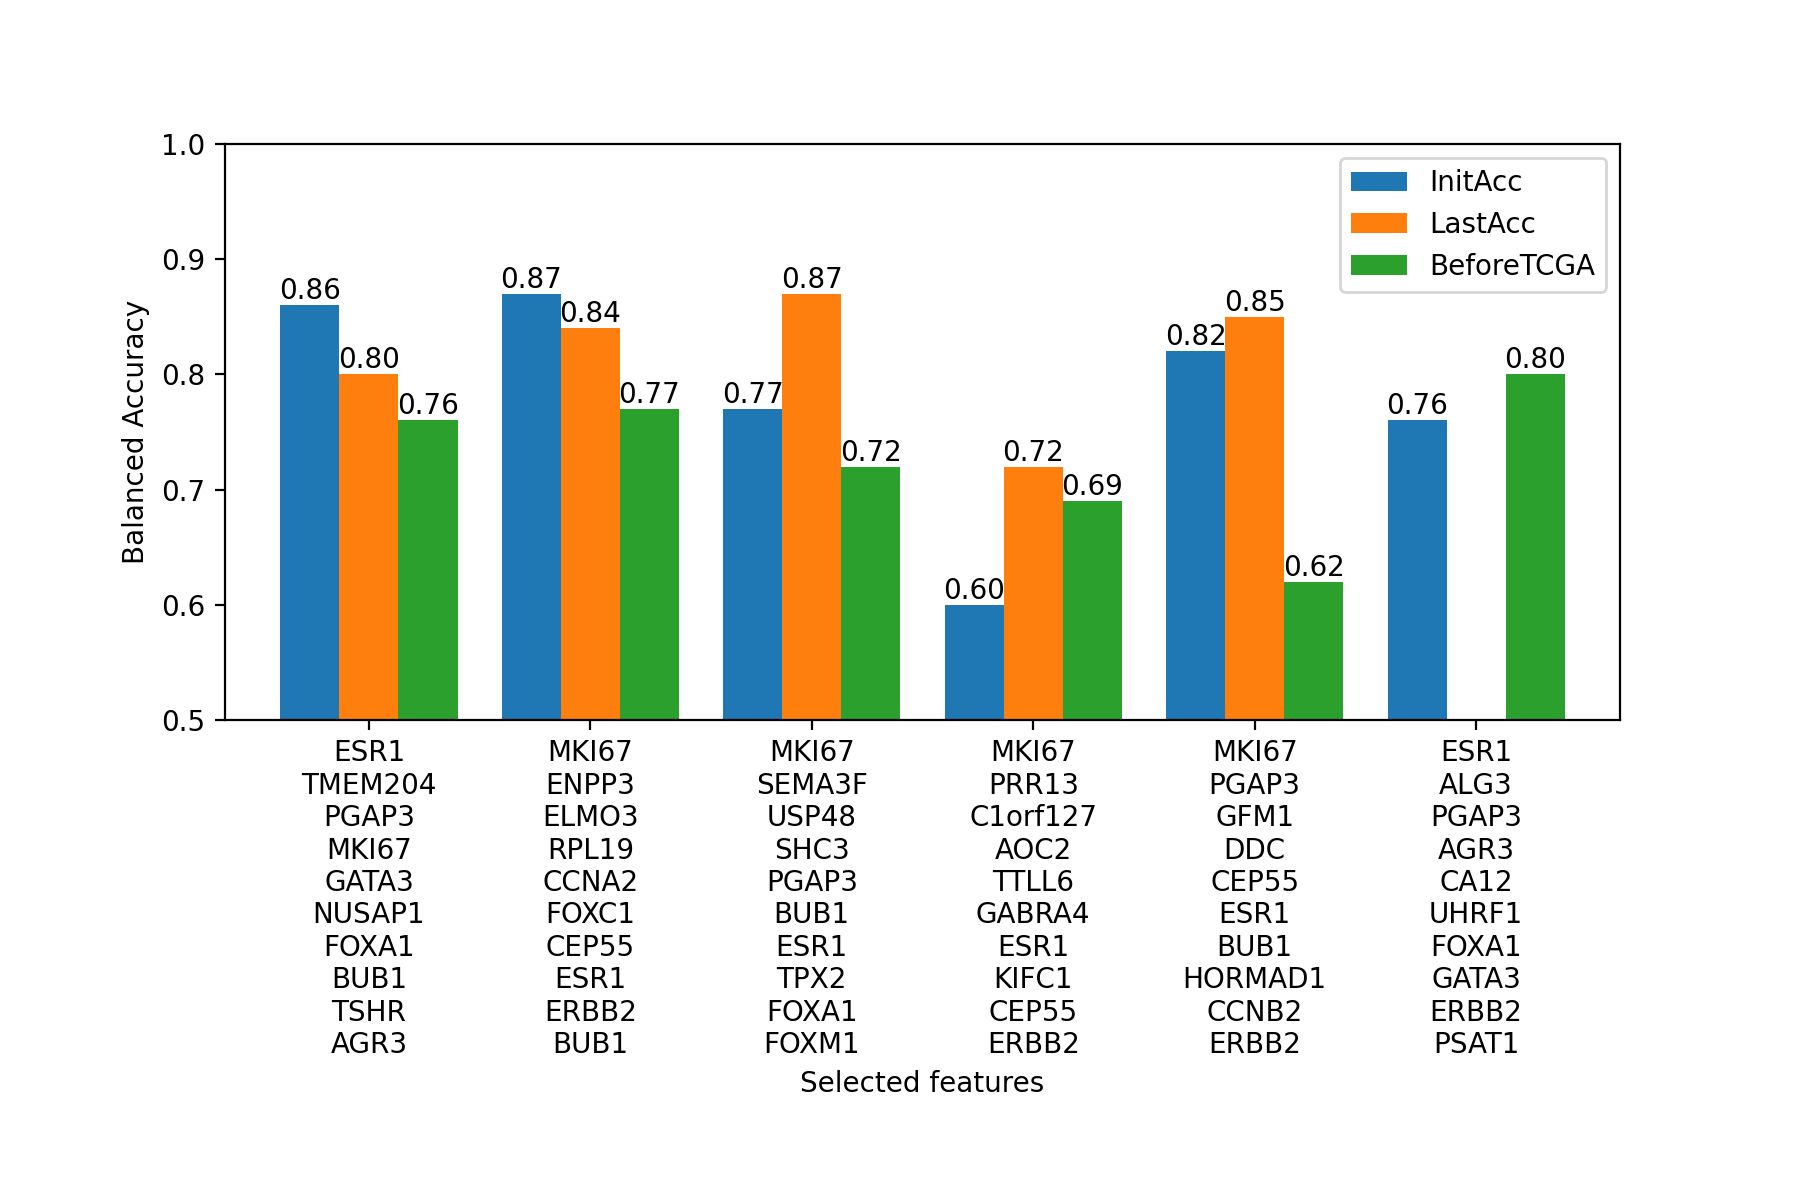

(0.5, 1.0)

In [154]:
#import pandas as pd
key = '500_2'

labels = []
for fs in res_mod_b1[key]['nbiosets'][1:]:
    labels.append('\n'.join(fs))

x = np.arange(6)
y1 = [round(item, 2) for item in res_mod_b1[key]['amodels']]
y2 = [round(item, 2) for item in res_mod_b1[key]['al_kbmet'][3355][1:]]
y3 = [round(item, 2) for item in res_mod_b1[key]['al_kbmet'][2821][1:]]
y3.append(0)

biom_df = pd.DataFrame({'FD': labels, 
                        'InitAcc': y1, 
                        'BeforeTCGA': y3,
                        'LastAcc': y2})

# set name as the index
biom_df.set_index('FD', inplace=True)

# plot and annotate
p1 = biom_df.plot(kind='bar', rot=0, width=.8, figsize=(9,6))

for p in p1.containers:
    p1.bar_label(p, fmt='%.2f', label_type='edge')
    
# Feature Drifts (selected features
    
plt.legend(["InitAcc", "LastAcc", "BeforeTCGA"], loc='upper right')
plt.xlabel('Selected features')
plt.ylabel('Balanced Accuracy')
plt.subplots_adjust(bottom=0.4)
plt.rcParams.update({'font.size': 10})
plt.ylim([0.5, 1])

[0.71, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


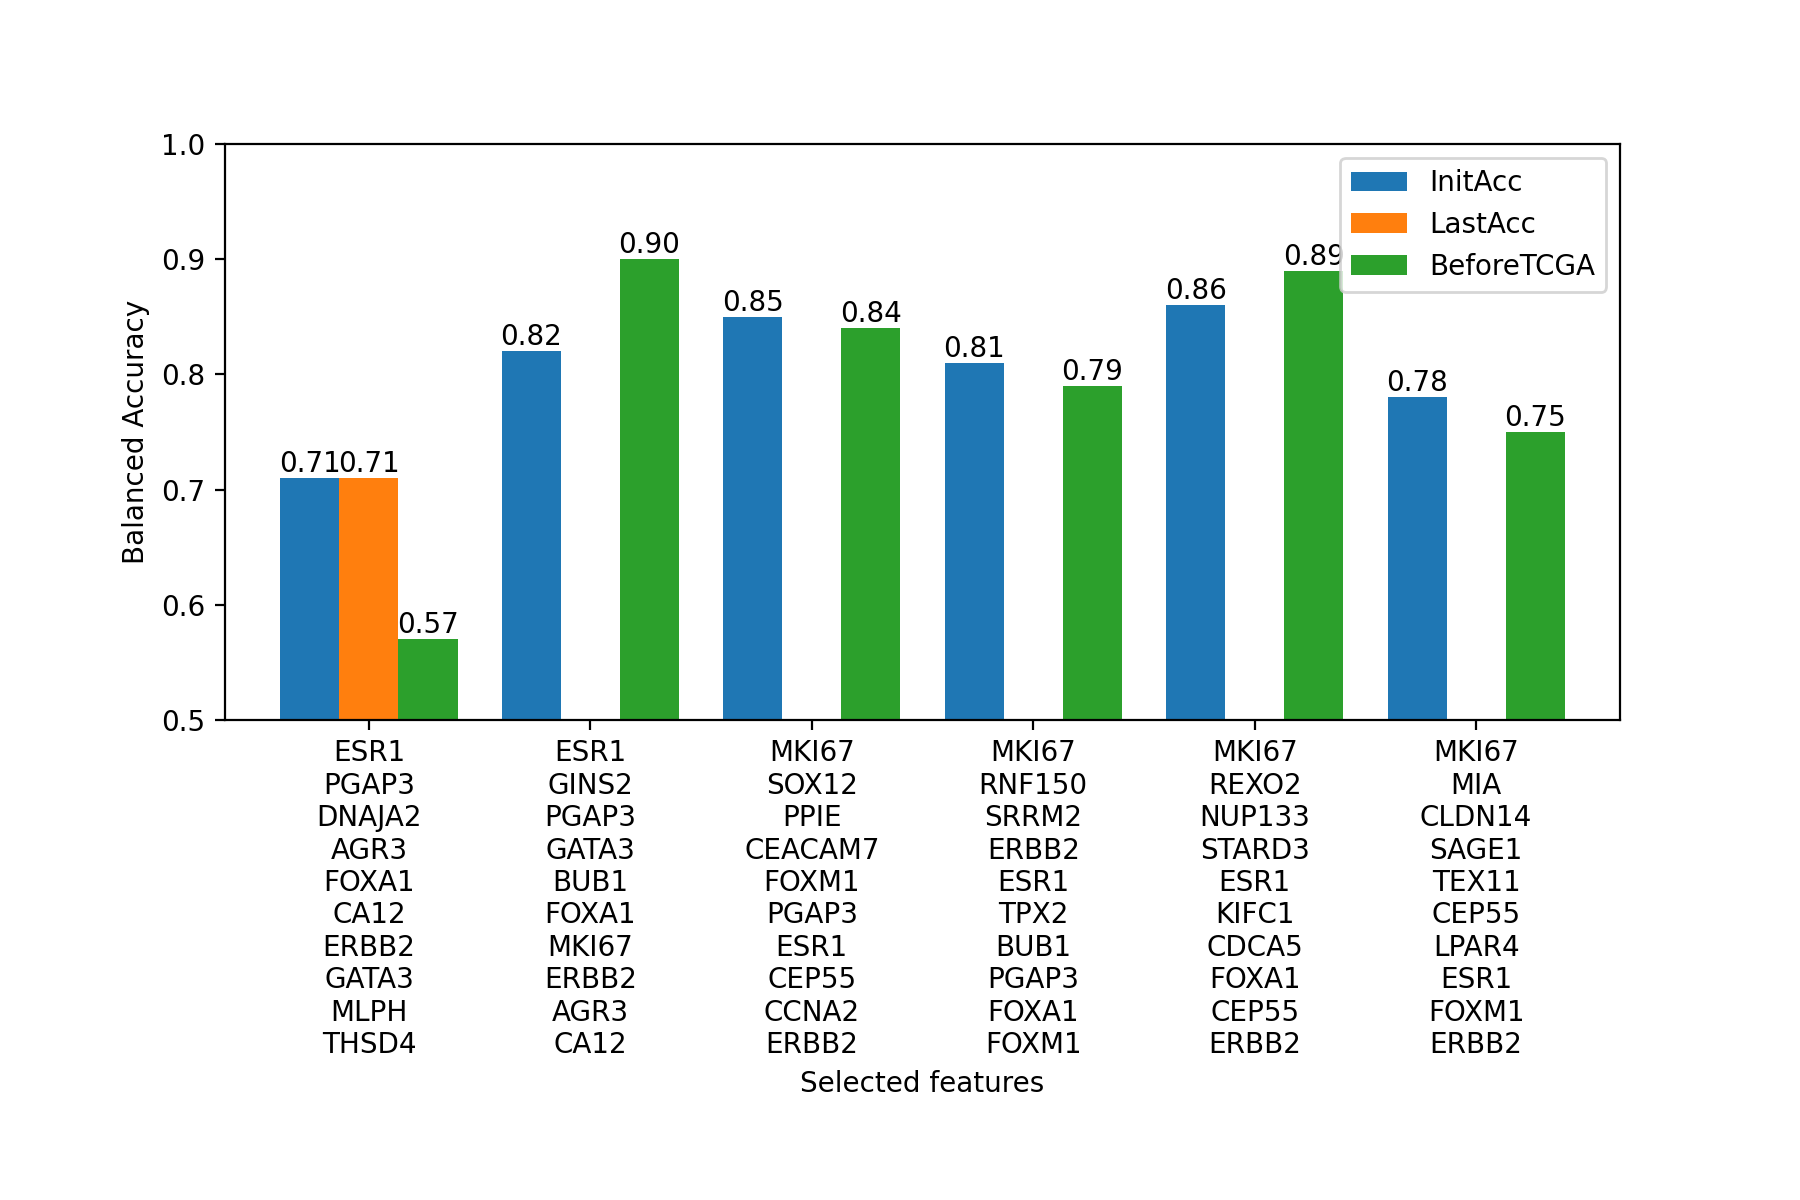

(0.5, 1.0)

In [157]:
#import pandas as pd
key = '500_2'

labels = []
for fs in res_mod_c1[key]['nbiosets'][1:]:
    labels.append('\n'.join(fs))

x = np.arange(6)
y1 = [round(item, 2) for item in res_mod_c1[key]['amodels']]
y2 = [round(item, 2) for item in res_mod_c1[key]['al_kbmet'][3355][1:]]
y3 = [round(item, 2) for item in res_mod_c1[key]['al_kbmet'][533][1:]]
[y3.append(0) for _ in range(5)]
print(y3)

biom_df = pd.DataFrame({'FD': labels, 
                        'InitAcc': y1, 
                        'BeforeSCANB': y3,
                        'LastAcc': y2})

# set name as the index
biom_df.set_index('FD', inplace=True)

# plot and annotate
p1 = biom_df.plot(kind='bar', rot=0, width=.8, figsize=(9,6))

for p in p1.containers:
    p1.bar_label(p, fmt='%.2f', label_type='edge')
    
# Feature Drifts (selected features
    
plt.legend(["InitAcc", "LastAcc", "BeforeTCGA"], loc='upper right')
plt.xlabel('Selected features')
plt.ylabel('Balanced Accuracy')
plt.subplots_adjust(bottom=0.4)
plt.rcParams.update({'font.size': 10})
plt.ylim([0.5, 1])

In [276]:
key = '500_2'

labels = []
for fs1, fs2 in zip(res_mod_b1[key]['nbiosets'][1:], res_mod_c1[key]['nbiosets'][1:]):
    print(set(fs1).intersection(set(fs2)))
    print(len(set(fs1).intersection(set(fs2))) / len(set(fs1).union(set(fs2))))   
print("-----")
fs1 = list(set().union(*res_mod_b1[key]['nbiosets'][1:]))
fs2 = list(set().union(*res_mod_c1[key]['nbiosets'][1:]))
print(set(fs1).intersection(set(fs2)))
print(len(set(fs1).intersection(set(fs2))) / len(set(fs1).union(set(fs2))))   

{'FOXA1', 'GATA3', 'PGAP3', 'ESR1', 'AGR3'}
0.3333333333333333
{'ESR1', 'BUB1', 'MKI67', 'ERBB2'}
0.25
{'ESR1', 'FOXM1', 'MKI67', 'PGAP3'}
0.25
{'ESR1', 'MKI67', 'ERBB2'}
0.17647058823529413
{'ESR1', 'MKI67', 'ERBB2', 'CEP55'}
0.25
{'ESR1', 'ERBB2'}
0.1111111111111111
-----
{'FOXA1', 'FOXM1', 'GATA3', 'PGAP3', 'CEP55', 'CCNA2', 'BUB1', 'ESR1', 'MKI67', 'TPX2', 'ERBB2', 'KIFC1', 'CA12', 'AGR3'}
0.25925925925925924


In [159]:
def online_complot(r_list, keys, name_list, colors, switch = 0, switch_name = '', **plt_kwargs):
    
    fig, axs = plt.subplots(3, 2, figsize=(10,8))
    axs = axs.flatten()
    fig.suptitle('Performances')
    #
    for i in range(len(keys)):
        for j in range(len(r_list)):
            r = r_list[j]
            y = r[keys[i]]['up_enmet']
            x = list(range(0, len(y)))
            axs[i].plot(x, y, label = name_list[j], color = colors[j], **plt_kwargs)
            y = r[keys[i]]['up_kbmet']
            if name_list[j] != '[]':
                axs[i].plot(x, y, label = name_list[j] + '(NoEns)', linestyle="dotted", color = colors[j], **plt_kwargs)    
                
        # multiple lines all full height
        axs[i].vlines(x=switch, ymin=0, ymax=1, colors='purple', ls='--', lw=2, label=switch_name)

        axs[i].title.set_text(str(keys[i]))
        if i > 3:
            axs[i].set_xlabel('Online instances')
        axs[i].set_xlim([200, len(y)+100])
        if (i % 2) == 0:
            axs[i].set_ylabel('Balanced Accuracy')
        axs[i].set_ylim([0.3, 1])
        axs[i].grid(color='gray', linestyle='-', linewidth=.5)
        #axs[i].legend()
        
    fig.tight_layout()    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.15),
               ncol=2, fancybox=True, shadow=True)
    fig.subplots_adjust(bottom=0.2)
    return(fig)

<IPython.core.display.Javascript object>


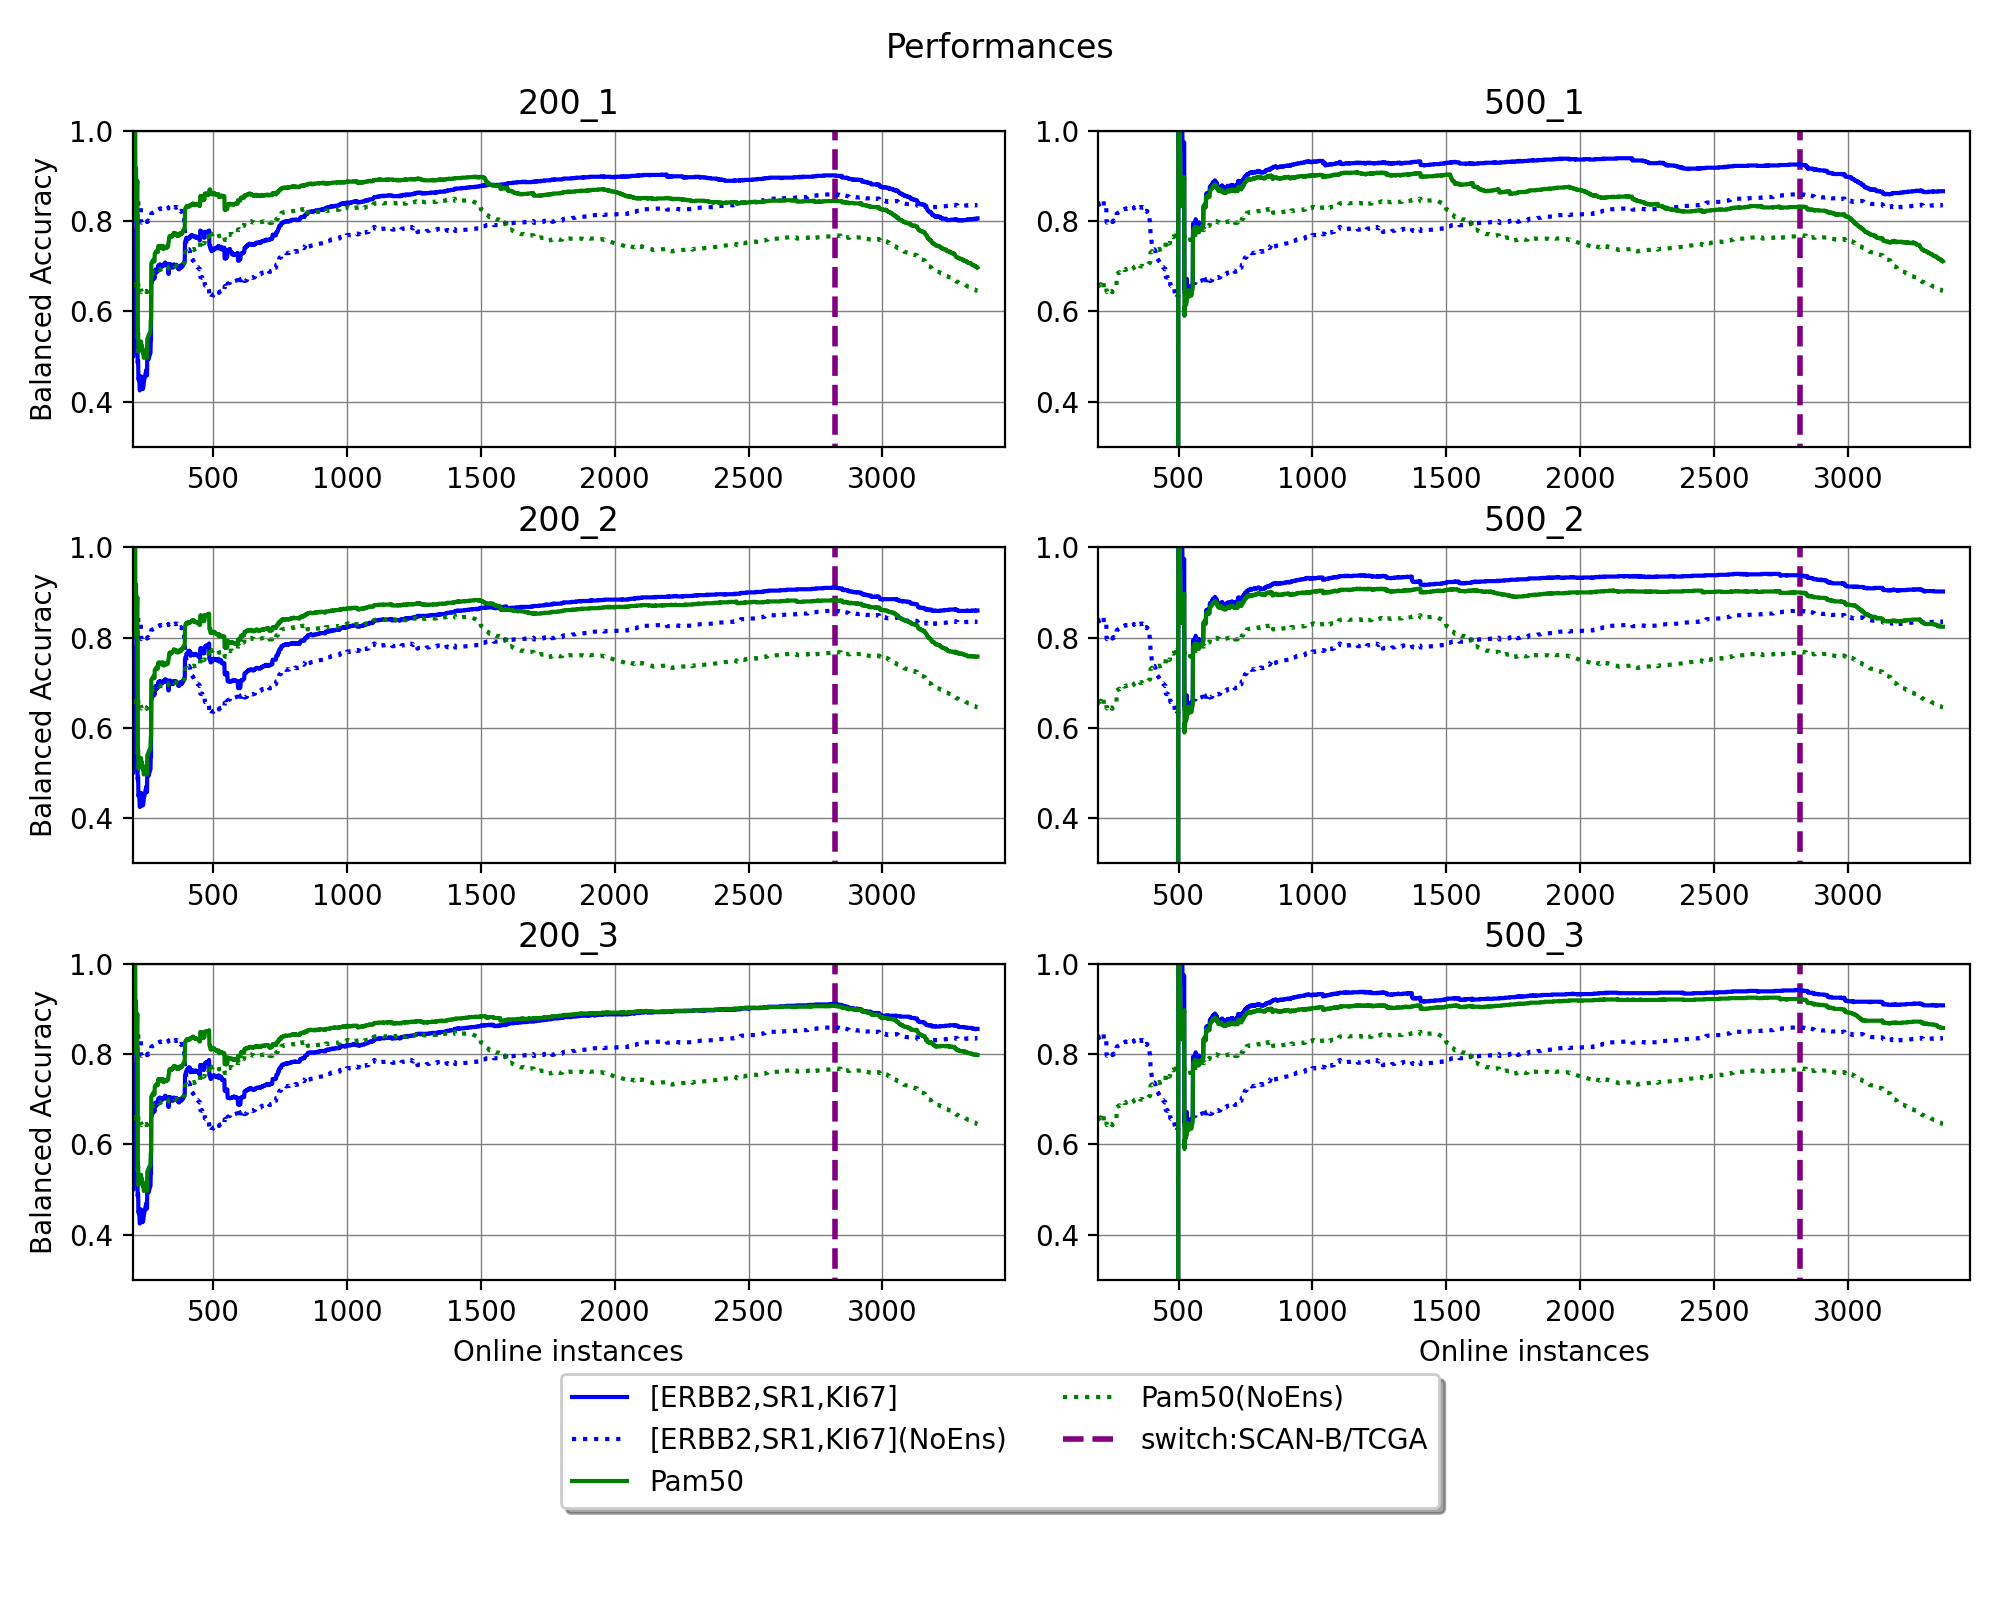

In [160]:
plt.rcParams.update({'font.size': 10})
online_complot([res_mod_b1, res_mod_b2], 
               ['200_1', '500_1', '200_2', '500_2', '200_3', '500_3'], 
               ['[ERBB2,SR1,KI67]', 'Pam50'],
               colors = ['blue','green'],
               switch = 2821, switch_name = 'switch:SCAN-B/TCGA')
plt.show()
plt.savefig('comp_pam50_ESK_1.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


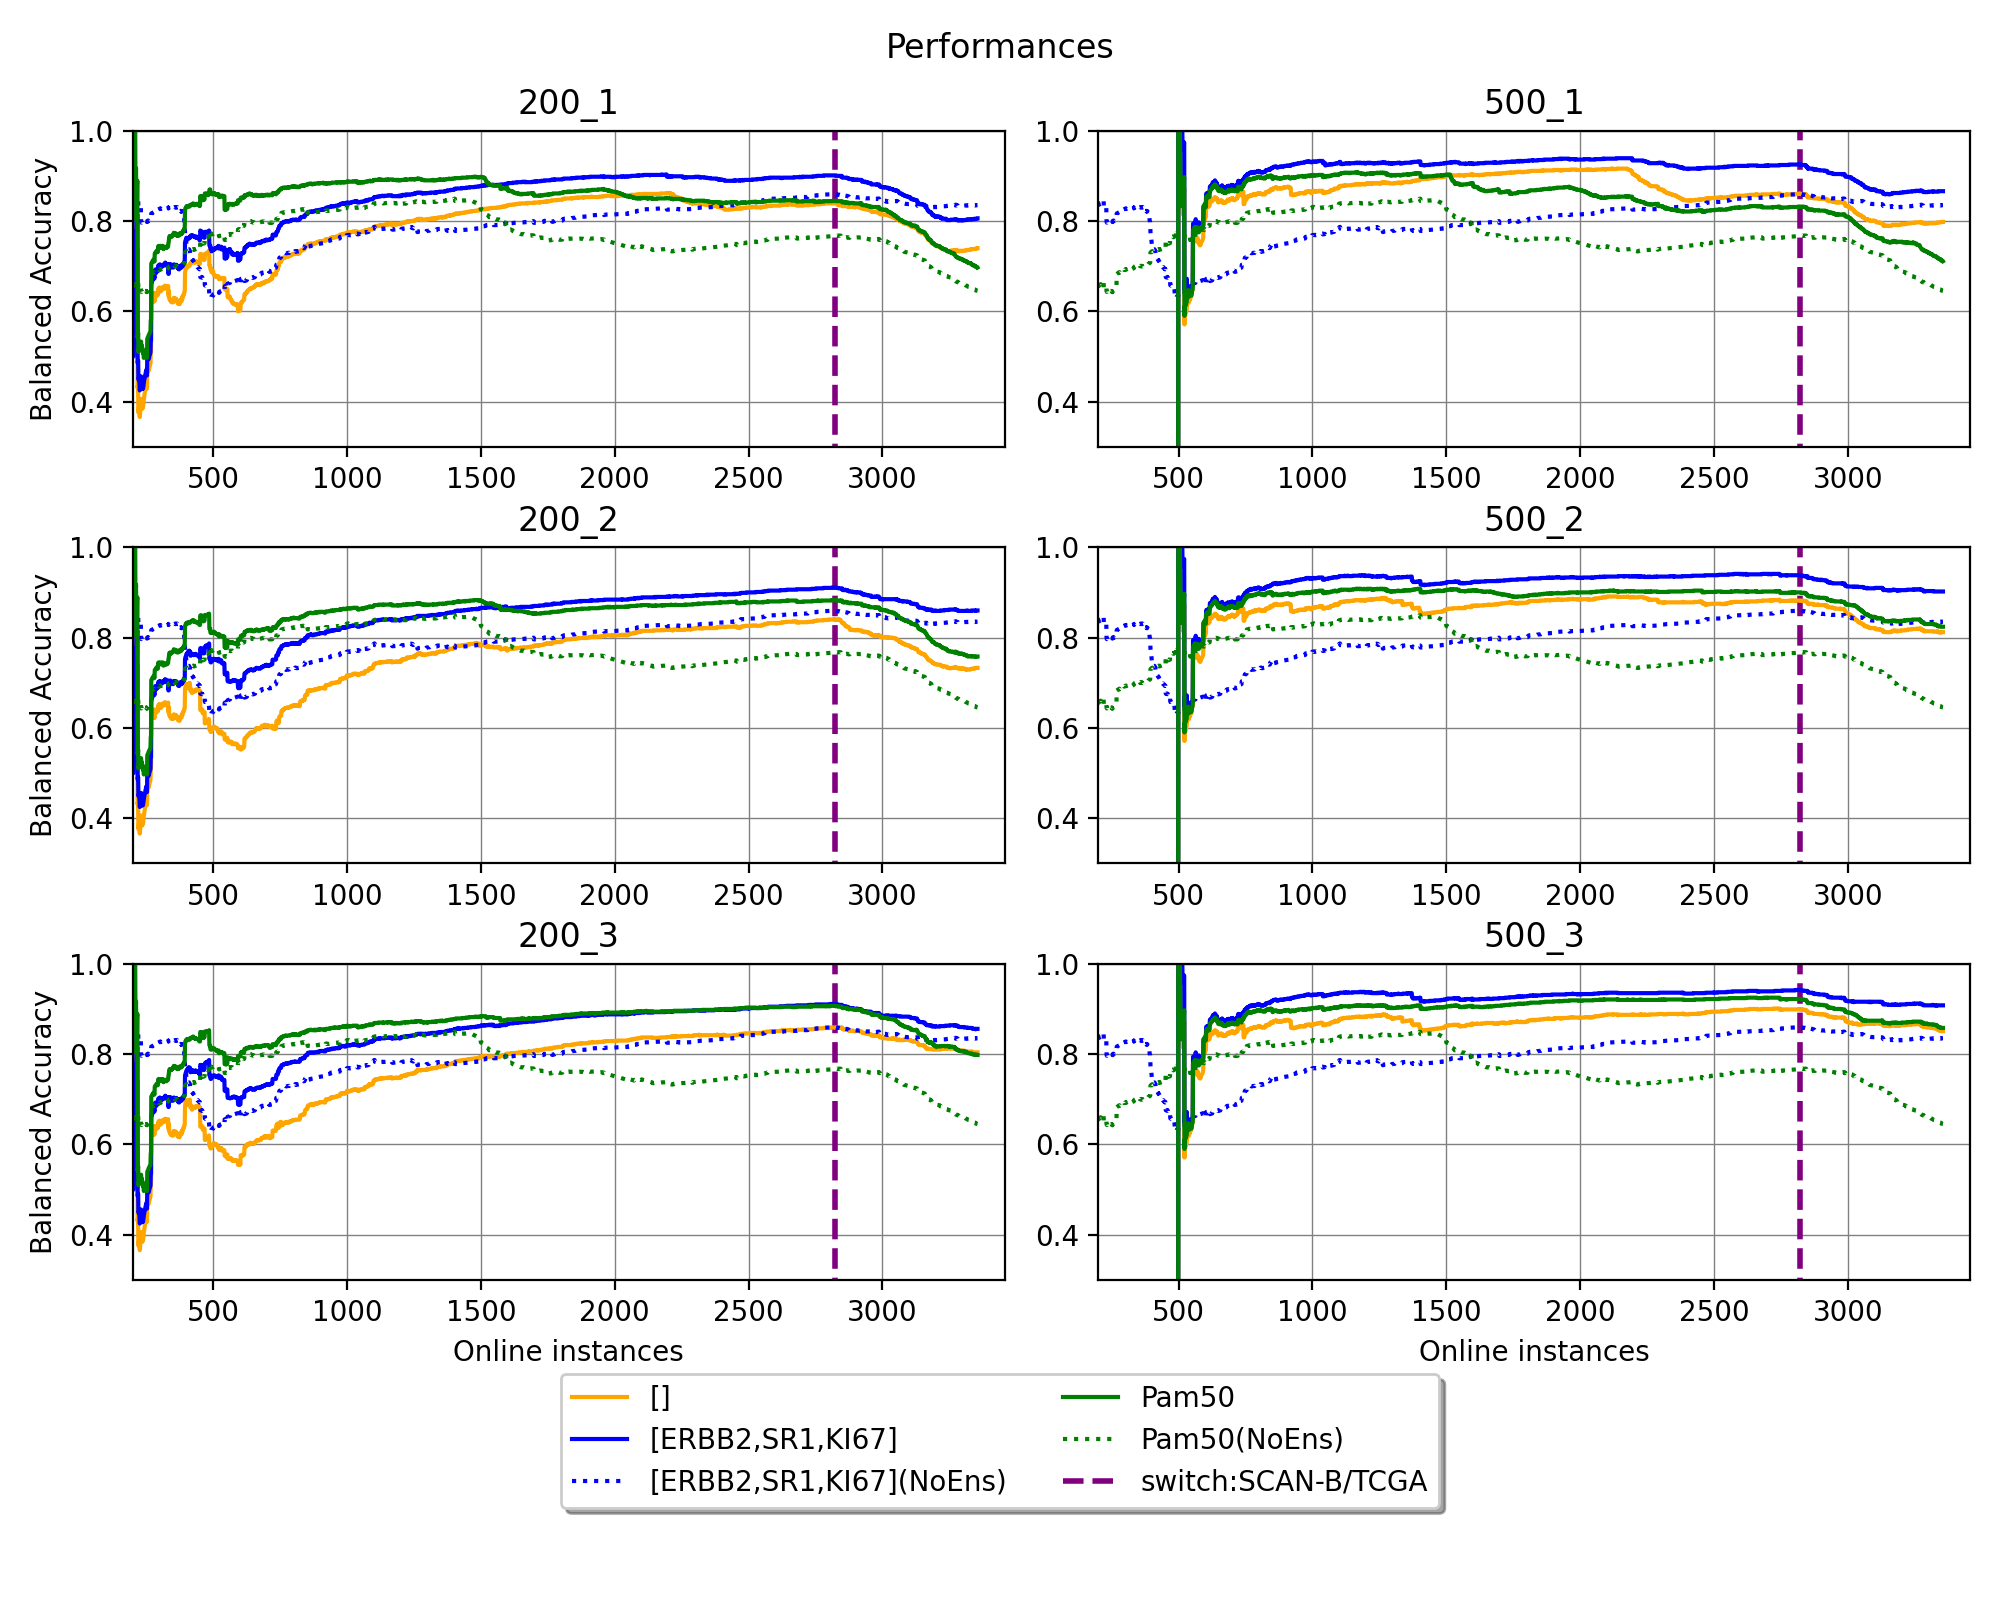

In [162]:
plt.rcParams.update({'font.size': 10})
online_complot([res_mod_b0, res_mod_b1, res_mod_b2], 
               ['200_1', '500_1', '200_2', '500_2', '200_3', '500_3'], 
               ['[]', '[ERBB2,SR1,KI67]', 'Pam50'],
               colors = ['orange','blue','green'],
               switch = 2821, switch_name = 'switch:SCAN-B/TCGA')
plt.show()
plt.savefig('comp_noBio_pam50_ESK.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


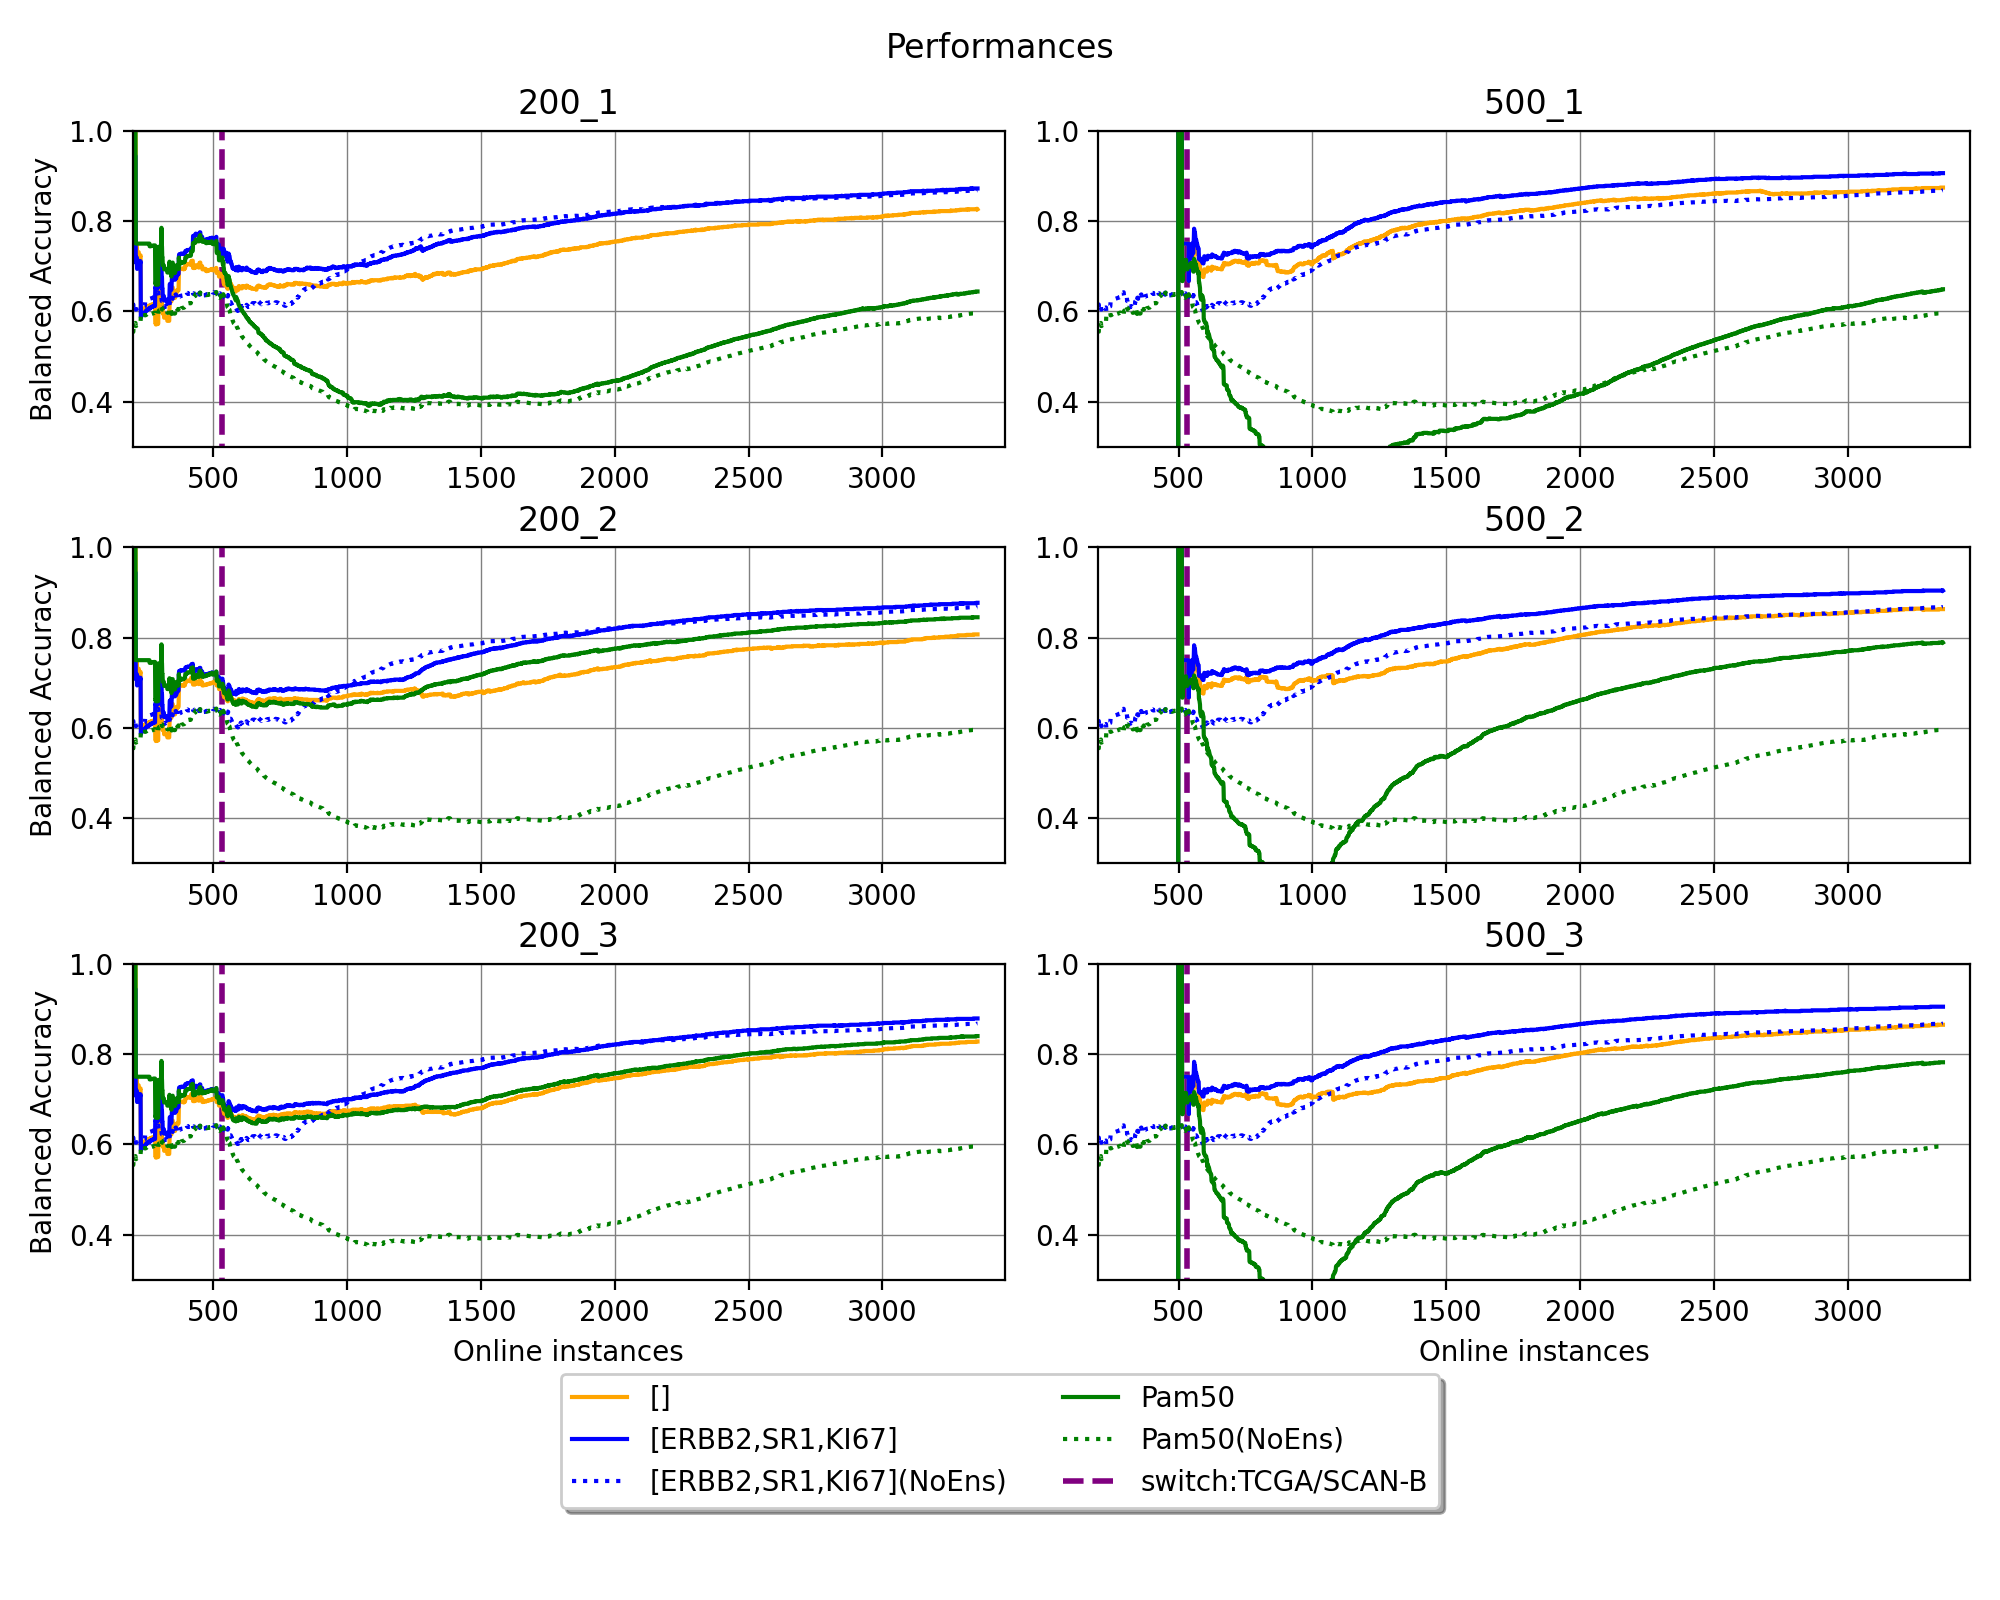

In [163]:
plt.rcParams.update({'font.size': 10})
online_complot([res_mod_c0, res_mod_c1, res_mod_c2], 
               ['200_1', '500_1', '200_2', '500_2', '200_3', '500_3'], 
               ['[]', '[ERBB2,SR1,KI67]', 'Pam50'],
               colors = ['orange','blue','green'],
               switch = 533, switch_name = 'switch:TCGA/SCAN-B')
plt.show()
plt.savefig('comp_switch_TCGA_SCANB.pdf', bbox_inches='tight')

In [141]:
print(len(res_mod_b1['200_1']['biosets'][5]))
print(len(res_mod_b1['500_1']['biosets'][5]))
print(len(res_mod_b2['200_1']['biosets'][5]))
print(len(res_mod_b2['500_1']['biosets'][5]))
print(len(res_mod_b3['200_1']['biosets'][5]))
print(len(res_mod_b3['500_1']['biosets'][5]))
print(len(res_mod_b4['200_1']['biosets'][5]))
print(len(res_mod_b4['500_1']['biosets'][5]))
#endopred
#oncopedsig
#biom_list_pam50

44
36
85
77
55
47
61
53


Intersection between newly discovered biomarkers and the M3 biomarkers



In [208]:
print(len(list(set.intersection(set(res_mod_b2['200_1']['biosets'][5]), set(['ESR1', 'MKI67', 'ERBB2'])))))
print(len(list(set.intersection(set(res_mod_b2['500_1']['biosets'][5]), set(['ESR1', 'MKI67', 'ERBB2'])))))
print(len(list(set.intersection(set(res_mod_b3['200_1']['biosets'][5]), set(['ESR1', 'MKI67', 'ERBB2'])))))
print(len(list(set.intersection(set(res_mod_b3['500_1']['biosets'][5]), set(['ESR1', 'MKI67', 'ERBB2'])))))
print(len(list(set.intersection(set(res_mod_b4['200_1']['biosets'][5]), set(['ESR1', 'MKI67', 'ERBB2'])))))
print(len(list(set.intersection(set(res_mod_b4['500_1']['biosets'][5]), set(['ESR1', 'MKI67', 'ERBB2'])))))

3
3
3
3
3
3


Intersection between newly discovered biomarkers and the pam50 biomarkers

In [204]:
print(len(list(set.intersection(set(res_mod_b1['200_1']['biosets'][5]), set(biom_list_pam50)))))
print(len(list(set.intersection(set(res_mod_b1['500_1']['biosets'][5]), set(biom_list_pam50)))))
print(len(list(set.intersection(set(res_mod_b3['200_1']['biosets'][5]), set(biom_list_pam50)))))
print(len(list(set.intersection(set(res_mod_b3['500_1']['biosets'][5]), set(biom_list_pam50)))))
print(len(list(set.intersection(set(res_mod_b4['200_1']['biosets'][5]), set(biom_list_pam50)))))
print(len(list(set.intersection(set(res_mod_b4['500_1']['biosets'][5]), set(biom_list_pam50)))))

6
6
8
8
14
14


Intersection between newly discovered biomarkers and the endopredict biomarkers

In [209]:
print(len(set(endopred)))
print(len(list(set.intersection(set(res_mod_b1['200_1']['biosets'][5]), set(endopred)))))
print(len(list(set.intersection(set(res_mod_b1['500_1']['biosets'][5]), set(endopred)))))
print(len(list(set.intersection(set(res_mod_b2['200_1']['biosets'][5]), set(endopred)))))
print(len(list(set.intersection(set(res_mod_b2['500_1']['biosets'][5]), set(endopred)))))
print(len(list(set.intersection(set(res_mod_b4['200_1']['biosets'][5]), set(endopred)))))
print(len(list(set.intersection(set(res_mod_b4['500_1']['biosets'][5]), set(endopred)))))

11
0
0
2
2
1
1


Intersection between newly discovered biomarkers and the oncopedx biomarkers

In [210]:
print(len(set(oncopedsig)))
print(len(list(set.intersection(set(res_mod_b1['200_1']['biosets'][5]), set(oncopedsig)))))
print(len(list(set.intersection(set(res_mod_b1['500_1']['biosets'][5]), set(oncopedsig)))))
print(len(list(set.intersection(set(res_mod_b2['200_1']['biosets'][5]), set(oncopedsig)))))
print(len(list(set.intersection(set(res_mod_b2['500_1']['biosets'][5]), set(oncopedsig)))))
print(len(list(set.intersection(set(res_mod_b3['200_1']['biosets'][5]), set(oncopedsig)))))
print(len(list(set.intersection(set(res_mod_b3['500_1']['biosets'][5]), set(oncopedsig)))))

20
3
3
11
11
4
4


Intersection between SELECTED FEATURE SETS: SCAN-B/TCGA VS. TCGA/SCAN-B

In [223]:
print(len(list(set.intersection(set(res_mod_b0['200_1']['biosets'][5]), set(res_mod_c0['200_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b0['200_1']['biosets'][5]), set(res_mod_c0['200_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b0['500_1']['biosets'][5]), set(res_mod_c0['500_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b0['500_1']['biosets'][5]), set(res_mod_c0['500_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b1['200_1']['biosets'][5]), set(res_mod_c1['200_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b1['200_1']['biosets'][5]), set(res_mod_c1['200_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b1['500_1']['biosets'][5]), set(res_mod_c1['500_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b1['500_1']['biosets'][5]), set(res_mod_c1['500_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b2['200_1']['biosets'][5]), set(res_mod_c2['200_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b2['200_1']['biosets'][5]), set(res_mod_c2['200_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b2['500_1']['biosets'][5]), set(res_mod_c2['500_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b2['500_1']['biosets'][5]), set(res_mod_c2['500_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b3['200_1']['biosets'][5]), set(res_mod_c3['200_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b3['200_1']['biosets'][5]), set(res_mod_c3['200_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b3['500_1']['biosets'][5]), set(res_mod_c3['500_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b3['500_1']['biosets'][5]), set(res_mod_c3['500_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b4['200_1']['biosets'][5]), set(res_mod_c4['200_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b4['200_1']['biosets'][5]), set(res_mod_c4['200_1']['biosets'][5])))))
print(len(list(set.intersection(set(res_mod_b4['500_1']['biosets'][5]), set(res_mod_c4['500_1']['biosets'][5]))))/len(list(set.union(set(res_mod_b4['500_1']['biosets'][5]), set(res_mod_c4['500_1']['biosets'][5])))))

0.1917808219178082
0.25925925925925924
0.1917808219178082
0.25925925925925924
0.48672566371681414
0.6021505376344086
0.2976190476190476
0.38461538461538464
0.34444444444444444
0.43661971830985913


<IPython.core.display.Javascript object>


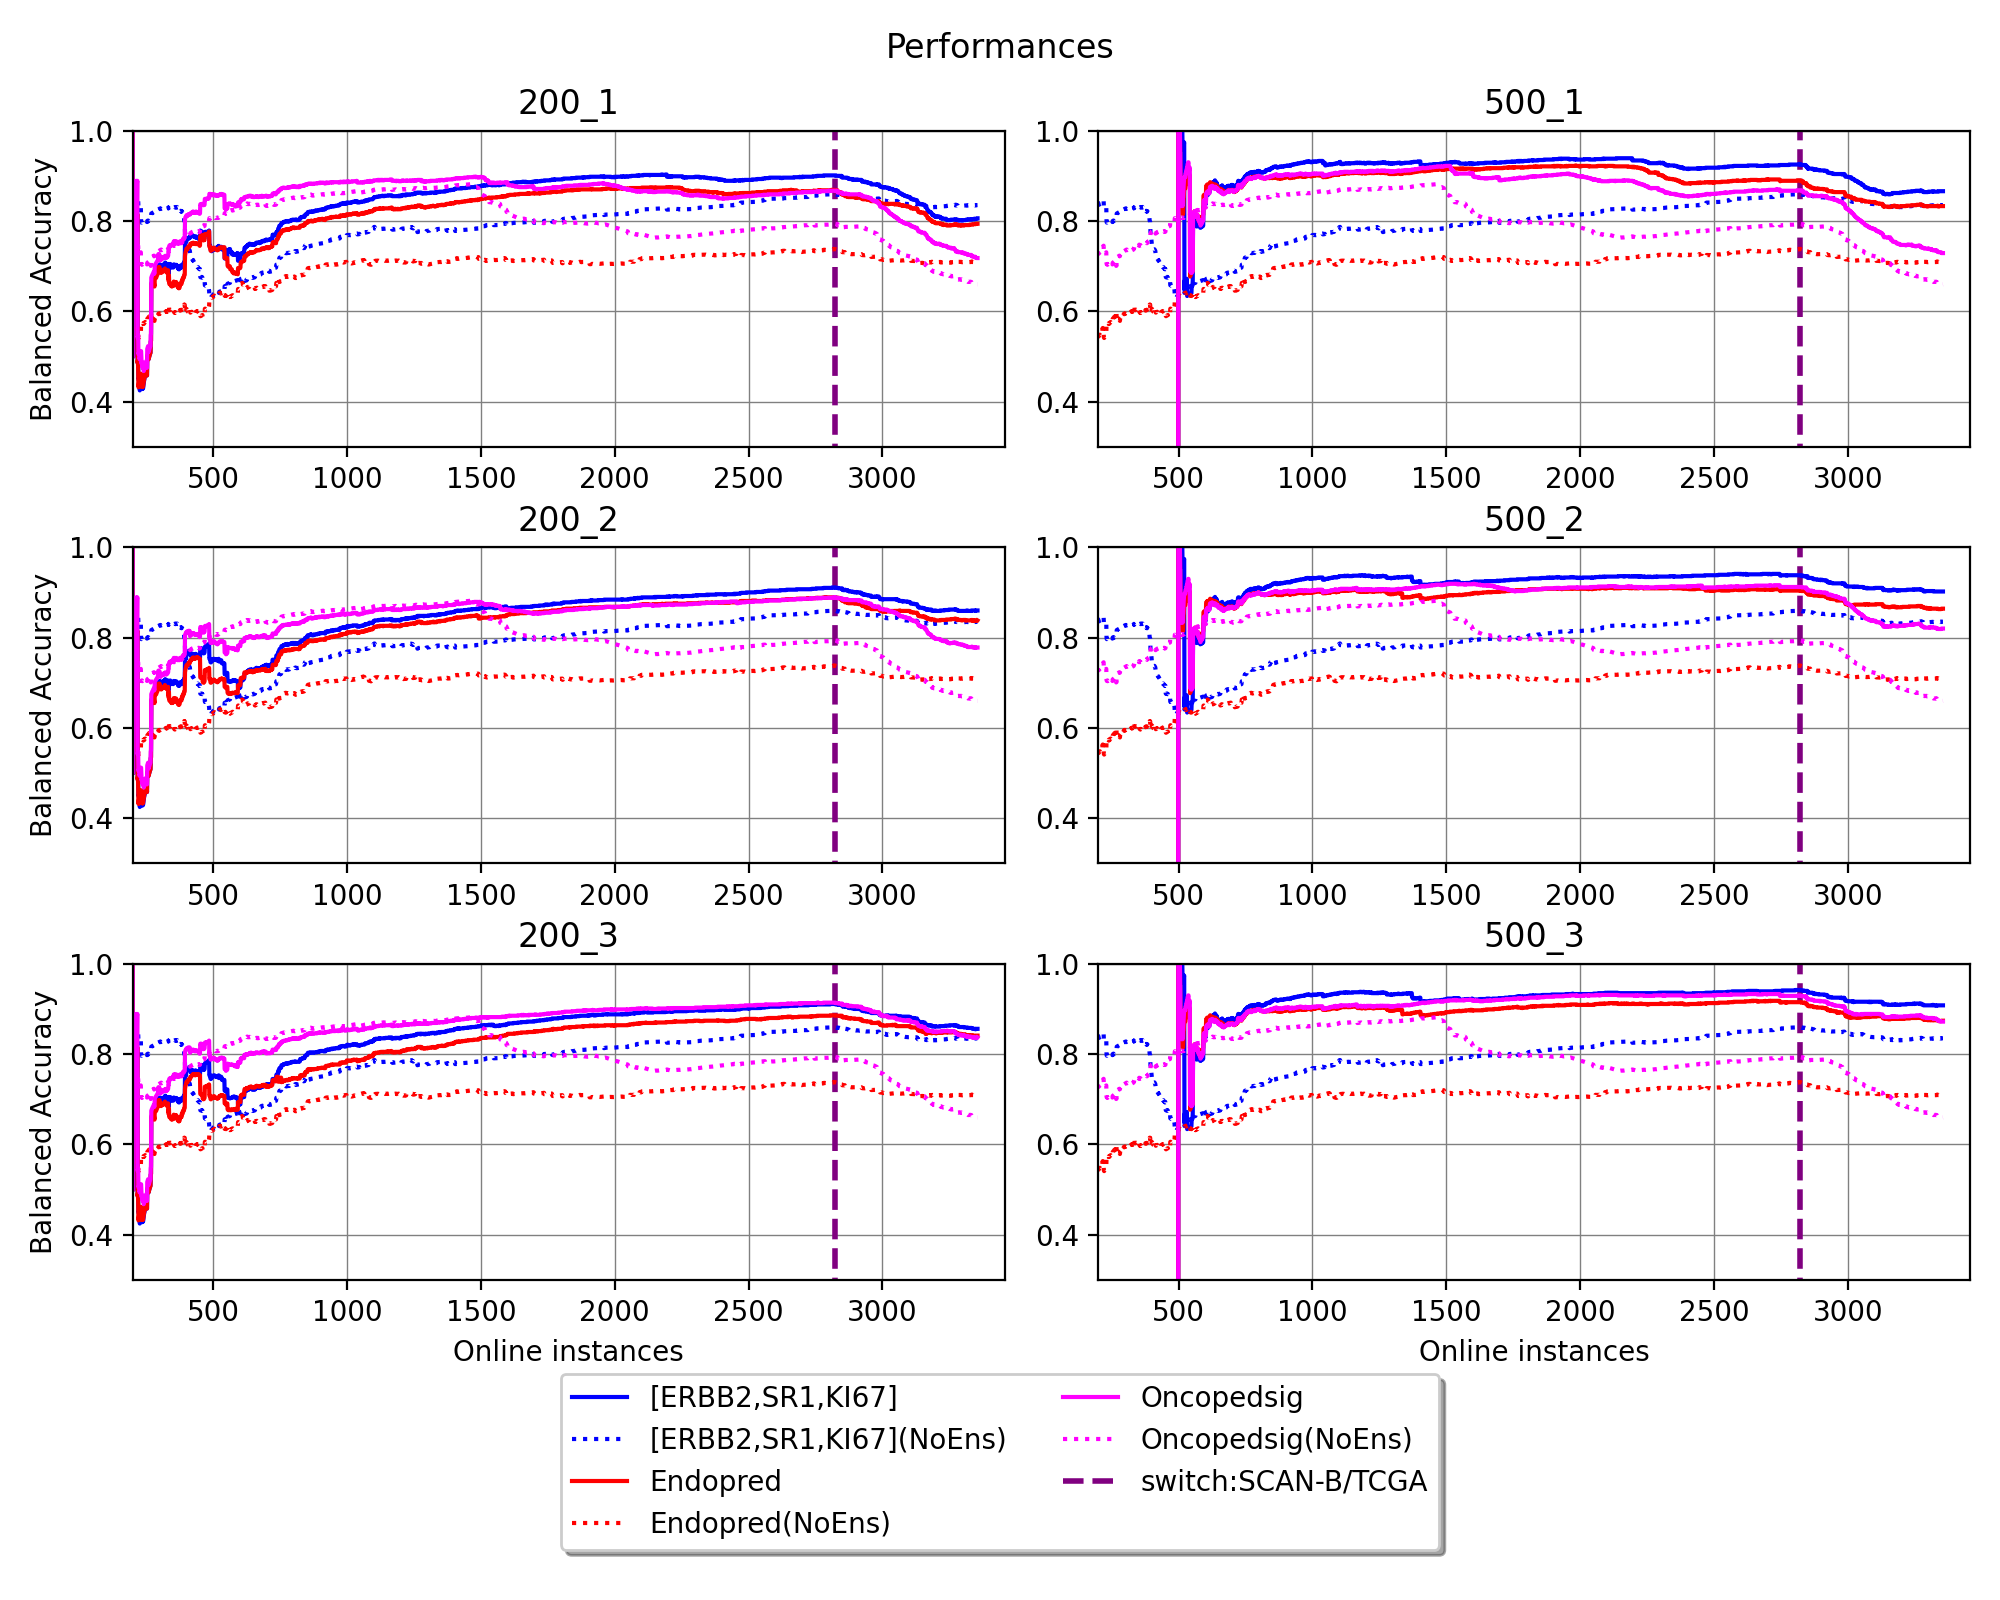

In [225]:
plt.rcParams.update({'font.size': 10})
online_complot([res_mod_b1, res_mod_b3, res_mod_b4], 
               ['200_1', '500_1', '200_2', '500_2', '200_3', '500_3'], 
               ['[ERBB2,SR1,KI67]', 'Endopred', 'Oncopedsig'],
               colors = ['blue','red','magenta'],
               switch = 2821, switch_name = 'switch:SCAN-B/TCGA')
plt.show()
plt.savefig('comp_oas.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


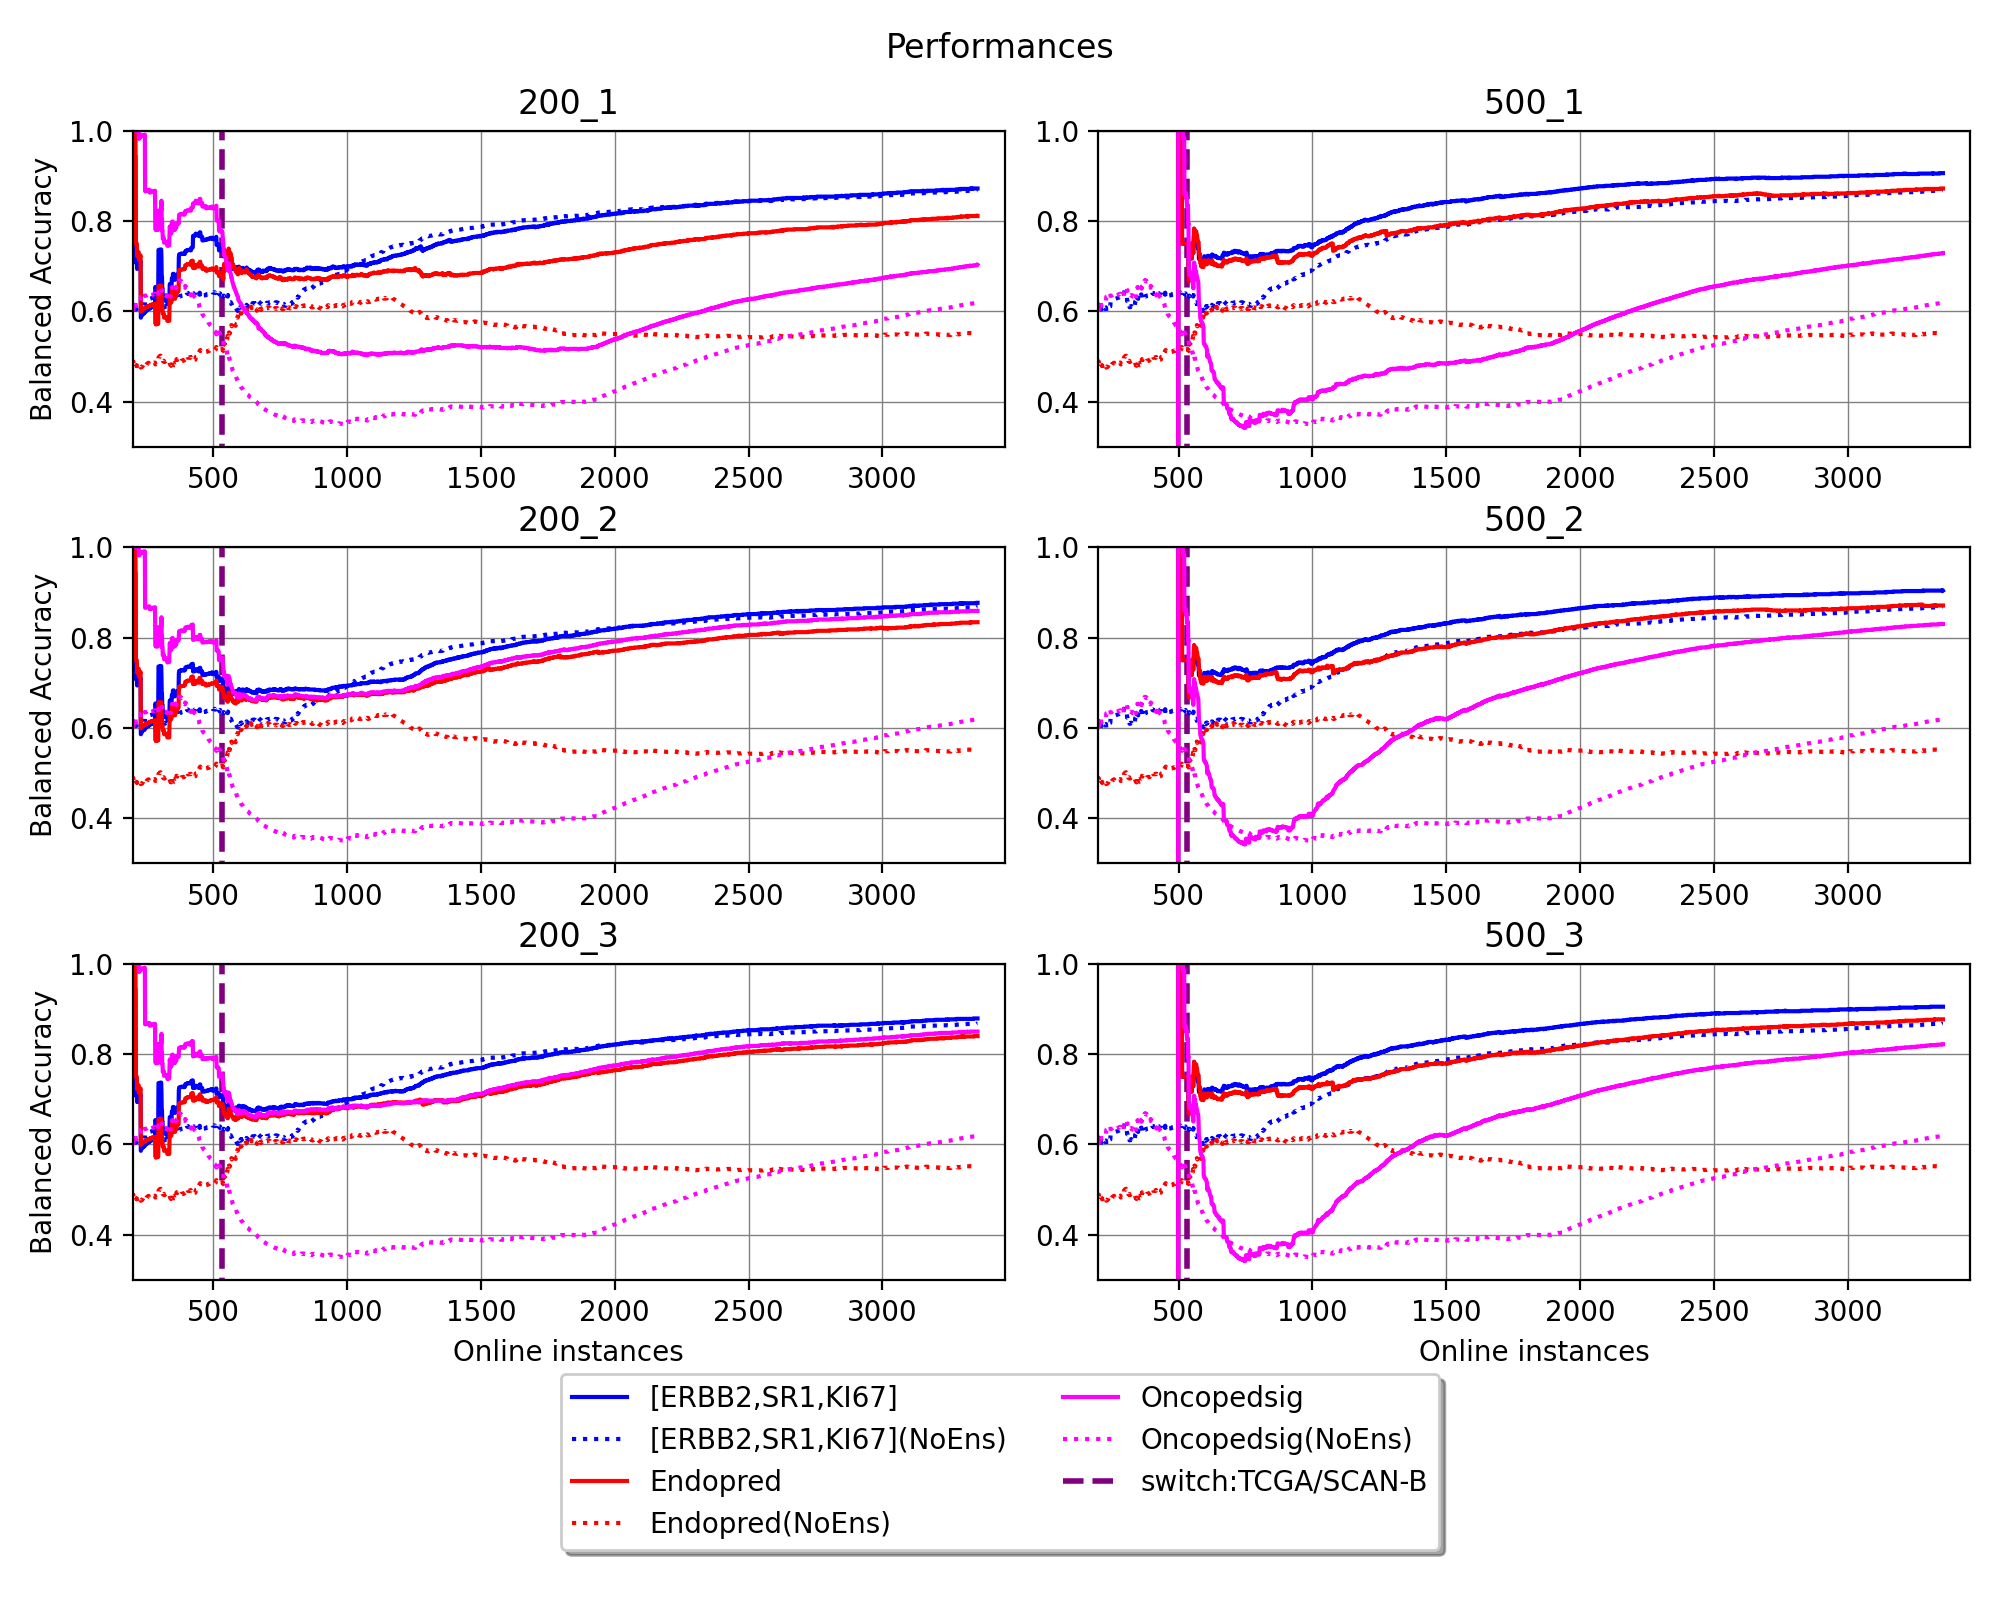

In [226]:
plt.rcParams.update({'font.size': 10})
online_complot([res_mod_c1, res_mod_c3, res_mod_c4], 
               ['200_1', '500_1', '200_2', '500_2', '200_3', '500_3'], 
               ['[ERBB2,SR1,KI67]', 'Endopred', 'Oncopedsig'],
               colors = ['blue','red','magenta'],
               switch = 533, switch_name = 'switch:TCGA/SCAN-B')
plt.show()
plt.savefig('comp_oas_switch_TCGA_SCANB.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


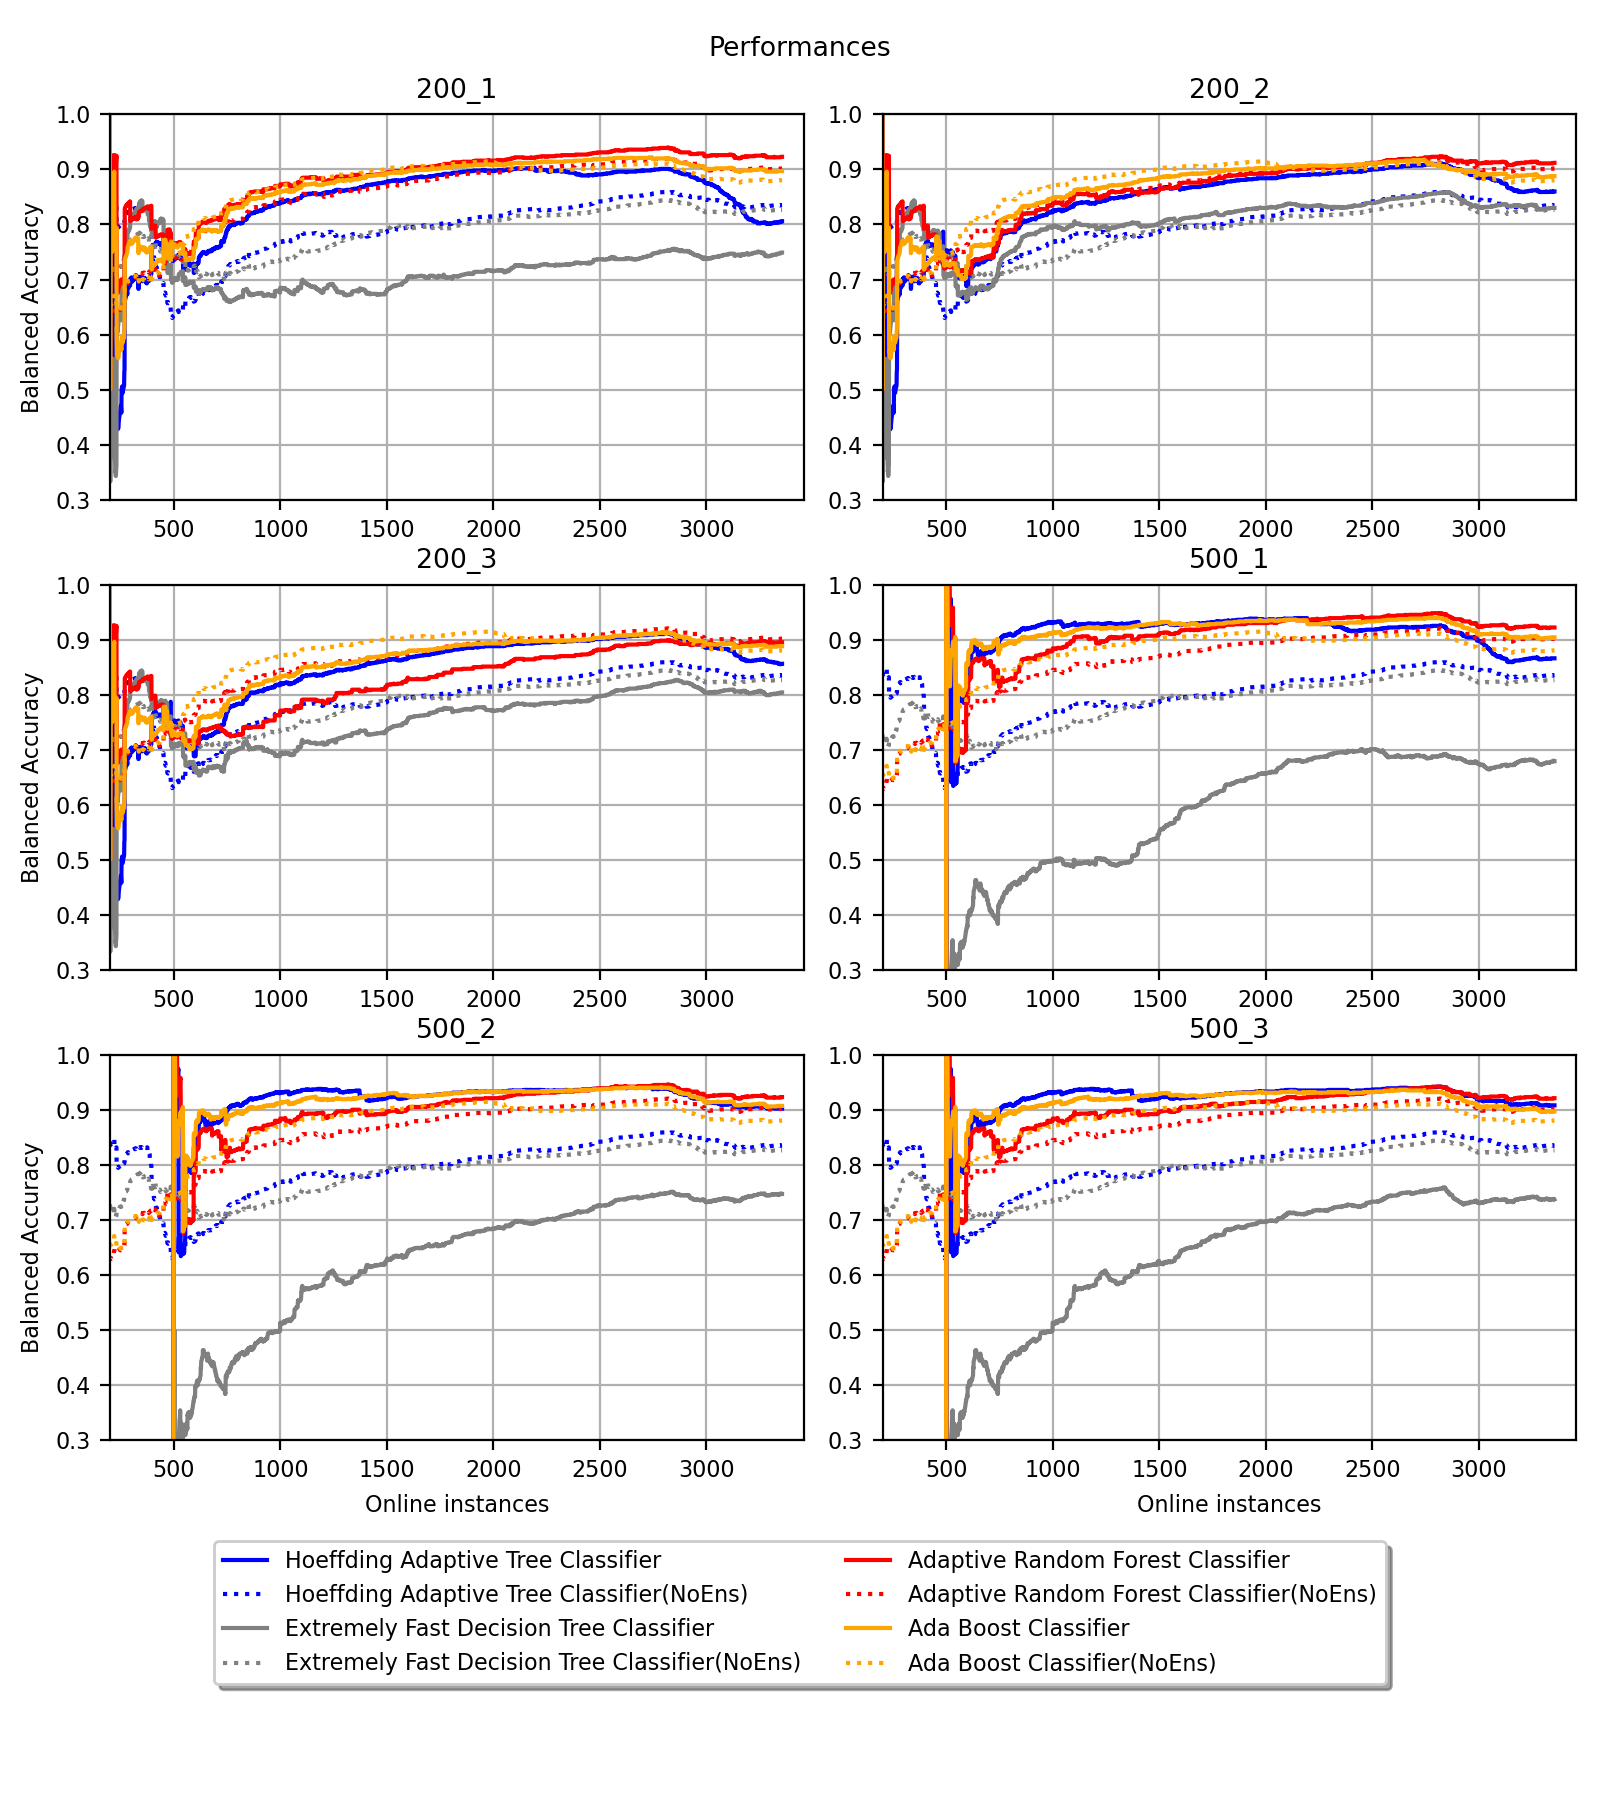

In [291]:
plt.rcParams.update({'font.size': 8})
online_complot([res_mod_n1, res_mod_n2, res_mod_n4, res_mod_n5], 
               ['200_1', '200_2', '200_3', '500_1', '500_2', '500_3'], 
               ['Hoeffding Adaptive Tree Classifier', 'Extremely Fast Decision Tree Classifier',
                'Adaptive Random Forest Classifier', 'Ada Boost Classifier'],
              colors = ['blue','gray','red','orange'])
plt.show()
plt.savefig('comp_oas2.pdf', bbox_inches='tight')

In [166]:
from collections import Counter
from itertools import chain

counter_obj = Counter(chain.from_iterable(res_mod_b1['500_2']['biosets']))

print(counter_obj.most_common())

[('ESR1', 6), ('TSHR', 6), ('FOXA1', 6), ('PGAP3', 6), ('MKI67', 6), ('BUB1', 6), ('NUSAP1', 6), ('AGR3', 6), ('ERBB2', 6), ('TMEM204', 6), ('GATA3', 6), ('CCNA2', 5), ('CEP55', 5), ('ELMO3', 5), ('FOXC1', 5), ('RPL19', 5), ('ENPP3', 5), ('SEMA3F', 4), ('TPX2', 4), ('SHC3', 4), ('USP48', 4), ('FOXM1', 4), ('TTLL6', 3), ('GABRA4', 3), ('KIFC1', 3), ('PRR13', 3), ('AOC2', 3), ('C1orf127', 3), ('HORMAD1', 2), ('CCNB2', 2), ('DDC', 2), ('GFM1', 2), ('ALG3', 1), ('PSAT1', 1), ('UHRF1', 1), ('CA12', 1)]


In [167]:
from itertools import chain
sel_feats = res_mod_b1['500_2']['biosets'][5]
#sel_feats = list(set(chain(*res_mod_1['500_3']['featsets'])))
sel_feats

['ESR1',
 'SEMA3F',
 'HORMAD1',
 'TSHR',
 'FOXA1',
 'ALG3',
 'TTLL6',
 'BUB1',
 'AGR3',
 'GABRA4',
 'KIFC1',
 'CCNB2',
 'PGAP3',
 'ENPP3',
 'AOC2',
 'C1orf127',
 'ERBB2',
 'GATA3',
 'DDC',
 'GFM1',
 'TPX2',
 'MKI67',
 'CCNA2',
 'CEP55',
 'ELMO3',
 'FOXC1',
 'PSAT1',
 'UHRF1',
 'CA12',
 'TMEM204',
 'PRR13',
 'SHC3',
 'RPL19',
 'NUSAP1',
 'USP48',
 'FOXM1']

In [211]:
sel_feats2 = res_mod_c1['500_2']['biosets'][5]
#sel_feats = list(set(chain(*res_mod_1['500_3']['featsets'])))
sel_feats2

['NUP133',
 'ESR1',
 'PPIE',
 'GINS2',
 'FOXA1',
 'CEACAM7',
 'RNF150',
 'TPX2',
 'MKI67',
 'BUB1',
 'CEP55',
 'CCNA2',
 'LPAR4',
 'AGR3',
 'SOX12',
 'CA12',
 'DNAJA2',
 'REXO2',
 'MIA',
 'KIFC1',
 'MLPH',
 'CLDN14',
 'THSD4',
 'SRRM2',
 'TEX11',
 'PGAP3',
 'STARD3',
 'FOXM1',
 'SAGE1',
 'ERBB2',
 'CDCA5',
 'GATA3']

In [213]:
print(len(sel_feats))
print(len(sel_feats2))
print(len(list(set.intersection(set(sel_feats), set(sel_feats2)))))

36
32
14


In [168]:
def online_plot(r, ax=None, **plt_kwargs):
    
    y1 = r['up_onmet']
    y2 = r['up_enmet']
    x1 = list(range(0, len(y1)))
    x2 = list(range(0, len(y2)))

    if ax is None:
        ax = plt.gca()
        
    ax.plot(x1, y1, label = "Hoeffding Tree", **plt_kwargs)
    ax.plot(x2, y2, label = "Hoeffding Tree + Ensemble of RFs", **plt_kwargs)    
    
    ax.set_ylabel('Balanced Accuracy (o)')
    ax.set_ylim([0, 1])
    
    ax.set_xlabel('Online instances')
    ax.set_xlim([500, len(y1)+100])
    
    for drift_detected in r['drifts']:
        ax.axvline(drift_detected, color='red')
        
    ax.grid()
    ax.legend()
    
    return(ax)

### 1.6 Assess clinical relevance of selected biomarkers

In [169]:
TIME_STR = 'time'
EVENT_STR = 'event'

In [170]:
import pandas as pd

def merge_x_y(x, y):
    if len(x) != len(y):
        raise ValueError("x and y have different lengths\n" + str(x) + "\n" + str(y))
    res = pd.concat([x.reset_index(drop=True), y.loc[:, [EVENT_STR, TIME_STR]].reset_index(drop=True)], axis=1)
    return res

In [171]:
from abc import abstractmethod, ABC
from lifelines import CoxPHFitter
from sksurv.linear_model import CoxPHSurvivalAnalysis

class CoxPredictor(ABC):

    @abstractmethod
    def score(self, x_test, y_test) -> float:
        raise NotImplementedError()

    @abstractmethod
    def p_vals(self):
        raise NotImplementedError()

    @abstractmethod
    def params(self):
        raise NotImplementedError()


class CoxModel(ABC):

    @abstractmethod
    def fit_estimator(self, x_train, y_train, alpha: float = 0.05) -> CoxPredictor:
        raise NotImplementedError()


class SKSurvCoxPredictor(CoxPredictor):

    __estimator: CoxPHSurvivalAnalysis

    def __init__(self, estimator: CoxPHSurvivalAnalysis):
        self.__estimator = estimator

    def score(self, x_test, y_test) -> float:
        return self.__estimator.score(x_test, y_test)

    def p_vals(self):
        raise NotImplementedError()

    def params(self):
        raise NotImplementedError()


class SKSurvCoxModel(CoxModel):

    def fit_estimator(self, x_train, y_train, alpha: float = 0.05) -> CoxPredictor:
        estimator = CoxPHSurvivalAnalysis(alpha=alpha).fit(x_train, y_train)
        return SKSurvCoxPredictor(estimator)


class LifelinesCoxPredictor(CoxPredictor):
    __estimator: CoxPHFitter

    def __init__(self, estimator: CoxPHFitter):
        self.__estimator = estimator

    @staticmethod
    def merge_x_y(x, y):
        return merge_x_y(x=x, y=y)

    def score(self, x_test, y_test) -> float:
        df = self.merge_x_y(x=x_test, y=y_test)
        return self.__estimator.score(df, scoring_method="concordance_index")

    def p_vals(self):
        summary = self.__estimator.summary
        return summary['p']

    def params(self):
        return self.__estimator.params_
    
    def inner_estimator(self) -> CoxPHFitter:
        return self.__estimator
    
    def hazard_ratios(self):
        #s = self.__estimator.hazard_ratios_
        return self.__estimator.summary
        #return list(zip(s.index, s))

class LifelinesCoxModel(CoxModel):

    def fit_estimator(self, x_train, y_train, alpha: float = 0.05) -> CoxPredictor:
        df = LifelinesCoxPredictor.merge_x_y(x=x_train, y=y_train)
        if df.isnull().values.any():
            print("Nulls detected in the dataframe")
            print(df.isnull())
        estimator = CoxPHFitter(penalizer=alpha, l1_ratio=0).fit(df=df, duration_col='time', event_col='event')
        #print(estimator.print_summary())
        return LifelinesCoxPredictor(estimator)

In [172]:
from statistics import mean
import sklearn

def create_folds(x, y, n_folds: int = 10, seed=4985):
    skf = sklearn.model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    res = []
    y_event = y[[EVENT_STR]]
    for train_index, test_index in skf.split(X=x, y=y_event):
        res.append([train_index, test_index])
    return res

def train_test_one_fold(x_train, y_train, x_test, y_test, model: CoxModel, alpha=0):
    predictor = model.fit_estimator(x_train=x_train, y_train=y_train, alpha=alpha)
    score = predictor.score(x_test=x_test, y_test=y_test)
    return score

def cross_validate(x, y, model: CoxModel, n_folds: int = 10, alpha=0, seed=78245):
    folds = create_folds(x, y, n_folds=n_folds, seed=seed)
    scores = []
    for train_index, test_index in folds:
        x_train = x.iloc[train_index]
        x_test = x.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        fold_score = train_test_one_fold(x_train, y_train, x_test, y_test, model=model, alpha=alpha)
        scores.append(fold_score)
    return mean(scores)

In [173]:
def cox_analysis(x, y, cov = None, model: CoxModel = LifelinesCoxModel(), alpha=0.05, typeres = 'tab'):
    if typeres == 'tab':
        res = pd.DataFrame(columns=['feature', 'score', 'coef','exp(coef)',
                                    'l95exp(coef)','u95exp(coef)','z','p','-log2(p)'])
    elif typeres == 'raw':
        res = list()
    pos = 0
    for feat_name in x:
        if cov is not None:
            #feat_df = pd.concat(objs=[cov, x[[feat_name]]], axis=1)
            feat_df = pd.concat((cov, x[[feat_name]]), axis = 1)
        else:
            feat_df = x[[feat_name]]
        feat_predictor = model.fit_estimator(x_train=feat_df, y_train=y, alpha=alpha)
        #print(feat_predictor.inner_estimator().print_summary())
        if typeres == 'tab':
            params = feat_predictor.hazard_ratios()
            params = params.values[0]
            params = list(params[[0,1,5,6,7,8,9]])
            score = feat_predictor.score(x_test=feat_df, y_test=y)
            #p_val = feat_predictor.p_vals()[0]
            #coefficient = feat_predictor.params()[feat_name]
            #res.loc[pos] = [feat_name, score, p_val, coefficient] + params
            res.loc[pos] = [feat_name, score] + params
        elif typeres == 'raw':
            res.append(feat_predictor.inner_estimator())
        pos += 1
    if typeres == 'tab':
        res.sort_values(by=['p'], inplace=True, ignore_index=True)
    else:
        dd = dict()
        for r in range(len(res)):
            dd[x.columns[r]] = res[r]
        res = dd
    return res

In [185]:
import statistics

def risk_score(coefs: dict, sample: dict) -> float:
    res = 0.0
    for key in coefs:
        if key in sample:
            res += coefs[key]*sample[key]  # TODO Can benefit from stable sum
    return res

def risk_scores(coefs: dict, x) -> [float]:
    x_dict = x.to_dict(orient='records')
    res = [risk_score(coefs=coefs, sample=i) for i in x_dict]
    return res

def prognostic_scores(x, y, cov = None, model: CoxModel = LifelinesCoxModel(), alpha=0.05, p_val=0.05, score = 0.5):
    """Scores of features with at least the passed p-val."""
    uni_res = cox_analysis(x=x, y=y, cov = cov, model=model, alpha=alpha)
    uni_res = uni_res[uni_res['score'] > score]
    uni_res_list = [(f, s, p) for f, s, p in zip(uni_res['feature'], uni_res['score'], uni_res['p'])]
    res = {}
    for r in uni_res_list:
        if r[2] < p_val:
            res[r[0]] = r[1]
    return res

def prognostic_coefficients(x, y, cov = None, model: CoxModel = LifelinesCoxModel(), alpha=0.05, p_val=0.05, coef = 0.5):
    """Coefficients of features with at least the passed p-val."""
    uni_res = cox_analysis(x=x, y=y, cov = cov, model=model, alpha=alpha)
    #uni_res = uni_res[abs(uni_res['coef']) > coef]
    uni_res_list = [(f, c, p) for f, c, p in zip(uni_res['feature'], uni_res['coef'], uni_res['p'])]
    res = {}
    for r in uni_res_list:
        if r[2] < p_val and abs(r[1]) > coef:
            res[r[0]] = r[1]
    print(res)
    print(len(res))
    return res

class RSPrognosticClassifier:
    __coeffs: dict
    __cutoff: float

    def __init__(self, coeffs: dict, cutoff: float):
        self.__coeffs = coeffs
        self.__cutoff = cutoff

    def predict(self, x) -> [int]:
        scores = risk_scores(self.__coeffs, x=x)
        res = [s <= self.__cutoff for s in scores]
        return res
    
    def predict_score(self, x) -> [int]: 
        return risk_scores(self.__coeffs, x=x)

class RSPrognosticFitter:

    def fit(self, x_train, y_train, cov = None, alpha=0.05, p_val=0.05, coef = 0.5) -> RSPrognosticClassifier:
        coeffs = prognostic_coefficients(x=x_train, y=y_train, cov = cov, alpha=alpha, p_val=p_val, coef = coef)
        scores = risk_scores(coeffs, x_train)
        cutoff = statistics.median(scores)
        return RSPrognosticClassifier(coeffs=coeffs, cutoff=cutoff)

In [175]:
class RiskScoreCoxPredictor(CoxPredictor):

    __rs_prognostic_classifier: RSPrognosticClassifier
    __lifelines_predictor: LifelinesCoxPredictor

    def __init__(self, rs_prognostic_classifier: RSPrognosticClassifier, lifelines_predictor: LifelinesCoxPredictor):
        self.__rs_prognostic_classifier = rs_prognostic_classifier
        self.__lifelines_predictor = lifelines_predictor

    def score(self, x_test, y_test) -> float:
        rs_classes = self.__rs_prognostic_classifier.predict(x=x_test)
        df_classes = pd.DataFrame()
        df_classes["risk_group"] = rs_classes
        return self.__lifelines_predictor.score(x_test=df_classes, y_test=y_test)

    def p_vals(self):
        return self.__lifelines_predictor.p_vals()

    def params(self):
        return self.__lifelines_predictor.params()


class RiskScoreCoxModel(CoxModel):
    __p_val: float

    def __init__(self, p_val=0.05):
        self.__p_val = p_val

    def fit_estimator(self, x_train, y_train, cov = None, alpha: float = 0.05) -> CoxPredictor:
        coeffs = prognostic_coefficients(x=x_train, y=y_train, cov = cov, alpha=alpha, p_val=self.__p_val)
        scores = risk_scores(coeffs, x_train)
        cutoff = statistics.median(scores)
        rs_prognostic_classifier = RSPrognosticClassifier(coeffs=coeffs, cutoff=cutoff)
        rs_classes = rs_prognostic_classifier.predict(x=x_train)
        df_classes = pd.DataFrame()
        df_classes["risk_group"] = rs_classes
        lifelines_predictor = LifelinesCoxModel().fit_estimator(x_train=df_classes, y_train=y_train, alpha=alpha)
        return RiskScoreCoxPredictor(
            rs_prognostic_classifier=rs_prognostic_classifier, lifelines_predictor=lifelines_predictor)

In [176]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

MODEL = LifelinesCoxModel()
Y_AS_DF = True  # Otherwise it is a numpy array of tuples.

# The following list allows to run this part without rerunning the online learning.
saved_feats_from_online = sel_feats

USE_SAVED_FEATURES = True
if USE_SAVED_FEATURES:
    feats_from_online = saved_feats_from_online
else:
    feats_from_online = all_feats

In [177]:
# Swedish cohort
X_bioma_known = X_ihc.loc[:,res_mod_b1['500_2']['biosets'][5]]
print(X_bioma_known.shape)
print(swpheno_ihc.shape)

(2822, 36)
(2822, 32)


In [178]:
# scaling
# X_sc_bioma_pam = StandardScaler().fit_transform(X_bioma_pam)
scaled_features = StandardScaler().fit_transform(X_bioma_known.values)
X_sc_bioma_known = pd.DataFrame(scaled_features, index=X_bioma_known.index, columns=X_bioma_known.columns)
print(type(X_sc_bioma_known))
print(X_sc_bioma_known.shape)

<class 'pandas.core.frame.DataFrame'>
(2822, 36)


In [179]:
MODEL = LifelinesCoxModel()

if Y_AS_DF:
    y_cox = swpheno_ihc[['OverallSurv', 'SurvDays']]
    y_cox.columns = [EVENT_STR, TIME_STR]
else:
    y_cox = []
    for index, row in swpheno_ihc.iterrows():
        y_cox.append((row['OverallSurv'], row['SurvDays']))
    y_cox = np.array(y_cox, dtype=[(EVENT_STR, bool), (TIME_STR, int)])

uni_res = cox_analysis(x=X_sc_bioma_known, y=y_cox, model=MODEL, typeres = 'tab')
print("UNIVARIATE ANALYSIS")
print("Cox regressions with just one feature. The score is the c-statistic.")
# selecting rows based on condition
uni_res = uni_res[uni_res['score'] > 0.55]

UNIVARIATE ANALYSIS
Cox regressions with just one feature. The score is the c-statistic.


In [180]:
counter_obj = Counter(chain.from_iterable(res_mod_b1['500_2']['biosets']))
print(counter_obj.most_common())

[('ESR1', 6), ('TSHR', 6), ('FOXA1', 6), ('PGAP3', 6), ('MKI67', 6), ('BUB1', 6), ('NUSAP1', 6), ('AGR3', 6), ('ERBB2', 6), ('TMEM204', 6), ('GATA3', 6), ('CCNA2', 5), ('CEP55', 5), ('ELMO3', 5), ('FOXC1', 5), ('RPL19', 5), ('ENPP3', 5), ('SEMA3F', 4), ('TPX2', 4), ('SHC3', 4), ('USP48', 4), ('FOXM1', 4), ('TTLL6', 3), ('GABRA4', 3), ('KIFC1', 3), ('PRR13', 3), ('AOC2', 3), ('C1orf127', 3), ('HORMAD1', 2), ('CCNB2', 2), ('DDC', 2), ('GFM1', 2), ('ALG3', 1), ('PSAT1', 1), ('UHRF1', 1), ('CA12', 1)]


In [181]:
print(uni_res.to_string())

    feature     score      coef  exp(coef)  l95exp(coef)  u95exp(coef)         z             p   -log2(p)
0     GATA3  0.595139 -0.254106   0.775609      0.713460      0.843173 -5.962902  2.477976e-09  28.588191
1      AGR3  0.590763 -0.249532   0.779165      0.714115      0.850141 -5.610014  2.023103e-08  25.558855
2     FOXM1  0.606875  0.237472   1.268040      1.157648      1.388959  5.110076  3.220291e-07  21.566305
3      BUB1  0.597673  0.234959   1.264857      1.154075      1.386273  5.024127  5.057289e-07  20.915132
4     KIFC1  0.604065  0.235590   1.265655      1.154156      1.387926  5.006981  5.529030e-07  20.786470
5     FOXA1  0.565357 -0.206114   0.813740      0.749971      0.882932 -4.950292  7.410235e-07  20.363977
6     CCNA2  0.597689  0.227913   1.255977      1.145493      1.377117  4.851311  1.226483e-06  19.637041
7      ALG3  0.607024  0.217924   1.243492      1.137833      1.358963  4.810025  1.509112e-06  19.337868
8     PSAT1  0.578034  0.206360   1.229196    

#### Prognostic scores for FDD

In [182]:
progn_scores = prognostic_scores(X_sc_bioma_known, y_cox)
print("Prognostic scores (c-statistics of features having p-val less than 0.05 in univariate cox regression)")
progn_scores

Prognostic scores (c-statistics of features having p-val less than 0.05 in univariate cox regression)


{'GATA3': 0.5951391895169585,
 'AGR3': 0.5907625565308697,
 'FOXM1': 0.606875197646965,
 'BUB1': 0.5976729084729527,
 'KIFC1': 0.6040651567206109,
 'FOXA1': 0.5653570540393666,
 'CCNA2': 0.597689027254557,
 'ALG3': 0.6070241044865478,
 'PSAT1': 0.5780340919906541,
 'CCNB2': 0.596837034512614,
 'TPX2': 0.5911286831415966,
 'MKI67': 0.6005044411081125,
 'CA12': 0.593075217910576,
 'CEP55': 0.5996961993448099,
 'HORMAD1': 0.5482734482218681,
 'UHRF1': 0.5926591998329788,
 'ESR1': 0.5532940649111011,
 'NUSAP1': 0.583479169928801,
 'TMEM204': 0.5595289631478599,
 'FOXC1': 0.5260372052181869,
 'ENPP3': 0.5144332175851302,
 'SEMA3F': 0.5590638211644208,
 'PRR13': 0.5372405259942218}

#### Prognostic coefficients for FDD

In [183]:
progn_coefficients = prognostic_coefficients(X_sc_bioma_known, y_cox, coef = 0.2)
print("Prognostic coefficients (coefficients of features having p-val less than 0.05 in univariate cox regression)")
progn_coefficients

16
Prognostic coefficients (coefficients of features having p-val less than 0.05 in univariate cox regression)


{'GATA3': -0.25410616359187665,
 'AGR3': -0.2495322343309011,
 'FOXM1': 0.23747240114537507,
 'BUB1': 0.2349589810239783,
 'KIFC1': 0.23558998291337033,
 'FOXA1': -0.20611393856891697,
 'CCNA2': 0.22791344371945232,
 'ALG3': 0.21792370056082647,
 'PSAT1': 0.206360146898122,
 'CCNB2': 0.22570412408548135,
 'TPX2': 0.2241405327587083,
 'MKI67': 0.22053398401349045,
 'CA12': -0.20236333837869283,
 'CEP55': 0.21218393387057316,
 'UHRF1': 0.20598082220213731,
 'NUSAP1': 0.20045873699858613}

#### Define the risk score and assess its accuracy

In [186]:
# without covariates
rs_prognostic_fitter = RSPrognosticFitter()
rs_prognostic_classifier = rs_prognostic_fitter.fit(x_train=X_sc_bioma_known, y_train=y_cox, alpha = 0.05, p_val=0.05, coef = 0.2)
rs_classes = rs_prognostic_classifier.predict(x=X_sc_bioma_known)
rs_scores = rs_prognostic_classifier.predict_score(x=X_sc_bioma_known)

{'GATA3': -0.25410616359187665, 'AGR3': -0.2495322343309011, 'FOXM1': 0.23747240114537507, 'BUB1': 0.2349589810239783, 'KIFC1': 0.23558998291337033, 'FOXA1': -0.20611393856891697, 'CCNA2': 0.22791344371945232, 'ALG3': 0.21792370056082647, 'PSAT1': 0.206360146898122, 'CCNB2': 0.22570412408548135, 'TPX2': 0.2241405327587083, 'MKI67': 0.22053398401349045, 'CA12': -0.20236333837869283, 'CEP55': 0.21218393387057316, 'UHRF1': 0.20598082220213731, 'NUSAP1': 0.20045873699858613}
16


In [187]:
X_model = X_bioma_known
# initialize data of lists.
data = {'RiskScore':rs_scores,
        'Class':rs_classes,
        'Event':y_cox['event'],
        'Time':y_cox['time']}
df_sw_dat_phe = pd.DataFrame(data, index = X_model.index)  
#
age_bins = [0, 40, 50, 60, np.inf]
age_names = ['<40', '40-50', '50-60', '60+']
df_sw_dat_phe['Age'] = pd.cut(swpheno_ihc['Age'], age_bins, labels=age_names)
df_sw_dat_phe['AgeN'] = swpheno_ihc['Age']
df_sw_dat_phe['Chemo'] = swpheno_ihc['chemo'].fillna(0)
df_sw_dat_phe['Chemo'] = df_sw_dat_phe['Chemo'].astype(int)
df_sw_dat_phe = pd.concat([df_sw_dat_phe, X_model], axis=1)
df_sw_dat_phe = df_sw_dat_phe.sort_values(by=['RiskScore'])
df_sw_dat_phe['N'] = np.arange(0, len(df_sw_dat_phe['RiskScore']), 1)
df_sw_dat_phe.head()

RiskScore  Class  Event  Time    Age  AgeN  Chemo      ESR1    SEMA3F  \
2529  -5.341281   True      0  1717    60+    71      0  7.222005  4.832249   
1615  -5.298932   True      0  1165    60+    62      0  6.587366  4.459543   
150   -5.235404   True      0  2009    60+    73      0  5.321136  4.540904   
2623  -5.211959   True      0  1499    60+    66      0  6.362064  4.776426   
274   -5.209808   True      0  1555  50-60    53      0  6.040989  4.647526   

      HORMAD1  ...  UHRF1      CA12   TMEM204     PRR13  SHC3      RPL19  \
2529      0.0  ...    0.0  6.662865  4.142046  6.663604   0.0  10.050855   
1615      0.0  ...    0.0  6.488870  4.463741  6.624810   0.0  10.026938   
150       0.0  ...    0.0  6.667384  4.520122  6.684695   0.0   9.859817   
2623      0.0  ...    0.0  6.782333  5.167052  6.628763   0.0  10.384082   
274       0.0  ...    0.0  6.828496  5.181960  6.441283   0.0  10.088576   

        NUSAP1     USP48  FOXM1  N  
2529  0.000000  4.277780    0.0  0  
1615  0.000000  3.929511    0.0  1  
150   0.267336  4.225605    0.0  2  
2623  0.133044  4.017744    0.0  3  
274   0.000000  3.864119    0.0  4  

[5 rows x 44 columns]

In [188]:
print(np.min(df_sw_dat_phe['RiskScore']))
print(np.max(df_sw_dat_phe['RiskScore']))

-5.341281077147322
9.550991135772332


In [189]:
time_sort = list(df_sw_dat_phe['Time']).sort()
df_age = pd.DataFrame()
for i in range(np.max(df_sw_dat_phe['Time'])):
    temp = df_sw_dat_phe[df_sw_dat_phe['Time'] == i]
    if temp.shape[0] == 0:
        df_age[str(i)] = [0,0,0,0]
    else:
        df_age[str(i)] = temp['AgeN'].value_counts(bins = age_bins).sort_index(axis=0).tolist()
#df_age['Age'] = age_names
df_age_2 = df_age.T
df_age_2.columns = age_names
df_age_2['Time'] = df_age.columns

In [190]:
df_age_2.head()

<40  40-50  50-60  60+ Time
0    0      0      0    0    0
1    0      0      0    0    1
2    0      0      0    0    2
3    0      0      0    0    3
4    0      0      0    0    4

<IPython.core.display.Javascript object>


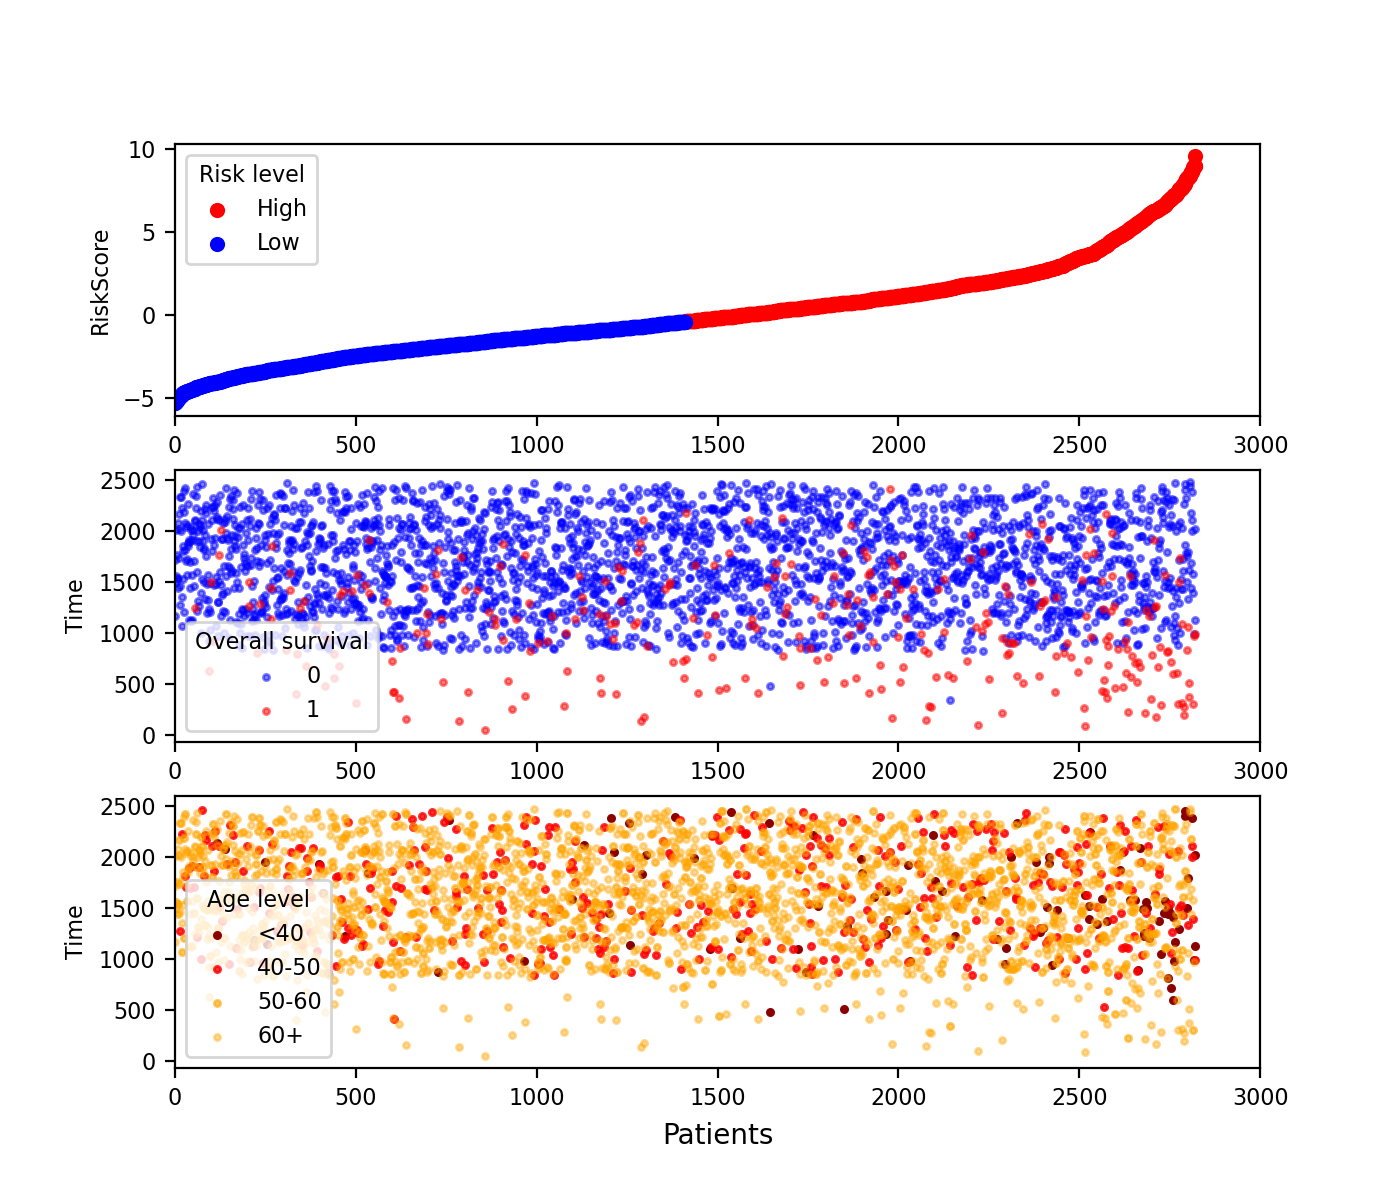

In [191]:
plt.rc('font', size=8)  

fig, axs = plt.subplots(3, 1, figsize=(7,6), gridspec_kw={"height_ratios":[3, 3, 3]})

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,6))

markers = ['MKI67', 'ERBB2', 'ESR1', 'AGR3', 'BUB1', 'FOXA1']

# ('NUSAP1', 6), ('BUB1', 6), ('MKI67', 6), ('TMEM204', 6), ('FOXA1', 6), 
# ('TSHR', 6), ('PGAP3', 6), ('ERBB2', 6), ('GATA3', 6), ('ESR1', 6), ('AGR3', 6)

#fig.tight_layout(pad=1.0)
fig.subplots_adjust(hspace=0.2)

# scatter plot
colors = {True:'blue', False:'red'}
grouped = df_sw_dat_phe.groupby('Class')
for key, group in grouped:
    group.plot(ax=axs[0], kind='scatter', x='N', y='RiskScore', label=key, color=colors[key])

axs[0].set_xlabel('', fontsize=8)
axs[0].set_xlim([0, 3000])
axs[0].legend(title='Risk level', labels= ['High','Low'])

# scatterplot
colors = {1:'red', 0:'blue'}
grouped = df_sw_dat_phe.groupby('Event')
for key, group in grouped:
    group.plot(ax=axs[1], kind='scatter', x='N', y='Time', label=key, color=colors[key], alpha = 0.5, marker = '.')
    
axs[1].set_xlabel('', fontsize=8)
axs[1].set_xlim([0, 3000])
axs[1].legend(title='Overall survival')
    
# scatterplot
colors = {'<40':'darkred', '40-50':'red', '50-60':'orange', '60+': 'orange'}
trasps = {'<40':1, '40-50':0.8, '50-60':0.6, '60+': 0.4}
grouped = df_sw_dat_phe.groupby('Age')
for key, group in grouped:
    t = trasps[key]
    group.plot(ax=axs[2], kind='scatter', x='N', y='Time', label=key, color=colors[key], alpha = t, marker = '.')
    
axs[2].set_xlabel('', fontsize=8)
axs[2].set_xlim([0, 3000])
axs[2].legend(title='Age level', loc = 'lower left')

axs[2].set_xlabel('Patients', fontsize=10)
    
plt.show()

plt.savefig('risk_biom.pdf', bbox_inches='tight')

#### Estimating the survival function using Kaplan-Meier

In [192]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
kmf = KaplanMeierFitter()
low_risk = (df_sw_dat_phe["Class"] == True)
T = df_sw_dat_phe["Time"]
E = df_sw_dat_phe["Event"]
results = logrank_test(T[low_risk], T[~low_risk], E[low_risk], E[~low_risk], alpha=.99)
print(results.summary.iloc[:,1])
results.print_summary()

0    4.736208e-07
Name: p, dtype: float64


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          25.37 <0.005     21.01

<IPython.core.display.Javascript object>


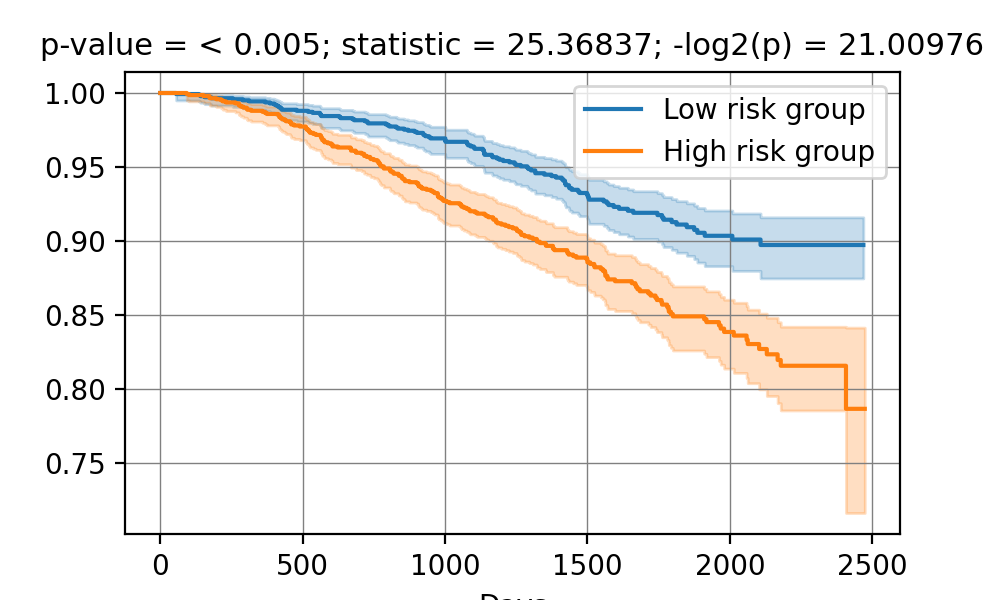

In [224]:
plt.rc('font', size=10)  

fig, ax = plt.subplots(1, 1, figsize=(5,3))

kmf.fit(T[low_risk], event_observed=E[low_risk], label="Low risk group")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~low_risk], event_observed=E[~low_risk], label="High risk group")
kmf.plot_survival_function(ax=ax) #at_risk_counts=True

ts = round(float(results.summary.iloc[:,0]), 5)
pv = round(float(results.summary.iloc[:,1]), 10)
lt = round(float(results.summary.iloc[:,2]), 5)

ax.set_title('p-value = < 0.005; statistic = ' + str(ts) + '; -log2(p) = ' + str(lt), fontsize=11)

ax.set_xlabel('Days')

ax.grid(color='gray', linestyle='-', linewidth=.5)

#plt.title("Lifespans of different global regimes")
plt.show()
plt.savefig('survival.pdf', bbox_inches='tight')

In [1238]:
mappin_histcl = ['LumA','LumB','Her2','Basal']
dfp = pd.DataFrame({'BUB1':X_bioma_known['BUB1'].tolist(),
                    'AGR3':X_bioma_known['AGR3'].tolist(),
                    'HISTCL':[mappin_histcl[i] for i in histcl.tolist()]})
dfp.head()

BUB1      AGR3 HISTCL
0  3.025597  0.000000  Basal
1  1.465654  7.376594   LumA
2  3.529516  6.822501   LumB
3  0.000000  5.020364   LumA
4  1.430033  4.925368   Her2